In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
from torch.utils.data import DataLoader, Dataset
import random
from sklearn.model_selection import train_test_split

In [2]:
import torch.optim as optim

In [3]:
Annotation_Data = pd.read_csv("Combined_Data.csv")
Annotation_Data = Annotation_Data.drop_duplicates()
Annotation_Data.head()

,UniProtID,Sequence,Gene,Chr_Pos,Descriptor,EC,Embeddings
0,A0A024RBG1,MALKEGLRAWKRIFWRQILLTLGLLGLFLYGLPKFRHLEALIPMGV...,NUDT4B,1q21.2,phosphohydrolase NUDT4B (DIPP-2B) (Nucleoside ...,EC 3.6.1.52,"[0.5582528114318848, -0.05316164717078209, -0...."
1,A0A075B759,MALKEGLRAWKRIFWRQILLTLGLLGLFLYGLPKFRHLEALIPMGV...,PPIAL4E,1q21.2,isomerase A-like 4E (PPIase A-like 4E),EC 5.2.1.8,"[0.7078999280929565, -0.0335301049053669, -0.1..."
2,A0A075B767,MALKEGLRAWKRIFWRQILLTLGLLGLFLYGLPKFRHLEALIPMGV...,PPIAL4H,1q21.1,isomerase A-like 4H (PPIase A-like 4H),EC 5.2.1.8,"[0.6630434989929199, -0.02503977157175541, -0...."
3,A0A0B4J2A2,MALKEGLRAWKRIFWRQILLTLGLLGLFLYGLPKFRHLEALIPMGV...,PPIAL4C,1q21.2,isomerase A-like 4C (PPIase A-like 4C),EC 5.2.1.8,"[0.6986426711082458, 0.023870546370744705, -0...."
4,A0AVI4,MDSPEVTFTLAYLVFAVCFVFTPNEFHAAGLTVQNLLSGWLGSEDA...,TMEM129,4p16.3,E3 ubiquitin-protein ligase TM129 (RING-type E...,EC 2.3.2.27,"[0.4009017050266266, -0.24968111515045166, -0...."


In [4]:
EC = Annotation_Data["EC"].tolist()
EC = set(EC)
EC2idx = {ec: idx for idx, ec in enumerate(EC)}

In [5]:
num_classes = len(EC)

In [6]:
print(num_classes)

1342


In [7]:
class AnnotationBertDataset(Dataset):
    def __init__(self, Annotation_df):
        super().__init__()
        self.ID = Annotation_df["UniProtID"].tolist()
        self.labels = [EC2idx.get(ec, -1) for ec in Annotation_df["EC"]]
        self.embeddings = []
        for i in range(len(Annotation_df)):
            tokens = Annotation_df["Embeddings"][i]
            tokens = tokens[1:]
            tokens = tokens[:-1]
            tokens_list = tokens.split(",")
            tokens_list_fixed = [x[1:] for x in tokens_list if x[0] == " "]
            numeric_tokens_list = [float(x) for x in tokens_list_fixed]
            self.embeddings.append(torch.tensor(numeric_tokens_list, dtype=torch.float32))

    def __len__(self):
        return len(self.ID)

    def __getitem__(self, index):
        emb = self.embeddings[index]
        label = torch.tensor(self.labels[index], dtype=torch.long)
        ID = self.ID[index]
        return ID, emb, label

In [8]:
Train_Data, Test_Data = train_test_split(Annotation_Data, test_size=0.2, random_state=0)

In [9]:
Train_Data, Val_Data = train_test_split(Train_Data, test_size=0.2, random_state=16)

In [10]:
Train_Data = Train_Data.reset_index()
Val_Data = Val_Data.reset_index()
Test_Data = Test_Data.reset_index()

In [11]:
Train_Dataset = AnnotationBertDataset(Train_Data)
Val_Dataset = AnnotationBertDataset(Val_Data)
Test_Dataset = AnnotationBertDataset(Test_Data)

In [12]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim=767, hidden_dim=59, num_classes=num_classes, layers=2):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # TODO: forward function
        #h0 = torch.zeros(1, x.size(0), 12800).to(x.device)
        x,_ = self.rnn(x)
        x = self.fc(x)
        return x

In [13]:
def train_model_annotation(model, train_dataset, val_dataset, num_classes, epochs=100, batch_size=256, lr=1e-3, patience=10, device='cuda:0'):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_acc = 0
    patience_counter = 0
    best_ckpt = None

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for IDs, embs, labels in train_loader:
            # TODO: backpropagation
            #####
            model = model.to(device)
            embs = embs.to(device)
            labels = labels.to(device)
            outputs = model(embs)
            outputs = outputs.to(device)
            loss = criterion(outputs, labels)
             #zero's grad for backprogation
            optimizer.zero_grad()

            #backpropagates
            loss.backward()

            #steps forward
            optimizer.step()
            #####
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for IDs, embs, labels in val_loader:
                # TODO: inference
                #####
                model = model.to(device)
                embs = embs.to(device)
                labels = labels.to(device)
                outputs = model(embs)
                outputs = outputs.to(device)
                pred = outputs.argmax(dim=1)
                #####
                correct += (pred == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        print(f'Epoch {epoch+1}: Train Loss={total_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}')

        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            best_ckpt = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return model, best_ckpt, best_acc

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = RNNClassifier().to(device)
model, best_ckpt,_ = train_model_annotation(model, Train_Dataset, Val_Dataset, num_classes,epochs=500, batch_size=64, lr=1e-3, patience=10, device=device)
model.load_state_dict(best_ckpt)

Epoch 1: Train Loss=268.8778, Train Acc=0.0590, Val Acc=0.0579
Epoch 2: Train Loss=245.3411, Train Acc=0.0681, Val Acc=0.0634
Epoch 3: Train Loss=238.0310, Train Acc=0.0791, Val Acc=0.0634
Epoch 4: Train Loss=227.7214, Train Acc=0.0941, Val Acc=0.1102
Epoch 5: Train Loss=220.0987, Train Acc=0.1255, Val Acc=0.1377
Epoch 6: Train Loss=211.3482, Train Acc=0.1464, Val Acc=0.1598
Epoch 7: Train Loss=204.5901, Train Acc=0.1645, Val Acc=0.1460
Epoch 8: Train Loss=197.4212, Train Acc=0.1783, Val Acc=0.1873
Epoch 9: Train Loss=190.5750, Train Acc=0.1956, Val Acc=0.2066
Epoch 10: Train Loss=184.8017, Train Acc=0.2046, Val Acc=0.2094
Epoch 11: Train Loss=179.8433, Train Acc=0.2188, Val Acc=0.2149
Epoch 12: Train Loss=174.7800, Train Acc=0.2271, Val Acc=0.2204
Epoch 13: Train Loss=169.2771, Train Acc=0.2397, Val Acc=0.2424
Epoch 14: Train Loss=165.6157, Train Acc=0.2412, Val Acc=0.2452
Epoch 15: Train Loss=160.5886, Train Acc=0.2468, Val Acc=0.2507
Epoch 16: Train Loss=156.4708, Train Acc=0.2641, 

<All keys matched successfully>

In [26]:
epochs = [200,300,400,500]
patiences = [20,30,40,50]
lrs = [7e-4,1e-3,3e-3,5e-3]
batch_sizes = [32,64,128,256]
best_acc = 0
best_epoch = -100
best_patience = -100
best_lr = -100
best_batch = -100
for epoch in epochs:
    for patience in patiences:
        for lr in lrs:
            for batch_size in batch_sizes:
                model = RNNClassifier().to(device)
                model, best_ckpt, curr_acc = train_model_annotation(model, Train_Dataset, Val_Dataset, num_classes,epochs=epoch, batch_size=batch_size, lr=lr, patience=patience, device=device)
                if (curr_acc > best_acc):
                    best_acc = curr_acc
                    best_epoch = epoch
                    best_patience = patience
                    best_lr = lr
                    print(f"Current Best Hyperparameters: Epochs: {epoch}, Patience: {patience}, Learning_Rate: {lr}, Batch_Size: {batch_size} | Current Best Val Accuracy: {best_acc})")

Epoch 1: Train Loss=533.0634, Train Acc=0.0563, Val Acc=0.0606
Epoch 2: Train Loss=483.3341, Train Acc=0.0752, Val Acc=0.0606
Epoch 3: Train Loss=458.1678, Train Acc=0.0811, Val Acc=0.1019
Epoch 4: Train Loss=443.4336, Train Acc=0.1189, Val Acc=0.1267
Epoch 5: Train Loss=426.7870, Train Acc=0.1393, Val Acc=0.1295
Epoch 6: Train Loss=410.4621, Train Acc=0.1511, Val Acc=0.1405
Epoch 7: Train Loss=397.4996, Train Acc=0.1621, Val Acc=0.1598
Epoch 8: Train Loss=386.4149, Train Acc=0.1728, Val Acc=0.1983
Epoch 9: Train Loss=374.8065, Train Acc=0.1858, Val Acc=0.1983
Epoch 10: Train Loss=363.9582, Train Acc=0.2070, Val Acc=0.2149
Epoch 11: Train Loss=353.0220, Train Acc=0.2227, Val Acc=0.2314
Epoch 12: Train Loss=343.0637, Train Acc=0.2310, Val Acc=0.2259
Epoch 13: Train Loss=334.5939, Train Acc=0.2393, Val Acc=0.2314
Epoch 14: Train Loss=326.2700, Train Acc=0.2464, Val Acc=0.2287
Epoch 15: Train Loss=317.5240, Train Acc=0.2499, Val Acc=0.2452
Epoch 16: Train Loss=307.0128, Train Acc=0.2668, 

Epoch 1: Train Loss=270.0542, Train Acc=0.0622, Val Acc=0.0634
Epoch 2: Train Loss=246.0210, Train Acc=0.0657, Val Acc=0.0579
Epoch 3: Train Loss=242.5698, Train Acc=0.0649, Val Acc=0.0909
Epoch 4: Train Loss=237.1767, Train Acc=0.0657, Val Acc=0.0606
Epoch 5: Train Loss=229.1695, Train Acc=0.0712, Val Acc=0.0634
Epoch 6: Train Loss=224.5576, Train Acc=0.0795, Val Acc=0.0826
Epoch 7: Train Loss=220.2317, Train Acc=0.0846, Val Acc=0.0716
Epoch 8: Train Loss=216.2236, Train Acc=0.0913, Val Acc=0.1047
Epoch 9: Train Loss=212.9146, Train Acc=0.1063, Val Acc=0.1102
Epoch 10: Train Loss=209.1660, Train Acc=0.1169, Val Acc=0.1267
Epoch 11: Train Loss=205.0681, Train Acc=0.1547, Val Acc=0.1625
Epoch 12: Train Loss=200.7312, Train Acc=0.1728, Val Acc=0.1763
Epoch 13: Train Loss=195.8551, Train Acc=0.1865, Val Acc=0.1983
Epoch 14: Train Loss=191.7999, Train Acc=0.1972, Val Acc=0.2011
Epoch 15: Train Loss=187.5309, Train Acc=0.2105, Val Acc=0.2176
Epoch 16: Train Loss=183.8092, Train Acc=0.2141, 

Epoch 130: Train Loss=20.6738, Train Acc=0.9410, Val Acc=0.4298
Epoch 131: Train Loss=19.7536, Train Acc=0.9488, Val Acc=0.4353
Epoch 132: Train Loss=19.5865, Train Acc=0.9461, Val Acc=0.4325
Epoch 133: Train Loss=19.2723, Train Acc=0.9445, Val Acc=0.4270
Epoch 134: Train Loss=19.0611, Train Acc=0.9465, Val Acc=0.4353
Epoch 135: Train Loss=18.3942, Train Acc=0.9500, Val Acc=0.4270
Epoch 136: Train Loss=17.8928, Train Acc=0.9555, Val Acc=0.4408
Epoch 137: Train Loss=17.6776, Train Acc=0.9567, Val Acc=0.4077
Epoch 138: Train Loss=17.3356, Train Acc=0.9563, Val Acc=0.4242
Epoch 139: Train Loss=17.2594, Train Acc=0.9543, Val Acc=0.4298
Epoch 140: Train Loss=17.3542, Train Acc=0.9508, Val Acc=0.4380
Epoch 141: Train Loss=16.9653, Train Acc=0.9528, Val Acc=0.4298
Epoch 142: Train Loss=16.2210, Train Acc=0.9591, Val Acc=0.4270
Epoch 143: Train Loss=15.6369, Train Acc=0.9618, Val Acc=0.4270
Epoch 144: Train Loss=15.2528, Train Acc=0.9654, Val Acc=0.4353
Early stopping triggered.
Current Best H

Epoch 116: Train Loss=29.5791, Train Acc=0.6722, Val Acc=0.3388
Epoch 117: Train Loss=29.3269, Train Acc=0.6769, Val Acc=0.3471
Epoch 118: Train Loss=28.6652, Train Acc=0.6930, Val Acc=0.3416
Epoch 119: Train Loss=28.2387, Train Acc=0.6958, Val Acc=0.3388
Epoch 120: Train Loss=28.0705, Train Acc=0.7060, Val Acc=0.3361
Epoch 121: Train Loss=27.7979, Train Acc=0.7068, Val Acc=0.3554
Epoch 122: Train Loss=27.7480, Train Acc=0.7107, Val Acc=0.3444
Epoch 123: Train Loss=27.4127, Train Acc=0.7076, Val Acc=0.3444
Epoch 124: Train Loss=27.3903, Train Acc=0.7096, Val Acc=0.3361
Epoch 125: Train Loss=27.2321, Train Acc=0.7139, Val Acc=0.3499
Epoch 126: Train Loss=26.5160, Train Acc=0.7288, Val Acc=0.3526
Epoch 127: Train Loss=26.1677, Train Acc=0.7292, Val Acc=0.3416
Epoch 128: Train Loss=25.7312, Train Acc=0.7473, Val Acc=0.3444
Epoch 129: Train Loss=25.4382, Train Acc=0.7536, Val Acc=0.3526
Epoch 130: Train Loss=25.2315, Train Acc=0.7513, Val Acc=0.3388
Epoch 131: Train Loss=24.9795, Train Acc

Epoch 120: Train Loss=24.0904, Train Acc=0.4522, Val Acc=0.3196
Epoch 121: Train Loss=23.8924, Train Acc=0.4585, Val Acc=0.3140
Epoch 122: Train Loss=23.7376, Train Acc=0.4553, Val Acc=0.3140
Epoch 123: Train Loss=23.5436, Train Acc=0.4671, Val Acc=0.3306
Epoch 124: Train Loss=23.4129, Train Acc=0.4624, Val Acc=0.3196
Epoch 125: Train Loss=23.1516, Train Acc=0.4652, Val Acc=0.3196
Epoch 126: Train Loss=22.9251, Train Acc=0.4821, Val Acc=0.3223
Epoch 127: Train Loss=22.7521, Train Acc=0.4809, Val Acc=0.3278
Epoch 128: Train Loss=22.6611, Train Acc=0.4782, Val Acc=0.3278
Epoch 129: Train Loss=22.5083, Train Acc=0.4750, Val Acc=0.3223
Epoch 130: Train Loss=22.4058, Train Acc=0.4868, Val Acc=0.3223
Epoch 131: Train Loss=22.1759, Train Acc=0.4919, Val Acc=0.3223
Epoch 132: Train Loss=22.0077, Train Acc=0.4947, Val Acc=0.3306
Epoch 133: Train Loss=21.8489, Train Acc=0.4994, Val Acc=0.3278
Epoch 134: Train Loss=21.7048, Train Acc=0.4982, Val Acc=0.3278
Epoch 135: Train Loss=21.5033, Train Acc

Epoch 89: Train Loss=20.9689, Train Acc=0.9654, Val Acc=0.4105
Epoch 90: Train Loss=21.6374, Train Acc=0.9603, Val Acc=0.3939
Epoch 91: Train Loss=18.8935, Train Acc=0.9713, Val Acc=0.4242
Epoch 92: Train Loss=17.3926, Train Acc=0.9732, Val Acc=0.4160
Early stopping triggered.
Epoch 1: Train Loss=265.5335, Train Acc=0.0665, Val Acc=0.0579
Epoch 2: Train Loss=245.4385, Train Acc=0.0638, Val Acc=0.0579
Epoch 3: Train Loss=239.0193, Train Acc=0.0701, Val Acc=0.0634
Epoch 4: Train Loss=229.0180, Train Acc=0.0744, Val Acc=0.0606
Epoch 5: Train Loss=223.5227, Train Acc=0.0933, Val Acc=0.1047
Epoch 6: Train Loss=218.5782, Train Acc=0.1141, Val Acc=0.1543
Epoch 7: Train Loss=212.8407, Train Acc=0.1436, Val Acc=0.1405
Epoch 8: Train Loss=206.3543, Train Acc=0.1586, Val Acc=0.1653
Epoch 9: Train Loss=200.1986, Train Acc=0.1684, Val Acc=0.1873
Epoch 10: Train Loss=193.5952, Train Acc=0.1834, Val Acc=0.2011
Epoch 11: Train Loss=187.4393, Train Acc=0.2023, Val Acc=0.2011
Epoch 12: Train Loss=181.99

Epoch 45: Train Loss=64.9864, Train Acc=0.3066, Val Acc=0.2893
Epoch 46: Train Loss=64.1926, Train Acc=0.3176, Val Acc=0.2865
Epoch 47: Train Loss=63.6565, Train Acc=0.3160, Val Acc=0.2920
Epoch 48: Train Loss=63.0221, Train Acc=0.3227, Val Acc=0.2837
Epoch 49: Train Loss=62.0905, Train Acc=0.3322, Val Acc=0.2975
Epoch 50: Train Loss=61.3708, Train Acc=0.3381, Val Acc=0.3223
Epoch 51: Train Loss=60.6694, Train Acc=0.3408, Val Acc=0.2948
Epoch 52: Train Loss=60.0928, Train Acc=0.3451, Val Acc=0.3058
Epoch 53: Train Loss=59.3914, Train Acc=0.3451, Val Acc=0.3003
Epoch 54: Train Loss=58.9417, Train Acc=0.3542, Val Acc=0.3113
Epoch 55: Train Loss=58.0808, Train Acc=0.3593, Val Acc=0.3058
Epoch 56: Train Loss=57.3981, Train Acc=0.3680, Val Acc=0.3113
Epoch 57: Train Loss=57.3904, Train Acc=0.3664, Val Acc=0.3223
Epoch 58: Train Loss=56.1786, Train Acc=0.3688, Val Acc=0.3196
Epoch 59: Train Loss=55.3498, Train Acc=0.3778, Val Acc=0.3333
Epoch 60: Train Loss=54.6784, Train Acc=0.3904, Val Acc

Epoch 44: Train Loss=36.2825, Train Acc=0.2916, Val Acc=0.2507
Epoch 45: Train Loss=35.7783, Train Acc=0.2971, Val Acc=0.2590
Epoch 46: Train Loss=35.2799, Train Acc=0.3042, Val Acc=0.2534
Epoch 47: Train Loss=34.8277, Train Acc=0.3070, Val Acc=0.2562
Epoch 48: Train Loss=34.3207, Train Acc=0.3196, Val Acc=0.2645
Epoch 49: Train Loss=33.8045, Train Acc=0.3152, Val Acc=0.2700
Epoch 50: Train Loss=33.4627, Train Acc=0.3314, Val Acc=0.2782
Epoch 51: Train Loss=32.9971, Train Acc=0.3262, Val Acc=0.2810
Epoch 52: Train Loss=32.6130, Train Acc=0.3373, Val Acc=0.2865
Epoch 53: Train Loss=32.0994, Train Acc=0.3396, Val Acc=0.2782
Epoch 54: Train Loss=31.6891, Train Acc=0.3455, Val Acc=0.2755
Epoch 55: Train Loss=31.3161, Train Acc=0.3542, Val Acc=0.3003
Epoch 56: Train Loss=30.9540, Train Acc=0.3609, Val Acc=0.2865
Epoch 57: Train Loss=30.6969, Train Acc=0.3613, Val Acc=0.2920
Epoch 58: Train Loss=30.2441, Train Acc=0.3644, Val Acc=0.2948
Epoch 59: Train Loss=29.8599, Train Acc=0.3711, Val Acc

Epoch 14: Train Loss=392.4857, Train Acc=0.1653, Val Acc=0.1791
Epoch 15: Train Loss=391.9165, Train Acc=0.1586, Val Acc=0.1570
Epoch 16: Train Loss=390.6659, Train Acc=0.1633, Val Acc=0.1901
Epoch 17: Train Loss=381.3182, Train Acc=0.1779, Val Acc=0.1708
Epoch 18: Train Loss=382.1686, Train Acc=0.1751, Val Acc=0.1322
Epoch 19: Train Loss=380.2268, Train Acc=0.1712, Val Acc=0.1680
Epoch 20: Train Loss=374.8739, Train Acc=0.1767, Val Acc=0.1928
Epoch 21: Train Loss=376.3294, Train Acc=0.1799, Val Acc=0.2039
Epoch 22: Train Loss=367.0467, Train Acc=0.1948, Val Acc=0.2039
Epoch 23: Train Loss=362.4924, Train Acc=0.1932, Val Acc=0.2149
Epoch 24: Train Loss=359.5797, Train Acc=0.2086, Val Acc=0.2011
Epoch 25: Train Loss=353.9166, Train Acc=0.2102, Val Acc=0.2094
Epoch 26: Train Loss=345.1526, Train Acc=0.2208, Val Acc=0.1983
Epoch 27: Train Loss=337.2206, Train Acc=0.2157, Val Acc=0.2204
Epoch 28: Train Loss=335.9234, Train Acc=0.2141, Val Acc=0.2204
Epoch 29: Train Loss=325.6124, Train Acc

Epoch 45: Train Loss=115.3068, Train Acc=0.3408, Val Acc=0.2893
Epoch 46: Train Loss=115.1814, Train Acc=0.3455, Val Acc=0.3140
Epoch 47: Train Loss=111.7282, Train Acc=0.3585, Val Acc=0.3085
Epoch 48: Train Loss=109.6872, Train Acc=0.3628, Val Acc=0.3085
Epoch 49: Train Loss=111.8149, Train Acc=0.3491, Val Acc=0.3168
Epoch 50: Train Loss=106.6521, Train Acc=0.3766, Val Acc=0.3223
Epoch 51: Train Loss=105.9573, Train Acc=0.3743, Val Acc=0.3251
Epoch 52: Train Loss=103.1066, Train Acc=0.3853, Val Acc=0.3251
Epoch 53: Train Loss=100.9190, Train Acc=0.3857, Val Acc=0.3085
Epoch 54: Train Loss=100.8018, Train Acc=0.3892, Val Acc=0.3168
Epoch 55: Train Loss=101.6663, Train Acc=0.3857, Val Acc=0.3196
Epoch 56: Train Loss=100.6284, Train Acc=0.3845, Val Acc=0.3251
Epoch 57: Train Loss=97.0314, Train Acc=0.4054, Val Acc=0.3278
Epoch 58: Train Loss=96.8885, Train Acc=0.4065, Val Acc=0.3388
Epoch 59: Train Loss=98.6592, Train Acc=0.3849, Val Acc=0.3140
Epoch 60: Train Loss=94.5589, Train Acc=0.4

Epoch 95: Train Loss=37.1212, Train Acc=0.4911, Val Acc=0.3416
Epoch 96: Train Loss=36.6863, Train Acc=0.4943, Val Acc=0.3499
Epoch 97: Train Loss=34.8093, Train Acc=0.5116, Val Acc=0.3609
Epoch 98: Train Loss=33.7645, Train Acc=0.5270, Val Acc=0.3388
Epoch 99: Train Loss=33.6828, Train Acc=0.5356, Val Acc=0.3609
Epoch 100: Train Loss=34.0031, Train Acc=0.5305, Val Acc=0.3444
Epoch 101: Train Loss=34.4859, Train Acc=0.5128, Val Acc=0.3526
Epoch 102: Train Loss=33.0206, Train Acc=0.5309, Val Acc=0.3471
Epoch 103: Train Loss=33.1747, Train Acc=0.5368, Val Acc=0.3416
Epoch 104: Train Loss=31.9551, Train Acc=0.5431, Val Acc=0.3691
Epoch 105: Train Loss=30.5386, Train Acc=0.5813, Val Acc=0.3609
Epoch 106: Train Loss=29.9837, Train Acc=0.5781, Val Acc=0.3664
Epoch 107: Train Loss=30.0951, Train Acc=0.5742, Val Acc=0.3581
Epoch 108: Train Loss=30.0727, Train Acc=0.5750, Val Acc=0.3499
Epoch 109: Train Loss=29.1855, Train Acc=0.5821, Val Acc=0.3719
Epoch 110: Train Loss=29.1806, Train Acc=0.59

Epoch 93: Train Loss=21.3157, Train Acc=0.4589, Val Acc=0.3278
Epoch 94: Train Loss=21.0346, Train Acc=0.4683, Val Acc=0.3251
Epoch 95: Train Loss=20.9206, Train Acc=0.4660, Val Acc=0.3306
Epoch 96: Train Loss=20.9508, Train Acc=0.4707, Val Acc=0.3416
Epoch 97: Train Loss=21.2101, Train Acc=0.4648, Val Acc=0.3251
Epoch 98: Train Loss=20.9676, Train Acc=0.4683, Val Acc=0.3278
Epoch 99: Train Loss=21.2970, Train Acc=0.4652, Val Acc=0.3140
Epoch 100: Train Loss=21.0000, Train Acc=0.4565, Val Acc=0.3140
Epoch 101: Train Loss=20.4139, Train Acc=0.4754, Val Acc=0.3554
Epoch 102: Train Loss=19.9413, Train Acc=0.4845, Val Acc=0.3223
Epoch 103: Train Loss=19.5431, Train Acc=0.5006, Val Acc=0.3251
Epoch 104: Train Loss=19.2545, Train Acc=0.4931, Val Acc=0.3361
Epoch 105: Train Loss=19.1600, Train Acc=0.5089, Val Acc=0.3306
Epoch 106: Train Loss=19.4157, Train Acc=0.5002, Val Acc=0.3306
Epoch 107: Train Loss=18.6662, Train Acc=0.5238, Val Acc=0.3306
Epoch 108: Train Loss=18.1900, Train Acc=0.5222

Epoch 4: Train Loss=118.2579, Train Acc=0.0649, Val Acc=0.0579
Epoch 5: Train Loss=115.6272, Train Acc=0.0657, Val Acc=0.0634
Epoch 6: Train Loss=113.7129, Train Acc=0.0736, Val Acc=0.0661
Epoch 7: Train Loss=113.3335, Train Acc=0.0689, Val Acc=0.0606
Epoch 8: Train Loss=110.9376, Train Acc=0.0767, Val Acc=0.0689
Epoch 9: Train Loss=108.9667, Train Acc=0.0720, Val Acc=0.0689
Epoch 10: Train Loss=108.1298, Train Acc=0.0720, Val Acc=0.0799
Epoch 11: Train Loss=106.7724, Train Acc=0.0885, Val Acc=0.0716
Epoch 12: Train Loss=105.3548, Train Acc=0.0795, Val Acc=0.0826
Epoch 13: Train Loss=104.8799, Train Acc=0.0889, Val Acc=0.0744
Epoch 14: Train Loss=104.4274, Train Acc=0.0925, Val Acc=0.1047
Epoch 15: Train Loss=102.5887, Train Acc=0.0889, Val Acc=0.1019
Epoch 16: Train Loss=102.5031, Train Acc=0.1015, Val Acc=0.0909
Epoch 17: Train Loss=101.0071, Train Acc=0.0933, Val Acc=0.1074
Epoch 18: Train Loss=100.4385, Train Acc=0.1055, Val Acc=0.0937
Epoch 19: Train Loss=99.9982, Train Acc=0.0948

Epoch 136: Train Loss=73.3464, Train Acc=0.2515, Val Acc=0.2176
Epoch 137: Train Loss=74.3431, Train Acc=0.2424, Val Acc=0.2176
Epoch 138: Train Loss=72.3317, Train Acc=0.2566, Val Acc=0.2314
Epoch 139: Train Loss=71.8865, Train Acc=0.2495, Val Acc=0.2204
Epoch 140: Train Loss=75.1057, Train Acc=0.2322, Val Acc=0.2259
Epoch 141: Train Loss=72.9768, Train Acc=0.2483, Val Acc=0.2231
Epoch 142: Train Loss=70.9320, Train Acc=0.2629, Val Acc=0.2452
Epoch 143: Train Loss=71.0927, Train Acc=0.2578, Val Acc=0.2094
Epoch 144: Train Loss=72.1197, Train Acc=0.2460, Val Acc=0.2479
Epoch 145: Train Loss=71.4179, Train Acc=0.2550, Val Acc=0.2259
Epoch 146: Train Loss=70.0762, Train Acc=0.2613, Val Acc=0.2314
Epoch 147: Train Loss=70.1322, Train Acc=0.2617, Val Acc=0.2507
Epoch 148: Train Loss=69.7123, Train Acc=0.2519, Val Acc=0.2231
Epoch 149: Train Loss=70.2456, Train Acc=0.2660, Val Acc=0.2342
Epoch 150: Train Loss=69.8453, Train Acc=0.2558, Val Acc=0.2314
Epoch 151: Train Loss=71.3025, Train Acc

Epoch 113: Train Loss=27.5846, Train Acc=0.3408, Val Acc=0.2975
Epoch 114: Train Loss=27.4826, Train Acc=0.3459, Val Acc=0.2975
Epoch 115: Train Loss=27.7610, Train Acc=0.3353, Val Acc=0.2755
Epoch 116: Train Loss=27.9599, Train Acc=0.3369, Val Acc=0.2893
Epoch 117: Train Loss=27.5772, Train Acc=0.3447, Val Acc=0.3113
Epoch 118: Train Loss=27.5941, Train Acc=0.3444, Val Acc=0.3113
Epoch 119: Train Loss=27.6240, Train Acc=0.3491, Val Acc=0.2975
Epoch 120: Train Loss=27.5669, Train Acc=0.3514, Val Acc=0.3003
Epoch 121: Train Loss=27.4680, Train Acc=0.3444, Val Acc=0.3003
Epoch 122: Train Loss=27.5236, Train Acc=0.3503, Val Acc=0.2755
Epoch 123: Train Loss=26.5707, Train Acc=0.3510, Val Acc=0.3058
Epoch 124: Train Loss=25.8923, Train Acc=0.3672, Val Acc=0.3251
Epoch 125: Train Loss=25.7126, Train Acc=0.3739, Val Acc=0.2975
Epoch 126: Train Loss=25.5879, Train Acc=0.3691, Val Acc=0.3140
Epoch 127: Train Loss=25.9055, Train Acc=0.3652, Val Acc=0.3168
Epoch 128: Train Loss=25.9739, Train Acc

Epoch 59: Train Loss=93.7614, Train Acc=0.7737, Val Acc=0.4077
Epoch 60: Train Loss=91.3782, Train Acc=0.7855, Val Acc=0.4022
Epoch 61: Train Loss=89.2482, Train Acc=0.7851, Val Acc=0.4022
Epoch 62: Train Loss=86.5695, Train Acc=0.7902, Val Acc=0.4050
Epoch 63: Train Loss=86.1105, Train Acc=0.7946, Val Acc=0.3967
Epoch 64: Train Loss=83.9302, Train Acc=0.8028, Val Acc=0.4050
Epoch 65: Train Loss=80.7836, Train Acc=0.8131, Val Acc=0.4077
Epoch 66: Train Loss=78.2490, Train Acc=0.8261, Val Acc=0.4022
Epoch 67: Train Loss=74.9785, Train Acc=0.8379, Val Acc=0.3939
Epoch 68: Train Loss=73.8672, Train Acc=0.8386, Val Acc=0.4050
Epoch 69: Train Loss=70.5921, Train Acc=0.8571, Val Acc=0.4105
Epoch 70: Train Loss=68.8858, Train Acc=0.8579, Val Acc=0.3994
Epoch 71: Train Loss=69.0189, Train Acc=0.8532, Val Acc=0.3994
Epoch 72: Train Loss=66.4571, Train Acc=0.8603, Val Acc=0.3967
Epoch 73: Train Loss=63.3045, Train Acc=0.8737, Val Acc=0.4132
Epoch 74: Train Loss=60.8211, Train Acc=0.8839, Val Acc

Epoch 81: Train Loss=49.6539, Train Acc=0.7627, Val Acc=0.3664
Epoch 82: Train Loss=49.1649, Train Acc=0.7658, Val Acc=0.3691
Epoch 83: Train Loss=48.5624, Train Acc=0.7611, Val Acc=0.3609
Epoch 84: Train Loss=47.4987, Train Acc=0.7725, Val Acc=0.3691
Epoch 85: Train Loss=46.1647, Train Acc=0.7867, Val Acc=0.3609
Epoch 86: Train Loss=45.3443, Train Acc=0.7879, Val Acc=0.3636
Epoch 87: Train Loss=44.4033, Train Acc=0.7918, Val Acc=0.3719
Epoch 88: Train Loss=43.5320, Train Acc=0.8079, Val Acc=0.3664
Epoch 89: Train Loss=43.0851, Train Acc=0.8036, Val Acc=0.3499
Epoch 90: Train Loss=42.7971, Train Acc=0.7997, Val Acc=0.3664
Epoch 91: Train Loss=41.7976, Train Acc=0.8135, Val Acc=0.3691
Epoch 92: Train Loss=41.4458, Train Acc=0.8052, Val Acc=0.3581
Epoch 93: Train Loss=40.3091, Train Acc=0.8249, Val Acc=0.3719
Epoch 94: Train Loss=39.5256, Train Acc=0.8296, Val Acc=0.3774
Epoch 95: Train Loss=39.1397, Train Acc=0.8304, Val Acc=0.3884
Epoch 96: Train Loss=38.0442, Train Acc=0.8367, Val Acc

Epoch 86: Train Loss=38.8154, Train Acc=0.5935, Val Acc=0.3554
Epoch 87: Train Loss=38.6383, Train Acc=0.5915, Val Acc=0.3526
Epoch 88: Train Loss=38.0718, Train Acc=0.5958, Val Acc=0.3471
Epoch 89: Train Loss=37.4728, Train Acc=0.6068, Val Acc=0.3581
Epoch 90: Train Loss=36.8507, Train Acc=0.6198, Val Acc=0.3499
Epoch 91: Train Loss=36.3671, Train Acc=0.6281, Val Acc=0.3388
Epoch 92: Train Loss=35.7430, Train Acc=0.6395, Val Acc=0.3664
Epoch 93: Train Loss=35.1785, Train Acc=0.6450, Val Acc=0.3581
Epoch 94: Train Loss=34.8749, Train Acc=0.6423, Val Acc=0.3471
Epoch 95: Train Loss=34.0054, Train Acc=0.6686, Val Acc=0.3526
Epoch 96: Train Loss=33.8103, Train Acc=0.6627, Val Acc=0.3636
Epoch 97: Train Loss=33.4178, Train Acc=0.6663, Val Acc=0.3416
Epoch 98: Train Loss=33.0800, Train Acc=0.6753, Val Acc=0.3581
Epoch 99: Train Loss=32.3416, Train Acc=0.6793, Val Acc=0.3471
Epoch 100: Train Loss=31.9884, Train Acc=0.6934, Val Acc=0.3691
Epoch 101: Train Loss=31.5115, Train Acc=0.6926, Val A

Epoch 53: Train Loss=37.9052, Train Acc=0.2609, Val Acc=0.2534
Epoch 54: Train Loss=37.6346, Train Acc=0.2605, Val Acc=0.2479
Epoch 55: Train Loss=37.3973, Train Acc=0.2613, Val Acc=0.2424
Epoch 56: Train Loss=37.0537, Train Acc=0.2645, Val Acc=0.2424
Epoch 57: Train Loss=36.7868, Train Acc=0.2696, Val Acc=0.2479
Epoch 58: Train Loss=36.6332, Train Acc=0.2649, Val Acc=0.2452
Epoch 59: Train Loss=36.2485, Train Acc=0.2680, Val Acc=0.2534
Epoch 60: Train Loss=36.0723, Train Acc=0.2743, Val Acc=0.2562
Epoch 61: Train Loss=35.8311, Train Acc=0.2719, Val Acc=0.2397
Epoch 62: Train Loss=35.4751, Train Acc=0.2755, Val Acc=0.2479
Epoch 63: Train Loss=35.2957, Train Acc=0.2715, Val Acc=0.2562
Epoch 64: Train Loss=35.0082, Train Acc=0.2826, Val Acc=0.2590
Epoch 65: Train Loss=34.6666, Train Acc=0.2889, Val Acc=0.2534
Epoch 66: Train Loss=34.4357, Train Acc=0.2893, Val Acc=0.2562
Epoch 67: Train Loss=34.2053, Train Acc=0.2963, Val Acc=0.2617
Epoch 68: Train Loss=33.9546, Train Acc=0.2991, Val Acc

Epoch 185: Train Loss=14.7506, Train Acc=0.6738, Val Acc=0.3719
Epoch 186: Train Loss=14.6972, Train Acc=0.6816, Val Acc=0.3664
Epoch 187: Train Loss=14.4971, Train Acc=0.6867, Val Acc=0.3691
Epoch 188: Train Loss=14.4710, Train Acc=0.6899, Val Acc=0.3691
Epoch 189: Train Loss=14.3231, Train Acc=0.6856, Val Acc=0.3747
Epoch 190: Train Loss=14.2914, Train Acc=0.6903, Val Acc=0.3664
Epoch 191: Train Loss=14.0780, Train Acc=0.7021, Val Acc=0.3747
Epoch 192: Train Loss=13.9508, Train Acc=0.7052, Val Acc=0.3719
Epoch 193: Train Loss=14.1689, Train Acc=0.7048, Val Acc=0.3691
Epoch 194: Train Loss=13.9016, Train Acc=0.7013, Val Acc=0.3719
Epoch 195: Train Loss=13.7423, Train Acc=0.7166, Val Acc=0.3747
Epoch 196: Train Loss=13.5731, Train Acc=0.7166, Val Acc=0.3664
Epoch 197: Train Loss=13.5960, Train Acc=0.7186, Val Acc=0.3747
Epoch 198: Train Loss=13.6417, Train Acc=0.7151, Val Acc=0.3691
Epoch 199: Train Loss=13.6218, Train Acc=0.7131, Val Acc=0.3774
Epoch 200: Train Loss=13.5612, Train Acc

Epoch 6: Train Loss=207.9263, Train Acc=0.1499, Val Acc=0.1680
Epoch 7: Train Loss=200.9667, Train Acc=0.1669, Val Acc=0.1598
Epoch 8: Train Loss=194.7477, Train Acc=0.1716, Val Acc=0.1625
Epoch 9: Train Loss=188.3148, Train Acc=0.1873, Val Acc=0.1956
Epoch 10: Train Loss=183.2641, Train Acc=0.1968, Val Acc=0.2039
Epoch 11: Train Loss=177.3680, Train Acc=0.2113, Val Acc=0.2066
Epoch 12: Train Loss=173.5818, Train Acc=0.2165, Val Acc=0.2121
Epoch 13: Train Loss=168.1940, Train Acc=0.2314, Val Acc=0.2287
Epoch 14: Train Loss=163.5514, Train Acc=0.2330, Val Acc=0.2314
Epoch 15: Train Loss=160.0802, Train Acc=0.2475, Val Acc=0.2369
Epoch 16: Train Loss=156.0789, Train Acc=0.2542, Val Acc=0.2507
Epoch 17: Train Loss=151.3484, Train Acc=0.2664, Val Acc=0.2590
Epoch 18: Train Loss=147.2873, Train Acc=0.2845, Val Acc=0.2672
Epoch 19: Train Loss=144.0079, Train Acc=0.2822, Val Acc=0.2700
Epoch 20: Train Loss=139.9305, Train Acc=0.2971, Val Acc=0.2865
Epoch 21: Train Loss=136.5270, Train Acc=0.3

Epoch 16: Train Loss=90.8256, Train Acc=0.2105, Val Acc=0.2121
Epoch 17: Train Loss=88.9536, Train Acc=0.2137, Val Acc=0.2176
Epoch 18: Train Loss=87.1672, Train Acc=0.2243, Val Acc=0.2121
Epoch 19: Train Loss=85.3683, Train Acc=0.2322, Val Acc=0.2204
Epoch 20: Train Loss=83.7187, Train Acc=0.2314, Val Acc=0.2231
Epoch 21: Train Loss=82.0140, Train Acc=0.2393, Val Acc=0.2314
Epoch 22: Train Loss=80.7085, Train Acc=0.2456, Val Acc=0.2259
Epoch 23: Train Loss=79.1328, Train Acc=0.2519, Val Acc=0.2231
Epoch 24: Train Loss=78.3163, Train Acc=0.2456, Val Acc=0.2479
Epoch 25: Train Loss=76.6907, Train Acc=0.2582, Val Acc=0.2424
Epoch 26: Train Loss=75.1483, Train Acc=0.2676, Val Acc=0.2424
Epoch 27: Train Loss=73.9338, Train Acc=0.2700, Val Acc=0.2452
Epoch 28: Train Loss=73.3019, Train Acc=0.2727, Val Acc=0.2342
Epoch 29: Train Loss=72.4381, Train Acc=0.2767, Val Acc=0.2452
Epoch 30: Train Loss=70.7613, Train Acc=0.2865, Val Acc=0.2590
Epoch 31: Train Loss=69.3919, Train Acc=0.2916, Val Acc

Epoch 19: Train Loss=53.4014, Train Acc=0.1067, Val Acc=0.1240
Epoch 20: Train Loss=52.8977, Train Acc=0.1070, Val Acc=0.1240
Epoch 21: Train Loss=52.3616, Train Acc=0.1303, Val Acc=0.1240
Epoch 22: Train Loss=51.8079, Train Acc=0.1228, Val Acc=0.1350
Epoch 23: Train Loss=51.2335, Train Acc=0.1523, Val Acc=0.1543
Epoch 24: Train Loss=50.6011, Train Acc=0.1661, Val Acc=0.1625
Epoch 25: Train Loss=49.8578, Train Acc=0.1759, Val Acc=0.1736
Epoch 26: Train Loss=49.1087, Train Acc=0.1783, Val Acc=0.1846
Epoch 27: Train Loss=48.4669, Train Acc=0.1838, Val Acc=0.1818
Epoch 28: Train Loss=47.7272, Train Acc=0.1873, Val Acc=0.1818
Epoch 29: Train Loss=47.1258, Train Acc=0.1921, Val Acc=0.1901
Epoch 30: Train Loss=46.4816, Train Acc=0.2046, Val Acc=0.1901
Epoch 31: Train Loss=45.8573, Train Acc=0.2043, Val Acc=0.2094
Epoch 32: Train Loss=45.2924, Train Acc=0.2102, Val Acc=0.2066
Epoch 33: Train Loss=44.7396, Train Acc=0.2133, Val Acc=0.2039
Epoch 34: Train Loss=44.2959, Train Acc=0.2165, Val Acc

Epoch 151: Train Loss=11.3465, Train Acc=0.8005, Val Acc=0.3691
Epoch 152: Train Loss=11.1515, Train Acc=0.8079, Val Acc=0.3802
Epoch 153: Train Loss=11.0028, Train Acc=0.8131, Val Acc=0.3802
Epoch 154: Train Loss=10.8843, Train Acc=0.8190, Val Acc=0.3774
Epoch 155: Train Loss=10.8094, Train Acc=0.8154, Val Acc=0.3774
Epoch 156: Train Loss=10.7405, Train Acc=0.8253, Val Acc=0.3857
Epoch 157: Train Loss=10.6187, Train Acc=0.8335, Val Acc=0.3747
Epoch 158: Train Loss=10.5604, Train Acc=0.8249, Val Acc=0.3719
Epoch 159: Train Loss=10.3678, Train Acc=0.8284, Val Acc=0.3747
Epoch 160: Train Loss=10.1945, Train Acc=0.8371, Val Acc=0.3719
Epoch 161: Train Loss=10.2071, Train Acc=0.8426, Val Acc=0.3857
Epoch 162: Train Loss=10.1693, Train Acc=0.8323, Val Acc=0.3857
Epoch 163: Train Loss=9.9804, Train Acc=0.8390, Val Acc=0.3802
Epoch 164: Train Loss=9.7960, Train Acc=0.8528, Val Acc=0.3829
Epoch 165: Train Loss=9.6401, Train Acc=0.8481, Val Acc=0.3857
Epoch 166: Train Loss=9.6221, Train Acc=0.8

Epoch 80: Train Loss=285.1020, Train Acc=0.2617, Val Acc=0.2204
Epoch 81: Train Loss=293.9043, Train Acc=0.2507, Val Acc=0.2314
Epoch 82: Train Loss=290.1856, Train Acc=0.2554, Val Acc=0.2342
Epoch 83: Train Loss=288.4722, Train Acc=0.2590, Val Acc=0.1791
Epoch 84: Train Loss=282.5061, Train Acc=0.2562, Val Acc=0.2039
Epoch 85: Train Loss=275.9462, Train Acc=0.2645, Val Acc=0.2176
Epoch 86: Train Loss=280.4370, Train Acc=0.2672, Val Acc=0.2149
Epoch 87: Train Loss=277.0998, Train Acc=0.2660, Val Acc=0.2562
Epoch 88: Train Loss=279.5607, Train Acc=0.2684, Val Acc=0.2259
Epoch 89: Train Loss=274.8104, Train Acc=0.2637, Val Acc=0.2342
Epoch 90: Train Loss=280.4907, Train Acc=0.2656, Val Acc=0.2259
Epoch 91: Train Loss=276.6426, Train Acc=0.2649, Val Acc=0.2507
Epoch 92: Train Loss=270.6581, Train Acc=0.2660, Val Acc=0.2645
Epoch 93: Train Loss=265.6004, Train Acc=0.2719, Val Acc=0.2094
Epoch 94: Train Loss=264.6528, Train Acc=0.2755, Val Acc=0.2397
Epoch 95: Train Loss=272.9846, Train Acc

Epoch 58: Train Loss=81.0465, Train Acc=0.4514, Val Acc=0.3278
Epoch 59: Train Loss=78.7613, Train Acc=0.4510, Val Acc=0.3223
Epoch 60: Train Loss=77.2361, Train Acc=0.4691, Val Acc=0.3196
Epoch 61: Train Loss=76.8101, Train Acc=0.4648, Val Acc=0.3251
Epoch 62: Train Loss=73.8148, Train Acc=0.4845, Val Acc=0.3388
Epoch 63: Train Loss=73.7617, Train Acc=0.4734, Val Acc=0.3306
Epoch 64: Train Loss=77.1079, Train Acc=0.4667, Val Acc=0.3361
Epoch 65: Train Loss=69.8470, Train Acc=0.5037, Val Acc=0.3333
Epoch 66: Train Loss=69.2872, Train Acc=0.5100, Val Acc=0.3361
Epoch 67: Train Loss=72.0543, Train Acc=0.4904, Val Acc=0.3333
Epoch 68: Train Loss=69.1673, Train Acc=0.5002, Val Acc=0.3306
Epoch 69: Train Loss=67.1943, Train Acc=0.5175, Val Acc=0.3554
Epoch 70: Train Loss=66.6744, Train Acc=0.5089, Val Acc=0.3471
Epoch 71: Train Loss=67.3197, Train Acc=0.5108, Val Acc=0.3388
Epoch 72: Train Loss=63.5461, Train Acc=0.5321, Val Acc=0.3333
Epoch 73: Train Loss=62.2301, Train Acc=0.5443, Val Acc

Epoch 74: Train Loss=54.4006, Train Acc=0.3955, Val Acc=0.3196
Epoch 75: Train Loss=54.4844, Train Acc=0.3865, Val Acc=0.3196
Epoch 76: Train Loss=53.9237, Train Acc=0.3920, Val Acc=0.3223
Epoch 77: Train Loss=52.4727, Train Acc=0.3932, Val Acc=0.3223
Epoch 78: Train Loss=52.6059, Train Acc=0.4038, Val Acc=0.3196
Epoch 79: Train Loss=52.0242, Train Acc=0.3951, Val Acc=0.3223
Epoch 80: Train Loss=51.1405, Train Acc=0.4116, Val Acc=0.3251
Epoch 81: Train Loss=49.7410, Train Acc=0.4183, Val Acc=0.3168
Epoch 82: Train Loss=49.0088, Train Acc=0.4274, Val Acc=0.3333
Epoch 83: Train Loss=51.4388, Train Acc=0.3900, Val Acc=0.3278
Epoch 84: Train Loss=49.8418, Train Acc=0.4195, Val Acc=0.3085
Epoch 85: Train Loss=49.3941, Train Acc=0.4140, Val Acc=0.3444
Epoch 86: Train Loss=47.4490, Train Acc=0.4341, Val Acc=0.3471
Epoch 87: Train Loss=46.4410, Train Acc=0.4400, Val Acc=0.3526
Epoch 88: Train Loss=45.6225, Train Acc=0.4526, Val Acc=0.3581
Epoch 89: Train Loss=45.6678, Train Acc=0.4471, Val Acc

Epoch 9: Train Loss=53.6062, Train Acc=0.1334, Val Acc=0.1212
Epoch 10: Train Loss=52.8601, Train Acc=0.1385, Val Acc=0.1377
Epoch 11: Train Loss=51.8711, Train Acc=0.1440, Val Acc=0.1322
Epoch 12: Train Loss=50.8277, Train Acc=0.1480, Val Acc=0.1460
Epoch 13: Train Loss=50.0216, Train Acc=0.1527, Val Acc=0.1515
Epoch 14: Train Loss=49.0918, Train Acc=0.1665, Val Acc=0.1515
Epoch 15: Train Loss=48.2283, Train Acc=0.1739, Val Acc=0.1598
Epoch 16: Train Loss=47.4556, Train Acc=0.1838, Val Acc=0.1791
Epoch 17: Train Loss=46.7788, Train Acc=0.1901, Val Acc=0.1928
Epoch 18: Train Loss=45.9122, Train Acc=0.2015, Val Acc=0.2094
Epoch 19: Train Loss=45.2485, Train Acc=0.2043, Val Acc=0.1956
Epoch 20: Train Loss=44.5766, Train Acc=0.2098, Val Acc=0.2204
Epoch 21: Train Loss=43.9170, Train Acc=0.2180, Val Acc=0.2149
Epoch 22: Train Loss=43.4663, Train Acc=0.2168, Val Acc=0.2039
Epoch 23: Train Loss=43.0500, Train Acc=0.2255, Val Acc=0.2259
Epoch 24: Train Loss=42.3949, Train Acc=0.2271, Val Acc=

Epoch 141: Train Loss=10.6836, Train Acc=0.7584, Val Acc=0.3884
Epoch 142: Train Loss=10.4648, Train Acc=0.7595, Val Acc=0.3857
Epoch 143: Train Loss=10.6516, Train Acc=0.7489, Val Acc=0.3829
Epoch 144: Train Loss=10.4101, Train Acc=0.7564, Val Acc=0.3912
Epoch 145: Train Loss=10.3127, Train Acc=0.7627, Val Acc=0.3829
Epoch 146: Train Loss=10.4040, Train Acc=0.7544, Val Acc=0.3691
Epoch 147: Train Loss=10.8928, Train Acc=0.7371, Val Acc=0.3691
Epoch 148: Train Loss=10.9309, Train Acc=0.7340, Val Acc=0.3857
Epoch 149: Train Loss=10.4338, Train Acc=0.7481, Val Acc=0.3857
Epoch 150: Train Loss=10.2285, Train Acc=0.7509, Val Acc=0.3884
Epoch 151: Train Loss=9.8504, Train Acc=0.7678, Val Acc=0.3829
Epoch 152: Train Loss=9.3812, Train Acc=0.7855, Val Acc=0.3829
Epoch 153: Train Loss=9.1925, Train Acc=0.8013, Val Acc=0.3802
Epoch 154: Train Loss=9.7467, Train Acc=0.7761, Val Acc=0.3664
Epoch 155: Train Loss=9.8187, Train Acc=0.7607, Val Acc=0.3802
Epoch 156: Train Loss=9.2801, Train Acc=0.789

Epoch 34: Train Loss=195.6752, Train Acc=0.1129, Val Acc=0.1240
Epoch 35: Train Loss=193.7604, Train Acc=0.1161, Val Acc=0.1322
Epoch 36: Train Loss=195.4356, Train Acc=0.1137, Val Acc=0.1157
Epoch 37: Train Loss=194.1303, Train Acc=0.1224, Val Acc=0.1129
Epoch 38: Train Loss=193.1025, Train Acc=0.1177, Val Acc=0.1460
Epoch 39: Train Loss=191.4732, Train Acc=0.1299, Val Acc=0.1267
Epoch 40: Train Loss=194.2554, Train Acc=0.1189, Val Acc=0.1460
Epoch 41: Train Loss=192.6447, Train Acc=0.1287, Val Acc=0.1488
Epoch 42: Train Loss=192.5130, Train Acc=0.1220, Val Acc=0.1377
Epoch 43: Train Loss=192.7673, Train Acc=0.1165, Val Acc=0.1488
Epoch 44: Train Loss=189.1375, Train Acc=0.1224, Val Acc=0.1212
Epoch 45: Train Loss=187.2495, Train Acc=0.1228, Val Acc=0.1377
Epoch 46: Train Loss=187.1236, Train Acc=0.1173, Val Acc=0.1405
Epoch 47: Train Loss=185.3338, Train Acc=0.1373, Val Acc=0.1405
Epoch 48: Train Loss=186.2293, Train Acc=0.1267, Val Acc=0.1185
Epoch 49: Train Loss=187.6192, Train Acc

Epoch 21: Train Loss=96.3690, Train Acc=0.1405, Val Acc=0.1322
Epoch 22: Train Loss=96.4375, Train Acc=0.1598, Val Acc=0.1433
Epoch 23: Train Loss=94.7702, Train Acc=0.1574, Val Acc=0.1322
Epoch 24: Train Loss=94.9637, Train Acc=0.1511, Val Acc=0.1460
Epoch 25: Train Loss=94.4303, Train Acc=0.1598, Val Acc=0.1680
Epoch 26: Train Loss=94.1588, Train Acc=0.1523, Val Acc=0.1460
Epoch 27: Train Loss=93.1551, Train Acc=0.1684, Val Acc=0.1708
Epoch 28: Train Loss=92.3016, Train Acc=0.1692, Val Acc=0.1488
Epoch 29: Train Loss=92.7587, Train Acc=0.1692, Val Acc=0.1736
Epoch 30: Train Loss=92.0388, Train Acc=0.1751, Val Acc=0.1708
Epoch 31: Train Loss=91.9032, Train Acc=0.1708, Val Acc=0.1763
Epoch 32: Train Loss=90.4836, Train Acc=0.1724, Val Acc=0.1791
Epoch 33: Train Loss=90.1725, Train Acc=0.1759, Val Acc=0.1901
Epoch 34: Train Loss=90.2572, Train Acc=0.1669, Val Acc=0.1625
Epoch 35: Train Loss=89.4161, Train Acc=0.1755, Val Acc=0.1405
Epoch 36: Train Loss=89.6728, Train Acc=0.1739, Val Acc

Epoch 151: Train Loss=63.7419, Train Acc=0.2861, Val Acc=0.2700
Epoch 152: Train Loss=63.1595, Train Acc=0.2936, Val Acc=0.2590
Epoch 153: Train Loss=62.5762, Train Acc=0.2904, Val Acc=0.2534
Epoch 154: Train Loss=61.2723, Train Acc=0.2963, Val Acc=0.2590
Epoch 155: Train Loss=60.2226, Train Acc=0.2963, Val Acc=0.2479
Epoch 156: Train Loss=60.0589, Train Acc=0.3042, Val Acc=0.2645
Epoch 157: Train Loss=60.0088, Train Acc=0.2952, Val Acc=0.2672
Epoch 158: Train Loss=63.4997, Train Acc=0.2952, Val Acc=0.2700
Epoch 159: Train Loss=64.6686, Train Acc=0.2763, Val Acc=0.2562
Epoch 160: Train Loss=64.1002, Train Acc=0.2908, Val Acc=0.2727
Epoch 161: Train Loss=62.6552, Train Acc=0.2865, Val Acc=0.2534
Epoch 162: Train Loss=62.0471, Train Acc=0.2885, Val Acc=0.2562
Epoch 163: Train Loss=60.1082, Train Acc=0.2967, Val Acc=0.2700
Epoch 164: Train Loss=58.9388, Train Acc=0.3093, Val Acc=0.2865
Epoch 165: Train Loss=58.1139, Train Acc=0.3125, Val Acc=0.2672
Epoch 166: Train Loss=58.1514, Train Acc

Epoch 85: Train Loss=28.6613, Train Acc=0.3503, Val Acc=0.2782
Epoch 86: Train Loss=28.2734, Train Acc=0.3495, Val Acc=0.3085
Epoch 87: Train Loss=28.1718, Train Acc=0.3444, Val Acc=0.2837
Epoch 88: Train Loss=28.1378, Train Acc=0.3475, Val Acc=0.2837
Epoch 89: Train Loss=28.1613, Train Acc=0.3451, Val Acc=0.2920
Epoch 90: Train Loss=28.3085, Train Acc=0.3400, Val Acc=0.2920
Epoch 91: Train Loss=28.3741, Train Acc=0.3424, Val Acc=0.2782
Epoch 92: Train Loss=28.7408, Train Acc=0.3278, Val Acc=0.2865
Epoch 93: Train Loss=28.1868, Train Acc=0.3298, Val Acc=0.2755
Epoch 94: Train Loss=27.5613, Train Acc=0.3558, Val Acc=0.2837
Epoch 95: Train Loss=26.8039, Train Acc=0.3577, Val Acc=0.2920
Epoch 96: Train Loss=26.3729, Train Acc=0.3672, Val Acc=0.3058
Epoch 97: Train Loss=26.2118, Train Acc=0.3656, Val Acc=0.3113
Epoch 98: Train Loss=25.7655, Train Acc=0.3778, Val Acc=0.2920
Epoch 99: Train Loss=25.4143, Train Acc=0.3817, Val Acc=0.3085
Epoch 100: Train Loss=25.4762, Train Acc=0.3754, Val Ac

Epoch 23: Train Loss=248.5248, Train Acc=0.3455, Val Acc=0.3140
Epoch 24: Train Loss=242.1207, Train Acc=0.3550, Val Acc=0.2948
Epoch 25: Train Loss=236.3682, Train Acc=0.3664, Val Acc=0.3085
Epoch 26: Train Loss=229.2077, Train Acc=0.3754, Val Acc=0.3030
Epoch 27: Train Loss=224.3424, Train Acc=0.3892, Val Acc=0.3113
Epoch 28: Train Loss=218.2238, Train Acc=0.3869, Val Acc=0.3333
Epoch 29: Train Loss=213.9798, Train Acc=0.4014, Val Acc=0.3278
Epoch 30: Train Loss=208.7939, Train Acc=0.4195, Val Acc=0.3388
Epoch 31: Train Loss=203.7549, Train Acc=0.4278, Val Acc=0.3278
Epoch 32: Train Loss=198.5430, Train Acc=0.4349, Val Acc=0.3499
Epoch 33: Train Loss=194.6053, Train Acc=0.4392, Val Acc=0.3333
Epoch 34: Train Loss=189.9695, Train Acc=0.4608, Val Acc=0.3306
Epoch 35: Train Loss=183.7455, Train Acc=0.4667, Val Acc=0.3471
Epoch 36: Train Loss=180.1242, Train Acc=0.4797, Val Acc=0.3471
Epoch 37: Train Loss=175.4548, Train Acc=0.4868, Val Acc=0.3554
Epoch 38: Train Loss=171.4234, Train Acc

Epoch 13: Train Loss=189.8460, Train Acc=0.1865, Val Acc=0.1901
Epoch 14: Train Loss=185.6173, Train Acc=0.1917, Val Acc=0.1928
Epoch 15: Train Loss=181.4761, Train Acc=0.2066, Val Acc=0.1956
Epoch 16: Train Loss=178.1588, Train Acc=0.2113, Val Acc=0.2259
Epoch 17: Train Loss=174.3403, Train Acc=0.2231, Val Acc=0.2149
Epoch 18: Train Loss=170.7309, Train Acc=0.2306, Val Acc=0.2369
Epoch 19: Train Loss=167.6947, Train Acc=0.2468, Val Acc=0.2424
Epoch 20: Train Loss=163.9439, Train Acc=0.2550, Val Acc=0.2452
Epoch 21: Train Loss=160.6767, Train Acc=0.2574, Val Acc=0.2534
Epoch 22: Train Loss=157.9221, Train Acc=0.2668, Val Acc=0.2534
Epoch 23: Train Loss=154.1784, Train Acc=0.2715, Val Acc=0.2617
Epoch 24: Train Loss=151.0836, Train Acc=0.2767, Val Acc=0.2672
Epoch 25: Train Loss=148.0729, Train Acc=0.2826, Val Acc=0.2645
Epoch 26: Train Loss=145.3725, Train Acc=0.2834, Val Acc=0.2672
Epoch 27: Train Loss=142.3885, Train Acc=0.2963, Val Acc=0.2700
Epoch 28: Train Loss=139.3467, Train Acc

Epoch 142: Train Loss=14.7112, Train Acc=0.9713, Val Acc=0.4242
Epoch 143: Train Loss=14.1048, Train Acc=0.9705, Val Acc=0.4298
Epoch 144: Train Loss=13.8488, Train Acc=0.9744, Val Acc=0.4215
Epoch 145: Train Loss=14.7505, Train Acc=0.9646, Val Acc=0.4215
Epoch 146: Train Loss=14.7416, Train Acc=0.9689, Val Acc=0.4353
Epoch 147: Train Loss=13.8970, Train Acc=0.9713, Val Acc=0.4325
Epoch 148: Train Loss=12.9203, Train Acc=0.9787, Val Acc=0.4160
Epoch 149: Train Loss=12.3980, Train Acc=0.9764, Val Acc=0.4325
Epoch 150: Train Loss=12.5905, Train Acc=0.9748, Val Acc=0.4270
Epoch 151: Train Loss=12.8055, Train Acc=0.9732, Val Acc=0.4160
Epoch 152: Train Loss=12.5303, Train Acc=0.9748, Val Acc=0.4270
Epoch 153: Train Loss=12.7247, Train Acc=0.9725, Val Acc=0.4242
Epoch 154: Train Loss=11.9254, Train Acc=0.9772, Val Acc=0.4270
Epoch 155: Train Loss=11.3878, Train Acc=0.9791, Val Acc=0.4353
Epoch 156: Train Loss=11.1170, Train Acc=0.9815, Val Acc=0.4270
Epoch 157: Train Loss=11.2665, Train Acc

Epoch 113: Train Loss=29.1751, Train Acc=0.7233, Val Acc=0.3471
Epoch 114: Train Loss=29.9601, Train Acc=0.6993, Val Acc=0.3747
Epoch 115: Train Loss=30.4930, Train Acc=0.6871, Val Acc=0.3719
Epoch 116: Train Loss=29.2389, Train Acc=0.7064, Val Acc=0.3609
Epoch 117: Train Loss=28.0868, Train Acc=0.7277, Val Acc=0.3691
Epoch 118: Train Loss=27.3907, Train Acc=0.7470, Val Acc=0.3747
Epoch 119: Train Loss=26.8641, Train Acc=0.7564, Val Acc=0.3691
Epoch 120: Train Loss=26.4774, Train Acc=0.7584, Val Acc=0.3609
Epoch 121: Train Loss=26.4031, Train Acc=0.7532, Val Acc=0.3554
Epoch 122: Train Loss=26.0379, Train Acc=0.7654, Val Acc=0.3691
Epoch 123: Train Loss=25.8364, Train Acc=0.7717, Val Acc=0.3636
Epoch 124: Train Loss=25.5726, Train Acc=0.7674, Val Acc=0.3747
Epoch 125: Train Loss=25.1801, Train Acc=0.7761, Val Acc=0.3691
Epoch 126: Train Loss=24.8409, Train Acc=0.7749, Val Acc=0.3664
Epoch 127: Train Loss=24.3094, Train Acc=0.7855, Val Acc=0.3609
Epoch 128: Train Loss=23.9486, Train Acc

Epoch 46: Train Loss=47.7457, Train Acc=0.1885, Val Acc=0.1708
Epoch 47: Train Loss=47.4999, Train Acc=0.1869, Val Acc=0.1736
Epoch 48: Train Loss=47.2582, Train Acc=0.1987, Val Acc=0.1736
Epoch 49: Train Loss=46.9494, Train Acc=0.2058, Val Acc=0.1928
Epoch 50: Train Loss=46.5675, Train Acc=0.2082, Val Acc=0.1928
Epoch 51: Train Loss=46.2798, Train Acc=0.2141, Val Acc=0.1956
Epoch 52: Train Loss=46.0097, Train Acc=0.2192, Val Acc=0.2066
Epoch 53: Train Loss=45.7444, Train Acc=0.2247, Val Acc=0.2121
Epoch 54: Train Loss=45.4407, Train Acc=0.2298, Val Acc=0.2204
Epoch 55: Train Loss=45.1004, Train Acc=0.2298, Val Acc=0.2094
Epoch 56: Train Loss=44.8533, Train Acc=0.2298, Val Acc=0.2149
Epoch 57: Train Loss=44.5145, Train Acc=0.2310, Val Acc=0.2149
Epoch 58: Train Loss=44.2166, Train Acc=0.2318, Val Acc=0.2204
Epoch 59: Train Loss=43.9257, Train Acc=0.2357, Val Acc=0.2204
Epoch 60: Train Loss=43.6659, Train Acc=0.2393, Val Acc=0.2176
Epoch 61: Train Loss=43.2540, Train Acc=0.2401, Val Acc

Epoch 178: Train Loss=17.0003, Train Acc=0.6431, Val Acc=0.3526
Epoch 179: Train Loss=16.8899, Train Acc=0.6450, Val Acc=0.3471
Epoch 180: Train Loss=16.7509, Train Acc=0.6458, Val Acc=0.3499
Epoch 181: Train Loss=16.5985, Train Acc=0.6584, Val Acc=0.3554
Epoch 182: Train Loss=16.4643, Train Acc=0.6588, Val Acc=0.3526
Epoch 183: Train Loss=16.3053, Train Acc=0.6639, Val Acc=0.3471
Epoch 184: Train Loss=16.2629, Train Acc=0.6639, Val Acc=0.3471
Epoch 185: Train Loss=16.1642, Train Acc=0.6702, Val Acc=0.3526
Epoch 186: Train Loss=16.0533, Train Acc=0.6769, Val Acc=0.3471
Epoch 187: Train Loss=16.1475, Train Acc=0.6608, Val Acc=0.3526
Epoch 188: Train Loss=16.0037, Train Acc=0.6682, Val Acc=0.3499
Epoch 189: Train Loss=15.8165, Train Acc=0.6753, Val Acc=0.3471
Epoch 190: Train Loss=15.7454, Train Acc=0.6757, Val Acc=0.3416
Epoch 191: Train Loss=15.7050, Train Acc=0.6738, Val Acc=0.3444
Epoch 192: Train Loss=15.4002, Train Acc=0.6820, Val Acc=0.3444
Epoch 193: Train Loss=15.3265, Train Acc

Epoch 107: Train Loss=21.0129, Train Acc=0.9650, Val Acc=0.4077
Epoch 108: Train Loss=19.6270, Train Acc=0.9693, Val Acc=0.4187
Epoch 109: Train Loss=19.8151, Train Acc=0.9665, Val Acc=0.4050
Epoch 110: Train Loss=19.3320, Train Acc=0.9709, Val Acc=0.4132
Epoch 111: Train Loss=18.7592, Train Acc=0.9669, Val Acc=0.4022
Epoch 112: Train Loss=26.8238, Train Acc=0.9331, Val Acc=0.3774
Epoch 113: Train Loss=25.5325, Train Acc=0.9315, Val Acc=0.4132
Epoch 114: Train Loss=21.2577, Train Acc=0.9579, Val Acc=0.4105
Epoch 115: Train Loss=21.5912, Train Acc=0.9579, Val Acc=0.4132
Epoch 116: Train Loss=20.9046, Train Acc=0.9528, Val Acc=0.3829
Epoch 117: Train Loss=19.6098, Train Acc=0.9583, Val Acc=0.3939
Epoch 118: Train Loss=18.2204, Train Acc=0.9610, Val Acc=0.3884
Epoch 119: Train Loss=15.1700, Train Acc=0.9764, Val Acc=0.4215
Epoch 120: Train Loss=15.4641, Train Acc=0.9760, Val Acc=0.4160
Epoch 121: Train Loss=16.9283, Train Acc=0.9693, Val Acc=0.4160
Epoch 122: Train Loss=15.9278, Train Acc

Epoch 45: Train Loss=88.9619, Train Acc=0.4746, Val Acc=0.3554
Epoch 46: Train Loss=86.9289, Train Acc=0.4880, Val Acc=0.3471
Epoch 47: Train Loss=85.6336, Train Acc=0.4935, Val Acc=0.3581
Epoch 48: Train Loss=84.3696, Train Acc=0.4986, Val Acc=0.3526
Epoch 49: Train Loss=82.1031, Train Acc=0.5128, Val Acc=0.3581
Epoch 50: Train Loss=80.6610, Train Acc=0.5250, Val Acc=0.3499
Epoch 51: Train Loss=79.1637, Train Acc=0.5281, Val Acc=0.3499
Epoch 52: Train Loss=77.6722, Train Acc=0.5289, Val Acc=0.3499
Epoch 53: Train Loss=76.2606, Train Acc=0.5399, Val Acc=0.3526
Epoch 54: Train Loss=74.9974, Train Acc=0.5537, Val Acc=0.3609
Epoch 55: Train Loss=74.7964, Train Acc=0.5470, Val Acc=0.3719
Epoch 56: Train Loss=72.6375, Train Acc=0.5663, Val Acc=0.3884
Epoch 57: Train Loss=70.8935, Train Acc=0.5769, Val Acc=0.3774
Epoch 58: Train Loss=69.9538, Train Acc=0.5872, Val Acc=0.3719
Epoch 59: Train Loss=68.0603, Train Acc=0.5868, Val Acc=0.3581
Epoch 60: Train Loss=66.9219, Train Acc=0.5998, Val Acc

Epoch 177: Train Loss=6.8226, Train Acc=0.9882, Val Acc=0.4022
Epoch 178: Train Loss=6.9372, Train Acc=0.9847, Val Acc=0.3939
Epoch 179: Train Loss=7.5248, Train Acc=0.9807, Val Acc=0.3857
Epoch 180: Train Loss=11.5399, Train Acc=0.9453, Val Acc=0.3609
Epoch 181: Train Loss=15.7356, Train Acc=0.9111, Val Acc=0.3802
Epoch 182: Train Loss=17.5450, Train Acc=0.9032, Val Acc=0.3857
Epoch 183: Train Loss=23.0046, Train Acc=0.8394, Val Acc=0.3857
Epoch 184: Train Loss=22.3362, Train Acc=0.8512, Val Acc=0.3939
Epoch 185: Train Loss=15.6400, Train Acc=0.9067, Val Acc=0.3912
Epoch 186: Train Loss=11.6484, Train Acc=0.9406, Val Acc=0.4022
Epoch 187: Train Loss=9.4475, Train Acc=0.9595, Val Acc=0.4077
Epoch 188: Train Loss=7.8168, Train Acc=0.9760, Val Acc=0.4132
Epoch 189: Train Loss=6.5725, Train Acc=0.9839, Val Acc=0.4077
Epoch 190: Train Loss=6.0998, Train Acc=0.9847, Val Acc=0.4050
Epoch 191: Train Loss=5.5079, Train Acc=0.9894, Val Acc=0.4105
Epoch 192: Train Loss=5.1910, Train Acc=0.9898, 

Epoch 111: Train Loss=18.4722, Train Acc=0.8654, Val Acc=0.3967
Epoch 112: Train Loss=18.0873, Train Acc=0.8693, Val Acc=0.4050
Epoch 113: Train Loss=17.9123, Train Acc=0.8646, Val Acc=0.3857
Epoch 114: Train Loss=17.8030, Train Acc=0.8646, Val Acc=0.3884
Epoch 115: Train Loss=17.4012, Train Acc=0.8788, Val Acc=0.3747
Epoch 116: Train Loss=17.3356, Train Acc=0.8682, Val Acc=0.4050
Epoch 117: Train Loss=16.7926, Train Acc=0.8792, Val Acc=0.3912
Epoch 118: Train Loss=16.5160, Train Acc=0.8811, Val Acc=0.3967
Epoch 119: Train Loss=16.0775, Train Acc=0.8914, Val Acc=0.3912
Epoch 120: Train Loss=15.9642, Train Acc=0.8949, Val Acc=0.3857
Epoch 121: Train Loss=15.6703, Train Acc=0.8937, Val Acc=0.3967
Epoch 122: Train Loss=15.1762, Train Acc=0.9055, Val Acc=0.3829
Epoch 123: Train Loss=14.9487, Train Acc=0.9036, Val Acc=0.3994
Epoch 124: Train Loss=14.6192, Train Acc=0.9044, Val Acc=0.4105
Epoch 125: Train Loss=14.6981, Train Acc=0.9055, Val Acc=0.3857
Epoch 126: Train Loss=14.2300, Train Acc

Epoch 68: Train Loss=34.3909, Train Acc=0.3188, Val Acc=0.2755
Epoch 69: Train Loss=33.9884, Train Acc=0.3262, Val Acc=0.2837
Epoch 70: Train Loss=33.6254, Train Acc=0.3314, Val Acc=0.2837
Epoch 71: Train Loss=33.3425, Train Acc=0.3314, Val Acc=0.2865
Epoch 72: Train Loss=33.0636, Train Acc=0.3306, Val Acc=0.2837
Epoch 73: Train Loss=32.8644, Train Acc=0.3373, Val Acc=0.2810
Epoch 74: Train Loss=32.5427, Train Acc=0.3325, Val Acc=0.2837
Epoch 75: Train Loss=32.2047, Train Acc=0.3420, Val Acc=0.2782
Epoch 76: Train Loss=32.0088, Train Acc=0.3377, Val Acc=0.2837
Epoch 77: Train Loss=31.8044, Train Acc=0.3392, Val Acc=0.2837
Epoch 78: Train Loss=31.6820, Train Acc=0.3479, Val Acc=0.2865
Epoch 79: Train Loss=31.3878, Train Acc=0.3436, Val Acc=0.2948
Epoch 80: Train Loss=31.1010, Train Acc=0.3471, Val Acc=0.2837
Epoch 81: Train Loss=30.8234, Train Acc=0.3546, Val Acc=0.2893
Epoch 82: Train Loss=30.6371, Train Acc=0.3518, Val Acc=0.2975
Epoch 83: Train Loss=30.3160, Train Acc=0.3632, Val Acc

Epoch 200: Train Loss=10.5616, Train Acc=0.8103, Val Acc=0.3609
Epoch 1: Train Loss=536.0927, Train Acc=0.0728, Val Acc=0.0634
Epoch 2: Train Loss=473.0079, Train Acc=0.0649, Val Acc=0.0689
Epoch 3: Train Loss=456.6543, Train Acc=0.0771, Val Acc=0.0689
Epoch 4: Train Loss=444.1755, Train Acc=0.0964, Val Acc=0.0964
Epoch 5: Train Loss=439.3234, Train Acc=0.0941, Val Acc=0.1185
Epoch 6: Train Loss=430.5370, Train Acc=0.1263, Val Acc=0.1102
Epoch 7: Train Loss=424.5541, Train Acc=0.1311, Val Acc=0.1322
Epoch 8: Train Loss=420.2634, Train Acc=0.1377, Val Acc=0.1460
Epoch 9: Train Loss=415.2993, Train Acc=0.1499, Val Acc=0.1377
Epoch 10: Train Loss=410.8772, Train Acc=0.1503, Val Acc=0.1598
Epoch 11: Train Loss=400.5418, Train Acc=0.1641, Val Acc=0.1625
Epoch 12: Train Loss=402.2317, Train Acc=0.1649, Val Acc=0.1708
Epoch 13: Train Loss=402.0751, Train Acc=0.1614, Val Acc=0.1653
Epoch 14: Train Loss=394.7015, Train Acc=0.1755, Val Acc=0.1846
Epoch 15: Train Loss=396.9436, Train Acc=0.1582, 

Epoch 128: Train Loss=174.6018, Train Acc=0.4022, Val Acc=0.3113
Epoch 129: Train Loss=170.1922, Train Acc=0.4050, Val Acc=0.3140
Epoch 130: Train Loss=182.4281, Train Acc=0.3813, Val Acc=0.3058
Epoch 131: Train Loss=172.6161, Train Acc=0.3951, Val Acc=0.2920
Epoch 132: Train Loss=184.3120, Train Acc=0.3739, Val Acc=0.2727
Epoch 133: Train Loss=171.7121, Train Acc=0.4038, Val Acc=0.2948
Epoch 134: Train Loss=179.3469, Train Acc=0.3790, Val Acc=0.3085
Epoch 135: Train Loss=167.8099, Train Acc=0.4030, Val Acc=0.2837
Epoch 136: Train Loss=172.5819, Train Acc=0.3987, Val Acc=0.2865
Epoch 137: Train Loss=230.8666, Train Acc=0.3227, Val Acc=0.2975
Epoch 138: Train Loss=202.5050, Train Acc=0.3518, Val Acc=0.2920
Epoch 139: Train Loss=194.3761, Train Acc=0.3664, Val Acc=0.2782
Epoch 140: Train Loss=200.2067, Train Acc=0.3475, Val Acc=0.2865
Epoch 141: Train Loss=188.9975, Train Acc=0.3727, Val Acc=0.3058
Early stopping triggered.
Epoch 1: Train Loss=266.3274, Train Acc=0.0645, Val Acc=0.0579
E

Epoch 118: Train Loss=45.2498, Train Acc=0.6399, Val Acc=0.3636
Epoch 119: Train Loss=44.1017, Train Acc=0.6490, Val Acc=0.3333
Epoch 120: Train Loss=46.7544, Train Acc=0.6332, Val Acc=0.3554
Epoch 121: Train Loss=49.7483, Train Acc=0.6096, Val Acc=0.3581
Epoch 122: Train Loss=44.4234, Train Acc=0.6423, Val Acc=0.3554
Epoch 123: Train Loss=46.8235, Train Acc=0.6210, Val Acc=0.3581
Epoch 124: Train Loss=42.7009, Train Acc=0.6596, Val Acc=0.3774
Epoch 125: Train Loss=41.5338, Train Acc=0.6702, Val Acc=0.3636
Epoch 126: Train Loss=40.5065, Train Acc=0.6824, Val Acc=0.3609
Epoch 127: Train Loss=41.1283, Train Acc=0.6777, Val Acc=0.3444
Epoch 128: Train Loss=39.1006, Train Acc=0.6895, Val Acc=0.3719
Epoch 129: Train Loss=39.2339, Train Acc=0.6867, Val Acc=0.3664
Epoch 130: Train Loss=41.9741, Train Acc=0.6765, Val Acc=0.3609
Epoch 131: Train Loss=39.4294, Train Acc=0.6867, Val Acc=0.3499
Epoch 132: Train Loss=38.6993, Train Acc=0.6871, Val Acc=0.3691
Epoch 133: Train Loss=39.6667, Train Acc

Epoch 103: Train Loss=47.0245, Train Acc=0.4113, Val Acc=0.3003
Epoch 104: Train Loss=46.9023, Train Acc=0.4156, Val Acc=0.3140
Epoch 105: Train Loss=45.8417, Train Acc=0.4211, Val Acc=0.3278
Epoch 106: Train Loss=46.3238, Train Acc=0.4152, Val Acc=0.3058
Epoch 107: Train Loss=45.8697, Train Acc=0.4152, Val Acc=0.3278
Epoch 108: Train Loss=43.3187, Train Acc=0.4376, Val Acc=0.3278
Epoch 109: Train Loss=43.6512, Train Acc=0.4337, Val Acc=0.3196
Epoch 110: Train Loss=47.7827, Train Acc=0.3932, Val Acc=0.3306
Epoch 111: Train Loss=46.0479, Train Acc=0.4085, Val Acc=0.3058
Epoch 112: Train Loss=45.6387, Train Acc=0.4156, Val Acc=0.3085
Epoch 113: Train Loss=45.4083, Train Acc=0.4069, Val Acc=0.3058
Epoch 114: Train Loss=44.3673, Train Acc=0.4152, Val Acc=0.3251
Epoch 115: Train Loss=41.7162, Train Acc=0.4380, Val Acc=0.3113
Epoch 116: Train Loss=42.0673, Train Acc=0.4360, Val Acc=0.2865
Epoch 117: Train Loss=41.3210, Train Acc=0.4447, Val Acc=0.3085
Epoch 118: Train Loss=40.3993, Train Acc

Epoch 34: Train Loss=33.8459, Train Acc=0.2920, Val Acc=0.2617
Epoch 35: Train Loss=33.5603, Train Acc=0.2912, Val Acc=0.2865
Epoch 36: Train Loss=33.1273, Train Acc=0.2971, Val Acc=0.2782
Epoch 37: Train Loss=32.6388, Train Acc=0.2995, Val Acc=0.2700
Epoch 38: Train Loss=32.0603, Train Acc=0.3097, Val Acc=0.2810
Epoch 39: Train Loss=31.8430, Train Acc=0.3050, Val Acc=0.2672
Epoch 40: Train Loss=31.4273, Train Acc=0.3093, Val Acc=0.2755
Epoch 41: Train Loss=31.1338, Train Acc=0.3109, Val Acc=0.2893
Epoch 42: Train Loss=30.5531, Train Acc=0.3180, Val Acc=0.2893
Epoch 43: Train Loss=30.0302, Train Acc=0.3239, Val Acc=0.2920
Epoch 44: Train Loss=29.5266, Train Acc=0.3329, Val Acc=0.2920
Epoch 45: Train Loss=29.3393, Train Acc=0.3298, Val Acc=0.3003
Epoch 46: Train Loss=28.8679, Train Acc=0.3388, Val Acc=0.2920
Epoch 47: Train Loss=28.6459, Train Acc=0.3329, Val Acc=0.2865
Epoch 48: Train Loss=28.0168, Train Acc=0.3463, Val Acc=0.3003
Epoch 49: Train Loss=27.9145, Train Acc=0.3487, Val Acc

Epoch 4: Train Loss=500.9464, Train Acc=0.0752, Val Acc=0.0441
Epoch 5: Train Loss=496.1459, Train Acc=0.0701, Val Acc=0.0606
Epoch 6: Train Loss=485.7227, Train Acc=0.0657, Val Acc=0.0551
Epoch 7: Train Loss=480.1466, Train Acc=0.0716, Val Acc=0.0661
Epoch 8: Train Loss=473.7813, Train Acc=0.0708, Val Acc=0.0689
Epoch 9: Train Loss=466.5732, Train Acc=0.0665, Val Acc=0.0661
Epoch 10: Train Loss=460.5342, Train Acc=0.0744, Val Acc=0.0579
Epoch 11: Train Loss=463.0706, Train Acc=0.0693, Val Acc=0.0689
Epoch 12: Train Loss=463.9490, Train Acc=0.0732, Val Acc=0.0964
Epoch 13: Train Loss=461.8979, Train Acc=0.0720, Val Acc=0.0606
Epoch 14: Train Loss=464.8322, Train Acc=0.0685, Val Acc=0.0689
Epoch 15: Train Loss=461.2528, Train Acc=0.0669, Val Acc=0.0744
Epoch 16: Train Loss=459.9412, Train Acc=0.0858, Val Acc=0.0689
Epoch 17: Train Loss=455.1109, Train Acc=0.0748, Val Acc=0.0826
Epoch 18: Train Loss=459.3072, Train Acc=0.0826, Val Acc=0.0634
Epoch 19: Train Loss=456.4583, Train Acc=0.090

Epoch 1: Train Loss=134.0691, Train Acc=0.0630, Val Acc=0.0579
Epoch 2: Train Loss=126.9821, Train Acc=0.0669, Val Acc=0.0551
Epoch 3: Train Loss=125.8187, Train Acc=0.0724, Val Acc=0.0579
Epoch 4: Train Loss=125.4135, Train Acc=0.0579, Val Acc=0.0579
Epoch 5: Train Loss=125.3138, Train Acc=0.0622, Val Acc=0.0579
Epoch 6: Train Loss=125.4380, Train Acc=0.0649, Val Acc=0.0579
Epoch 7: Train Loss=125.4417, Train Acc=0.0661, Val Acc=0.0579
Epoch 8: Train Loss=125.2423, Train Acc=0.0622, Val Acc=0.0579
Epoch 9: Train Loss=125.4644, Train Acc=0.0697, Val Acc=0.0579
Epoch 10: Train Loss=125.2104, Train Acc=0.0657, Val Acc=0.0579
Epoch 11: Train Loss=125.3593, Train Acc=0.0649, Val Acc=0.0579
Epoch 12: Train Loss=125.1349, Train Acc=0.0649, Val Acc=0.0579
Epoch 13: Train Loss=125.2035, Train Acc=0.0602, Val Acc=0.0579
Epoch 14: Train Loss=124.9598, Train Acc=0.0716, Val Acc=0.0579
Epoch 15: Train Loss=122.7531, Train Acc=0.0677, Val Acc=0.0579
Epoch 16: Train Loss=118.5629, Train Acc=0.0645, 

Epoch 25: Train Loss=45.9072, Train Acc=0.1814, Val Acc=0.1625
Epoch 26: Train Loss=45.5417, Train Acc=0.1818, Val Acc=0.1680
Epoch 27: Train Loss=44.9531, Train Acc=0.1842, Val Acc=0.1680
Epoch 28: Train Loss=44.4478, Train Acc=0.1830, Val Acc=0.1736
Epoch 29: Train Loss=43.6635, Train Acc=0.2003, Val Acc=0.1956
Epoch 30: Train Loss=43.1225, Train Acc=0.1995, Val Acc=0.1928
Epoch 31: Train Loss=42.2901, Train Acc=0.2043, Val Acc=0.1983
Epoch 32: Train Loss=41.8963, Train Acc=0.2066, Val Acc=0.2066
Epoch 33: Train Loss=41.5329, Train Acc=0.2058, Val Acc=0.1928
Epoch 34: Train Loss=41.0317, Train Acc=0.2149, Val Acc=0.1873
Epoch 35: Train Loss=41.2564, Train Acc=0.2054, Val Acc=0.2066
Epoch 36: Train Loss=40.7148, Train Acc=0.2176, Val Acc=0.2039
Epoch 37: Train Loss=40.0794, Train Acc=0.2196, Val Acc=0.2149
Epoch 38: Train Loss=39.4423, Train Acc=0.2271, Val Acc=0.2287
Epoch 39: Train Loss=38.7596, Train Acc=0.2377, Val Acc=0.2342
Epoch 40: Train Loss=38.0248, Train Acc=0.2444, Val Acc

Epoch 157: Train Loss=16.7010, Train Acc=0.5238, Val Acc=0.3196
Epoch 158: Train Loss=16.2586, Train Acc=0.5317, Val Acc=0.3140
Epoch 159: Train Loss=15.8772, Train Acc=0.5388, Val Acc=0.2948
Epoch 160: Train Loss=15.6287, Train Acc=0.5529, Val Acc=0.2975
Epoch 161: Train Loss=15.6090, Train Acc=0.5596, Val Acc=0.2865
Epoch 162: Train Loss=15.8173, Train Acc=0.5474, Val Acc=0.2948
Epoch 163: Train Loss=15.4906, Train Acc=0.5498, Val Acc=0.3278
Epoch 164: Train Loss=15.4574, Train Acc=0.5514, Val Acc=0.3168
Epoch 165: Train Loss=16.0766, Train Acc=0.5317, Val Acc=0.3003
Epoch 166: Train Loss=16.6016, Train Acc=0.5214, Val Acc=0.3113
Epoch 167: Train Loss=16.8227, Train Acc=0.5155, Val Acc=0.3113
Epoch 168: Train Loss=16.7852, Train Acc=0.5108, Val Acc=0.2920
Epoch 169: Train Loss=18.3767, Train Acc=0.4860, Val Acc=0.3058
Epoch 170: Train Loss=16.8945, Train Acc=0.5108, Val Acc=0.3196
Epoch 171: Train Loss=16.4648, Train Acc=0.5277, Val Acc=0.2975
Epoch 172: Train Loss=16.5120, Train Acc

Epoch 86: Train Loss=34.5335, Train Acc=0.9488, Val Acc=0.4022
Epoch 87: Train Loss=33.2778, Train Acc=0.9481, Val Acc=0.4105
Epoch 88: Train Loss=31.7919, Train Acc=0.9520, Val Acc=0.4215
Epoch 89: Train Loss=30.4344, Train Acc=0.9567, Val Acc=0.4242
Epoch 90: Train Loss=29.7365, Train Acc=0.9567, Val Acc=0.4325
Epoch 91: Train Loss=29.9469, Train Acc=0.9536, Val Acc=0.4160
Epoch 92: Train Loss=28.2238, Train Acc=0.9606, Val Acc=0.4132
Epoch 93: Train Loss=27.2014, Train Acc=0.9634, Val Acc=0.4215
Epoch 94: Train Loss=26.8976, Train Acc=0.9634, Val Acc=0.4187
Epoch 95: Train Loss=27.8904, Train Acc=0.9583, Val Acc=0.4215
Epoch 96: Train Loss=28.4121, Train Acc=0.9551, Val Acc=0.4187
Epoch 97: Train Loss=26.5127, Train Acc=0.9591, Val Acc=0.4132
Epoch 98: Train Loss=26.0095, Train Acc=0.9591, Val Acc=0.4187
Epoch 99: Train Loss=23.7971, Train Acc=0.9642, Val Acc=0.4077
Epoch 100: Train Loss=22.2760, Train Acc=0.9732, Val Acc=0.4187
Epoch 101: Train Loss=22.7073, Train Acc=0.9697, Val A

Epoch 94: Train Loss=44.3007, Train Acc=0.7910, Val Acc=0.3857
Epoch 95: Train Loss=42.8050, Train Acc=0.8036, Val Acc=0.3802
Epoch 96: Train Loss=42.1814, Train Acc=0.8103, Val Acc=0.3884
Epoch 97: Train Loss=42.2785, Train Acc=0.8032, Val Acc=0.3939
Epoch 98: Train Loss=41.6215, Train Acc=0.8091, Val Acc=0.3912
Epoch 99: Train Loss=39.9482, Train Acc=0.8323, Val Acc=0.3884
Epoch 100: Train Loss=39.3518, Train Acc=0.8323, Val Acc=0.3967
Epoch 101: Train Loss=38.9897, Train Acc=0.8390, Val Acc=0.3829
Epoch 102: Train Loss=38.1666, Train Acc=0.8355, Val Acc=0.3912
Epoch 103: Train Loss=37.4113, Train Acc=0.8453, Val Acc=0.3994
Epoch 104: Train Loss=37.0855, Train Acc=0.8453, Val Acc=0.4022
Epoch 105: Train Loss=36.7200, Train Acc=0.8410, Val Acc=0.3884
Epoch 106: Train Loss=36.1159, Train Acc=0.8512, Val Acc=0.3994
Epoch 107: Train Loss=35.0903, Train Acc=0.8654, Val Acc=0.3912
Epoch 108: Train Loss=34.0056, Train Acc=0.8666, Val Acc=0.3857
Epoch 109: Train Loss=34.0085, Train Acc=0.863

Epoch 58: Train Loss=58.8562, Train Acc=0.3857, Val Acc=0.3168
Epoch 59: Train Loss=58.2071, Train Acc=0.3892, Val Acc=0.3251
Epoch 60: Train Loss=56.9957, Train Acc=0.4026, Val Acc=0.3223
Epoch 61: Train Loss=56.3012, Train Acc=0.4128, Val Acc=0.3168
Epoch 62: Train Loss=55.5131, Train Acc=0.4132, Val Acc=0.3278
Epoch 63: Train Loss=54.6430, Train Acc=0.4215, Val Acc=0.3251
Epoch 64: Train Loss=53.6957, Train Acc=0.4317, Val Acc=0.3278
Epoch 65: Train Loss=53.0669, Train Acc=0.4388, Val Acc=0.3306
Epoch 66: Train Loss=52.3576, Train Acc=0.4451, Val Acc=0.3196
Epoch 67: Train Loss=51.4767, Train Acc=0.4545, Val Acc=0.3306
Epoch 68: Train Loss=50.9453, Train Acc=0.4593, Val Acc=0.3306
Epoch 69: Train Loss=50.3867, Train Acc=0.4612, Val Acc=0.3251
Epoch 70: Train Loss=49.4820, Train Acc=0.4660, Val Acc=0.3278
Epoch 71: Train Loss=49.1483, Train Acc=0.4695, Val Acc=0.3306
Epoch 72: Train Loss=48.2716, Train Acc=0.4738, Val Acc=0.3333
Epoch 73: Train Loss=47.7818, Train Acc=0.4837, Val Acc

Epoch 188: Train Loss=10.0475, Train Acc=0.9492, Val Acc=0.3967
Epoch 189: Train Loss=9.9721, Train Acc=0.9504, Val Acc=0.3939
Epoch 190: Train Loss=9.7987, Train Acc=0.9488, Val Acc=0.3939
Epoch 191: Train Loss=9.6156, Train Acc=0.9536, Val Acc=0.3939
Epoch 192: Train Loss=9.6181, Train Acc=0.9508, Val Acc=0.3939
Epoch 193: Train Loss=9.4796, Train Acc=0.9540, Val Acc=0.4022
Epoch 194: Train Loss=9.4945, Train Acc=0.9536, Val Acc=0.3912
Epoch 195: Train Loss=9.2458, Train Acc=0.9532, Val Acc=0.3967
Epoch 196: Train Loss=8.9623, Train Acc=0.9571, Val Acc=0.3939
Epoch 197: Train Loss=8.8694, Train Acc=0.9571, Val Acc=0.3939
Epoch 198: Train Loss=8.7987, Train Acc=0.9587, Val Acc=0.3967
Epoch 199: Train Loss=8.7587, Train Acc=0.9579, Val Acc=0.3884
Epoch 200: Train Loss=8.5831, Train Acc=0.9587, Val Acc=0.3912
Epoch 1: Train Loss=70.5700, Train Acc=0.0468, Val Acc=0.0579
Epoch 2: Train Loss=66.2017, Train Acc=0.0681, Val Acc=0.0579
Epoch 3: Train Loss=62.8187, Train Acc=0.0681, Val Acc=0

Epoch 118: Train Loss=20.4390, Train Acc=0.5470, Val Acc=0.3526
Epoch 119: Train Loss=20.3300, Train Acc=0.5474, Val Acc=0.3581
Epoch 120: Train Loss=20.1081, Train Acc=0.5486, Val Acc=0.3499
Epoch 121: Train Loss=19.8631, Train Acc=0.5612, Val Acc=0.3526
Epoch 122: Train Loss=19.7835, Train Acc=0.5616, Val Acc=0.3581
Epoch 123: Train Loss=19.5364, Train Acc=0.5636, Val Acc=0.3636
Epoch 124: Train Loss=19.3390, Train Acc=0.5738, Val Acc=0.3581
Epoch 125: Train Loss=19.1265, Train Acc=0.5828, Val Acc=0.3581
Epoch 126: Train Loss=18.9354, Train Acc=0.5899, Val Acc=0.3581
Epoch 127: Train Loss=18.8122, Train Acc=0.5923, Val Acc=0.3554
Epoch 128: Train Loss=18.6547, Train Acc=0.5927, Val Acc=0.3636
Epoch 129: Train Loss=18.4242, Train Acc=0.5986, Val Acc=0.3636
Epoch 130: Train Loss=18.2825, Train Acc=0.6037, Val Acc=0.3581
Epoch 131: Train Loss=18.0776, Train Acc=0.6131, Val Acc=0.3609
Epoch 132: Train Loss=17.9294, Train Acc=0.6072, Val Acc=0.3636
Epoch 133: Train Loss=17.7687, Train Acc

Epoch 47: Train Loss=106.9880, Train Acc=0.6675, Val Acc=0.3967
Epoch 48: Train Loss=99.1267, Train Acc=0.7005, Val Acc=0.3857
Epoch 49: Train Loss=95.3582, Train Acc=0.7355, Val Acc=0.3939
Epoch 50: Train Loss=91.5745, Train Acc=0.7430, Val Acc=0.3747
Epoch 51: Train Loss=90.1550, Train Acc=0.7462, Val Acc=0.3664
Epoch 52: Train Loss=90.2106, Train Acc=0.7403, Val Acc=0.3912
Epoch 53: Train Loss=86.6005, Train Acc=0.7525, Val Acc=0.3857
Epoch 54: Train Loss=83.5420, Train Acc=0.7690, Val Acc=0.3857
Epoch 55: Train Loss=81.5486, Train Acc=0.7643, Val Acc=0.3939
Epoch 56: Train Loss=79.6852, Train Acc=0.7820, Val Acc=0.4022
Epoch 57: Train Loss=76.8177, Train Acc=0.7922, Val Acc=0.4077
Epoch 58: Train Loss=75.7739, Train Acc=0.7871, Val Acc=0.3912
Epoch 59: Train Loss=71.0447, Train Acc=0.8174, Val Acc=0.3994
Epoch 60: Train Loss=68.6034, Train Acc=0.8217, Val Acc=0.3994
Epoch 61: Train Loss=67.3419, Train Acc=0.8198, Val Acc=0.4022
Epoch 62: Train Loss=66.0879, Train Acc=0.8292, Val Ac

Epoch 39: Train Loss=84.0819, Train Acc=0.5100, Val Acc=0.3636
Epoch 40: Train Loss=81.7760, Train Acc=0.5195, Val Acc=0.3554
Epoch 41: Train Loss=80.5337, Train Acc=0.5289, Val Acc=0.3581
Epoch 42: Train Loss=78.4006, Train Acc=0.5368, Val Acc=0.3554
Epoch 43: Train Loss=76.4662, Train Acc=0.5580, Val Acc=0.3636
Epoch 44: Train Loss=74.2136, Train Acc=0.5651, Val Acc=0.3774
Epoch 45: Train Loss=72.6829, Train Acc=0.5762, Val Acc=0.3747
Epoch 46: Train Loss=71.7232, Train Acc=0.5726, Val Acc=0.3774
Epoch 47: Train Loss=69.0484, Train Acc=0.6049, Val Acc=0.3636
Epoch 48: Train Loss=67.4878, Train Acc=0.6080, Val Acc=0.3719
Epoch 49: Train Loss=65.6567, Train Acc=0.6116, Val Acc=0.3691
Epoch 50: Train Loss=63.7213, Train Acc=0.6372, Val Acc=0.3884
Epoch 51: Train Loss=62.1257, Train Acc=0.6391, Val Acc=0.3581
Epoch 52: Train Loss=61.6467, Train Acc=0.6466, Val Acc=0.3884
Epoch 53: Train Loss=60.4608, Train Acc=0.6501, Val Acc=0.3802
Epoch 54: Train Loss=57.8051, Train Acc=0.6793, Val Acc

Epoch 18: Train Loss=92.2804, Train Acc=0.2054, Val Acc=0.2039
Epoch 19: Train Loss=90.4434, Train Acc=0.2098, Val Acc=0.2066
Epoch 20: Train Loss=88.8516, Train Acc=0.2176, Val Acc=0.2121
Epoch 21: Train Loss=87.0053, Train Acc=0.2235, Val Acc=0.2176
Epoch 22: Train Loss=85.2615, Train Acc=0.2322, Val Acc=0.2287
Epoch 23: Train Loss=83.6155, Train Acc=0.2381, Val Acc=0.2534
Epoch 24: Train Loss=82.0655, Train Acc=0.2440, Val Acc=0.2452
Epoch 25: Train Loss=80.7964, Train Acc=0.2554, Val Acc=0.2424
Epoch 26: Train Loss=79.1599, Train Acc=0.2621, Val Acc=0.2452
Epoch 27: Train Loss=78.1929, Train Acc=0.2633, Val Acc=0.2562
Epoch 28: Train Loss=76.7272, Train Acc=0.2755, Val Acc=0.2617
Epoch 29: Train Loss=75.4731, Train Acc=0.2751, Val Acc=0.2617
Epoch 30: Train Loss=74.3005, Train Acc=0.2794, Val Acc=0.2645
Epoch 31: Train Loss=73.3160, Train Acc=0.2786, Val Acc=0.2700
Epoch 32: Train Loss=72.0246, Train Acc=0.2857, Val Acc=0.2590
Epoch 33: Train Loss=71.1423, Train Acc=0.2936, Val Acc

Epoch 148: Train Loss=11.8103, Train Acc=0.9359, Val Acc=0.3719
Epoch 149: Train Loss=11.9138, Train Acc=0.9276, Val Acc=0.3554
Epoch 150: Train Loss=11.9157, Train Acc=0.9339, Val Acc=0.3802
Epoch 151: Train Loss=11.8693, Train Acc=0.9303, Val Acc=0.3774
Epoch 152: Train Loss=11.3152, Train Acc=0.9351, Val Acc=0.3857
Epoch 153: Train Loss=11.2437, Train Acc=0.9366, Val Acc=0.3747
Epoch 154: Train Loss=11.0767, Train Acc=0.9386, Val Acc=0.3664
Epoch 155: Train Loss=10.7777, Train Acc=0.9390, Val Acc=0.3774
Epoch 156: Train Loss=10.6217, Train Acc=0.9414, Val Acc=0.3747
Epoch 157: Train Loss=10.3309, Train Acc=0.9457, Val Acc=0.3664
Epoch 158: Train Loss=10.7375, Train Acc=0.9421, Val Acc=0.3581
Epoch 159: Train Loss=10.7230, Train Acc=0.9327, Val Acc=0.3664
Epoch 160: Train Loss=10.4880, Train Acc=0.9402, Val Acc=0.3774
Epoch 161: Train Loss=10.1542, Train Acc=0.9477, Val Acc=0.3802
Epoch 162: Train Loss=9.9621, Train Acc=0.9469, Val Acc=0.3747
Epoch 163: Train Loss=9.5505, Train Acc=0

Epoch 95: Train Loss=24.1770, Train Acc=0.4482, Val Acc=0.3223
Epoch 96: Train Loss=23.9542, Train Acc=0.4518, Val Acc=0.3196
Epoch 97: Train Loss=23.6832, Train Acc=0.4577, Val Acc=0.3251
Epoch 98: Train Loss=23.4116, Train Acc=0.4660, Val Acc=0.3333
Epoch 99: Train Loss=23.2545, Train Acc=0.4675, Val Acc=0.3361
Epoch 100: Train Loss=23.0560, Train Acc=0.4695, Val Acc=0.3251
Epoch 101: Train Loss=22.8789, Train Acc=0.4695, Val Acc=0.3333
Epoch 102: Train Loss=22.8259, Train Acc=0.4695, Val Acc=0.3306
Epoch 103: Train Loss=22.4973, Train Acc=0.4766, Val Acc=0.3333
Epoch 104: Train Loss=22.1203, Train Acc=0.4856, Val Acc=0.3361
Epoch 105: Train Loss=21.9455, Train Acc=0.5006, Val Acc=0.3361
Epoch 106: Train Loss=21.7487, Train Acc=0.4982, Val Acc=0.3444
Epoch 107: Train Loss=21.4830, Train Acc=0.5069, Val Acc=0.3471
Epoch 108: Train Loss=21.2635, Train Acc=0.5085, Val Acc=0.3499
Epoch 109: Train Loss=20.9699, Train Acc=0.5214, Val Acc=0.3416
Epoch 110: Train Loss=21.0430, Train Acc=0.51

Epoch 25: Train Loss=336.9730, Train Acc=0.2216, Val Acc=0.2094
Epoch 26: Train Loss=332.2994, Train Acc=0.2165, Val Acc=0.2259
Epoch 27: Train Loss=329.9384, Train Acc=0.2239, Val Acc=0.2259
Epoch 28: Train Loss=329.0270, Train Acc=0.2184, Val Acc=0.2369
Epoch 29: Train Loss=324.4747, Train Acc=0.2275, Val Acc=0.2204
Epoch 30: Train Loss=322.3873, Train Acc=0.2377, Val Acc=0.2424
Epoch 31: Train Loss=324.5997, Train Acc=0.2306, Val Acc=0.2342
Epoch 32: Train Loss=314.1001, Train Acc=0.2283, Val Acc=0.2287
Epoch 33: Train Loss=310.9781, Train Acc=0.2393, Val Acc=0.2342
Epoch 34: Train Loss=308.1248, Train Acc=0.2460, Val Acc=0.2204
Epoch 35: Train Loss=306.0289, Train Acc=0.2479, Val Acc=0.2342
Epoch 36: Train Loss=306.8718, Train Acc=0.2475, Val Acc=0.2507
Epoch 37: Train Loss=306.0897, Train Acc=0.2546, Val Acc=0.2397
Epoch 38: Train Loss=302.8508, Train Acc=0.2483, Val Acc=0.2507
Epoch 39: Train Loss=293.9204, Train Acc=0.2656, Val Acc=0.2700
Epoch 40: Train Loss=299.0518, Train Acc

Epoch 153: Train Loss=203.0564, Train Acc=0.3628, Val Acc=0.2755
Epoch 154: Train Loss=198.0442, Train Acc=0.3530, Val Acc=0.2893
Epoch 155: Train Loss=190.5439, Train Acc=0.3723, Val Acc=0.3168
Epoch 156: Train Loss=193.8641, Train Acc=0.3680, Val Acc=0.2782
Epoch 157: Train Loss=195.1907, Train Acc=0.3699, Val Acc=0.2810
Epoch 158: Train Loss=183.2184, Train Acc=0.3813, Val Acc=0.3113
Epoch 159: Train Loss=197.2439, Train Acc=0.3707, Val Acc=0.3140
Epoch 160: Train Loss=182.4052, Train Acc=0.3983, Val Acc=0.2893
Epoch 161: Train Loss=192.8833, Train Acc=0.3707, Val Acc=0.2948
Epoch 162: Train Loss=201.1379, Train Acc=0.3609, Val Acc=0.2782
Epoch 163: Train Loss=190.9279, Train Acc=0.3715, Val Acc=0.2865
Epoch 164: Train Loss=190.0993, Train Acc=0.3739, Val Acc=0.2893
Epoch 165: Train Loss=186.7076, Train Acc=0.3904, Val Acc=0.3003
Epoch 166: Train Loss=187.0258, Train Acc=0.3743, Val Acc=0.3140
Epoch 167: Train Loss=186.9834, Train Acc=0.3888, Val Acc=0.2562
Epoch 168: Train Loss=180

Epoch 111: Train Loss=68.2925, Train Acc=0.4955, Val Acc=0.3140
Epoch 112: Train Loss=71.8906, Train Acc=0.4801, Val Acc=0.3196
Epoch 113: Train Loss=69.1627, Train Acc=0.4888, Val Acc=0.3168
Epoch 114: Train Loss=69.5977, Train Acc=0.4829, Val Acc=0.3278
Epoch 115: Train Loss=68.5026, Train Acc=0.4845, Val Acc=0.3140
Epoch 116: Train Loss=67.5447, Train Acc=0.4990, Val Acc=0.3223
Epoch 117: Train Loss=69.3790, Train Acc=0.4915, Val Acc=0.3196
Epoch 118: Train Loss=66.6051, Train Acc=0.5030, Val Acc=0.2948
Epoch 119: Train Loss=71.0880, Train Acc=0.4782, Val Acc=0.3306
Epoch 120: Train Loss=66.4683, Train Acc=0.5116, Val Acc=0.3278
Epoch 121: Train Loss=68.2082, Train Acc=0.5010, Val Acc=0.3388
Epoch 122: Train Loss=64.0768, Train Acc=0.5262, Val Acc=0.3085
Epoch 123: Train Loss=60.7310, Train Acc=0.5392, Val Acc=0.3140
Epoch 124: Train Loss=62.2934, Train Acc=0.5234, Val Acc=0.3113
Epoch 125: Train Loss=67.0184, Train Acc=0.5049, Val Acc=0.3388
Epoch 126: Train Loss=65.4975, Train Acc

Epoch 41: Train Loss=63.7241, Train Acc=0.3038, Val Acc=0.2617
Epoch 42: Train Loss=62.9890, Train Acc=0.3050, Val Acc=0.2782
Epoch 43: Train Loss=63.4468, Train Acc=0.3003, Val Acc=0.2727
Epoch 44: Train Loss=61.1322, Train Acc=0.3133, Val Acc=0.2782
Epoch 45: Train Loss=59.4189, Train Acc=0.3219, Val Acc=0.2920
Epoch 46: Train Loss=58.2010, Train Acc=0.3349, Val Acc=0.3030
Epoch 47: Train Loss=57.3572, Train Acc=0.3345, Val Acc=0.2672
Epoch 48: Train Loss=56.1096, Train Acc=0.3475, Val Acc=0.2672
Epoch 49: Train Loss=55.6510, Train Acc=0.3467, Val Acc=0.2755
Epoch 50: Train Loss=55.0932, Train Acc=0.3499, Val Acc=0.2975
Epoch 51: Train Loss=54.8161, Train Acc=0.3479, Val Acc=0.3030
Epoch 52: Train Loss=53.9846, Train Acc=0.3617, Val Acc=0.2948
Epoch 53: Train Loss=52.4308, Train Acc=0.3688, Val Acc=0.2782
Epoch 54: Train Loss=52.2398, Train Acc=0.3798, Val Acc=0.3003
Epoch 55: Train Loss=51.4727, Train Acc=0.3766, Val Acc=0.3030
Epoch 56: Train Loss=50.0135, Train Acc=0.3924, Val Acc

Epoch 171: Train Loss=15.2842, Train Acc=0.7804, Val Acc=0.3444
Epoch 172: Train Loss=15.8619, Train Acc=0.7686, Val Acc=0.3609
Epoch 173: Train Loss=15.5287, Train Acc=0.7658, Val Acc=0.3857
Epoch 174: Train Loss=15.7818, Train Acc=0.7710, Val Acc=0.3636
Epoch 175: Train Loss=16.0717, Train Acc=0.7552, Val Acc=0.3774
Epoch 176: Train Loss=15.2868, Train Acc=0.7769, Val Acc=0.3829
Epoch 177: Train Loss=16.5031, Train Acc=0.7497, Val Acc=0.3802
Epoch 178: Train Loss=16.4709, Train Acc=0.7477, Val Acc=0.3664
Epoch 179: Train Loss=15.5140, Train Acc=0.7702, Val Acc=0.3664
Epoch 180: Train Loss=15.3165, Train Acc=0.7678, Val Acc=0.3747
Epoch 181: Train Loss=15.4053, Train Acc=0.7674, Val Acc=0.3636
Epoch 182: Train Loss=14.4841, Train Acc=0.7812, Val Acc=0.3802
Epoch 183: Train Loss=15.0763, Train Acc=0.7690, Val Acc=0.3691
Epoch 184: Train Loss=13.8378, Train Acc=0.7950, Val Acc=0.3609
Epoch 185: Train Loss=13.7332, Train Acc=0.8024, Val Acc=0.3719
Epoch 186: Train Loss=13.4160, Train Acc

Epoch 103: Train Loss=12.9407, Train Acc=0.6647, Val Acc=0.3747
Epoch 104: Train Loss=13.2371, Train Acc=0.6545, Val Acc=0.3719
Epoch 105: Train Loss=13.0293, Train Acc=0.6541, Val Acc=0.3967
Epoch 106: Train Loss=12.7821, Train Acc=0.6564, Val Acc=0.3747
Epoch 107: Train Loss=12.9526, Train Acc=0.6604, Val Acc=0.3747
Epoch 108: Train Loss=12.7525, Train Acc=0.6651, Val Acc=0.3719
Epoch 109: Train Loss=12.7282, Train Acc=0.6568, Val Acc=0.3829
Epoch 110: Train Loss=12.1487, Train Acc=0.6793, Val Acc=0.3829
Epoch 111: Train Loss=11.7166, Train Acc=0.6978, Val Acc=0.3802
Epoch 112: Train Loss=11.5078, Train Acc=0.7037, Val Acc=0.3774
Epoch 113: Train Loss=11.1846, Train Acc=0.7170, Val Acc=0.3884
Epoch 114: Train Loss=10.9682, Train Acc=0.7210, Val Acc=0.3774
Epoch 115: Train Loss=10.8273, Train Acc=0.7320, Val Acc=0.3774
Epoch 116: Train Loss=10.5540, Train Acc=0.7422, Val Acc=0.3774
Epoch 117: Train Loss=10.6811, Train Acc=0.7332, Val Acc=0.3774
Epoch 118: Train Loss=10.7904, Train Acc

Epoch 44: Train Loss=455.6165, Train Acc=0.0803, Val Acc=0.0771
Epoch 45: Train Loss=446.8064, Train Acc=0.0874, Val Acc=0.0937
Epoch 46: Train Loss=450.0588, Train Acc=0.0732, Val Acc=0.0689
Epoch 47: Train Loss=457.8735, Train Acc=0.0681, Val Acc=0.0771
Epoch 48: Train Loss=463.6891, Train Acc=0.0693, Val Acc=0.0606
Epoch 49: Train Loss=465.9603, Train Acc=0.0634, Val Acc=0.0606
Epoch 50: Train Loss=462.7316, Train Acc=0.0724, Val Acc=0.0771
Epoch 51: Train Loss=450.5889, Train Acc=0.0787, Val Acc=0.0882
Epoch 52: Train Loss=452.5155, Train Acc=0.0815, Val Acc=0.0771
Epoch 53: Train Loss=454.6110, Train Acc=0.0763, Val Acc=0.0551
Epoch 54: Train Loss=446.6330, Train Acc=0.0826, Val Acc=0.0909
Epoch 55: Train Loss=444.1406, Train Acc=0.0870, Val Acc=0.0771
Epoch 56: Train Loss=451.2993, Train Acc=0.0760, Val Acc=0.0854
Epoch 57: Train Loss=445.2116, Train Acc=0.0858, Val Acc=0.0689
Epoch 58: Train Loss=455.0080, Train Acc=0.0783, Val Acc=0.0689
Epoch 59: Train Loss=452.0762, Train Acc

Epoch 81: Train Loss=186.5092, Train Acc=0.1023, Val Acc=0.1074
Epoch 82: Train Loss=186.5534, Train Acc=0.1090, Val Acc=0.1102
Epoch 83: Train Loss=189.3169, Train Acc=0.1055, Val Acc=0.0964
Epoch 84: Train Loss=188.6603, Train Acc=0.1122, Val Acc=0.1212
Epoch 85: Train Loss=189.2657, Train Acc=0.1098, Val Acc=0.1102
Epoch 86: Train Loss=190.7219, Train Acc=0.1047, Val Acc=0.1074
Epoch 87: Train Loss=186.7293, Train Acc=0.1177, Val Acc=0.1157
Epoch 88: Train Loss=186.0324, Train Acc=0.1165, Val Acc=0.1129
Epoch 89: Train Loss=185.1600, Train Acc=0.1212, Val Acc=0.1267
Epoch 90: Train Loss=187.6122, Train Acc=0.1063, Val Acc=0.0992
Epoch 91: Train Loss=189.8341, Train Acc=0.1059, Val Acc=0.1047
Epoch 92: Train Loss=190.1198, Train Acc=0.0945, Val Acc=0.1185
Epoch 93: Train Loss=189.4985, Train Acc=0.0925, Val Acc=0.1102
Epoch 94: Train Loss=186.8642, Train Acc=0.1063, Val Acc=0.1267
Epoch 95: Train Loss=188.9335, Train Acc=0.1051, Val Acc=0.1185
Epoch 96: Train Loss=183.7554, Train Acc

Epoch 11: Train Loss=103.3595, Train Acc=0.0921, Val Acc=0.0826
Epoch 12: Train Loss=101.3754, Train Acc=0.1007, Val Acc=0.0882
Epoch 13: Train Loss=100.5478, Train Acc=0.1000, Val Acc=0.1019
Epoch 14: Train Loss=100.8574, Train Acc=0.0913, Val Acc=0.1185
Epoch 15: Train Loss=99.0769, Train Acc=0.0925, Val Acc=0.1129
Epoch 16: Train Loss=98.0859, Train Acc=0.1019, Val Acc=0.1157
Epoch 17: Train Loss=97.6111, Train Acc=0.1031, Val Acc=0.1267
Epoch 18: Train Loss=99.2697, Train Acc=0.0960, Val Acc=0.1047
Epoch 19: Train Loss=97.0918, Train Acc=0.0968, Val Acc=0.1129
Epoch 20: Train Loss=96.3458, Train Acc=0.1031, Val Acc=0.1240
Epoch 21: Train Loss=96.0884, Train Acc=0.1063, Val Acc=0.0992
Epoch 22: Train Loss=94.9941, Train Acc=0.1047, Val Acc=0.1185
Epoch 23: Train Loss=93.6636, Train Acc=0.1043, Val Acc=0.1047
Epoch 24: Train Loss=93.4688, Train Acc=0.1149, Val Acc=0.1212
Epoch 25: Train Loss=94.1504, Train Acc=0.1031, Val Acc=0.1102
Epoch 26: Train Loss=92.9074, Train Acc=0.1157, Val

Epoch 141: Train Loss=49.5821, Train Acc=0.3731, Val Acc=0.3003
Epoch 142: Train Loss=49.7462, Train Acc=0.3762, Val Acc=0.3251
Epoch 143: Train Loss=50.2695, Train Acc=0.3684, Val Acc=0.3003
Epoch 144: Train Loss=49.8844, Train Acc=0.3656, Val Acc=0.3085
Epoch 145: Train Loss=48.9521, Train Acc=0.3853, Val Acc=0.2893
Epoch 146: Train Loss=50.3829, Train Acc=0.3695, Val Acc=0.2810
Epoch 147: Train Loss=50.6963, Train Acc=0.3621, Val Acc=0.3085
Epoch 148: Train Loss=51.3564, Train Acc=0.3581, Val Acc=0.2837
Epoch 149: Train Loss=51.8613, Train Acc=0.3601, Val Acc=0.2837
Epoch 150: Train Loss=52.0241, Train Acc=0.3573, Val Acc=0.2837
Epoch 151: Train Loss=50.2309, Train Acc=0.3660, Val Acc=0.2865
Epoch 152: Train Loss=48.9953, Train Acc=0.3766, Val Acc=0.3140
Epoch 153: Train Loss=51.0610, Train Acc=0.3597, Val Acc=0.2975
Epoch 154: Train Loss=55.2530, Train Acc=0.3365, Val Acc=0.2782
Epoch 155: Train Loss=51.4894, Train Acc=0.3546, Val Acc=0.2782
Epoch 156: Train Loss=49.3075, Train Acc

Epoch 73: Train Loss=28.4169, Train Acc=0.3278, Val Acc=0.2700
Epoch 74: Train Loss=28.0061, Train Acc=0.3369, Val Acc=0.2837
Epoch 75: Train Loss=28.0087, Train Acc=0.3286, Val Acc=0.2672
Epoch 76: Train Loss=27.8721, Train Acc=0.3400, Val Acc=0.2948
Epoch 77: Train Loss=26.3887, Train Acc=0.3585, Val Acc=0.2755
Epoch 78: Train Loss=26.9857, Train Acc=0.3499, Val Acc=0.2782
Epoch 79: Train Loss=26.7873, Train Acc=0.3538, Val Acc=0.2865
Epoch 80: Train Loss=26.0573, Train Acc=0.3621, Val Acc=0.2865
Epoch 81: Train Loss=25.4260, Train Acc=0.3688, Val Acc=0.3223
Epoch 82: Train Loss=24.9223, Train Acc=0.3754, Val Acc=0.3058
Epoch 83: Train Loss=24.8149, Train Acc=0.3758, Val Acc=0.3003
Epoch 84: Train Loss=24.8298, Train Acc=0.3837, Val Acc=0.2810
Epoch 85: Train Loss=24.6032, Train Acc=0.3810, Val Acc=0.2948
Epoch 86: Train Loss=25.0272, Train Acc=0.3664, Val Acc=0.3058
Epoch 87: Train Loss=24.7546, Train Acc=0.3778, Val Acc=0.3058
Epoch 88: Train Loss=24.4581, Train Acc=0.3810, Val Acc

Epoch 2: Train Loss=477.3013, Train Acc=0.0826, Val Acc=0.0606
Epoch 3: Train Loss=453.3881, Train Acc=0.1078, Val Acc=0.1240
Epoch 4: Train Loss=434.8272, Train Acc=0.1358, Val Acc=0.1157
Epoch 5: Train Loss=421.1989, Train Acc=0.1429, Val Acc=0.1433
Epoch 6: Train Loss=404.0792, Train Acc=0.1543, Val Acc=0.1543
Epoch 7: Train Loss=390.3968, Train Acc=0.1700, Val Acc=0.1901
Epoch 8: Train Loss=378.3331, Train Acc=0.1960, Val Acc=0.2231
Epoch 9: Train Loss=366.4852, Train Acc=0.2102, Val Acc=0.2231
Epoch 10: Train Loss=356.5850, Train Acc=0.2251, Val Acc=0.2176
Epoch 11: Train Loss=347.3357, Train Acc=0.2290, Val Acc=0.2369
Epoch 12: Train Loss=338.2478, Train Acc=0.2369, Val Acc=0.2397
Epoch 13: Train Loss=330.4578, Train Acc=0.2440, Val Acc=0.2424
Epoch 14: Train Loss=321.8364, Train Acc=0.2527, Val Acc=0.2507
Epoch 15: Train Loss=314.4828, Train Acc=0.2593, Val Acc=0.2617
Epoch 16: Train Loss=307.4908, Train Acc=0.2637, Val Acc=0.2590
Epoch 17: Train Loss=298.0456, Train Acc=0.2763,

Epoch 33: Train Loss=121.8934, Train Acc=0.3680, Val Acc=0.3113
Epoch 34: Train Loss=119.2631, Train Acc=0.3786, Val Acc=0.3140
Epoch 35: Train Loss=116.4825, Train Acc=0.3904, Val Acc=0.3251
Epoch 36: Train Loss=114.9401, Train Acc=0.3935, Val Acc=0.3333
Epoch 37: Train Loss=111.8914, Train Acc=0.4089, Val Acc=0.3306
Epoch 38: Train Loss=110.0283, Train Acc=0.4073, Val Acc=0.3278
Epoch 39: Train Loss=107.3939, Train Acc=0.4238, Val Acc=0.3306
Epoch 40: Train Loss=105.4375, Train Acc=0.4321, Val Acc=0.3444
Epoch 41: Train Loss=102.9708, Train Acc=0.4447, Val Acc=0.3499
Epoch 42: Train Loss=100.7967, Train Acc=0.4475, Val Acc=0.3471
Epoch 43: Train Loss=99.1561, Train Acc=0.4526, Val Acc=0.3499
Epoch 44: Train Loss=96.8761, Train Acc=0.4612, Val Acc=0.3361
Epoch 45: Train Loss=94.8075, Train Acc=0.4797, Val Acc=0.3416
Epoch 46: Train Loss=93.4853, Train Acc=0.4782, Val Acc=0.3471
Epoch 47: Train Loss=90.8913, Train Acc=0.4876, Val Acc=0.3471
Epoch 48: Train Loss=89.2323, Train Acc=0.504

Epoch 55: Train Loss=61.0661, Train Acc=0.3503, Val Acc=0.2920
Epoch 56: Train Loss=60.2576, Train Acc=0.3558, Val Acc=0.3030
Epoch 57: Train Loss=59.5367, Train Acc=0.3573, Val Acc=0.2920
Epoch 58: Train Loss=58.8491, Train Acc=0.3625, Val Acc=0.3003
Epoch 59: Train Loss=58.2779, Train Acc=0.3648, Val Acc=0.2920
Epoch 60: Train Loss=57.5247, Train Acc=0.3790, Val Acc=0.2948
Epoch 61: Train Loss=56.8604, Train Acc=0.3833, Val Acc=0.2975
Epoch 62: Train Loss=56.0695, Train Acc=0.3833, Val Acc=0.3085
Epoch 63: Train Loss=55.4425, Train Acc=0.3810, Val Acc=0.3030
Epoch 64: Train Loss=54.8107, Train Acc=0.3904, Val Acc=0.3030
Epoch 65: Train Loss=54.1742, Train Acc=0.4046, Val Acc=0.2975
Epoch 66: Train Loss=53.3209, Train Acc=0.4065, Val Acc=0.3058
Epoch 67: Train Loss=52.7979, Train Acc=0.4120, Val Acc=0.2975
Epoch 68: Train Loss=52.2945, Train Acc=0.4124, Val Acc=0.3058
Epoch 69: Train Loss=51.6999, Train Acc=0.4254, Val Acc=0.3003
Epoch 70: Train Loss=51.2414, Train Acc=0.4231, Val Acc

Epoch 40: Train Loss=44.0383, Train Acc=0.2251, Val Acc=0.2176
Epoch 41: Train Loss=43.6330, Train Acc=0.2235, Val Acc=0.2231
Epoch 42: Train Loss=43.2073, Train Acc=0.2267, Val Acc=0.2287
Epoch 43: Train Loss=42.7736, Train Acc=0.2322, Val Acc=0.2287
Epoch 44: Train Loss=42.3173, Train Acc=0.2353, Val Acc=0.2397
Epoch 45: Train Loss=41.9284, Train Acc=0.2373, Val Acc=0.2369
Epoch 46: Train Loss=41.4777, Train Acc=0.2409, Val Acc=0.2397
Epoch 47: Train Loss=41.0307, Train Acc=0.2464, Val Acc=0.2452
Epoch 48: Train Loss=40.6259, Train Acc=0.2483, Val Acc=0.2452
Epoch 49: Train Loss=40.2578, Train Acc=0.2499, Val Acc=0.2424
Epoch 50: Train Loss=39.8714, Train Acc=0.2542, Val Acc=0.2507
Epoch 51: Train Loss=39.4806, Train Acc=0.2558, Val Acc=0.2534
Epoch 52: Train Loss=39.0672, Train Acc=0.2601, Val Acc=0.2534
Epoch 53: Train Loss=38.6553, Train Acc=0.2645, Val Acc=0.2507
Epoch 54: Train Loss=38.2786, Train Acc=0.2680, Val Acc=0.2590
Epoch 55: Train Loss=37.8678, Train Acc=0.2704, Val Acc

Epoch 172: Train Loss=13.9231, Train Acc=0.7285, Val Acc=0.3829
Epoch 173: Train Loss=13.7534, Train Acc=0.7383, Val Acc=0.3636
Epoch 174: Train Loss=13.9340, Train Acc=0.7285, Val Acc=0.3719
Epoch 175: Train Loss=13.7187, Train Acc=0.7355, Val Acc=0.3774
Epoch 176: Train Loss=13.4559, Train Acc=0.7399, Val Acc=0.3664
Epoch 177: Train Loss=13.3398, Train Acc=0.7462, Val Acc=0.3719
Epoch 178: Train Loss=13.1783, Train Acc=0.7529, Val Acc=0.3774
Epoch 179: Train Loss=13.0332, Train Acc=0.7564, Val Acc=0.3774
Epoch 180: Train Loss=12.9608, Train Acc=0.7611, Val Acc=0.3829
Epoch 181: Train Loss=12.8106, Train Acc=0.7670, Val Acc=0.3747
Epoch 182: Train Loss=12.7166, Train Acc=0.7682, Val Acc=0.3802
Epoch 183: Train Loss=12.6386, Train Acc=0.7694, Val Acc=0.3774
Epoch 184: Train Loss=12.5452, Train Acc=0.7804, Val Acc=0.3719
Epoch 185: Train Loss=12.4600, Train Acc=0.7792, Val Acc=0.3747
Epoch 186: Train Loss=12.2279, Train Acc=0.7839, Val Acc=0.3829
Epoch 187: Train Loss=12.1784, Train Acc

Epoch 15: Train Loss=160.9153, Train Acc=0.2527, Val Acc=0.2452
Epoch 16: Train Loss=157.0373, Train Acc=0.2566, Val Acc=0.2479
Epoch 17: Train Loss=153.2559, Train Acc=0.2700, Val Acc=0.2507
Epoch 18: Train Loss=149.2007, Train Acc=0.2700, Val Acc=0.2645
Epoch 19: Train Loss=145.3487, Train Acc=0.2877, Val Acc=0.2672
Epoch 20: Train Loss=140.7704, Train Acc=0.2956, Val Acc=0.2810
Epoch 21: Train Loss=138.4816, Train Acc=0.2987, Val Acc=0.2837
Epoch 22: Train Loss=134.2217, Train Acc=0.3085, Val Acc=0.2810
Epoch 23: Train Loss=131.1742, Train Acc=0.3192, Val Acc=0.2810
Epoch 24: Train Loss=127.9130, Train Acc=0.3322, Val Acc=0.3003
Epoch 25: Train Loss=125.3042, Train Acc=0.3432, Val Acc=0.3113
Epoch 26: Train Loss=121.3440, Train Acc=0.3499, Val Acc=0.3196
Epoch 27: Train Loss=118.1157, Train Acc=0.3668, Val Acc=0.3140
Epoch 28: Train Loss=114.7787, Train Acc=0.3762, Val Acc=0.3168
Epoch 29: Train Loss=112.1301, Train Acc=0.3916, Val Acc=0.3085
Epoch 30: Train Loss=110.4336, Train Acc

Epoch 36: Train Loss=62.7140, Train Acc=0.3408, Val Acc=0.3085
Epoch 37: Train Loss=61.2658, Train Acc=0.3514, Val Acc=0.3030
Epoch 38: Train Loss=60.0525, Train Acc=0.3636, Val Acc=0.3168
Epoch 39: Train Loss=58.8245, Train Acc=0.3766, Val Acc=0.3058
Epoch 40: Train Loss=57.6855, Train Acc=0.3758, Val Acc=0.3168
Epoch 41: Train Loss=56.5746, Train Acc=0.3920, Val Acc=0.3251
Epoch 42: Train Loss=55.7600, Train Acc=0.3979, Val Acc=0.3251
Epoch 43: Train Loss=54.4642, Train Acc=0.4034, Val Acc=0.3196
Epoch 44: Train Loss=53.1462, Train Acc=0.4223, Val Acc=0.3223
Epoch 45: Train Loss=52.4332, Train Acc=0.4278, Val Acc=0.3333
Epoch 46: Train Loss=51.1283, Train Acc=0.4357, Val Acc=0.3251
Epoch 47: Train Loss=49.9570, Train Acc=0.4526, Val Acc=0.3361
Epoch 48: Train Loss=48.9696, Train Acc=0.4636, Val Acc=0.3416
Epoch 49: Train Loss=48.3383, Train Acc=0.4687, Val Acc=0.3444
Epoch 50: Train Loss=47.0767, Train Acc=0.4746, Val Acc=0.3333
Epoch 51: Train Loss=46.1054, Train Acc=0.4860, Val Acc

Epoch 59: Train Loss=32.4422, Train Acc=0.3329, Val Acc=0.2893
Epoch 60: Train Loss=32.1308, Train Acc=0.3294, Val Acc=0.2948
Epoch 61: Train Loss=31.8089, Train Acc=0.3345, Val Acc=0.2893
Epoch 62: Train Loss=31.4757, Train Acc=0.3404, Val Acc=0.2948
Epoch 63: Train Loss=31.0733, Train Acc=0.3436, Val Acc=0.2920
Epoch 64: Train Loss=30.6584, Train Acc=0.3522, Val Acc=0.2920
Epoch 65: Train Loss=30.2681, Train Acc=0.3569, Val Acc=0.3003
Epoch 66: Train Loss=29.9906, Train Acc=0.3609, Val Acc=0.2975
Epoch 67: Train Loss=29.5932, Train Acc=0.3711, Val Acc=0.3030
Epoch 68: Train Loss=29.4307, Train Acc=0.3739, Val Acc=0.3030
Epoch 69: Train Loss=29.0183, Train Acc=0.3786, Val Acc=0.3030
Epoch 70: Train Loss=28.8122, Train Acc=0.3817, Val Acc=0.2948
Epoch 71: Train Loss=28.3730, Train Acc=0.3865, Val Acc=0.3003
Epoch 72: Train Loss=28.0859, Train Acc=0.3959, Val Acc=0.3140
Epoch 73: Train Loss=27.8430, Train Acc=0.4010, Val Acc=0.3058
Epoch 74: Train Loss=27.5007, Train Acc=0.4042, Val Acc

Epoch 29: Train Loss=372.1521, Train Acc=0.1826, Val Acc=0.1570
Epoch 30: Train Loss=368.4643, Train Acc=0.1877, Val Acc=0.1956
Epoch 31: Train Loss=369.1269, Train Acc=0.1814, Val Acc=0.1791
Epoch 32: Train Loss=367.7695, Train Acc=0.1814, Val Acc=0.1956
Epoch 33: Train Loss=365.7441, Train Acc=0.1818, Val Acc=0.1653
Epoch 34: Train Loss=364.0194, Train Acc=0.1822, Val Acc=0.1956
Epoch 35: Train Loss=365.2509, Train Acc=0.1901, Val Acc=0.1873
Epoch 36: Train Loss=359.6188, Train Acc=0.1936, Val Acc=0.1983
Epoch 37: Train Loss=359.5845, Train Acc=0.1767, Val Acc=0.1901
Epoch 38: Train Loss=356.6956, Train Acc=0.1944, Val Acc=0.2066
Epoch 39: Train Loss=352.4912, Train Acc=0.1893, Val Acc=0.2039
Epoch 40: Train Loss=356.2561, Train Acc=0.1909, Val Acc=0.1791
Epoch 41: Train Loss=356.5380, Train Acc=0.1858, Val Acc=0.1928
Epoch 42: Train Loss=346.6355, Train Acc=0.2015, Val Acc=0.2039
Epoch 43: Train Loss=347.5132, Train Acc=0.1976, Val Acc=0.1928
Epoch 44: Train Loss=344.8970, Train Acc

Epoch 37: Train Loss=107.1470, Train Acc=0.3585, Val Acc=0.2837
Epoch 38: Train Loss=106.5847, Train Acc=0.3506, Val Acc=0.2865
Epoch 39: Train Loss=102.3551, Train Acc=0.3691, Val Acc=0.2865
Epoch 40: Train Loss=102.3449, Train Acc=0.3727, Val Acc=0.2672
Epoch 41: Train Loss=101.1181, Train Acc=0.3817, Val Acc=0.2782
Epoch 42: Train Loss=98.6164, Train Acc=0.3837, Val Acc=0.3085
Epoch 43: Train Loss=93.7240, Train Acc=0.3991, Val Acc=0.2755
Epoch 44: Train Loss=92.3123, Train Acc=0.4030, Val Acc=0.2865
Epoch 45: Train Loss=94.4007, Train Acc=0.3916, Val Acc=0.3085
Epoch 46: Train Loss=91.7447, Train Acc=0.4050, Val Acc=0.3058
Epoch 47: Train Loss=90.1360, Train Acc=0.4018, Val Acc=0.3168
Epoch 48: Train Loss=89.3474, Train Acc=0.4124, Val Acc=0.2975
Epoch 49: Train Loss=90.2817, Train Acc=0.4144, Val Acc=0.3003
Epoch 50: Train Loss=86.1147, Train Acc=0.4337, Val Acc=0.3058
Epoch 51: Train Loss=84.1100, Train Acc=0.4380, Val Acc=0.3306
Epoch 52: Train Loss=83.8970, Train Acc=0.4412, Va

Epoch 26: Train Loss=71.7888, Train Acc=0.2692, Val Acc=0.2590
Epoch 27: Train Loss=71.0994, Train Acc=0.2672, Val Acc=0.2645
Epoch 28: Train Loss=69.2588, Train Acc=0.2798, Val Acc=0.2590
Epoch 29: Train Loss=67.2331, Train Acc=0.2853, Val Acc=0.2782
Epoch 30: Train Loss=65.5963, Train Acc=0.2999, Val Acc=0.2727
Epoch 31: Train Loss=64.1489, Train Acc=0.3113, Val Acc=0.2755
Epoch 32: Train Loss=62.6050, Train Acc=0.3164, Val Acc=0.2865
Epoch 33: Train Loss=62.0240, Train Acc=0.3144, Val Acc=0.2810
Epoch 34: Train Loss=60.2580, Train Acc=0.3369, Val Acc=0.3003
Epoch 35: Train Loss=58.0740, Train Acc=0.3475, Val Acc=0.2975
Epoch 36: Train Loss=56.6103, Train Acc=0.3601, Val Acc=0.2920
Epoch 37: Train Loss=55.1767, Train Acc=0.3656, Val Acc=0.3168
Epoch 38: Train Loss=54.0503, Train Acc=0.3739, Val Acc=0.2948
Epoch 39: Train Loss=52.9064, Train Acc=0.3735, Val Acc=0.3058
Epoch 40: Train Loss=52.8221, Train Acc=0.3802, Val Acc=0.3030
Epoch 41: Train Loss=52.4712, Train Acc=0.3786, Val Acc

Epoch 65: Train Loss=22.8210, Train Acc=0.4333, Val Acc=0.3306
Epoch 66: Train Loss=22.6914, Train Acc=0.4278, Val Acc=0.3085
Epoch 67: Train Loss=22.1645, Train Acc=0.4290, Val Acc=0.3196
Epoch 68: Train Loss=21.4878, Train Acc=0.4518, Val Acc=0.3444
Epoch 69: Train Loss=20.9514, Train Acc=0.4593, Val Acc=0.3333
Epoch 70: Train Loss=20.6580, Train Acc=0.4687, Val Acc=0.3361
Epoch 71: Train Loss=20.2685, Train Acc=0.4758, Val Acc=0.3526
Epoch 72: Train Loss=19.8563, Train Acc=0.4876, Val Acc=0.3471
Epoch 73: Train Loss=19.6102, Train Acc=0.4931, Val Acc=0.3499
Epoch 74: Train Loss=18.9248, Train Acc=0.5104, Val Acc=0.3444
Epoch 75: Train Loss=18.5008, Train Acc=0.5246, Val Acc=0.3388
Epoch 76: Train Loss=18.5487, Train Acc=0.5203, Val Acc=0.3333
Epoch 77: Train Loss=18.3779, Train Acc=0.5222, Val Acc=0.3416
Epoch 78: Train Loss=17.9099, Train Acc=0.5313, Val Acc=0.3471
Epoch 79: Train Loss=17.4932, Train Acc=0.5396, Val Acc=0.3416
Epoch 80: Train Loss=17.3888, Train Acc=0.5498, Val Acc

Epoch 41: Train Loss=447.9661, Train Acc=0.0885, Val Acc=0.0882
Epoch 42: Train Loss=448.9315, Train Acc=0.0803, Val Acc=0.0744
Epoch 43: Train Loss=449.4300, Train Acc=0.0791, Val Acc=0.0799
Epoch 44: Train Loss=451.9026, Train Acc=0.0811, Val Acc=0.0716
Epoch 45: Train Loss=449.8233, Train Acc=0.0889, Val Acc=0.0468
Epoch 46: Train Loss=449.7435, Train Acc=0.0909, Val Acc=0.0771
Epoch 47: Train Loss=445.3364, Train Acc=0.0925, Val Acc=0.0689
Epoch 48: Train Loss=446.1048, Train Acc=0.0870, Val Acc=0.0909
Epoch 49: Train Loss=448.6059, Train Acc=0.0866, Val Acc=0.0606
Epoch 50: Train Loss=459.8651, Train Acc=0.0795, Val Acc=0.0992
Epoch 51: Train Loss=449.3494, Train Acc=0.0905, Val Acc=0.0964
Epoch 52: Train Loss=444.2197, Train Acc=0.0842, Val Acc=0.0992
Epoch 53: Train Loss=447.1647, Train Acc=0.0834, Val Acc=0.0826
Epoch 54: Train Loss=450.3297, Train Acc=0.0830, Val Acc=0.0909
Epoch 55: Train Loss=452.8203, Train Acc=0.0830, Val Acc=0.0799
Epoch 56: Train Loss=450.4702, Train Acc

Epoch 65: Train Loss=84.0846, Train Acc=0.1724, Val Acc=0.1791
Epoch 66: Train Loss=84.2094, Train Acc=0.1724, Val Acc=0.1818
Epoch 67: Train Loss=84.1748, Train Acc=0.1673, Val Acc=0.1653
Epoch 68: Train Loss=86.0231, Train Acc=0.1594, Val Acc=0.1873
Epoch 69: Train Loss=84.3433, Train Acc=0.1822, Val Acc=0.1680
Epoch 70: Train Loss=83.9880, Train Acc=0.1712, Val Acc=0.1653
Epoch 71: Train Loss=84.2871, Train Acc=0.1822, Val Acc=0.1736
Epoch 72: Train Loss=83.3358, Train Acc=0.1677, Val Acc=0.1653
Epoch 73: Train Loss=82.7577, Train Acc=0.1771, Val Acc=0.1763
Epoch 74: Train Loss=83.6719, Train Acc=0.1515, Val Acc=0.1846
Epoch 75: Train Loss=83.1062, Train Acc=0.1810, Val Acc=0.1791
Epoch 76: Train Loss=83.6088, Train Acc=0.1602, Val Acc=0.1763
Epoch 77: Train Loss=83.8026, Train Acc=0.1818, Val Acc=0.1818
Epoch 78: Train Loss=82.8595, Train Acc=0.1712, Val Acc=0.1956
Epoch 79: Train Loss=83.0657, Train Acc=0.1850, Val Acc=0.1956
Epoch 80: Train Loss=84.0346, Train Acc=0.1712, Val Acc

Epoch 42: Train Loss=42.9718, Train Acc=0.1873, Val Acc=0.1515
Epoch 43: Train Loss=42.5969, Train Acc=0.1932, Val Acc=0.1598
Epoch 44: Train Loss=42.3382, Train Acc=0.1877, Val Acc=0.1763
Epoch 45: Train Loss=42.0041, Train Acc=0.1881, Val Acc=0.1763
Epoch 46: Train Loss=41.8021, Train Acc=0.1909, Val Acc=0.1708
Epoch 47: Train Loss=42.0456, Train Acc=0.1873, Val Acc=0.1708
Epoch 48: Train Loss=41.5822, Train Acc=0.1901, Val Acc=0.1680
Epoch 49: Train Loss=41.6384, Train Acc=0.1873, Val Acc=0.1598
Epoch 50: Train Loss=41.3943, Train Acc=0.1928, Val Acc=0.1763
Epoch 51: Train Loss=41.3664, Train Acc=0.1948, Val Acc=0.1708
Epoch 52: Train Loss=41.2104, Train Acc=0.1960, Val Acc=0.1708
Epoch 53: Train Loss=40.9332, Train Acc=0.2007, Val Acc=0.1736
Epoch 54: Train Loss=41.0297, Train Acc=0.1948, Val Acc=0.1736
Epoch 55: Train Loss=40.7769, Train Acc=0.1987, Val Acc=0.1791
Epoch 56: Train Loss=41.2084, Train Acc=0.1972, Val Acc=0.1680
Epoch 57: Train Loss=40.6924, Train Acc=0.2007, Val Acc

Epoch 174: Train Loss=20.6050, Train Acc=0.4538, Val Acc=0.3278
Epoch 175: Train Loss=20.5833, Train Acc=0.4502, Val Acc=0.3168
Early stopping triggered.
Epoch 1: Train Loss=533.4657, Train Acc=0.0653, Val Acc=0.0579
Epoch 2: Train Loss=476.4138, Train Acc=0.0740, Val Acc=0.0716
Epoch 3: Train Loss=453.8821, Train Acc=0.0866, Val Acc=0.0689
Epoch 4: Train Loss=441.7409, Train Acc=0.1031, Val Acc=0.1074
Epoch 5: Train Loss=429.3809, Train Acc=0.1334, Val Acc=0.1322
Epoch 6: Train Loss=415.7632, Train Acc=0.1484, Val Acc=0.1653
Epoch 7: Train Loss=402.6658, Train Acc=0.1700, Val Acc=0.1680
Epoch 8: Train Loss=389.9758, Train Acc=0.1861, Val Acc=0.1846
Epoch 9: Train Loss=378.2200, Train Acc=0.1983, Val Acc=0.2011
Epoch 10: Train Loss=367.3389, Train Acc=0.2129, Val Acc=0.2176
Epoch 11: Train Loss=356.0758, Train Acc=0.2208, Val Acc=0.2149
Epoch 12: Train Loss=346.1161, Train Acc=0.2290, Val Acc=0.2397
Epoch 13: Train Loss=336.3628, Train Acc=0.2377, Val Acc=0.2259
Epoch 14: Train Loss=32

Epoch 128: Train Loss=30.4599, Train Acc=0.9402, Val Acc=0.4187
Epoch 129: Train Loss=26.5890, Train Acc=0.9575, Val Acc=0.4215
Epoch 130: Train Loss=25.8645, Train Acc=0.9595, Val Acc=0.4160
Epoch 131: Train Loss=29.6671, Train Acc=0.9429, Val Acc=0.3967
Epoch 132: Train Loss=30.3001, Train Acc=0.9425, Val Acc=0.4077
Epoch 133: Train Loss=24.9119, Train Acc=0.9610, Val Acc=0.4077
Epoch 134: Train Loss=23.8928, Train Acc=0.9614, Val Acc=0.3994
Epoch 135: Train Loss=23.1988, Train Acc=0.9662, Val Acc=0.4215
Epoch 136: Train Loss=21.5683, Train Acc=0.9705, Val Acc=0.4187
Epoch 137: Train Loss=20.8116, Train Acc=0.9721, Val Acc=0.4077
Epoch 138: Train Loss=20.5426, Train Acc=0.9697, Val Acc=0.4077
Early stopping triggered.
Epoch 1: Train Loss=269.1798, Train Acc=0.0567, Val Acc=0.0579
Epoch 2: Train Loss=245.8822, Train Acc=0.0649, Val Acc=0.0992
Epoch 3: Train Loss=242.3645, Train Acc=0.0736, Val Acc=0.0579
Epoch 4: Train Loss=236.0772, Train Acc=0.0972, Val Acc=0.0716
Epoch 5: Train Los

Epoch 120: Train Loss=21.4016, Train Acc=0.9449, Val Acc=0.3967
Epoch 121: Train Loss=21.0371, Train Acc=0.9429, Val Acc=0.4077
Early stopping triggered.
Epoch 1: Train Loss=138.2659, Train Acc=0.0602, Val Acc=0.0579
Epoch 2: Train Loss=125.8960, Train Acc=0.0681, Val Acc=0.0579
Epoch 3: Train Loss=121.5240, Train Acc=0.0665, Val Acc=0.0579
Epoch 4: Train Loss=120.6974, Train Acc=0.0677, Val Acc=0.0551
Epoch 5: Train Loss=120.4787, Train Acc=0.0685, Val Acc=0.0551
Epoch 6: Train Loss=120.0172, Train Acc=0.0960, Val Acc=0.0716
Epoch 7: Train Loss=118.5070, Train Acc=0.0728, Val Acc=0.0579
Epoch 8: Train Loss=115.9295, Train Acc=0.0728, Val Acc=0.0579
Epoch 9: Train Loss=113.7381, Train Acc=0.0795, Val Acc=0.0854
Epoch 10: Train Loss=111.6353, Train Acc=0.0921, Val Acc=0.1019
Epoch 11: Train Loss=110.0326, Train Acc=0.1019, Val Acc=0.1240
Epoch 12: Train Loss=108.6885, Train Acc=0.1267, Val Acc=0.1405
Epoch 13: Train Loss=106.8404, Train Acc=0.1456, Val Acc=0.1570
Epoch 14: Train Loss=10

Epoch 133: Train Loss=21.7715, Train Acc=0.8099, Val Acc=0.3747
Epoch 134: Train Loss=21.0726, Train Acc=0.8249, Val Acc=0.3829
Epoch 135: Train Loss=20.5225, Train Acc=0.8272, Val Acc=0.3774
Epoch 136: Train Loss=20.4093, Train Acc=0.8312, Val Acc=0.3802
Epoch 137: Train Loss=19.8438, Train Acc=0.8359, Val Acc=0.3774
Epoch 138: Train Loss=19.6803, Train Acc=0.8422, Val Acc=0.3747
Epoch 139: Train Loss=19.3680, Train Acc=0.8477, Val Acc=0.3774
Epoch 140: Train Loss=19.1403, Train Acc=0.8556, Val Acc=0.3774
Epoch 141: Train Loss=18.9008, Train Acc=0.8485, Val Acc=0.3774
Epoch 142: Train Loss=18.6846, Train Acc=0.8564, Val Acc=0.3912
Epoch 143: Train Loss=18.4781, Train Acc=0.8603, Val Acc=0.3857
Epoch 144: Train Loss=18.3354, Train Acc=0.8615, Val Acc=0.3719
Epoch 145: Train Loss=17.9920, Train Acc=0.8682, Val Acc=0.3774
Epoch 146: Train Loss=17.7707, Train Acc=0.8745, Val Acc=0.3774
Epoch 147: Train Loss=17.5983, Train Acc=0.8686, Val Acc=0.3774
Epoch 148: Train Loss=17.7006, Train Acc

Epoch 72: Train Loss=34.8813, Train Acc=0.2948, Val Acc=0.2590
Epoch 73: Train Loss=34.7085, Train Acc=0.2991, Val Acc=0.2645
Epoch 74: Train Loss=34.2847, Train Acc=0.3026, Val Acc=0.2590
Epoch 75: Train Loss=34.0253, Train Acc=0.3026, Val Acc=0.2617
Epoch 76: Train Loss=33.6589, Train Acc=0.3097, Val Acc=0.2645
Epoch 77: Train Loss=33.3961, Train Acc=0.3070, Val Acc=0.2672
Epoch 78: Train Loss=33.1660, Train Acc=0.3133, Val Acc=0.2700
Epoch 79: Train Loss=32.8926, Train Acc=0.3148, Val Acc=0.2727
Epoch 80: Train Loss=32.7525, Train Acc=0.3168, Val Acc=0.2893
Epoch 81: Train Loss=32.4256, Train Acc=0.3192, Val Acc=0.2700
Epoch 82: Train Loss=32.1456, Train Acc=0.3219, Val Acc=0.2700
Epoch 83: Train Loss=31.8863, Train Acc=0.3270, Val Acc=0.2782
Epoch 84: Train Loss=31.6682, Train Acc=0.3270, Val Acc=0.2810
Epoch 85: Train Loss=31.3893, Train Acc=0.3322, Val Acc=0.2782
Epoch 86: Train Loss=31.1567, Train Acc=0.3322, Val Acc=0.2865
Epoch 87: Train Loss=30.9351, Train Acc=0.3345, Val Acc

Epoch 204: Train Loss=11.6530, Train Acc=0.8032, Val Acc=0.3581
Epoch 205: Train Loss=11.6754, Train Acc=0.8032, Val Acc=0.3664
Epoch 206: Train Loss=11.4828, Train Acc=0.8076, Val Acc=0.3636
Epoch 207: Train Loss=11.3152, Train Acc=0.8115, Val Acc=0.3636
Epoch 208: Train Loss=11.2424, Train Acc=0.8217, Val Acc=0.3664
Epoch 209: Train Loss=11.1226, Train Acc=0.8213, Val Acc=0.3747
Epoch 210: Train Loss=11.0186, Train Acc=0.8198, Val Acc=0.3747
Epoch 211: Train Loss=10.8833, Train Acc=0.8280, Val Acc=0.3829
Epoch 212: Train Loss=10.7820, Train Acc=0.8347, Val Acc=0.3747
Epoch 213: Train Loss=10.7010, Train Acc=0.8394, Val Acc=0.3802
Epoch 214: Train Loss=10.6853, Train Acc=0.8268, Val Acc=0.3664
Epoch 215: Train Loss=10.5658, Train Acc=0.8316, Val Acc=0.3719
Epoch 216: Train Loss=10.4384, Train Acc=0.8414, Val Acc=0.3802
Epoch 217: Train Loss=10.2893, Train Acc=0.8402, Val Acc=0.3719
Epoch 218: Train Loss=10.2754, Train Acc=0.8477, Val Acc=0.3747
Epoch 219: Train Loss=10.2181, Train Acc

Epoch 34: Train Loss=145.8868, Train Acc=0.5647, Val Acc=0.3912
Epoch 35: Train Loss=139.0720, Train Acc=0.5876, Val Acc=0.3857
Epoch 36: Train Loss=134.7640, Train Acc=0.6068, Val Acc=0.3802
Epoch 37: Train Loss=128.7491, Train Acc=0.6253, Val Acc=0.3747
Epoch 38: Train Loss=125.6341, Train Acc=0.6427, Val Acc=0.3912
Epoch 39: Train Loss=121.4575, Train Acc=0.6541, Val Acc=0.4022
Epoch 40: Train Loss=117.5129, Train Acc=0.6675, Val Acc=0.3967
Epoch 41: Train Loss=113.7385, Train Acc=0.6769, Val Acc=0.3884
Epoch 42: Train Loss=106.6579, Train Acc=0.6997, Val Acc=0.3884
Epoch 43: Train Loss=102.5341, Train Acc=0.7202, Val Acc=0.3967
Epoch 44: Train Loss=100.2791, Train Acc=0.7202, Val Acc=0.4050
Epoch 45: Train Loss=95.9761, Train Acc=0.7599, Val Acc=0.3939
Epoch 46: Train Loss=93.4051, Train Acc=0.7556, Val Acc=0.3912
Epoch 47: Train Loss=88.4607, Train Acc=0.7741, Val Acc=0.3884
Epoch 48: Train Loss=85.2995, Train Acc=0.7922, Val Acc=0.4105
Epoch 49: Train Loss=80.3540, Train Acc=0.79

Epoch 52: Train Loss=70.2479, Train Acc=0.5907, Val Acc=0.3691
Epoch 53: Train Loss=68.6188, Train Acc=0.6009, Val Acc=0.3829
Epoch 54: Train Loss=67.2358, Train Acc=0.6167, Val Acc=0.3884
Epoch 55: Train Loss=65.7785, Train Acc=0.6187, Val Acc=0.3802
Epoch 56: Train Loss=64.5943, Train Acc=0.6246, Val Acc=0.3802
Epoch 57: Train Loss=63.0045, Train Acc=0.6478, Val Acc=0.3939
Epoch 58: Train Loss=62.0359, Train Acc=0.6497, Val Acc=0.3884
Epoch 59: Train Loss=60.5863, Train Acc=0.6572, Val Acc=0.3829
Epoch 60: Train Loss=59.9789, Train Acc=0.6655, Val Acc=0.3802
Epoch 61: Train Loss=58.0877, Train Acc=0.6686, Val Acc=0.3939
Epoch 62: Train Loss=57.5519, Train Acc=0.6710, Val Acc=0.3994
Epoch 63: Train Loss=56.7252, Train Acc=0.6745, Val Acc=0.3857
Epoch 64: Train Loss=55.5199, Train Acc=0.6915, Val Acc=0.3967
Epoch 65: Train Loss=54.4670, Train Acc=0.6950, Val Acc=0.3994
Epoch 66: Train Loss=53.6039, Train Acc=0.7088, Val Acc=0.3994
Epoch 67: Train Loss=52.2397, Train Acc=0.7166, Val Acc

Epoch 50: Train Loss=53.7008, Train Acc=0.4022, Val Acc=0.3196
Epoch 51: Train Loss=52.7547, Train Acc=0.4105, Val Acc=0.3196
Epoch 52: Train Loss=52.7245, Train Acc=0.4148, Val Acc=0.3251
Epoch 53: Train Loss=51.8439, Train Acc=0.4191, Val Acc=0.3361
Epoch 54: Train Loss=50.7420, Train Acc=0.4262, Val Acc=0.3278
Epoch 55: Train Loss=49.7270, Train Acc=0.4364, Val Acc=0.3306
Epoch 56: Train Loss=49.4970, Train Acc=0.4372, Val Acc=0.3278
Epoch 57: Train Loss=48.1596, Train Acc=0.4502, Val Acc=0.3333
Epoch 58: Train Loss=47.7593, Train Acc=0.4463, Val Acc=0.3416
Epoch 59: Train Loss=47.1325, Train Acc=0.4589, Val Acc=0.3499
Epoch 60: Train Loss=46.1488, Train Acc=0.4695, Val Acc=0.3444
Epoch 61: Train Loss=45.6319, Train Acc=0.4715, Val Acc=0.3444
Epoch 62: Train Loss=45.4849, Train Acc=0.4695, Val Acc=0.3388
Epoch 63: Train Loss=44.3862, Train Acc=0.4845, Val Acc=0.3416
Epoch 64: Train Loss=43.8384, Train Acc=0.4884, Val Acc=0.3499
Epoch 65: Train Loss=42.8386, Train Acc=0.4974, Val Acc

Epoch 12: Train Loss=59.7169, Train Acc=0.1169, Val Acc=0.1129
Epoch 13: Train Loss=59.3617, Train Acc=0.1236, Val Acc=0.1157
Epoch 14: Train Loss=58.9590, Train Acc=0.1279, Val Acc=0.1157
Epoch 15: Train Loss=58.4262, Train Acc=0.1295, Val Acc=0.1157
Epoch 16: Train Loss=57.8312, Train Acc=0.1295, Val Acc=0.1157
Epoch 17: Train Loss=57.1809, Train Acc=0.1291, Val Acc=0.1157
Epoch 18: Train Loss=56.3979, Train Acc=0.1291, Val Acc=0.1157
Epoch 19: Train Loss=55.4740, Train Acc=0.1299, Val Acc=0.1157
Epoch 20: Train Loss=54.2800, Train Acc=0.1318, Val Acc=0.1212
Epoch 21: Train Loss=53.2526, Train Acc=0.1338, Val Acc=0.1267
Epoch 22: Train Loss=52.3012, Train Acc=0.1405, Val Acc=0.1322
Epoch 23: Train Loss=51.4671, Train Acc=0.1429, Val Acc=0.1322
Epoch 24: Train Loss=50.6156, Train Acc=0.1523, Val Acc=0.1433
Epoch 25: Train Loss=49.8485, Train Acc=0.1641, Val Acc=0.1680
Epoch 26: Train Loss=49.1348, Train Acc=0.1736, Val Acc=0.1901
Epoch 27: Train Loss=48.5099, Train Acc=0.1838, Val Acc

Epoch 144: Train Loss=20.2159, Train Acc=0.4880, Val Acc=0.3085
Epoch 145: Train Loss=20.1574, Train Acc=0.4998, Val Acc=0.3196
Epoch 146: Train Loss=19.9745, Train Acc=0.5002, Val Acc=0.3113
Epoch 147: Train Loss=19.9234, Train Acc=0.4974, Val Acc=0.3168
Epoch 148: Train Loss=19.8305, Train Acc=0.4990, Val Acc=0.3058
Epoch 149: Train Loss=20.0714, Train Acc=0.4955, Val Acc=0.3113
Epoch 150: Train Loss=19.7350, Train Acc=0.5037, Val Acc=0.3168
Epoch 151: Train Loss=19.4531, Train Acc=0.5100, Val Acc=0.3140
Epoch 152: Train Loss=19.2267, Train Acc=0.5175, Val Acc=0.3113
Epoch 153: Train Loss=19.2904, Train Acc=0.5124, Val Acc=0.3140
Epoch 154: Train Loss=19.1151, Train Acc=0.5132, Val Acc=0.3168
Epoch 155: Train Loss=19.2431, Train Acc=0.5120, Val Acc=0.3058
Epoch 156: Train Loss=19.1656, Train Acc=0.5171, Val Acc=0.3251
Epoch 157: Train Loss=18.7789, Train Acc=0.5254, Val Acc=0.3168
Epoch 158: Train Loss=18.6509, Train Acc=0.5325, Val Acc=0.3196
Epoch 159: Train Loss=18.4206, Train Acc

Epoch 35: Train Loss=284.2108, Train Acc=0.2519, Val Acc=0.2534
Epoch 36: Train Loss=282.3062, Train Acc=0.2586, Val Acc=0.2672
Epoch 37: Train Loss=276.4446, Train Acc=0.2704, Val Acc=0.2672
Epoch 38: Train Loss=278.6746, Train Acc=0.2605, Val Acc=0.2700
Epoch 39: Train Loss=279.0116, Train Acc=0.2700, Val Acc=0.2534
Epoch 40: Train Loss=273.4729, Train Acc=0.2739, Val Acc=0.2617
Epoch 41: Train Loss=269.2657, Train Acc=0.2731, Val Acc=0.2672
Epoch 42: Train Loss=270.6215, Train Acc=0.2763, Val Acc=0.2700
Epoch 43: Train Loss=267.9314, Train Acc=0.2759, Val Acc=0.2782
Epoch 44: Train Loss=260.9046, Train Acc=0.2936, Val Acc=0.2700
Epoch 45: Train Loss=258.8855, Train Acc=0.2873, Val Acc=0.2645
Epoch 46: Train Loss=261.7305, Train Acc=0.2865, Val Acc=0.2700
Epoch 47: Train Loss=268.2716, Train Acc=0.2826, Val Acc=0.2534
Epoch 48: Train Loss=259.3711, Train Acc=0.2857, Val Acc=0.2645
Epoch 49: Train Loss=260.2458, Train Acc=0.2904, Val Acc=0.2700
Epoch 50: Train Loss=256.7096, Train Acc

Epoch 6: Train Loss=216.8020, Train Acc=0.0826, Val Acc=0.1047
Epoch 7: Train Loss=213.6856, Train Acc=0.0937, Val Acc=0.0992
Epoch 8: Train Loss=209.6554, Train Acc=0.1039, Val Acc=0.1019
Epoch 9: Train Loss=205.6445, Train Acc=0.1189, Val Acc=0.1377
Epoch 10: Train Loss=202.9797, Train Acc=0.1251, Val Acc=0.1377
Epoch 11: Train Loss=201.0988, Train Acc=0.1314, Val Acc=0.1377
Epoch 12: Train Loss=198.4924, Train Acc=0.1436, Val Acc=0.1460
Epoch 13: Train Loss=196.6746, Train Acc=0.1543, Val Acc=0.1625
Epoch 14: Train Loss=191.9187, Train Acc=0.1669, Val Acc=0.1873
Epoch 15: Train Loss=191.6817, Train Acc=0.1684, Val Acc=0.1570
Epoch 16: Train Loss=188.5689, Train Acc=0.1850, Val Acc=0.1873
Epoch 17: Train Loss=186.7262, Train Acc=0.1846, Val Acc=0.1901
Epoch 18: Train Loss=182.2287, Train Acc=0.1913, Val Acc=0.1956
Epoch 19: Train Loss=180.3879, Train Acc=0.1980, Val Acc=0.2121
Epoch 20: Train Loss=175.1783, Train Acc=0.2054, Val Acc=0.2011
Epoch 21: Train Loss=172.7899, Train Acc=0.2

Epoch 10: Train Loss=104.1099, Train Acc=0.1393, Val Acc=0.1433
Epoch 11: Train Loss=101.7848, Train Acc=0.1413, Val Acc=0.1295
Epoch 12: Train Loss=99.7327, Train Acc=0.1531, Val Acc=0.1405
Epoch 13: Train Loss=98.1229, Train Acc=0.1598, Val Acc=0.1653
Epoch 14: Train Loss=96.2035, Train Acc=0.1716, Val Acc=0.1763
Epoch 15: Train Loss=94.2138, Train Acc=0.1810, Val Acc=0.1956
Epoch 16: Train Loss=92.2467, Train Acc=0.1865, Val Acc=0.1818
Epoch 17: Train Loss=90.7616, Train Acc=0.1944, Val Acc=0.2039
Epoch 18: Train Loss=88.5860, Train Acc=0.2023, Val Acc=0.1983
Epoch 19: Train Loss=86.5472, Train Acc=0.2066, Val Acc=0.2066
Epoch 20: Train Loss=84.6095, Train Acc=0.2141, Val Acc=0.1983
Epoch 21: Train Loss=83.8450, Train Acc=0.2090, Val Acc=0.2066
Epoch 22: Train Loss=81.3083, Train Acc=0.2137, Val Acc=0.2094
Epoch 23: Train Loss=80.5598, Train Acc=0.2157, Val Acc=0.2176
Epoch 24: Train Loss=79.9569, Train Acc=0.2290, Val Acc=0.2259
Epoch 25: Train Loss=78.0583, Train Acc=0.2412, Val A

Epoch 140: Train Loss=26.2423, Train Acc=0.6242, Val Acc=0.3388
Epoch 141: Train Loss=24.6073, Train Acc=0.6372, Val Acc=0.3444
Epoch 142: Train Loss=24.9895, Train Acc=0.6427, Val Acc=0.3499
Epoch 143: Train Loss=24.9818, Train Acc=0.6273, Val Acc=0.3471
Epoch 144: Train Loss=24.6145, Train Acc=0.6324, Val Acc=0.3554
Epoch 145: Train Loss=24.3917, Train Acc=0.6352, Val Acc=0.3581
Epoch 146: Train Loss=24.2458, Train Acc=0.6474, Val Acc=0.3581
Epoch 147: Train Loss=23.1298, Train Acc=0.6584, Val Acc=0.3471
Epoch 148: Train Loss=23.3929, Train Acc=0.6521, Val Acc=0.3664
Epoch 149: Train Loss=23.0756, Train Acc=0.6694, Val Acc=0.3526
Epoch 150: Train Loss=22.2417, Train Acc=0.6793, Val Acc=0.3664
Epoch 151: Train Loss=22.6203, Train Acc=0.6734, Val Acc=0.3499
Epoch 152: Train Loss=23.4492, Train Acc=0.6553, Val Acc=0.3609
Epoch 153: Train Loss=24.2796, Train Acc=0.6403, Val Acc=0.3526
Epoch 154: Train Loss=24.5261, Train Acc=0.6403, Val Acc=0.3499
Epoch 155: Train Loss=25.1051, Train Acc

Epoch 64: Train Loss=18.8131, Train Acc=0.5415, Val Acc=0.3554
Epoch 65: Train Loss=18.5195, Train Acc=0.5427, Val Acc=0.3361
Epoch 66: Train Loss=18.4215, Train Acc=0.5423, Val Acc=0.3499
Epoch 67: Train Loss=18.1198, Train Acc=0.5431, Val Acc=0.3554
Epoch 68: Train Loss=17.4752, Train Acc=0.5706, Val Acc=0.3581
Epoch 69: Train Loss=16.9567, Train Acc=0.5813, Val Acc=0.3499
Epoch 70: Train Loss=17.0123, Train Acc=0.5746, Val Acc=0.3691
Epoch 71: Train Loss=16.4856, Train Acc=0.5848, Val Acc=0.3554
Epoch 72: Train Loss=16.3264, Train Acc=0.5903, Val Acc=0.3526
Epoch 73: Train Loss=15.8921, Train Acc=0.6053, Val Acc=0.3581
Epoch 74: Train Loss=15.8499, Train Acc=0.6053, Val Acc=0.3636
Epoch 75: Train Loss=15.6482, Train Acc=0.6108, Val Acc=0.3554
Epoch 76: Train Loss=15.0410, Train Acc=0.6246, Val Acc=0.3554
Epoch 77: Train Loss=14.9983, Train Acc=0.6269, Val Acc=0.3636
Epoch 78: Train Loss=14.5526, Train Acc=0.6415, Val Acc=0.3416
Epoch 79: Train Loss=14.2867, Train Acc=0.6494, Val Acc

Epoch 19: Train Loss=494.4856, Train Acc=0.0610, Val Acc=0.0634
Epoch 20: Train Loss=490.9542, Train Acc=0.0669, Val Acc=0.0468
Epoch 21: Train Loss=490.4105, Train Acc=0.0677, Val Acc=0.0716
Epoch 22: Train Loss=497.3408, Train Acc=0.0653, Val Acc=0.0523
Epoch 23: Train Loss=511.4746, Train Acc=0.0661, Val Acc=0.0579
Epoch 24: Train Loss=500.7175, Train Acc=0.0665, Val Acc=0.0689
Epoch 25: Train Loss=491.0437, Train Acc=0.0791, Val Acc=0.0689
Epoch 26: Train Loss=491.3006, Train Acc=0.0634, Val Acc=0.0716
Epoch 27: Train Loss=488.7002, Train Acc=0.0732, Val Acc=0.0716
Epoch 28: Train Loss=488.0631, Train Acc=0.0673, Val Acc=0.0606
Epoch 29: Train Loss=488.3036, Train Acc=0.0704, Val Acc=0.0744
Epoch 30: Train Loss=485.9088, Train Acc=0.0720, Val Acc=0.0606
Epoch 31: Train Loss=489.1518, Train Acc=0.0712, Val Acc=0.0606
Epoch 32: Train Loss=496.0600, Train Acc=0.0728, Val Acc=0.0606
Epoch 33: Train Loss=504.7901, Train Acc=0.0653, Val Acc=0.0331
Epoch 34: Train Loss=501.7504, Train Acc

Epoch 10: Train Loss=107.6665, Train Acc=0.0854, Val Acc=0.0689
Epoch 11: Train Loss=106.3813, Train Acc=0.0838, Val Acc=0.0826
Epoch 12: Train Loss=105.1005, Train Acc=0.0948, Val Acc=0.0882
Epoch 13: Train Loss=104.6613, Train Acc=0.0960, Val Acc=0.0771
Epoch 14: Train Loss=103.8419, Train Acc=0.0929, Val Acc=0.0909
Epoch 15: Train Loss=103.7036, Train Acc=0.0878, Val Acc=0.0992
Epoch 16: Train Loss=101.9914, Train Acc=0.0921, Val Acc=0.0992
Epoch 17: Train Loss=101.9284, Train Acc=0.1039, Val Acc=0.0992
Epoch 18: Train Loss=100.5307, Train Acc=0.1118, Val Acc=0.0909
Epoch 19: Train Loss=100.2494, Train Acc=0.1067, Val Acc=0.1157
Epoch 20: Train Loss=98.9605, Train Acc=0.1145, Val Acc=0.1157
Epoch 21: Train Loss=98.0609, Train Acc=0.1220, Val Acc=0.1157
Epoch 22: Train Loss=97.7216, Train Acc=0.1334, Val Acc=0.1598
Epoch 23: Train Loss=97.0748, Train Acc=0.1381, Val Acc=0.1212
Epoch 24: Train Loss=95.9494, Train Acc=0.1511, Val Acc=0.1570
Epoch 25: Train Loss=94.7565, Train Acc=0.164

Epoch 61: Train Loss=40.4572, Train Acc=0.1869, Val Acc=0.1680
Epoch 62: Train Loss=40.4123, Train Acc=0.1865, Val Acc=0.1708
Epoch 63: Train Loss=40.0805, Train Acc=0.1924, Val Acc=0.1680
Epoch 64: Train Loss=39.9611, Train Acc=0.1885, Val Acc=0.1708
Epoch 65: Train Loss=39.5668, Train Acc=0.1877, Val Acc=0.1763
Epoch 66: Train Loss=39.6670, Train Acc=0.1917, Val Acc=0.1873
Epoch 67: Train Loss=41.1545, Train Acc=0.1956, Val Acc=0.1846
Epoch 68: Train Loss=41.0235, Train Acc=0.1964, Val Acc=0.1983
Epoch 69: Train Loss=40.8110, Train Acc=0.2023, Val Acc=0.1901
Epoch 70: Train Loss=40.6729, Train Acc=0.2027, Val Acc=0.1708
Epoch 71: Train Loss=40.1432, Train Acc=0.1991, Val Acc=0.2039
Epoch 72: Train Loss=39.3398, Train Acc=0.2082, Val Acc=0.1928
Epoch 73: Train Loss=38.9943, Train Acc=0.2149, Val Acc=0.1983
Epoch 74: Train Loss=38.8203, Train Acc=0.2176, Val Acc=0.1956
Epoch 75: Train Loss=38.7565, Train Acc=0.2161, Val Acc=0.1901
Epoch 76: Train Loss=38.4645, Train Acc=0.2200, Val Acc

Epoch 5: Train Loss=413.1663, Train Acc=0.1421, Val Acc=0.1295
Epoch 6: Train Loss=399.1448, Train Acc=0.1570, Val Acc=0.1763
Epoch 7: Train Loss=385.7626, Train Acc=0.1818, Val Acc=0.2039
Epoch 8: Train Loss=375.2722, Train Acc=0.1944, Val Acc=0.2121
Epoch 9: Train Loss=364.3883, Train Acc=0.2054, Val Acc=0.2039
Epoch 10: Train Loss=354.0080, Train Acc=0.2109, Val Acc=0.2204
Epoch 11: Train Loss=344.5036, Train Acc=0.2227, Val Acc=0.2287
Epoch 12: Train Loss=335.4480, Train Acc=0.2381, Val Acc=0.2424
Epoch 13: Train Loss=327.1055, Train Acc=0.2452, Val Acc=0.2369
Epoch 14: Train Loss=319.1698, Train Acc=0.2495, Val Acc=0.2479
Epoch 15: Train Loss=311.6042, Train Acc=0.2590, Val Acc=0.2562
Epoch 16: Train Loss=304.1272, Train Acc=0.2621, Val Acc=0.2645
Epoch 17: Train Loss=295.9798, Train Acc=0.2692, Val Acc=0.2590
Epoch 18: Train Loss=289.7974, Train Acc=0.2767, Val Acc=0.2590
Epoch 19: Train Loss=283.7814, Train Acc=0.2822, Val Acc=0.2727
Epoch 20: Train Loss=276.6537, Train Acc=0.29

Epoch 135: Train Loss=24.7439, Train Acc=0.9630, Val Acc=0.4077
Epoch 136: Train Loss=25.0896, Train Acc=0.9606, Val Acc=0.3912
Epoch 137: Train Loss=26.7070, Train Acc=0.9520, Val Acc=0.4132
Early stopping triggered.
Epoch 1: Train Loss=268.5557, Train Acc=0.0559, Val Acc=0.1019
Epoch 2: Train Loss=245.7605, Train Acc=0.0657, Val Acc=0.0579
Epoch 3: Train Loss=242.5723, Train Acc=0.0736, Val Acc=0.0771
Epoch 4: Train Loss=239.7810, Train Acc=0.0929, Val Acc=0.0799
Epoch 5: Train Loss=230.5247, Train Acc=0.1165, Val Acc=0.1157
Epoch 6: Train Loss=221.9358, Train Acc=0.1334, Val Acc=0.1240
Epoch 7: Train Loss=215.2137, Train Acc=0.1366, Val Acc=0.1185
Epoch 8: Train Loss=208.6605, Train Acc=0.1436, Val Acc=0.1267
Epoch 9: Train Loss=202.8360, Train Acc=0.1503, Val Acc=0.1488
Epoch 10: Train Loss=196.6700, Train Acc=0.1720, Val Acc=0.1570
Epoch 11: Train Loss=191.2600, Train Acc=0.1921, Val Acc=0.1791
Epoch 12: Train Loss=186.2705, Train Acc=0.2023, Val Acc=0.2039
Epoch 13: Train Loss=18

Epoch 129: Train Loss=30.6332, Train Acc=0.8839, Val Acc=0.3691
Epoch 130: Train Loss=30.4157, Train Acc=0.8788, Val Acc=0.3774
Epoch 131: Train Loss=29.9947, Train Acc=0.8796, Val Acc=0.3719
Epoch 132: Train Loss=29.7505, Train Acc=0.8796, Val Acc=0.3691
Epoch 133: Train Loss=29.3963, Train Acc=0.8863, Val Acc=0.3691
Epoch 134: Train Loss=28.3768, Train Acc=0.8914, Val Acc=0.3829
Epoch 135: Train Loss=28.0595, Train Acc=0.8937, Val Acc=0.3829
Epoch 136: Train Loss=28.4353, Train Acc=0.8867, Val Acc=0.3747
Epoch 137: Train Loss=27.2174, Train Acc=0.8961, Val Acc=0.3774
Epoch 138: Train Loss=26.6518, Train Acc=0.9071, Val Acc=0.3691
Epoch 139: Train Loss=26.9298, Train Acc=0.8993, Val Acc=0.3691
Epoch 140: Train Loss=26.1828, Train Acc=0.9028, Val Acc=0.3829
Epoch 141: Train Loss=25.4798, Train Acc=0.9134, Val Acc=0.3857
Epoch 142: Train Loss=25.5972, Train Acc=0.9059, Val Acc=0.3691
Epoch 143: Train Loss=25.0361, Train Acc=0.9134, Val Acc=0.3719
Early stopping triggered.
Epoch 1: Train

Epoch 116: Train Loss=27.6766, Train Acc=0.7147, Val Acc=0.3774
Epoch 117: Train Loss=27.3098, Train Acc=0.7249, Val Acc=0.3747
Epoch 118: Train Loss=27.3314, Train Acc=0.7332, Val Acc=0.3636
Epoch 119: Train Loss=26.8817, Train Acc=0.7273, Val Acc=0.3719
Epoch 120: Train Loss=26.7107, Train Acc=0.7348, Val Acc=0.3719
Epoch 121: Train Loss=26.6143, Train Acc=0.7296, Val Acc=0.3609
Epoch 122: Train Loss=26.3715, Train Acc=0.7351, Val Acc=0.3719
Epoch 123: Train Loss=25.8704, Train Acc=0.7458, Val Acc=0.3747
Epoch 124: Train Loss=25.4522, Train Acc=0.7446, Val Acc=0.3691
Epoch 125: Train Loss=25.1449, Train Acc=0.7568, Val Acc=0.3747
Epoch 126: Train Loss=24.6192, Train Acc=0.7639, Val Acc=0.3747
Epoch 127: Train Loss=24.4205, Train Acc=0.7643, Val Acc=0.3719
Epoch 128: Train Loss=24.0808, Train Acc=0.7674, Val Acc=0.3719
Epoch 129: Train Loss=23.9344, Train Acc=0.7698, Val Acc=0.3747
Epoch 130: Train Loss=23.4791, Train Acc=0.7855, Val Acc=0.3691
Epoch 131: Train Loss=23.1308, Train Acc

Epoch 55: Train Loss=39.3100, Train Acc=0.2625, Val Acc=0.2424
Epoch 56: Train Loss=39.0851, Train Acc=0.2621, Val Acc=0.2452
Epoch 57: Train Loss=38.6981, Train Acc=0.2637, Val Acc=0.2479
Epoch 58: Train Loss=38.3427, Train Acc=0.2735, Val Acc=0.2507
Epoch 59: Train Loss=38.0507, Train Acc=0.2712, Val Acc=0.2507
Epoch 60: Train Loss=37.7454, Train Acc=0.2751, Val Acc=0.2534
Epoch 61: Train Loss=37.4700, Train Acc=0.2786, Val Acc=0.2562
Epoch 62: Train Loss=37.1811, Train Acc=0.2806, Val Acc=0.2590
Epoch 63: Train Loss=36.8250, Train Acc=0.2830, Val Acc=0.2534
Epoch 64: Train Loss=36.6224, Train Acc=0.2834, Val Acc=0.2590
Epoch 65: Train Loss=36.3831, Train Acc=0.2877, Val Acc=0.2645
Epoch 66: Train Loss=36.0802, Train Acc=0.2885, Val Acc=0.2645
Epoch 67: Train Loss=35.8073, Train Acc=0.2948, Val Acc=0.2617
Epoch 68: Train Loss=35.5065, Train Acc=0.2979, Val Acc=0.2645
Epoch 69: Train Loss=35.2339, Train Acc=0.3011, Val Acc=0.2645
Epoch 70: Train Loss=34.9745, Train Acc=0.2987, Val Acc

Epoch 187: Train Loss=16.1007, Train Acc=0.6482, Val Acc=0.3416
Epoch 188: Train Loss=15.8156, Train Acc=0.6616, Val Acc=0.3444
Epoch 189: Train Loss=15.7881, Train Acc=0.6690, Val Acc=0.3416
Epoch 190: Train Loss=15.7018, Train Acc=0.6710, Val Acc=0.3471
Epoch 191: Train Loss=15.6534, Train Acc=0.6722, Val Acc=0.3526
Epoch 192: Train Loss=15.4125, Train Acc=0.6816, Val Acc=0.3444
Epoch 193: Train Loss=15.2828, Train Acc=0.6820, Val Acc=0.3499
Epoch 194: Train Loss=15.2356, Train Acc=0.6871, Val Acc=0.3444
Epoch 195: Train Loss=15.1520, Train Acc=0.6812, Val Acc=0.3388
Epoch 196: Train Loss=15.0221, Train Acc=0.6879, Val Acc=0.3581
Epoch 197: Train Loss=14.9137, Train Acc=0.6867, Val Acc=0.3416
Epoch 198: Train Loss=14.9225, Train Acc=0.6899, Val Acc=0.3388
Epoch 199: Train Loss=14.8253, Train Acc=0.6930, Val Acc=0.3526
Epoch 200: Train Loss=14.7261, Train Acc=0.6966, Val Acc=0.3499
Epoch 201: Train Loss=14.7846, Train Acc=0.6844, Val Acc=0.3471
Epoch 202: Train Loss=14.6061, Train Acc

Epoch 67: Train Loss=50.6263, Train Acc=0.8831, Val Acc=0.4160
Epoch 68: Train Loss=50.3320, Train Acc=0.8906, Val Acc=0.3967
Epoch 69: Train Loss=48.0237, Train Acc=0.8961, Val Acc=0.4022
Epoch 70: Train Loss=47.7682, Train Acc=0.9000, Val Acc=0.4187
Epoch 71: Train Loss=45.4799, Train Acc=0.9059, Val Acc=0.4050
Epoch 72: Train Loss=49.1360, Train Acc=0.8796, Val Acc=0.4160
Epoch 73: Train Loss=44.8005, Train Acc=0.9028, Val Acc=0.4105
Epoch 74: Train Loss=43.0615, Train Acc=0.9055, Val Acc=0.4050
Epoch 75: Train Loss=41.6030, Train Acc=0.9099, Val Acc=0.4270
Epoch 76: Train Loss=38.7204, Train Acc=0.9233, Val Acc=0.4380
Epoch 77: Train Loss=36.9847, Train Acc=0.9268, Val Acc=0.4105
Epoch 78: Train Loss=36.5795, Train Acc=0.9240, Val Acc=0.4242
Epoch 79: Train Loss=33.8326, Train Acc=0.9398, Val Acc=0.4242
Epoch 80: Train Loss=31.9650, Train Acc=0.9418, Val Acc=0.4187
Epoch 81: Train Loss=32.7284, Train Acc=0.9390, Val Acc=0.4270
Epoch 82: Train Loss=33.3738, Train Acc=0.9374, Val Acc

Epoch 82: Train Loss=24.9381, Train Acc=0.9225, Val Acc=0.4215
Epoch 83: Train Loss=24.3881, Train Acc=0.9229, Val Acc=0.4132
Epoch 84: Train Loss=23.4309, Train Acc=0.9264, Val Acc=0.4077
Epoch 85: Train Loss=22.6496, Train Acc=0.9315, Val Acc=0.4105
Epoch 86: Train Loss=22.9016, Train Acc=0.9272, Val Acc=0.4105
Epoch 87: Train Loss=22.7943, Train Acc=0.9252, Val Acc=0.4353
Epoch 88: Train Loss=22.7097, Train Acc=0.9209, Val Acc=0.4270
Epoch 89: Train Loss=20.9729, Train Acc=0.9410, Val Acc=0.4187
Epoch 90: Train Loss=20.0409, Train Acc=0.9418, Val Acc=0.4105
Epoch 91: Train Loss=19.4511, Train Acc=0.9457, Val Acc=0.4187
Epoch 92: Train Loss=18.8628, Train Acc=0.9488, Val Acc=0.4160
Epoch 93: Train Loss=18.4466, Train Acc=0.9512, Val Acc=0.4077
Epoch 94: Train Loss=18.4298, Train Acc=0.9524, Val Acc=0.4077
Epoch 95: Train Loss=17.5322, Train Acc=0.9520, Val Acc=0.4215
Epoch 96: Train Loss=16.7563, Train Acc=0.9575, Val Acc=0.4408
Epoch 97: Train Loss=18.3776, Train Acc=0.9378, Val Acc

Epoch 80: Train Loss=32.7011, Train Acc=0.6316, Val Acc=0.3857
Epoch 81: Train Loss=31.9764, Train Acc=0.6423, Val Acc=0.3581
Epoch 82: Train Loss=31.2059, Train Acc=0.6608, Val Acc=0.3774
Epoch 83: Train Loss=30.9891, Train Acc=0.6560, Val Acc=0.3857
Epoch 84: Train Loss=30.2993, Train Acc=0.6647, Val Acc=0.3912
Epoch 85: Train Loss=29.4027, Train Acc=0.6824, Val Acc=0.3857
Epoch 86: Train Loss=28.7127, Train Acc=0.7013, Val Acc=0.3994
Epoch 87: Train Loss=28.3294, Train Acc=0.7013, Val Acc=0.3994
Epoch 88: Train Loss=28.0488, Train Acc=0.7123, Val Acc=0.3912
Epoch 89: Train Loss=27.4115, Train Acc=0.7159, Val Acc=0.3884
Epoch 90: Train Loss=27.0863, Train Acc=0.7237, Val Acc=0.3939
Epoch 91: Train Loss=26.9827, Train Acc=0.7218, Val Acc=0.3829
Epoch 92: Train Loss=26.2988, Train Acc=0.7277, Val Acc=0.3994
Epoch 93: Train Loss=25.7971, Train Acc=0.7332, Val Acc=0.3939
Epoch 94: Train Loss=25.4398, Train Acc=0.7470, Val Acc=0.3829
Epoch 95: Train Loss=25.0281, Train Acc=0.7505, Val Acc

Epoch 71: Train Loss=26.7558, Train Acc=0.4077, Val Acc=0.3388
Epoch 72: Train Loss=26.4447, Train Acc=0.4195, Val Acc=0.3416
Epoch 73: Train Loss=26.0480, Train Acc=0.4266, Val Acc=0.3306
Epoch 74: Train Loss=25.6832, Train Acc=0.4325, Val Acc=0.3333
Epoch 75: Train Loss=25.4718, Train Acc=0.4305, Val Acc=0.3333
Epoch 76: Train Loss=25.1197, Train Acc=0.4388, Val Acc=0.3471
Epoch 77: Train Loss=24.9340, Train Acc=0.4475, Val Acc=0.3333
Epoch 78: Train Loss=24.8300, Train Acc=0.4479, Val Acc=0.3361
Epoch 79: Train Loss=24.4254, Train Acc=0.4561, Val Acc=0.3361
Epoch 80: Train Loss=24.1390, Train Acc=0.4573, Val Acc=0.3499
Epoch 81: Train Loss=23.8725, Train Acc=0.4585, Val Acc=0.3361
Epoch 82: Train Loss=23.5306, Train Acc=0.4656, Val Acc=0.3471
Epoch 83: Train Loss=23.3297, Train Acc=0.4715, Val Acc=0.3499
Epoch 84: Train Loss=23.0192, Train Acc=0.4754, Val Acc=0.3499
Epoch 85: Train Loss=22.8093, Train Acc=0.4821, Val Acc=0.3471
Epoch 86: Train Loss=22.4388, Train Acc=0.4841, Val Acc

Epoch 203: Train Loss=5.2668, Train Acc=0.9536, Val Acc=0.3939
Epoch 204: Train Loss=5.2526, Train Acc=0.9536, Val Acc=0.4022
Epoch 205: Train Loss=5.1834, Train Acc=0.9520, Val Acc=0.4050
Epoch 206: Train Loss=5.1263, Train Acc=0.9543, Val Acc=0.4132
Epoch 207: Train Loss=5.1313, Train Acc=0.9532, Val Acc=0.4077
Epoch 208: Train Loss=5.0665, Train Acc=0.9536, Val Acc=0.4077
Epoch 209: Train Loss=5.0045, Train Acc=0.9571, Val Acc=0.3994
Epoch 210: Train Loss=4.9968, Train Acc=0.9591, Val Acc=0.4050
Epoch 211: Train Loss=4.9177, Train Acc=0.9579, Val Acc=0.4050
Epoch 212: Train Loss=4.7991, Train Acc=0.9595, Val Acc=0.4022
Epoch 213: Train Loss=4.7440, Train Acc=0.9599, Val Acc=0.3967
Epoch 214: Train Loss=4.7252, Train Acc=0.9622, Val Acc=0.4077
Epoch 215: Train Loss=4.6838, Train Acc=0.9610, Val Acc=0.3994
Epoch 216: Train Loss=4.6974, Train Acc=0.9567, Val Acc=0.4022
Epoch 217: Train Loss=4.6595, Train Acc=0.9622, Val Acc=0.4077
Epoch 218: Train Loss=4.5170, Train Acc=0.9614, Val Acc

Epoch 51: Train Loss=264.3149, Train Acc=0.2885, Val Acc=0.2452
Epoch 52: Train Loss=257.0794, Train Acc=0.2889, Val Acc=0.2424
Epoch 53: Train Loss=256.6097, Train Acc=0.2908, Val Acc=0.2700
Epoch 54: Train Loss=254.3443, Train Acc=0.2924, Val Acc=0.2645
Epoch 55: Train Loss=253.0509, Train Acc=0.2928, Val Acc=0.2727
Epoch 56: Train Loss=250.6961, Train Acc=0.2995, Val Acc=0.2645
Epoch 57: Train Loss=248.2324, Train Acc=0.3018, Val Acc=0.2534
Epoch 58: Train Loss=251.0570, Train Acc=0.3022, Val Acc=0.2534
Epoch 59: Train Loss=254.4472, Train Acc=0.2857, Val Acc=0.2700
Epoch 60: Train Loss=247.0930, Train Acc=0.3097, Val Acc=0.2672
Epoch 61: Train Loss=239.6897, Train Acc=0.3148, Val Acc=0.2782
Epoch 62: Train Loss=239.3900, Train Acc=0.3152, Val Acc=0.2700
Epoch 63: Train Loss=239.9192, Train Acc=0.3152, Val Acc=0.2755
Epoch 64: Train Loss=243.8465, Train Acc=0.3078, Val Acc=0.2590
Epoch 65: Train Loss=236.6036, Train Acc=0.3239, Val Acc=0.2755
Epoch 66: Train Loss=233.4232, Train Acc

Epoch 179: Train Loss=157.2861, Train Acc=0.4447, Val Acc=0.3388
Epoch 180: Train Loss=171.4342, Train Acc=0.4211, Val Acc=0.3223
Epoch 181: Train Loss=162.0097, Train Acc=0.4333, Val Acc=0.3196
Epoch 182: Train Loss=162.9852, Train Acc=0.4420, Val Acc=0.3168
Epoch 183: Train Loss=177.3844, Train Acc=0.4030, Val Acc=0.2893
Epoch 184: Train Loss=175.8071, Train Acc=0.4038, Val Acc=0.2975
Epoch 185: Train Loss=158.5447, Train Acc=0.4357, Val Acc=0.3333
Epoch 186: Train Loss=175.2468, Train Acc=0.4120, Val Acc=0.3278
Early stopping triggered.
Epoch 1: Train Loss=267.0441, Train Acc=0.0653, Val Acc=0.0523
Epoch 2: Train Loss=241.2983, Train Acc=0.0677, Val Acc=0.0579
Epoch 3: Train Loss=229.9894, Train Acc=0.0775, Val Acc=0.0771
Epoch 4: Train Loss=222.3399, Train Acc=0.1059, Val Acc=0.0909
Epoch 5: Train Loss=216.2142, Train Acc=0.1295, Val Acc=0.1322
Epoch 6: Train Loss=211.6293, Train Acc=0.1417, Val Acc=0.1267
Epoch 7: Train Loss=207.9698, Train Acc=0.1480, Val Acc=0.1350
Epoch 8: Trai

Epoch 124: Train Loss=41.5216, Train Acc=0.6749, Val Acc=0.3499
Epoch 125: Train Loss=38.3581, Train Acc=0.6926, Val Acc=0.3526
Epoch 126: Train Loss=37.5558, Train Acc=0.7001, Val Acc=0.3609
Epoch 127: Train Loss=40.9415, Train Acc=0.6800, Val Acc=0.3774
Epoch 128: Train Loss=40.4681, Train Acc=0.6749, Val Acc=0.3581
Epoch 129: Train Loss=41.3557, Train Acc=0.6686, Val Acc=0.3609
Epoch 130: Train Loss=41.2460, Train Acc=0.6785, Val Acc=0.3609
Epoch 131: Train Loss=42.2622, Train Acc=0.6616, Val Acc=0.3416
Epoch 132: Train Loss=37.7611, Train Acc=0.6958, Val Acc=0.3691
Epoch 133: Train Loss=34.7281, Train Acc=0.7198, Val Acc=0.3526
Epoch 134: Train Loss=37.0186, Train Acc=0.7064, Val Acc=0.3719
Epoch 135: Train Loss=38.0968, Train Acc=0.7025, Val Acc=0.3636
Epoch 136: Train Loss=40.2270, Train Acc=0.6907, Val Acc=0.3554
Epoch 137: Train Loss=34.9626, Train Acc=0.7237, Val Acc=0.3581
Epoch 138: Train Loss=33.9867, Train Acc=0.7285, Val Acc=0.3526
Epoch 139: Train Loss=37.0323, Train Acc

Epoch 33: Train Loss=58.5030, Train Acc=0.3341, Val Acc=0.2837
Epoch 34: Train Loss=58.2909, Train Acc=0.3353, Val Acc=0.3003
Epoch 35: Train Loss=56.8219, Train Acc=0.3392, Val Acc=0.2893
Epoch 36: Train Loss=55.9113, Train Acc=0.3440, Val Acc=0.2948
Epoch 37: Train Loss=55.4407, Train Acc=0.3463, Val Acc=0.2893
Epoch 38: Train Loss=54.9480, Train Acc=0.3558, Val Acc=0.2948
Epoch 39: Train Loss=53.6300, Train Acc=0.3546, Val Acc=0.2948
Epoch 40: Train Loss=52.5396, Train Acc=0.3617, Val Acc=0.3030
Epoch 41: Train Loss=50.9301, Train Acc=0.3794, Val Acc=0.2920
Epoch 42: Train Loss=49.8872, Train Acc=0.3849, Val Acc=0.2948
Epoch 43: Train Loss=49.3631, Train Acc=0.3790, Val Acc=0.2975
Epoch 44: Train Loss=48.4729, Train Acc=0.4081, Val Acc=0.3003
Epoch 45: Train Loss=46.8223, Train Acc=0.4187, Val Acc=0.3168
Epoch 46: Train Loss=46.5408, Train Acc=0.4148, Val Acc=0.3223
Epoch 47: Train Loss=46.1302, Train Acc=0.4113, Val Acc=0.3140
Epoch 48: Train Loss=45.4636, Train Acc=0.4219, Val Acc

Epoch 163: Train Loss=8.7697, Train Acc=0.8827, Val Acc=0.3719
Epoch 164: Train Loss=8.2932, Train Acc=0.8890, Val Acc=0.3967
Epoch 165: Train Loss=6.7734, Train Acc=0.9213, Val Acc=0.3994
Epoch 166: Train Loss=6.2101, Train Acc=0.9335, Val Acc=0.3967
Epoch 167: Train Loss=6.4097, Train Acc=0.9189, Val Acc=0.4022
Epoch 168: Train Loss=6.2725, Train Acc=0.9331, Val Acc=0.4050
Epoch 169: Train Loss=6.0489, Train Acc=0.9355, Val Acc=0.3912
Epoch 170: Train Loss=5.6229, Train Acc=0.9433, Val Acc=0.3884
Epoch 171: Train Loss=5.5835, Train Acc=0.9370, Val Acc=0.3884
Epoch 172: Train Loss=5.3995, Train Acc=0.9418, Val Acc=0.4242
Epoch 173: Train Loss=5.4647, Train Acc=0.9410, Val Acc=0.4050
Epoch 174: Train Loss=5.3217, Train Acc=0.9469, Val Acc=0.3994
Epoch 175: Train Loss=5.1211, Train Acc=0.9473, Val Acc=0.3912
Epoch 176: Train Loss=5.7499, Train Acc=0.9307, Val Acc=0.3884
Epoch 177: Train Loss=5.5535, Train Acc=0.9362, Val Acc=0.3967
Epoch 178: Train Loss=5.8177, Train Acc=0.9339, Val Acc

Epoch 85: Train Loss=21.0868, Train Acc=0.4754, Val Acc=0.3306
Epoch 86: Train Loss=20.7697, Train Acc=0.4848, Val Acc=0.3388
Epoch 87: Train Loss=20.3903, Train Acc=0.4868, Val Acc=0.3416
Epoch 88: Train Loss=20.1528, Train Acc=0.4959, Val Acc=0.3388
Epoch 89: Train Loss=19.9528, Train Acc=0.4919, Val Acc=0.3306
Epoch 90: Train Loss=19.6169, Train Acc=0.5077, Val Acc=0.3388
Epoch 91: Train Loss=19.2992, Train Acc=0.5112, Val Acc=0.3333
Epoch 92: Train Loss=19.1971, Train Acc=0.5144, Val Acc=0.3416
Epoch 93: Train Loss=18.7424, Train Acc=0.5234, Val Acc=0.3581
Epoch 94: Train Loss=18.6121, Train Acc=0.5222, Val Acc=0.3609
Epoch 95: Train Loss=18.3485, Train Acc=0.5407, Val Acc=0.3499
Epoch 96: Train Loss=18.5824, Train Acc=0.5270, Val Acc=0.3554
Epoch 97: Train Loss=18.8311, Train Acc=0.5136, Val Acc=0.3416
Epoch 98: Train Loss=18.7177, Train Acc=0.5108, Val Acc=0.3306
Epoch 99: Train Loss=19.1931, Train Acc=0.5053, Val Acc=0.3223
Epoch 100: Train Loss=19.5489, Train Acc=0.4919, Val Ac

Epoch 14: Train Loss=483.6963, Train Acc=0.0685, Val Acc=0.0661
Epoch 15: Train Loss=480.2175, Train Acc=0.0681, Val Acc=0.0744
Epoch 16: Train Loss=482.9317, Train Acc=0.0701, Val Acc=0.0634
Epoch 17: Train Loss=480.8510, Train Acc=0.0685, Val Acc=0.0606
Epoch 18: Train Loss=482.8234, Train Acc=0.0614, Val Acc=0.0799
Epoch 19: Train Loss=480.5530, Train Acc=0.0661, Val Acc=0.0689
Epoch 20: Train Loss=487.5810, Train Acc=0.0712, Val Acc=0.0716
Epoch 21: Train Loss=477.6807, Train Acc=0.0763, Val Acc=0.0689
Epoch 22: Train Loss=473.3765, Train Acc=0.0563, Val Acc=0.0606
Epoch 23: Train Loss=470.8970, Train Acc=0.0720, Val Acc=0.0634
Epoch 24: Train Loss=478.4412, Train Acc=0.0641, Val Acc=0.0689
Epoch 25: Train Loss=473.9752, Train Acc=0.0685, Val Acc=0.0716
Epoch 26: Train Loss=475.8608, Train Acc=0.0752, Val Acc=0.0661
Epoch 27: Train Loss=471.4511, Train Acc=0.0665, Val Acc=0.0634
Epoch 28: Train Loss=469.5443, Train Acc=0.0641, Val Acc=0.0661
Epoch 29: Train Loss=467.6560, Train Acc

Epoch 84: Train Loss=210.1116, Train Acc=0.0819, Val Acc=0.0992
Epoch 85: Train Loss=204.9947, Train Acc=0.0901, Val Acc=0.0882
Early stopping triggered.
Epoch 1: Train Loss=133.5055, Train Acc=0.0610, Val Acc=0.0579
Epoch 2: Train Loss=123.9448, Train Acc=0.0673, Val Acc=0.0579
Epoch 3: Train Loss=117.5241, Train Acc=0.0661, Val Acc=0.0606
Epoch 4: Train Loss=114.6061, Train Acc=0.0799, Val Acc=0.0661
Epoch 5: Train Loss=112.1012, Train Acc=0.0948, Val Acc=0.0882
Epoch 6: Train Loss=109.4345, Train Acc=0.1212, Val Acc=0.1240
Epoch 7: Train Loss=106.7671, Train Acc=0.1377, Val Acc=0.1295
Epoch 8: Train Loss=105.4011, Train Acc=0.1354, Val Acc=0.1240
Epoch 9: Train Loss=103.3707, Train Acc=0.1409, Val Acc=0.1377
Epoch 10: Train Loss=101.9405, Train Acc=0.1409, Val Acc=0.1350
Epoch 11: Train Loss=100.4412, Train Acc=0.1440, Val Acc=0.1377
Epoch 12: Train Loss=98.7358, Train Acc=0.1511, Val Acc=0.1433
Epoch 13: Train Loss=97.3643, Train Acc=0.1574, Val Acc=0.1515
Epoch 14: Train Loss=95.2

Epoch 133: Train Loss=36.7712, Train Acc=0.4608, Val Acc=0.3251
Epoch 134: Train Loss=37.3050, Train Acc=0.4589, Val Acc=0.3306
Epoch 135: Train Loss=39.3294, Train Acc=0.4534, Val Acc=0.3113
Epoch 136: Train Loss=36.4958, Train Acc=0.4750, Val Acc=0.3251
Epoch 137: Train Loss=37.0969, Train Acc=0.4624, Val Acc=0.3306
Epoch 138: Train Loss=35.5616, Train Acc=0.4805, Val Acc=0.3306
Epoch 139: Train Loss=34.6790, Train Acc=0.4919, Val Acc=0.3140
Epoch 140: Train Loss=35.5150, Train Acc=0.4848, Val Acc=0.3361
Epoch 141: Train Loss=35.8487, Train Acc=0.4841, Val Acc=0.3361
Epoch 142: Train Loss=36.6971, Train Acc=0.4664, Val Acc=0.3140
Epoch 143: Train Loss=37.1228, Train Acc=0.4711, Val Acc=0.3306
Epoch 144: Train Loss=35.4047, Train Acc=0.4884, Val Acc=0.3196
Epoch 145: Train Loss=36.1678, Train Acc=0.4648, Val Acc=0.3223
Epoch 146: Train Loss=36.7916, Train Acc=0.4652, Val Acc=0.3140
Epoch 147: Train Loss=34.6736, Train Acc=0.4884, Val Acc=0.3196
Epoch 148: Train Loss=34.6542, Train Acc

Epoch 113: Train Loss=28.8867, Train Acc=0.3440, Val Acc=0.3003
Epoch 114: Train Loss=28.4125, Train Acc=0.3491, Val Acc=0.2755
Epoch 115: Train Loss=28.4000, Train Acc=0.3455, Val Acc=0.2893
Epoch 116: Train Loss=28.0730, Train Acc=0.3534, Val Acc=0.2975
Epoch 117: Train Loss=28.0175, Train Acc=0.3593, Val Acc=0.2727
Epoch 118: Train Loss=27.6015, Train Acc=0.3684, Val Acc=0.2893
Epoch 119: Train Loss=27.3154, Train Acc=0.3656, Val Acc=0.2782
Epoch 120: Train Loss=27.3488, Train Acc=0.3621, Val Acc=0.2810
Epoch 121: Train Loss=27.8132, Train Acc=0.3550, Val Acc=0.3085
Epoch 122: Train Loss=27.2358, Train Acc=0.3680, Val Acc=0.2948
Epoch 123: Train Loss=26.9347, Train Acc=0.3668, Val Acc=0.3058
Epoch 124: Train Loss=26.9624, Train Acc=0.3699, Val Acc=0.3030
Epoch 125: Train Loss=26.8657, Train Acc=0.3810, Val Acc=0.3140
Epoch 126: Train Loss=27.0055, Train Acc=0.3680, Val Acc=0.3058
Epoch 127: Train Loss=26.1684, Train Acc=0.3821, Val Acc=0.2948
Epoch 128: Train Loss=26.1630, Train Acc

Epoch 14: Train Loss=307.6817, Train Acc=0.2865, Val Acc=0.2782
Epoch 15: Train Loss=296.5087, Train Acc=0.3011, Val Acc=0.2975
Epoch 16: Train Loss=285.4707, Train Acc=0.3188, Val Acc=0.3030
Epoch 17: Train Loss=275.3953, Train Acc=0.3318, Val Acc=0.3140
Epoch 18: Train Loss=263.6770, Train Acc=0.3436, Val Acc=0.3223
Epoch 19: Train Loss=256.1744, Train Acc=0.3522, Val Acc=0.3388
Epoch 20: Train Loss=243.3697, Train Acc=0.3786, Val Acc=0.3251
Epoch 21: Train Loss=234.6959, Train Acc=0.3967, Val Acc=0.3499
Epoch 22: Train Loss=226.7403, Train Acc=0.4034, Val Acc=0.3499
Epoch 23: Train Loss=218.4559, Train Acc=0.4223, Val Acc=0.3444
Epoch 24: Train Loss=210.5576, Train Acc=0.4372, Val Acc=0.3499
Epoch 25: Train Loss=202.8275, Train Acc=0.4510, Val Acc=0.3499
Epoch 26: Train Loss=193.0968, Train Acc=0.4825, Val Acc=0.3691
Epoch 27: Train Loss=186.3186, Train Acc=0.4908, Val Acc=0.3444
Epoch 28: Train Loss=180.9151, Train Acc=0.4994, Val Acc=0.3719
Epoch 29: Train Loss=174.0669, Train Acc

Epoch 144: Train Loss=3.4279, Train Acc=0.9976, Val Acc=0.4628
Epoch 145: Train Loss=3.2523, Train Acc=0.9976, Val Acc=0.4573
Epoch 146: Train Loss=3.5481, Train Acc=0.9961, Val Acc=0.4518
Epoch 147: Train Loss=3.3467, Train Acc=0.9965, Val Acc=0.4573
Epoch 148: Train Loss=3.0799, Train Acc=0.9961, Val Acc=0.4490
Epoch 149: Train Loss=2.9152, Train Acc=0.9976, Val Acc=0.4601
Epoch 150: Train Loss=2.8190, Train Acc=0.9976, Val Acc=0.4463
Epoch 151: Train Loss=2.8047, Train Acc=0.9972, Val Acc=0.4628
Epoch 152: Train Loss=2.6888, Train Acc=0.9972, Val Acc=0.4573
Epoch 153: Train Loss=2.7902, Train Acc=0.9969, Val Acc=0.4573
Epoch 154: Train Loss=2.7722, Train Acc=0.9961, Val Acc=0.4601
Epoch 155: Train Loss=2.5943, Train Acc=0.9972, Val Acc=0.4601
Epoch 156: Train Loss=2.4149, Train Acc=0.9972, Val Acc=0.4628
Epoch 157: Train Loss=2.4654, Train Acc=0.9984, Val Acc=0.4518
Epoch 158: Train Loss=2.8111, Train Acc=0.9980, Val Acc=0.4573
Epoch 159: Train Loss=2.8876, Train Acc=0.9961, Val Acc

Epoch 46: Train Loss=99.7275, Train Acc=0.4404, Val Acc=0.3306
Epoch 47: Train Loss=96.9569, Train Acc=0.4620, Val Acc=0.3444
Epoch 48: Train Loss=95.4218, Train Acc=0.4687, Val Acc=0.3444
Epoch 49: Train Loss=93.9697, Train Acc=0.4730, Val Acc=0.3306
Epoch 50: Train Loss=91.9007, Train Acc=0.4896, Val Acc=0.3444
Epoch 51: Train Loss=90.4729, Train Acc=0.4943, Val Acc=0.3361
Epoch 52: Train Loss=89.7979, Train Acc=0.4911, Val Acc=0.3361
Epoch 53: Train Loss=87.1866, Train Acc=0.5112, Val Acc=0.3471
Epoch 54: Train Loss=86.8397, Train Acc=0.5211, Val Acc=0.3554
Epoch 55: Train Loss=84.5024, Train Acc=0.5336, Val Acc=0.3471
Epoch 56: Train Loss=82.1966, Train Acc=0.5415, Val Acc=0.3471
Epoch 57: Train Loss=82.2159, Train Acc=0.5427, Val Acc=0.3554
Epoch 58: Train Loss=80.3904, Train Acc=0.5521, Val Acc=0.3388
Epoch 59: Train Loss=77.3768, Train Acc=0.5718, Val Acc=0.3554
Epoch 60: Train Loss=76.4836, Train Acc=0.5730, Val Acc=0.3609
Epoch 61: Train Loss=75.0240, Train Acc=0.5840, Val Acc

Epoch 175: Train Loss=10.4900, Train Acc=0.9768, Val Acc=0.4325
Epoch 176: Train Loss=9.7956, Train Acc=0.9795, Val Acc=0.4353
Epoch 177: Train Loss=9.2374, Train Acc=0.9811, Val Acc=0.4353
Epoch 178: Train Loss=8.9424, Train Acc=0.9795, Val Acc=0.4242
Epoch 179: Train Loss=8.3920, Train Acc=0.9839, Val Acc=0.4270
Epoch 180: Train Loss=8.3792, Train Acc=0.9847, Val Acc=0.4242
Epoch 181: Train Loss=8.0924, Train Acc=0.9843, Val Acc=0.4325
Epoch 182: Train Loss=8.0857, Train Acc=0.9850, Val Acc=0.4270
Epoch 183: Train Loss=7.8743, Train Acc=0.9874, Val Acc=0.4353
Epoch 184: Train Loss=8.0899, Train Acc=0.9803, Val Acc=0.4270
Epoch 185: Train Loss=8.0354, Train Acc=0.9843, Val Acc=0.4215
Epoch 186: Train Loss=8.6736, Train Acc=0.9815, Val Acc=0.4298
Epoch 187: Train Loss=7.7941, Train Acc=0.9850, Val Acc=0.4270
Epoch 188: Train Loss=7.3693, Train Acc=0.9878, Val Acc=0.4270
Epoch 189: Train Loss=6.8954, Train Acc=0.9878, Val Acc=0.4270
Epoch 190: Train Loss=6.7563, Train Acc=0.9894, Val Ac

Epoch 41: Train Loss=70.9046, Train Acc=0.2826, Val Acc=0.2562
Epoch 42: Train Loss=69.9459, Train Acc=0.2881, Val Acc=0.2645
Epoch 43: Train Loss=69.3794, Train Acc=0.2873, Val Acc=0.2590
Epoch 44: Train Loss=68.6060, Train Acc=0.2885, Val Acc=0.2590
Epoch 45: Train Loss=67.7374, Train Acc=0.2932, Val Acc=0.2617
Epoch 46: Train Loss=66.8198, Train Acc=0.2975, Val Acc=0.2562
Epoch 47: Train Loss=66.0776, Train Acc=0.3018, Val Acc=0.2590
Epoch 48: Train Loss=65.4901, Train Acc=0.3046, Val Acc=0.2617
Epoch 49: Train Loss=64.6519, Train Acc=0.3105, Val Acc=0.2645
Epoch 50: Train Loss=63.9442, Train Acc=0.3113, Val Acc=0.2645
Epoch 51: Train Loss=63.3911, Train Acc=0.3144, Val Acc=0.2590
Epoch 52: Train Loss=62.3396, Train Acc=0.3196, Val Acc=0.2617
Epoch 53: Train Loss=61.6362, Train Acc=0.3219, Val Acc=0.2700
Epoch 54: Train Loss=61.1053, Train Acc=0.3302, Val Acc=0.2810
Epoch 55: Train Loss=60.5024, Train Acc=0.3306, Val Acc=0.2645
Epoch 56: Train Loss=59.4429, Train Acc=0.3440, Val Acc

Epoch 171: Train Loss=16.3501, Train Acc=0.8811, Val Acc=0.3719
Epoch 172: Train Loss=16.4628, Train Acc=0.8737, Val Acc=0.3609
Epoch 173: Train Loss=16.6597, Train Acc=0.8764, Val Acc=0.3636
Epoch 174: Train Loss=15.8083, Train Acc=0.8918, Val Acc=0.3609
Epoch 175: Train Loss=15.6476, Train Acc=0.8874, Val Acc=0.3636
Epoch 176: Train Loss=15.2352, Train Acc=0.8949, Val Acc=0.3774
Epoch 177: Train Loss=14.9466, Train Acc=0.9012, Val Acc=0.3664
Epoch 178: Train Loss=14.9224, Train Acc=0.8981, Val Acc=0.3691
Epoch 179: Train Loss=14.6776, Train Acc=0.9044, Val Acc=0.3774
Epoch 180: Train Loss=14.4039, Train Acc=0.9044, Val Acc=0.3691
Epoch 181: Train Loss=14.2680, Train Acc=0.9059, Val Acc=0.3719
Epoch 182: Train Loss=14.2139, Train Acc=0.9040, Val Acc=0.3664
Epoch 183: Train Loss=13.9354, Train Acc=0.9099, Val Acc=0.3691
Epoch 184: Train Loss=14.3156, Train Acc=0.9028, Val Acc=0.3609
Epoch 185: Train Loss=14.0537, Train Acc=0.9067, Val Acc=0.3774
Epoch 186: Train Loss=13.6111, Train Acc

Epoch 59: Train Loss=36.8635, Train Acc=0.2822, Val Acc=0.2645
Epoch 60: Train Loss=36.4647, Train Acc=0.2841, Val Acc=0.2700
Epoch 61: Train Loss=36.1188, Train Acc=0.2885, Val Acc=0.2727
Epoch 62: Train Loss=35.8325, Train Acc=0.2916, Val Acc=0.2700
Epoch 63: Train Loss=35.5536, Train Acc=0.3011, Val Acc=0.2700
Epoch 64: Train Loss=35.2644, Train Acc=0.2948, Val Acc=0.2837
Epoch 65: Train Loss=35.1052, Train Acc=0.2995, Val Acc=0.2782
Epoch 66: Train Loss=34.7159, Train Acc=0.3054, Val Acc=0.2893
Epoch 67: Train Loss=34.4290, Train Acc=0.3085, Val Acc=0.2837
Epoch 68: Train Loss=34.2734, Train Acc=0.3137, Val Acc=0.2837
Epoch 69: Train Loss=33.9711, Train Acc=0.3148, Val Acc=0.2948
Epoch 70: Train Loss=33.6200, Train Acc=0.3200, Val Acc=0.2865
Epoch 71: Train Loss=33.3521, Train Acc=0.3192, Val Acc=0.2948
Epoch 72: Train Loss=33.2027, Train Acc=0.3243, Val Acc=0.2920
Epoch 73: Train Loss=32.8972, Train Acc=0.3302, Val Acc=0.2893
Epoch 74: Train Loss=32.6631, Train Acc=0.3294, Val Acc

Epoch 191: Train Loss=13.0833, Train Acc=0.7454, Val Acc=0.3499
Epoch 192: Train Loss=12.9207, Train Acc=0.7580, Val Acc=0.3609
Epoch 193: Train Loss=12.8438, Train Acc=0.7607, Val Acc=0.3609
Epoch 194: Train Loss=12.8314, Train Acc=0.7588, Val Acc=0.3554
Epoch 195: Train Loss=12.7780, Train Acc=0.7591, Val Acc=0.3719
Epoch 196: Train Loss=12.6095, Train Acc=0.7682, Val Acc=0.3554
Epoch 197: Train Loss=12.5515, Train Acc=0.7651, Val Acc=0.3554
Epoch 198: Train Loss=12.3767, Train Acc=0.7710, Val Acc=0.3581
Epoch 199: Train Loss=12.2955, Train Acc=0.7741, Val Acc=0.3664
Epoch 200: Train Loss=12.1307, Train Acc=0.7832, Val Acc=0.3636
Epoch 201: Train Loss=12.0085, Train Acc=0.7867, Val Acc=0.3636
Epoch 202: Train Loss=11.8991, Train Acc=0.7934, Val Acc=0.3636
Epoch 203: Train Loss=11.8197, Train Acc=0.7965, Val Acc=0.3499
Epoch 204: Train Loss=11.6913, Train Acc=0.7973, Val Acc=0.3664
Epoch 205: Train Loss=11.6082, Train Acc=0.7973, Val Acc=0.3581
Epoch 206: Train Loss=11.5015, Train Acc

Epoch 22: Train Loss=231.6503, Train Acc=0.3711, Val Acc=0.3113
Epoch 23: Train Loss=225.1151, Train Acc=0.3786, Val Acc=0.3223
Epoch 24: Train Loss=217.5167, Train Acc=0.3963, Val Acc=0.3278
Epoch 25: Train Loss=210.7541, Train Acc=0.3987, Val Acc=0.3333
Epoch 26: Train Loss=201.9588, Train Acc=0.4250, Val Acc=0.3388
Epoch 27: Train Loss=197.3267, Train Acc=0.4274, Val Acc=0.3333
Epoch 28: Train Loss=191.5837, Train Acc=0.4423, Val Acc=0.3140
Epoch 29: Train Loss=187.6901, Train Acc=0.4510, Val Acc=0.3388
Epoch 30: Train Loss=180.1432, Train Acc=0.4640, Val Acc=0.3581
Epoch 31: Train Loss=173.2472, Train Acc=0.4876, Val Acc=0.3361
Epoch 32: Train Loss=168.7776, Train Acc=0.4986, Val Acc=0.3388
Epoch 33: Train Loss=166.8371, Train Acc=0.4904, Val Acc=0.3554
Epoch 34: Train Loss=160.6315, Train Acc=0.5022, Val Acc=0.3554
Epoch 35: Train Loss=154.8719, Train Acc=0.5226, Val Acc=0.3609
Epoch 36: Train Loss=151.1731, Train Acc=0.5388, Val Acc=0.3471
Epoch 37: Train Loss=148.2845, Train Acc

Epoch 25: Train Loss=130.3221, Train Acc=0.3200, Val Acc=0.2755
Epoch 26: Train Loss=127.4932, Train Acc=0.3325, Val Acc=0.2837
Epoch 27: Train Loss=123.8306, Train Acc=0.3432, Val Acc=0.2865
Epoch 28: Train Loss=120.7561, Train Acc=0.3514, Val Acc=0.2920
Epoch 29: Train Loss=118.6861, Train Acc=0.3597, Val Acc=0.2782
Epoch 30: Train Loss=116.4097, Train Acc=0.3636, Val Acc=0.2893
Epoch 31: Train Loss=113.6479, Train Acc=0.3723, Val Acc=0.2975
Epoch 32: Train Loss=110.8478, Train Acc=0.3790, Val Acc=0.2975
Epoch 33: Train Loss=108.9292, Train Acc=0.3951, Val Acc=0.3003
Epoch 34: Train Loss=108.4266, Train Acc=0.3908, Val Acc=0.2975
Epoch 35: Train Loss=105.2156, Train Acc=0.4046, Val Acc=0.2975
Epoch 36: Train Loss=101.9006, Train Acc=0.4148, Val Acc=0.3030
Epoch 37: Train Loss=99.1825, Train Acc=0.4396, Val Acc=0.3333
Epoch 38: Train Loss=96.8927, Train Acc=0.4443, Val Acc=0.3278
Epoch 39: Train Loss=94.8759, Train Acc=0.4518, Val Acc=0.3278
Epoch 40: Train Loss=92.5310, Train Acc=0.4

Epoch 157: Train Loss=6.2340, Train Acc=0.9839, Val Acc=0.3967
Epoch 158: Train Loss=5.9080, Train Acc=0.9890, Val Acc=0.4105
Epoch 159: Train Loss=6.0642, Train Acc=0.9894, Val Acc=0.4022
Epoch 160: Train Loss=7.2334, Train Acc=0.9795, Val Acc=0.3967
Epoch 161: Train Loss=8.4428, Train Acc=0.9705, Val Acc=0.3747
Epoch 162: Train Loss=11.7836, Train Acc=0.9429, Val Acc=0.3802
Epoch 163: Train Loss=16.8567, Train Acc=0.8977, Val Acc=0.3884
Epoch 164: Train Loss=12.4084, Train Acc=0.9366, Val Acc=0.3802
Epoch 165: Train Loss=8.7847, Train Acc=0.9665, Val Acc=0.3857
Epoch 166: Train Loss=7.9469, Train Acc=0.9721, Val Acc=0.3857
Epoch 167: Train Loss=6.2953, Train Acc=0.9827, Val Acc=0.4132
Epoch 168: Train Loss=4.9671, Train Acc=0.9894, Val Acc=0.3939
Early stopping triggered.
Epoch 1: Train Loss=136.5501, Train Acc=0.0563, Val Acc=0.0606
Epoch 2: Train Loss=123.6856, Train Acc=0.0657, Val Acc=0.0579
Epoch 3: Train Loss=121.1823, Train Acc=0.0689, Val Acc=0.1102
Epoch 4: Train Loss=120.63

Epoch 121: Train Loss=16.1616, Train Acc=0.8764, Val Acc=0.3802
Epoch 122: Train Loss=15.7495, Train Acc=0.8749, Val Acc=0.3664
Epoch 123: Train Loss=15.4514, Train Acc=0.8894, Val Acc=0.3719
Epoch 124: Train Loss=15.2863, Train Acc=0.8859, Val Acc=0.3774
Epoch 125: Train Loss=15.3537, Train Acc=0.8843, Val Acc=0.3884
Epoch 126: Train Loss=15.0004, Train Acc=0.8906, Val Acc=0.3719
Epoch 127: Train Loss=14.6739, Train Acc=0.9000, Val Acc=0.3857
Epoch 128: Train Loss=14.7811, Train Acc=0.8815, Val Acc=0.3664
Epoch 129: Train Loss=14.6325, Train Acc=0.8930, Val Acc=0.3774
Epoch 130: Train Loss=14.2681, Train Acc=0.8949, Val Acc=0.3802
Epoch 131: Train Loss=14.0915, Train Acc=0.8973, Val Acc=0.3719
Epoch 132: Train Loss=13.5580, Train Acc=0.9067, Val Acc=0.3884
Epoch 133: Train Loss=13.2568, Train Acc=0.9115, Val Acc=0.3829
Epoch 134: Train Loss=13.0815, Train Acc=0.9067, Val Acc=0.3829
Epoch 135: Train Loss=12.8055, Train Acc=0.9134, Val Acc=0.3829
Epoch 136: Train Loss=12.6384, Train Acc

Epoch 24: Train Loss=47.5268, Train Acc=0.1854, Val Acc=0.1791
Epoch 25: Train Loss=46.7927, Train Acc=0.1936, Val Acc=0.1901
Epoch 26: Train Loss=46.1407, Train Acc=0.1913, Val Acc=0.1956
Epoch 27: Train Loss=45.5040, Train Acc=0.1936, Val Acc=0.1901
Epoch 28: Train Loss=44.8371, Train Acc=0.1972, Val Acc=0.1928
Epoch 29: Train Loss=44.3279, Train Acc=0.2003, Val Acc=0.1928
Epoch 30: Train Loss=43.7322, Train Acc=0.2058, Val Acc=0.1956
Epoch 31: Train Loss=43.2083, Train Acc=0.2125, Val Acc=0.2011
Epoch 32: Train Loss=42.5853, Train Acc=0.2113, Val Acc=0.2066
Epoch 33: Train Loss=42.0200, Train Acc=0.2145, Val Acc=0.2121
Epoch 34: Train Loss=41.4675, Train Acc=0.2208, Val Acc=0.2094
Epoch 35: Train Loss=40.9790, Train Acc=0.2349, Val Acc=0.2121
Epoch 36: Train Loss=40.5114, Train Acc=0.2448, Val Acc=0.2149
Epoch 37: Train Loss=40.0245, Train Acc=0.2487, Val Acc=0.2121
Epoch 38: Train Loss=39.6284, Train Acc=0.2570, Val Acc=0.2176
Epoch 39: Train Loss=39.0685, Train Acc=0.2601, Val Acc

Epoch 156: Train Loss=12.3174, Train Acc=0.7548, Val Acc=0.3444
Epoch 157: Train Loss=12.2455, Train Acc=0.7473, Val Acc=0.3388
Epoch 158: Train Loss=12.0963, Train Acc=0.7588, Val Acc=0.3471
Epoch 159: Train Loss=11.9583, Train Acc=0.7702, Val Acc=0.3416
Epoch 160: Train Loss=11.8051, Train Acc=0.7788, Val Acc=0.3361
Epoch 161: Train Loss=11.6546, Train Acc=0.7796, Val Acc=0.3416
Epoch 162: Train Loss=11.5258, Train Acc=0.7835, Val Acc=0.3416
Epoch 163: Train Loss=11.4425, Train Acc=0.7832, Val Acc=0.3416
Epoch 164: Train Loss=11.5411, Train Acc=0.7749, Val Acc=0.3444
Epoch 165: Train Loss=11.7082, Train Acc=0.7682, Val Acc=0.3361
Epoch 166: Train Loss=11.6739, Train Acc=0.7729, Val Acc=0.3333
Epoch 167: Train Loss=11.5691, Train Acc=0.7651, Val Acc=0.3168
Epoch 168: Train Loss=11.5750, Train Acc=0.7654, Val Acc=0.3499
Epoch 169: Train Loss=11.1050, Train Acc=0.7871, Val Acc=0.3416
Epoch 170: Train Loss=10.9601, Train Acc=0.7926, Val Acc=0.3471
Epoch 171: Train Loss=10.7649, Train Acc

Epoch 9: Train Loss=418.7624, Train Acc=0.1311, Val Acc=0.1185
Epoch 10: Train Loss=417.2589, Train Acc=0.1338, Val Acc=0.1074
Epoch 11: Train Loss=412.2357, Train Acc=0.1393, Val Acc=0.1433
Epoch 12: Train Loss=406.4582, Train Acc=0.1468, Val Acc=0.1405
Epoch 13: Train Loss=405.5401, Train Acc=0.1480, Val Acc=0.1377
Epoch 14: Train Loss=400.7501, Train Acc=0.1499, Val Acc=0.1488
Epoch 15: Train Loss=399.5387, Train Acc=0.1492, Val Acc=0.1405
Epoch 16: Train Loss=402.1007, Train Acc=0.1488, Val Acc=0.1322
Epoch 17: Train Loss=399.4512, Train Acc=0.1507, Val Acc=0.1460
Epoch 18: Train Loss=397.2475, Train Acc=0.1456, Val Acc=0.1377
Epoch 19: Train Loss=392.3872, Train Acc=0.1527, Val Acc=0.1570
Epoch 20: Train Loss=388.4231, Train Acc=0.1535, Val Acc=0.1405
Epoch 21: Train Loss=383.0610, Train Acc=0.1625, Val Acc=0.1736
Epoch 22: Train Loss=372.8777, Train Acc=0.1802, Val Acc=0.1570
Epoch 23: Train Loss=364.6599, Train Acc=0.1940, Val Acc=0.1901
Epoch 24: Train Loss=361.0614, Train Acc=

Epoch 137: Train Loss=191.9980, Train Acc=0.3632, Val Acc=0.2920
Epoch 138: Train Loss=194.7448, Train Acc=0.3530, Val Acc=0.3113
Epoch 139: Train Loss=197.4049, Train Acc=0.3495, Val Acc=0.2672
Epoch 140: Train Loss=190.9504, Train Acc=0.3558, Val Acc=0.2975
Epoch 141: Train Loss=198.3040, Train Acc=0.3534, Val Acc=0.2755
Epoch 142: Train Loss=196.0133, Train Acc=0.3617, Val Acc=0.2893
Epoch 143: Train Loss=194.8377, Train Acc=0.3660, Val Acc=0.3251
Epoch 144: Train Loss=188.2687, Train Acc=0.3703, Val Acc=0.2893
Epoch 145: Train Loss=188.5503, Train Acc=0.3758, Val Acc=0.2975
Epoch 146: Train Loss=183.9274, Train Acc=0.3750, Val Acc=0.3058
Epoch 147: Train Loss=195.5525, Train Acc=0.3566, Val Acc=0.3113
Epoch 148: Train Loss=198.9919, Train Acc=0.3562, Val Acc=0.2810
Epoch 149: Train Loss=182.9488, Train Acc=0.3739, Val Acc=0.3058
Epoch 150: Train Loss=181.4019, Train Acc=0.3841, Val Acc=0.3085
Epoch 151: Train Loss=177.1350, Train Acc=0.3872, Val Acc=0.2810
Epoch 152: Train Loss=178

Epoch 28: Train Loss=181.0759, Train Acc=0.1716, Val Acc=0.1543
Epoch 29: Train Loss=177.1827, Train Acc=0.1913, Val Acc=0.1818
Epoch 30: Train Loss=172.4763, Train Acc=0.1932, Val Acc=0.1873
Epoch 31: Train Loss=167.9386, Train Acc=0.2039, Val Acc=0.1901
Epoch 32: Train Loss=165.5226, Train Acc=0.2105, Val Acc=0.1846
Epoch 33: Train Loss=162.4649, Train Acc=0.2176, Val Acc=0.1956
Epoch 34: Train Loss=158.1320, Train Acc=0.2212, Val Acc=0.2204
Epoch 35: Train Loss=158.8322, Train Acc=0.2255, Val Acc=0.2011
Epoch 36: Train Loss=156.0030, Train Acc=0.2188, Val Acc=0.2287
Epoch 37: Train Loss=152.6352, Train Acc=0.2310, Val Acc=0.2039
Epoch 38: Train Loss=149.5019, Train Acc=0.2436, Val Acc=0.2204
Epoch 39: Train Loss=148.5310, Train Acc=0.2507, Val Acc=0.2369
Epoch 40: Train Loss=147.2065, Train Acc=0.2621, Val Acc=0.2342
Epoch 41: Train Loss=146.1563, Train Acc=0.2538, Val Acc=0.2314
Epoch 42: Train Loss=146.0552, Train Acc=0.2593, Val Acc=0.2590
Epoch 43: Train Loss=142.6777, Train Acc

Epoch 157: Train Loss=33.2953, Train Acc=0.7399, Val Acc=0.3747
Epoch 158: Train Loss=30.7147, Train Acc=0.7584, Val Acc=0.3609
Epoch 159: Train Loss=32.2119, Train Acc=0.7434, Val Acc=0.3774
Epoch 160: Train Loss=32.0274, Train Acc=0.7422, Val Acc=0.3774
Epoch 161: Train Loss=33.8588, Train Acc=0.7399, Val Acc=0.3554
Epoch 162: Train Loss=39.0054, Train Acc=0.6926, Val Acc=0.3526
Epoch 163: Train Loss=39.4243, Train Acc=0.6926, Val Acc=0.3278
Epoch 164: Train Loss=41.6928, Train Acc=0.6785, Val Acc=0.3388
Epoch 165: Train Loss=44.8193, Train Acc=0.6612, Val Acc=0.3499
Epoch 166: Train Loss=36.7719, Train Acc=0.7163, Val Acc=0.3581
Epoch 167: Train Loss=36.0668, Train Acc=0.7155, Val Acc=0.3609
Epoch 168: Train Loss=34.0478, Train Acc=0.7348, Val Acc=0.3719
Epoch 169: Train Loss=32.9935, Train Acc=0.7363, Val Acc=0.3526
Epoch 170: Train Loss=35.8832, Train Acc=0.7088, Val Acc=0.3499
Epoch 171: Train Loss=33.9474, Train Acc=0.7304, Val Acc=0.3609
Epoch 172: Train Loss=33.4341, Train Acc

Epoch 45: Train Loss=67.9329, Train Acc=0.2731, Val Acc=0.2452
Epoch 46: Train Loss=67.6170, Train Acc=0.2810, Val Acc=0.2424
Epoch 47: Train Loss=66.8243, Train Acc=0.2849, Val Acc=0.2424
Epoch 48: Train Loss=66.5825, Train Acc=0.2814, Val Acc=0.2369
Epoch 49: Train Loss=66.1074, Train Acc=0.2908, Val Acc=0.2479
Epoch 50: Train Loss=65.0459, Train Acc=0.2889, Val Acc=0.2342
Epoch 51: Train Loss=62.6872, Train Acc=0.3078, Val Acc=0.2562
Epoch 52: Train Loss=61.7582, Train Acc=0.3081, Val Acc=0.2590
Epoch 53: Train Loss=61.2729, Train Acc=0.3180, Val Acc=0.2727
Epoch 54: Train Loss=60.5935, Train Acc=0.3262, Val Acc=0.2645
Epoch 55: Train Loss=59.5578, Train Acc=0.3227, Val Acc=0.2507
Epoch 56: Train Loss=59.4014, Train Acc=0.3188, Val Acc=0.2617
Epoch 57: Train Loss=59.4409, Train Acc=0.3180, Val Acc=0.2617
Epoch 58: Train Loss=59.4984, Train Acc=0.3282, Val Acc=0.2700
Epoch 59: Train Loss=58.0100, Train Acc=0.3180, Val Acc=0.2837
Epoch 60: Train Loss=55.5474, Train Acc=0.3479, Val Acc

Epoch 175: Train Loss=18.2450, Train Acc=0.7296, Val Acc=0.3444
Epoch 176: Train Loss=18.7180, Train Acc=0.7076, Val Acc=0.3499
Epoch 177: Train Loss=17.1742, Train Acc=0.7434, Val Acc=0.3499
Epoch 178: Train Loss=16.5284, Train Acc=0.7529, Val Acc=0.3664
Epoch 179: Train Loss=15.8273, Train Acc=0.7639, Val Acc=0.3636
Epoch 180: Train Loss=15.9018, Train Acc=0.7694, Val Acc=0.3691
Epoch 181: Train Loss=15.7993, Train Acc=0.7651, Val Acc=0.3636
Epoch 182: Train Loss=16.6207, Train Acc=0.7501, Val Acc=0.3554
Epoch 183: Train Loss=19.2674, Train Acc=0.7174, Val Acc=0.3719
Epoch 184: Train Loss=17.8221, Train Acc=0.7249, Val Acc=0.3444
Epoch 185: Train Loss=17.6528, Train Acc=0.7316, Val Acc=0.3719
Epoch 186: Train Loss=17.0861, Train Acc=0.7426, Val Acc=0.3361
Epoch 187: Train Loss=17.8505, Train Acc=0.7202, Val Acc=0.3416
Epoch 188: Train Loss=19.5821, Train Acc=0.6958, Val Acc=0.3361
Epoch 189: Train Loss=18.8356, Train Acc=0.7155, Val Acc=0.3609
Epoch 190: Train Loss=19.1548, Train Acc

Epoch 89: Train Loss=16.3901, Train Acc=0.5659, Val Acc=0.3636
Epoch 90: Train Loss=16.7970, Train Acc=0.5470, Val Acc=0.3444
Epoch 91: Train Loss=16.7364, Train Acc=0.5423, Val Acc=0.3361
Epoch 92: Train Loss=16.4354, Train Acc=0.5580, Val Acc=0.3526
Epoch 93: Train Loss=15.5470, Train Acc=0.5860, Val Acc=0.3471
Epoch 94: Train Loss=15.3917, Train Acc=0.5891, Val Acc=0.3416
Epoch 95: Train Loss=15.2300, Train Acc=0.5919, Val Acc=0.3388
Epoch 96: Train Loss=15.0314, Train Acc=0.5970, Val Acc=0.3526
Epoch 97: Train Loss=14.4988, Train Acc=0.6194, Val Acc=0.3526
Epoch 98: Train Loss=14.3071, Train Acc=0.6226, Val Acc=0.3581
Epoch 99: Train Loss=14.1210, Train Acc=0.6364, Val Acc=0.3526
Epoch 100: Train Loss=13.9130, Train Acc=0.6364, Val Acc=0.3388
Epoch 101: Train Loss=13.8704, Train Acc=0.6364, Val Acc=0.3499
Epoch 102: Train Loss=13.7125, Train Acc=0.6415, Val Acc=0.3581
Epoch 103: Train Loss=14.2146, Train Acc=0.6214, Val Acc=0.3499
Epoch 104: Train Loss=13.8065, Train Acc=0.6250, Va

Epoch 221: Train Loss=3.2866, Train Acc=0.9335, Val Acc=0.3719
Epoch 222: Train Loss=3.4764, Train Acc=0.9315, Val Acc=0.3691
Epoch 223: Train Loss=3.1058, Train Acc=0.9453, Val Acc=0.3388
Epoch 224: Train Loss=2.9533, Train Acc=0.9540, Val Acc=0.3609
Epoch 225: Train Loss=2.7907, Train Acc=0.9540, Val Acc=0.3664
Epoch 226: Train Loss=2.7266, Train Acc=0.9579, Val Acc=0.3554
Epoch 227: Train Loss=2.9503, Train Acc=0.9477, Val Acc=0.3609
Epoch 228: Train Loss=2.8011, Train Acc=0.9532, Val Acc=0.3526
Epoch 229: Train Loss=2.5667, Train Acc=0.9646, Val Acc=0.3664
Epoch 230: Train Loss=2.4020, Train Acc=0.9673, Val Acc=0.3747
Epoch 231: Train Loss=2.2440, Train Acc=0.9725, Val Acc=0.3664
Epoch 232: Train Loss=2.0627, Train Acc=0.9787, Val Acc=0.3609
Epoch 233: Train Loss=2.0212, Train Acc=0.9768, Val Acc=0.3719
Epoch 234: Train Loss=2.1538, Train Acc=0.9760, Val Acc=0.3581
Epoch 235: Train Loss=2.2115, Train Acc=0.9740, Val Acc=0.3747
Epoch 236: Train Loss=2.0455, Train Acc=0.9748, Val Acc

Epoch 80: Train Loss=469.2405, Train Acc=0.0720, Val Acc=0.0771
Epoch 81: Train Loss=458.4604, Train Acc=0.0838, Val Acc=0.0882
Epoch 82: Train Loss=463.3291, Train Acc=0.0783, Val Acc=0.0579
Epoch 83: Train Loss=468.0719, Train Acc=0.0728, Val Acc=0.0771
Epoch 84: Train Loss=466.2579, Train Acc=0.0732, Val Acc=0.0716
Epoch 85: Train Loss=470.4500, Train Acc=0.0791, Val Acc=0.0744
Epoch 86: Train Loss=463.4728, Train Acc=0.0858, Val Acc=0.0854
Epoch 87: Train Loss=458.1023, Train Acc=0.0736, Val Acc=0.0689
Epoch 88: Train Loss=457.8800, Train Acc=0.0681, Val Acc=0.0358
Epoch 89: Train Loss=465.1116, Train Acc=0.0716, Val Acc=0.0689
Epoch 90: Train Loss=459.9893, Train Acc=0.0708, Val Acc=0.0689
Epoch 91: Train Loss=477.9001, Train Acc=0.0669, Val Acc=0.0716
Epoch 92: Train Loss=467.8304, Train Acc=0.0791, Val Acc=0.1047
Epoch 93: Train Loss=469.8232, Train Acc=0.0830, Val Acc=0.0661
Epoch 94: Train Loss=474.6232, Train Acc=0.0559, Val Acc=0.0744
Epoch 95: Train Loss=468.3415, Train Acc

Epoch 115: Train Loss=217.5744, Train Acc=0.0854, Val Acc=0.0716
Epoch 116: Train Loss=221.0078, Train Acc=0.0791, Val Acc=0.0634
Epoch 117: Train Loss=218.7716, Train Acc=0.0712, Val Acc=0.0661
Epoch 118: Train Loss=218.0073, Train Acc=0.0712, Val Acc=0.0606
Epoch 119: Train Loss=221.1253, Train Acc=0.0775, Val Acc=0.0634
Epoch 120: Train Loss=221.0785, Train Acc=0.0858, Val Acc=0.0937
Epoch 121: Train Loss=212.1375, Train Acc=0.0941, Val Acc=0.0964
Epoch 122: Train Loss=212.4916, Train Acc=0.0905, Val Acc=0.0854
Epoch 123: Train Loss=211.6324, Train Acc=0.0905, Val Acc=0.0937
Epoch 124: Train Loss=212.5928, Train Acc=0.0917, Val Acc=0.0716
Epoch 125: Train Loss=217.0913, Train Acc=0.0889, Val Acc=0.0882
Epoch 126: Train Loss=215.3647, Train Acc=0.0913, Val Acc=0.0909
Epoch 127: Train Loss=215.3007, Train Acc=0.0885, Val Acc=0.0826
Epoch 128: Train Loss=211.3829, Train Acc=0.0826, Val Acc=0.0909
Epoch 129: Train Loss=210.6528, Train Acc=0.0948, Val Acc=0.0661
Epoch 130: Train Loss=210

Epoch 108: Train Loss=78.0980, Train Acc=0.2334, Val Acc=0.2424
Epoch 109: Train Loss=77.5641, Train Acc=0.2397, Val Acc=0.2287
Epoch 110: Train Loss=77.0631, Train Acc=0.2334, Val Acc=0.2204
Epoch 111: Train Loss=76.6105, Train Acc=0.2330, Val Acc=0.2342
Epoch 112: Train Loss=77.3162, Train Acc=0.2346, Val Acc=0.2231
Epoch 113: Train Loss=76.3296, Train Acc=0.2346, Val Acc=0.2287
Epoch 114: Train Loss=77.3844, Train Acc=0.2369, Val Acc=0.2176
Epoch 115: Train Loss=78.2754, Train Acc=0.2373, Val Acc=0.2314
Epoch 116: Train Loss=77.2773, Train Acc=0.2342, Val Acc=0.2342
Epoch 117: Train Loss=75.3970, Train Acc=0.2397, Val Acc=0.2369
Epoch 118: Train Loss=74.1604, Train Acc=0.2412, Val Acc=0.2259
Epoch 119: Train Loss=73.1038, Train Acc=0.2424, Val Acc=0.2287
Epoch 120: Train Loss=73.6515, Train Acc=0.2420, Val Acc=0.2397
Epoch 121: Train Loss=74.0410, Train Acc=0.2428, Val Acc=0.2176
Epoch 122: Train Loss=74.3670, Train Acc=0.2405, Val Acc=0.2176
Epoch 123: Train Loss=73.5664, Train Acc

Epoch 238: Train Loss=56.5534, Train Acc=0.3207, Val Acc=0.2534
Epoch 239: Train Loss=55.7433, Train Acc=0.3302, Val Acc=0.2617
Epoch 240: Train Loss=53.2063, Train Acc=0.3416, Val Acc=0.2920
Epoch 241: Train Loss=50.9782, Train Acc=0.3459, Val Acc=0.2837
Epoch 242: Train Loss=51.8402, Train Acc=0.3593, Val Acc=0.3030
Epoch 243: Train Loss=53.0573, Train Acc=0.3424, Val Acc=0.2865
Epoch 244: Train Loss=53.8073, Train Acc=0.3416, Val Acc=0.2810
Epoch 245: Train Loss=50.2905, Train Acc=0.3684, Val Acc=0.2755
Epoch 246: Train Loss=55.1188, Train Acc=0.3388, Val Acc=0.2590
Epoch 247: Train Loss=54.8006, Train Acc=0.3373, Val Acc=0.2590
Epoch 248: Train Loss=52.0047, Train Acc=0.3455, Val Acc=0.2645
Epoch 249: Train Loss=50.1494, Train Acc=0.3589, Val Acc=0.2755
Epoch 250: Train Loss=50.4050, Train Acc=0.3581, Val Acc=0.3058
Epoch 251: Train Loss=49.1207, Train Acc=0.3786, Val Acc=0.2893
Epoch 252: Train Loss=50.5231, Train Acc=0.3636, Val Acc=0.2727
Epoch 253: Train Loss=51.8699, Train Acc

Epoch 70: Train Loss=36.3347, Train Acc=0.2515, Val Acc=0.2314
Epoch 71: Train Loss=36.1354, Train Acc=0.2460, Val Acc=0.2342
Epoch 72: Train Loss=36.4505, Train Acc=0.2471, Val Acc=0.2424
Epoch 73: Train Loss=35.8685, Train Acc=0.2562, Val Acc=0.2287
Epoch 74: Train Loss=35.7637, Train Acc=0.2566, Val Acc=0.2369
Epoch 75: Train Loss=35.2720, Train Acc=0.2503, Val Acc=0.2424
Epoch 76: Train Loss=34.8497, Train Acc=0.2696, Val Acc=0.2452
Epoch 77: Train Loss=35.0625, Train Acc=0.2629, Val Acc=0.2397
Epoch 78: Train Loss=35.6494, Train Acc=0.2637, Val Acc=0.2314
Epoch 79: Train Loss=35.3074, Train Acc=0.2590, Val Acc=0.2287
Epoch 80: Train Loss=34.8780, Train Acc=0.2633, Val Acc=0.2534
Epoch 81: Train Loss=34.5703, Train Acc=0.2684, Val Acc=0.2342
Epoch 82: Train Loss=34.5737, Train Acc=0.2574, Val Acc=0.2507
Epoch 83: Train Loss=34.9626, Train Acc=0.2652, Val Acc=0.2424
Epoch 84: Train Loss=34.4013, Train Acc=0.2582, Val Acc=0.2397
Epoch 85: Train Loss=33.9036, Train Acc=0.2696, Val Acc

Epoch 202: Train Loss=22.5205, Train Acc=0.4262, Val Acc=0.3168
Epoch 203: Train Loss=21.8675, Train Acc=0.4258, Val Acc=0.2975
Epoch 204: Train Loss=22.1223, Train Acc=0.4191, Val Acc=0.2948
Epoch 205: Train Loss=22.9105, Train Acc=0.4113, Val Acc=0.2920
Epoch 206: Train Loss=22.3756, Train Acc=0.4219, Val Acc=0.3030
Epoch 207: Train Loss=21.7654, Train Acc=0.4250, Val Acc=0.3085
Epoch 208: Train Loss=21.7112, Train Acc=0.4317, Val Acc=0.3113
Epoch 209: Train Loss=21.2636, Train Acc=0.4423, Val Acc=0.3058
Epoch 210: Train Loss=21.5743, Train Acc=0.4333, Val Acc=0.3003
Epoch 211: Train Loss=21.1265, Train Acc=0.4384, Val Acc=0.3113
Epoch 212: Train Loss=20.8233, Train Acc=0.4435, Val Acc=0.3196
Epoch 213: Train Loss=20.6959, Train Acc=0.4486, Val Acc=0.3058
Epoch 214: Train Loss=20.9125, Train Acc=0.4392, Val Acc=0.3113
Epoch 215: Train Loss=20.3007, Train Acc=0.4553, Val Acc=0.3085
Epoch 216: Train Loss=20.3285, Train Acc=0.4514, Val Acc=0.3058
Epoch 217: Train Loss=19.7588, Train Acc

Epoch 35: Train Loss=193.7979, Train Acc=0.4423, Val Acc=0.3416
Epoch 36: Train Loss=188.9415, Train Acc=0.4518, Val Acc=0.3444
Epoch 37: Train Loss=184.6187, Train Acc=0.4691, Val Acc=0.3554
Epoch 38: Train Loss=181.2169, Train Acc=0.4782, Val Acc=0.3471
Epoch 39: Train Loss=178.6421, Train Acc=0.4774, Val Acc=0.3581
Epoch 40: Train Loss=175.8531, Train Acc=0.4845, Val Acc=0.3444
Epoch 41: Train Loss=171.5535, Train Acc=0.4951, Val Acc=0.3444
Epoch 42: Train Loss=167.8090, Train Acc=0.4955, Val Acc=0.3581
Epoch 43: Train Loss=163.5721, Train Acc=0.5116, Val Acc=0.3526
Epoch 44: Train Loss=160.0212, Train Acc=0.5281, Val Acc=0.3499
Epoch 45: Train Loss=157.3974, Train Acc=0.5352, Val Acc=0.3664
Epoch 46: Train Loss=153.9598, Train Acc=0.5364, Val Acc=0.3581
Epoch 47: Train Loss=151.2812, Train Acc=0.5518, Val Acc=0.3691
Epoch 48: Train Loss=147.5895, Train Acc=0.5580, Val Acc=0.3691
Epoch 49: Train Loss=145.7175, Train Acc=0.5541, Val Acc=0.3581
Epoch 50: Train Loss=143.2442, Train Acc

Epoch 93: Train Loss=43.5523, Train Acc=0.7906, Val Acc=0.3802
Epoch 94: Train Loss=43.0807, Train Acc=0.7863, Val Acc=0.3829
Epoch 95: Train Loss=41.8260, Train Acc=0.8036, Val Acc=0.3802
Epoch 96: Train Loss=41.1671, Train Acc=0.8135, Val Acc=0.3774
Epoch 97: Train Loss=41.5258, Train Acc=0.8005, Val Acc=0.3719
Epoch 98: Train Loss=41.8441, Train Acc=0.7969, Val Acc=0.3747
Epoch 99: Train Loss=39.0926, Train Acc=0.8257, Val Acc=0.3774
Epoch 100: Train Loss=39.1492, Train Acc=0.8339, Val Acc=0.3691
Epoch 101: Train Loss=39.4721, Train Acc=0.8119, Val Acc=0.3912
Epoch 102: Train Loss=38.2667, Train Acc=0.8205, Val Acc=0.3774
Epoch 103: Train Loss=37.3197, Train Acc=0.8300, Val Acc=0.3884
Epoch 104: Train Loss=36.0008, Train Acc=0.8505, Val Acc=0.3829
Epoch 105: Train Loss=36.0590, Train Acc=0.8422, Val Acc=0.3719
Epoch 106: Train Loss=36.2890, Train Acc=0.8375, Val Acc=0.3857
Epoch 107: Train Loss=34.3778, Train Acc=0.8607, Val Acc=0.3829
Epoch 108: Train Loss=34.2997, Train Acc=0.8512

Epoch 81: Train Loss=44.9059, Train Acc=0.5155, Val Acc=0.3306
Epoch 82: Train Loss=44.2312, Train Acc=0.5136, Val Acc=0.3444
Epoch 83: Train Loss=43.5427, Train Acc=0.5242, Val Acc=0.3471
Epoch 84: Train Loss=43.0240, Train Acc=0.5301, Val Acc=0.3444
Epoch 85: Train Loss=42.4066, Train Acc=0.5376, Val Acc=0.3719
Epoch 86: Train Loss=41.8508, Train Acc=0.5411, Val Acc=0.3526
Epoch 87: Train Loss=41.4261, Train Acc=0.5514, Val Acc=0.3416
Epoch 88: Train Loss=40.8636, Train Acc=0.5584, Val Acc=0.3499
Epoch 89: Train Loss=40.4949, Train Acc=0.5628, Val Acc=0.3636
Epoch 90: Train Loss=39.8142, Train Acc=0.5683, Val Acc=0.3691
Epoch 91: Train Loss=39.3312, Train Acc=0.5691, Val Acc=0.3802
Epoch 92: Train Loss=38.7592, Train Acc=0.5852, Val Acc=0.3609
Epoch 93: Train Loss=38.5891, Train Acc=0.5781, Val Acc=0.3774
Epoch 94: Train Loss=37.8595, Train Acc=0.5923, Val Acc=0.3609
Epoch 95: Train Loss=37.0051, Train Acc=0.6021, Val Acc=0.3719
Epoch 96: Train Loss=36.5530, Train Acc=0.6025, Val Acc

Epoch 73: Train Loss=33.9069, Train Acc=0.2916, Val Acc=0.2590
Epoch 74: Train Loss=33.6348, Train Acc=0.2979, Val Acc=0.2755
Epoch 75: Train Loss=33.3560, Train Acc=0.3007, Val Acc=0.2590
Epoch 76: Train Loss=33.1321, Train Acc=0.3007, Val Acc=0.2645
Epoch 77: Train Loss=32.9166, Train Acc=0.3050, Val Acc=0.2893
Epoch 78: Train Loss=32.6690, Train Acc=0.3129, Val Acc=0.2672
Epoch 79: Train Loss=32.4836, Train Acc=0.3129, Val Acc=0.2782
Epoch 80: Train Loss=32.3204, Train Acc=0.3109, Val Acc=0.2837
Epoch 81: Train Loss=32.1392, Train Acc=0.3156, Val Acc=0.2782
Epoch 82: Train Loss=31.9115, Train Acc=0.3203, Val Acc=0.2893
Epoch 83: Train Loss=31.7825, Train Acc=0.3129, Val Acc=0.2810
Epoch 84: Train Loss=31.6108, Train Acc=0.3184, Val Acc=0.2700
Epoch 85: Train Loss=31.4720, Train Acc=0.3231, Val Acc=0.2920
Epoch 86: Train Loss=31.2749, Train Acc=0.3294, Val Acc=0.2755
Epoch 87: Train Loss=31.1270, Train Acc=0.3207, Val Acc=0.2727
Epoch 88: Train Loss=30.9513, Train Acc=0.3314, Val Acc

Epoch 58: Train Loss=95.1781, Train Acc=0.7072, Val Acc=0.3857
Epoch 59: Train Loss=92.1607, Train Acc=0.7257, Val Acc=0.3967
Epoch 60: Train Loss=87.3453, Train Acc=0.7395, Val Acc=0.3939
Epoch 61: Train Loss=82.7536, Train Acc=0.7619, Val Acc=0.3939
Epoch 62: Train Loss=82.1607, Train Acc=0.7607, Val Acc=0.3967
Epoch 63: Train Loss=79.1046, Train Acc=0.7757, Val Acc=0.3912
Epoch 64: Train Loss=76.2173, Train Acc=0.7950, Val Acc=0.3967
Epoch 65: Train Loss=74.1544, Train Acc=0.7981, Val Acc=0.3939
Epoch 66: Train Loss=71.9575, Train Acc=0.8044, Val Acc=0.3967
Epoch 67: Train Loss=71.8988, Train Acc=0.8056, Val Acc=0.4050
Epoch 68: Train Loss=69.8253, Train Acc=0.8028, Val Acc=0.3857
Epoch 69: Train Loss=67.7028, Train Acc=0.8233, Val Acc=0.3884
Epoch 70: Train Loss=63.8848, Train Acc=0.8383, Val Acc=0.4160
Epoch 71: Train Loss=62.6802, Train Acc=0.8343, Val Acc=0.4022
Epoch 72: Train Loss=61.9223, Train Acc=0.8363, Val Acc=0.3994
Epoch 73: Train Loss=62.0888, Train Acc=0.8363, Val Acc

Epoch 75: Train Loss=42.3464, Train Acc=0.8060, Val Acc=0.3884
Epoch 76: Train Loss=41.1954, Train Acc=0.8190, Val Acc=0.3829
Epoch 77: Train Loss=40.4180, Train Acc=0.8166, Val Acc=0.3747
Epoch 78: Train Loss=39.2490, Train Acc=0.8221, Val Acc=0.3884
Epoch 79: Train Loss=38.4640, Train Acc=0.8209, Val Acc=0.3912
Epoch 80: Train Loss=38.2654, Train Acc=0.8264, Val Acc=0.3994
Epoch 81: Train Loss=37.4511, Train Acc=0.8430, Val Acc=0.3884
Epoch 82: Train Loss=36.2667, Train Acc=0.8434, Val Acc=0.3912
Epoch 83: Train Loss=35.3942, Train Acc=0.8481, Val Acc=0.3939
Epoch 84: Train Loss=34.3888, Train Acc=0.8615, Val Acc=0.3994
Epoch 85: Train Loss=34.7943, Train Acc=0.8493, Val Acc=0.3912
Epoch 86: Train Loss=34.4350, Train Acc=0.8524, Val Acc=0.3802
Epoch 87: Train Loss=33.5128, Train Acc=0.8548, Val Acc=0.3967
Epoch 88: Train Loss=32.3475, Train Acc=0.8638, Val Acc=0.3994
Epoch 89: Train Loss=30.7170, Train Acc=0.8792, Val Acc=0.4022
Epoch 90: Train Loss=29.4491, Train Acc=0.8855, Val Acc

Epoch 91: Train Loss=22.2549, Train Acc=0.8099, Val Acc=0.3774
Epoch 92: Train Loss=21.9971, Train Acc=0.8146, Val Acc=0.3802
Epoch 93: Train Loss=21.4546, Train Acc=0.8170, Val Acc=0.3691
Epoch 94: Train Loss=20.9071, Train Acc=0.8296, Val Acc=0.3802
Epoch 95: Train Loss=20.4698, Train Acc=0.8363, Val Acc=0.3774
Epoch 96: Train Loss=20.2576, Train Acc=0.8371, Val Acc=0.3636
Early stopping triggered.
Epoch 1: Train Loss=70.2080, Train Acc=0.0409, Val Acc=0.0606
Epoch 2: Train Loss=64.7956, Train Acc=0.0634, Val Acc=0.0606
Epoch 3: Train Loss=61.3547, Train Acc=0.0634, Val Acc=0.0606
Epoch 4: Train Loss=60.4916, Train Acc=0.0724, Val Acc=0.0579
Epoch 5: Train Loss=60.1680, Train Acc=0.0681, Val Acc=0.0579
Epoch 6: Train Loss=60.1020, Train Acc=0.0704, Val Acc=0.1019
Epoch 7: Train Loss=60.0317, Train Acc=0.0815, Val Acc=0.0579
Epoch 8: Train Loss=60.0207, Train Acc=0.0956, Val Acc=0.0882
Epoch 9: Train Loss=59.9174, Train Acc=0.1126, Val Acc=0.0579
Epoch 10: Train Loss=59.7951, Train Ac

Epoch 126: Train Loss=12.8477, Train Acc=0.7733, Val Acc=0.3967
Epoch 127: Train Loss=12.7413, Train Acc=0.7682, Val Acc=0.3829
Epoch 128: Train Loss=12.7369, Train Acc=0.7721, Val Acc=0.3967
Epoch 129: Train Loss=12.7538, Train Acc=0.7721, Val Acc=0.3884
Epoch 130: Train Loss=12.4370, Train Acc=0.7780, Val Acc=0.3857
Epoch 131: Train Loss=12.2777, Train Acc=0.7776, Val Acc=0.3939
Epoch 132: Train Loss=12.0676, Train Acc=0.7879, Val Acc=0.3884
Epoch 133: Train Loss=11.8518, Train Acc=0.7993, Val Acc=0.4022
Epoch 134: Train Loss=11.7275, Train Acc=0.8001, Val Acc=0.3939
Epoch 135: Train Loss=11.7257, Train Acc=0.7930, Val Acc=0.3802
Epoch 136: Train Loss=11.4282, Train Acc=0.8166, Val Acc=0.4022
Epoch 137: Train Loss=11.1594, Train Acc=0.8198, Val Acc=0.4022
Epoch 138: Train Loss=11.0635, Train Acc=0.8241, Val Acc=0.3994
Epoch 139: Train Loss=10.8756, Train Acc=0.8355, Val Acc=0.3967
Epoch 140: Train Loss=10.6894, Train Acc=0.8331, Val Acc=0.3857
Epoch 141: Train Loss=10.5578, Train Acc

Epoch 31: Train Loss=177.0946, Train Acc=0.1499, Val Acc=0.1488
Epoch 32: Train Loss=178.6108, Train Acc=0.1531, Val Acc=0.1543
Epoch 33: Train Loss=176.4909, Train Acc=0.1472, Val Acc=0.1625
Epoch 34: Train Loss=174.4551, Train Acc=0.1562, Val Acc=0.1763
Epoch 35: Train Loss=172.5012, Train Acc=0.1637, Val Acc=0.1543
Epoch 36: Train Loss=174.7921, Train Acc=0.1562, Val Acc=0.1846
Epoch 37: Train Loss=172.6410, Train Acc=0.1590, Val Acc=0.1818
Epoch 38: Train Loss=169.9710, Train Acc=0.1802, Val Acc=0.1818
Epoch 39: Train Loss=166.8513, Train Acc=0.2007, Val Acc=0.2149
Epoch 40: Train Loss=165.9246, Train Acc=0.2090, Val Acc=0.2066
Epoch 41: Train Loss=165.0372, Train Acc=0.2149, Val Acc=0.2176
Epoch 42: Train Loss=159.7093, Train Acc=0.2129, Val Acc=0.2066
Epoch 43: Train Loss=159.7601, Train Acc=0.2192, Val Acc=0.2149
Epoch 44: Train Loss=158.0248, Train Acc=0.2224, Val Acc=0.2231
Epoch 45: Train Loss=155.2701, Train Acc=0.2227, Val Acc=0.2287
Epoch 46: Train Loss=153.5146, Train Acc

Epoch 16: Train Loss=87.6385, Train Acc=0.2168, Val Acc=0.2039
Epoch 17: Train Loss=86.5411, Train Acc=0.2165, Val Acc=0.2204
Epoch 18: Train Loss=85.0118, Train Acc=0.2216, Val Acc=0.2039
Epoch 19: Train Loss=83.3422, Train Acc=0.2216, Val Acc=0.2204
Epoch 20: Train Loss=80.5518, Train Acc=0.2420, Val Acc=0.2397
Epoch 21: Train Loss=78.7529, Train Acc=0.2475, Val Acc=0.2369
Epoch 22: Train Loss=76.9942, Train Acc=0.2570, Val Acc=0.2424
Epoch 23: Train Loss=75.1119, Train Acc=0.2586, Val Acc=0.2507
Epoch 24: Train Loss=73.3488, Train Acc=0.2597, Val Acc=0.2562
Epoch 25: Train Loss=73.1278, Train Acc=0.2574, Val Acc=0.2452
Epoch 26: Train Loss=71.3738, Train Acc=0.2664, Val Acc=0.2590
Epoch 27: Train Loss=69.3543, Train Acc=0.2759, Val Acc=0.2617
Epoch 28: Train Loss=67.7965, Train Acc=0.2865, Val Acc=0.2562
Epoch 29: Train Loss=65.7845, Train Acc=0.2912, Val Acc=0.2727
Epoch 30: Train Loss=64.1440, Train Acc=0.2959, Val Acc=0.2617
Epoch 31: Train Loss=63.2514, Train Acc=0.3003, Val Acc

Epoch 31: Train Loss=37.9926, Train Acc=0.2424, Val Acc=0.2259
Epoch 32: Train Loss=37.2349, Train Acc=0.2452, Val Acc=0.2066
Epoch 33: Train Loss=36.9815, Train Acc=0.2495, Val Acc=0.2259
Epoch 34: Train Loss=36.1770, Train Acc=0.2523, Val Acc=0.2452
Epoch 35: Train Loss=35.7462, Train Acc=0.2609, Val Acc=0.2424
Epoch 36: Train Loss=35.0357, Train Acc=0.2751, Val Acc=0.2397
Epoch 37: Train Loss=34.5049, Train Acc=0.2767, Val Acc=0.2562
Epoch 38: Train Loss=34.1012, Train Acc=0.2865, Val Acc=0.2700
Epoch 39: Train Loss=33.7591, Train Acc=0.2971, Val Acc=0.2507
Epoch 40: Train Loss=33.3987, Train Acc=0.2983, Val Acc=0.2534
Epoch 41: Train Loss=33.1415, Train Acc=0.3003, Val Acc=0.2590
Epoch 42: Train Loss=32.5590, Train Acc=0.2999, Val Acc=0.2645
Epoch 43: Train Loss=31.6816, Train Acc=0.3129, Val Acc=0.2837
Epoch 44: Train Loss=31.0917, Train Acc=0.3211, Val Acc=0.2672
Epoch 45: Train Loss=30.7059, Train Acc=0.3294, Val Acc=0.2810
Epoch 46: Train Loss=30.0199, Train Acc=0.3306, Val Acc

Epoch 163: Train Loss=6.2962, Train Acc=0.8776, Val Acc=0.3747
Epoch 164: Train Loss=6.0071, Train Acc=0.8867, Val Acc=0.3664
Epoch 165: Train Loss=5.7462, Train Acc=0.8918, Val Acc=0.3609
Epoch 166: Train Loss=5.7981, Train Acc=0.8910, Val Acc=0.3581
Epoch 167: Train Loss=5.5959, Train Acc=0.8961, Val Acc=0.3554
Epoch 168: Train Loss=5.3760, Train Acc=0.9071, Val Acc=0.3664
Epoch 169: Train Loss=5.2526, Train Acc=0.9095, Val Acc=0.3636
Epoch 170: Train Loss=5.1038, Train Acc=0.9170, Val Acc=0.3774
Epoch 171: Train Loss=4.9795, Train Acc=0.9150, Val Acc=0.3719
Epoch 172: Train Loss=4.8451, Train Acc=0.9233, Val Acc=0.3609
Epoch 173: Train Loss=4.7149, Train Acc=0.9319, Val Acc=0.3581
Epoch 174: Train Loss=4.6794, Train Acc=0.9268, Val Acc=0.3747
Epoch 175: Train Loss=4.5265, Train Acc=0.9366, Val Acc=0.3636
Epoch 176: Train Loss=4.4679, Train Acc=0.9351, Val Acc=0.3691
Epoch 177: Train Loss=4.3449, Train Acc=0.9359, Val Acc=0.3691
Epoch 178: Train Loss=4.4074, Train Acc=0.9339, Val Acc

Epoch 85: Train Loss=168.2754, Train Acc=0.2105, Val Acc=0.1928
Epoch 86: Train Loss=161.9710, Train Acc=0.2157, Val Acc=0.2039
Epoch 87: Train Loss=171.0933, Train Acc=0.2086, Val Acc=0.1763
Epoch 88: Train Loss=166.3910, Train Acc=0.2070, Val Acc=0.2149
Epoch 89: Train Loss=163.4182, Train Acc=0.2046, Val Acc=0.1791
Epoch 90: Train Loss=163.5388, Train Acc=0.2007, Val Acc=0.1873
Epoch 91: Train Loss=161.3837, Train Acc=0.2074, Val Acc=0.2011
Epoch 92: Train Loss=165.8430, Train Acc=0.1885, Val Acc=0.1873
Epoch 93: Train Loss=159.2391, Train Acc=0.2220, Val Acc=0.2011
Epoch 94: Train Loss=168.2994, Train Acc=0.2003, Val Acc=0.2011
Epoch 95: Train Loss=174.8497, Train Acc=0.1913, Val Acc=0.1956
Epoch 96: Train Loss=165.8510, Train Acc=0.2070, Val Acc=0.1736
Epoch 97: Train Loss=161.9977, Train Acc=0.2157, Val Acc=0.2094
Epoch 98: Train Loss=163.3089, Train Acc=0.2074, Val Acc=0.1983
Epoch 99: Train Loss=160.0241, Train Acc=0.2019, Val Acc=0.2121
Epoch 100: Train Loss=157.5205, Train Ac

Epoch 16: Train Loss=51.9686, Train Acc=0.0799, Val Acc=0.0771
Epoch 17: Train Loss=51.4871, Train Acc=0.0893, Val Acc=0.0826
Epoch 18: Train Loss=51.0823, Train Acc=0.0846, Val Acc=0.0882
Epoch 19: Train Loss=50.6718, Train Acc=0.0885, Val Acc=0.0937
Epoch 20: Train Loss=49.9855, Train Acc=0.1027, Val Acc=0.0882
Epoch 21: Train Loss=49.6969, Train Acc=0.0921, Val Acc=0.0937
Epoch 22: Train Loss=48.9819, Train Acc=0.1070, Val Acc=0.0909
Epoch 23: Train Loss=48.5051, Train Acc=0.1031, Val Acc=0.1129
Epoch 24: Train Loss=48.3431, Train Acc=0.1000, Val Acc=0.1047
Epoch 25: Train Loss=48.2616, Train Acc=0.1110, Val Acc=0.1102
Epoch 26: Train Loss=47.7709, Train Acc=0.1208, Val Acc=0.1185
Epoch 27: Train Loss=47.1333, Train Acc=0.1259, Val Acc=0.0992
Epoch 28: Train Loss=46.9949, Train Acc=0.1149, Val Acc=0.1185
Epoch 29: Train Loss=46.5687, Train Acc=0.1248, Val Acc=0.1240
Epoch 30: Train Loss=46.2510, Train Acc=0.1232, Val Acc=0.1157
Epoch 31: Train Loss=46.0707, Train Acc=0.1287, Val Acc

Epoch 15: Train Loss=292.7804, Train Acc=0.2971, Val Acc=0.2700
Epoch 16: Train Loss=283.8437, Train Acc=0.3125, Val Acc=0.3003
Epoch 17: Train Loss=272.8654, Train Acc=0.3274, Val Acc=0.3058
Epoch 18: Train Loss=263.4957, Train Acc=0.3428, Val Acc=0.3113
Epoch 19: Train Loss=254.7593, Train Acc=0.3558, Val Acc=0.3223
Epoch 20: Train Loss=244.0634, Train Acc=0.3762, Val Acc=0.3361
Epoch 21: Train Loss=237.6945, Train Acc=0.3865, Val Acc=0.3306
Epoch 22: Train Loss=229.4864, Train Acc=0.3998, Val Acc=0.3306
Epoch 23: Train Loss=221.9995, Train Acc=0.4136, Val Acc=0.3333
Epoch 24: Train Loss=214.7590, Train Acc=0.4274, Val Acc=0.3416
Epoch 25: Train Loss=206.5847, Train Acc=0.4475, Val Acc=0.3388
Epoch 26: Train Loss=200.1204, Train Acc=0.4577, Val Acc=0.3691
Epoch 27: Train Loss=194.7982, Train Acc=0.4640, Val Acc=0.3581
Epoch 28: Train Loss=187.2419, Train Acc=0.4778, Val Acc=0.3554
Epoch 29: Train Loss=183.1205, Train Acc=0.4852, Val Acc=0.3609
Epoch 30: Train Loss=177.4210, Train Acc

Epoch 28: Train Loss=129.4138, Train Acc=0.3447, Val Acc=0.3030
Epoch 29: Train Loss=126.4859, Train Acc=0.3621, Val Acc=0.3058
Epoch 30: Train Loss=123.9191, Train Acc=0.3628, Val Acc=0.3085
Epoch 31: Train Loss=121.0759, Train Acc=0.3727, Val Acc=0.3113
Epoch 32: Train Loss=118.8047, Train Acc=0.3817, Val Acc=0.3140
Epoch 33: Train Loss=115.8674, Train Acc=0.3963, Val Acc=0.3085
Epoch 34: Train Loss=114.0259, Train Acc=0.4030, Val Acc=0.3278
Epoch 35: Train Loss=111.1994, Train Acc=0.4113, Val Acc=0.3223
Epoch 36: Train Loss=108.7863, Train Acc=0.4215, Val Acc=0.3223
Epoch 37: Train Loss=106.6308, Train Acc=0.4211, Val Acc=0.3251
Epoch 38: Train Loss=103.9844, Train Acc=0.4357, Val Acc=0.3333
Epoch 39: Train Loss=101.6498, Train Acc=0.4526, Val Acc=0.3333
Epoch 40: Train Loss=99.9781, Train Acc=0.4612, Val Acc=0.3251
Epoch 41: Train Loss=98.0956, Train Acc=0.4585, Val Acc=0.3416
Epoch 42: Train Loss=95.5204, Train Acc=0.4726, Val Acc=0.3444
Epoch 43: Train Loss=93.1487, Train Acc=0.4

Epoch 8: Train Loss=115.8268, Train Acc=0.1295, Val Acc=0.1157
Epoch 9: Train Loss=113.2035, Train Acc=0.1311, Val Acc=0.1157
Epoch 10: Train Loss=110.1065, Train Acc=0.1311, Val Acc=0.1185
Epoch 11: Train Loss=107.5513, Train Acc=0.1338, Val Acc=0.1267
Epoch 12: Train Loss=105.4680, Train Acc=0.1389, Val Acc=0.1377
Epoch 13: Train Loss=103.1907, Train Acc=0.1440, Val Acc=0.1377
Epoch 14: Train Loss=101.3628, Train Acc=0.1535, Val Acc=0.1350
Epoch 15: Train Loss=99.5490, Train Acc=0.1566, Val Acc=0.1433
Epoch 16: Train Loss=97.8168, Train Acc=0.1637, Val Acc=0.1570
Epoch 17: Train Loss=96.1102, Train Acc=0.1736, Val Acc=0.1873
Epoch 18: Train Loss=94.5879, Train Acc=0.1893, Val Acc=0.1846
Epoch 19: Train Loss=93.0575, Train Acc=0.2011, Val Acc=0.2066
Epoch 20: Train Loss=91.7060, Train Acc=0.2046, Val Acc=0.1983
Epoch 21: Train Loss=90.4340, Train Acc=0.2137, Val Acc=0.2176
Epoch 22: Train Loss=89.0979, Train Acc=0.2161, Val Acc=0.2176
Epoch 23: Train Loss=87.9731, Train Acc=0.2204, Va

Epoch 138: Train Loss=25.2796, Train Acc=0.7505, Val Acc=0.3526
Epoch 139: Train Loss=25.1896, Train Acc=0.7517, Val Acc=0.3581
Epoch 140: Train Loss=25.1275, Train Acc=0.7505, Val Acc=0.3554
Epoch 141: Train Loss=24.6059, Train Acc=0.7517, Val Acc=0.3526
Epoch 142: Train Loss=24.6346, Train Acc=0.7532, Val Acc=0.3581
Epoch 143: Train Loss=24.3647, Train Acc=0.7532, Val Acc=0.3526
Epoch 144: Train Loss=24.0518, Train Acc=0.7611, Val Acc=0.3554
Epoch 145: Train Loss=24.2581, Train Acc=0.7584, Val Acc=0.3609
Epoch 146: Train Loss=23.6685, Train Acc=0.7694, Val Acc=0.3609
Epoch 147: Train Loss=23.5454, Train Acc=0.7698, Val Acc=0.3581
Epoch 148: Train Loss=23.4106, Train Acc=0.7710, Val Acc=0.3636
Epoch 149: Train Loss=23.3602, Train Acc=0.7753, Val Acc=0.3499
Epoch 150: Train Loss=22.9432, Train Acc=0.7847, Val Acc=0.3691
Epoch 151: Train Loss=22.6286, Train Acc=0.7808, Val Acc=0.3691
Epoch 152: Train Loss=22.1816, Train Acc=0.7914, Val Acc=0.3554
Epoch 153: Train Loss=21.6216, Train Acc

Epoch 32: Train Loss=49.4629, Train Acc=0.1669, Val Acc=0.1680
Epoch 33: Train Loss=48.9209, Train Acc=0.1716, Val Acc=0.1680
Epoch 34: Train Loss=48.3548, Train Acc=0.1728, Val Acc=0.1736
Epoch 35: Train Loss=47.8197, Train Acc=0.1826, Val Acc=0.1846
Epoch 36: Train Loss=47.2845, Train Acc=0.1905, Val Acc=0.1928
Epoch 37: Train Loss=46.8183, Train Acc=0.1952, Val Acc=0.1928
Epoch 38: Train Loss=46.2930, Train Acc=0.1995, Val Acc=0.1928
Epoch 39: Train Loss=45.8291, Train Acc=0.1991, Val Acc=0.1983
Epoch 40: Train Loss=45.4387, Train Acc=0.2043, Val Acc=0.1983
Epoch 41: Train Loss=44.9232, Train Acc=0.2050, Val Acc=0.2011
Epoch 42: Train Loss=44.5035, Train Acc=0.2098, Val Acc=0.2066
Epoch 43: Train Loss=44.0706, Train Acc=0.2137, Val Acc=0.2121
Epoch 44: Train Loss=43.6356, Train Acc=0.2172, Val Acc=0.2149
Epoch 45: Train Loss=43.2012, Train Acc=0.2192, Val Acc=0.2094
Epoch 46: Train Loss=42.8035, Train Acc=0.2259, Val Acc=0.2176
Epoch 47: Train Loss=42.4001, Train Acc=0.2318, Val Acc

Epoch 164: Train Loss=16.1048, Train Acc=0.6612, Val Acc=0.3829
Epoch 165: Train Loss=15.8597, Train Acc=0.6702, Val Acc=0.3857
Epoch 166: Train Loss=15.5947, Train Acc=0.6808, Val Acc=0.3884
Epoch 167: Train Loss=15.4647, Train Acc=0.6836, Val Acc=0.3829
Epoch 168: Train Loss=15.3868, Train Acc=0.6848, Val Acc=0.3857
Epoch 169: Train Loss=15.2546, Train Acc=0.6942, Val Acc=0.3912
Epoch 170: Train Loss=15.1278, Train Acc=0.6978, Val Acc=0.3857
Epoch 171: Train Loss=14.9844, Train Acc=0.6982, Val Acc=0.3747
Epoch 172: Train Loss=14.8433, Train Acc=0.7033, Val Acc=0.3857
Epoch 173: Train Loss=14.7749, Train Acc=0.7044, Val Acc=0.3912
Epoch 174: Train Loss=14.6207, Train Acc=0.7104, Val Acc=0.3829
Epoch 175: Train Loss=14.5822, Train Acc=0.7111, Val Acc=0.3719
Epoch 176: Train Loss=14.3438, Train Acc=0.7249, Val Acc=0.3912
Epoch 177: Train Loss=14.2253, Train Acc=0.7226, Val Acc=0.3857
Epoch 178: Train Loss=14.0655, Train Acc=0.7328, Val Acc=0.3857
Epoch 179: Train Loss=13.9414, Train Acc

Epoch 11: Train Loss=316.0680, Train Acc=0.2597, Val Acc=0.2617
Epoch 12: Train Loss=302.7718, Train Acc=0.2743, Val Acc=0.2893
Epoch 13: Train Loss=289.5744, Train Acc=0.2971, Val Acc=0.2893
Epoch 14: Train Loss=279.1768, Train Acc=0.3038, Val Acc=0.3030
Epoch 15: Train Loss=264.9465, Train Acc=0.3290, Val Acc=0.3085
Epoch 16: Train Loss=256.9732, Train Acc=0.3412, Val Acc=0.3196
Epoch 17: Train Loss=245.5868, Train Acc=0.3609, Val Acc=0.3140
Epoch 18: Train Loss=234.5679, Train Acc=0.3719, Val Acc=0.3113
Epoch 19: Train Loss=224.8190, Train Acc=0.3900, Val Acc=0.3113
Epoch 20: Train Loss=215.5537, Train Acc=0.4038, Val Acc=0.3361
Epoch 21: Train Loss=208.7541, Train Acc=0.4231, Val Acc=0.3306
Epoch 22: Train Loss=200.6870, Train Acc=0.4400, Val Acc=0.3306
Epoch 23: Train Loss=192.7845, Train Acc=0.4443, Val Acc=0.3388
Epoch 24: Train Loss=185.4157, Train Acc=0.4699, Val Acc=0.3333
Epoch 25: Train Loss=176.9923, Train Acc=0.4892, Val Acc=0.3471
Epoch 26: Train Loss=171.1468, Train Acc

Epoch 25: Train Loss=127.2897, Train Acc=0.3314, Val Acc=0.2893
Epoch 26: Train Loss=124.1114, Train Acc=0.3467, Val Acc=0.2865
Epoch 27: Train Loss=120.9542, Train Acc=0.3589, Val Acc=0.3058
Epoch 28: Train Loss=118.5603, Train Acc=0.3644, Val Acc=0.3003
Epoch 29: Train Loss=115.6248, Train Acc=0.3747, Val Acc=0.2975
Epoch 30: Train Loss=113.4036, Train Acc=0.3825, Val Acc=0.3113
Epoch 31: Train Loss=111.2240, Train Acc=0.3892, Val Acc=0.3030
Epoch 32: Train Loss=107.6704, Train Acc=0.4030, Val Acc=0.3140
Epoch 33: Train Loss=104.7585, Train Acc=0.4179, Val Acc=0.3030
Epoch 34: Train Loss=102.5099, Train Acc=0.4227, Val Acc=0.3113
Epoch 35: Train Loss=99.8442, Train Acc=0.4376, Val Acc=0.3058
Epoch 36: Train Loss=99.6979, Train Acc=0.4368, Val Acc=0.3113
Epoch 37: Train Loss=95.7682, Train Acc=0.4573, Val Acc=0.3140
Epoch 38: Train Loss=93.5250, Train Acc=0.4616, Val Acc=0.3251
Epoch 39: Train Loss=91.6217, Train Acc=0.4738, Val Acc=0.3278
Epoch 40: Train Loss=89.8559, Train Acc=0.478

Epoch 55: Train Loss=48.2992, Train Acc=0.4518, Val Acc=0.3306
Epoch 56: Train Loss=47.5386, Train Acc=0.4593, Val Acc=0.3278
Epoch 57: Train Loss=47.1113, Train Acc=0.4632, Val Acc=0.3223
Epoch 58: Train Loss=46.4103, Train Acc=0.4687, Val Acc=0.3306
Epoch 59: Train Loss=45.5949, Train Acc=0.4766, Val Acc=0.3251
Epoch 60: Train Loss=44.5577, Train Acc=0.4919, Val Acc=0.3444
Epoch 61: Train Loss=43.7870, Train Acc=0.4959, Val Acc=0.3471
Epoch 62: Train Loss=42.7039, Train Acc=0.5148, Val Acc=0.3306
Epoch 63: Train Loss=42.0979, Train Acc=0.5191, Val Acc=0.3196
Epoch 64: Train Loss=41.3805, Train Acc=0.5254, Val Acc=0.3388
Epoch 65: Train Loss=40.7749, Train Acc=0.5329, Val Acc=0.3499
Epoch 66: Train Loss=40.2077, Train Acc=0.5435, Val Acc=0.3388
Epoch 67: Train Loss=39.7757, Train Acc=0.5447, Val Acc=0.3444
Epoch 68: Train Loss=39.2844, Train Acc=0.5525, Val Acc=0.3416
Epoch 69: Train Loss=38.3934, Train Acc=0.5683, Val Acc=0.3471
Epoch 70: Train Loss=37.8394, Train Acc=0.5718, Val Acc

Epoch 50: Train Loss=37.5077, Train Acc=0.2645, Val Acc=0.2397
Epoch 51: Train Loss=37.1515, Train Acc=0.2613, Val Acc=0.2424
Epoch 52: Train Loss=36.8401, Train Acc=0.2723, Val Acc=0.2369
Epoch 53: Train Loss=36.5448, Train Acc=0.2751, Val Acc=0.2397
Epoch 54: Train Loss=36.2564, Train Acc=0.2747, Val Acc=0.2424
Epoch 55: Train Loss=35.8501, Train Acc=0.2822, Val Acc=0.2534
Epoch 56: Train Loss=35.4239, Train Acc=0.2873, Val Acc=0.2534
Epoch 57: Train Loss=35.1597, Train Acc=0.2908, Val Acc=0.2479
Epoch 58: Train Loss=34.8533, Train Acc=0.2975, Val Acc=0.2562
Epoch 59: Train Loss=34.4739, Train Acc=0.3011, Val Acc=0.2617
Epoch 60: Train Loss=34.0961, Train Acc=0.3018, Val Acc=0.2700
Epoch 61: Train Loss=33.8737, Train Acc=0.3109, Val Acc=0.2782
Epoch 62: Train Loss=33.5554, Train Acc=0.3117, Val Acc=0.2672
Epoch 63: Train Loss=33.1417, Train Acc=0.3180, Val Acc=0.2672
Epoch 64: Train Loss=32.8331, Train Acc=0.3203, Val Acc=0.2755
Epoch 65: Train Loss=32.6075, Train Acc=0.3223, Val Acc

Epoch 182: Train Loss=9.6841, Train Acc=0.8485, Val Acc=0.3774
Epoch 183: Train Loss=9.6349, Train Acc=0.8532, Val Acc=0.3747
Epoch 184: Train Loss=9.4725, Train Acc=0.8516, Val Acc=0.3802
Epoch 185: Train Loss=9.5534, Train Acc=0.8524, Val Acc=0.3802
Epoch 186: Train Loss=9.6107, Train Acc=0.8473, Val Acc=0.3829
Epoch 187: Train Loss=9.3044, Train Acc=0.8579, Val Acc=0.3857
Epoch 188: Train Loss=9.1310, Train Acc=0.8666, Val Acc=0.3829
Epoch 189: Train Loss=9.0094, Train Acc=0.8693, Val Acc=0.3802
Epoch 190: Train Loss=9.0342, Train Acc=0.8725, Val Acc=0.3774
Epoch 191: Train Loss=8.9641, Train Acc=0.8686, Val Acc=0.3774
Epoch 192: Train Loss=8.8003, Train Acc=0.8784, Val Acc=0.3691
Epoch 193: Train Loss=8.8684, Train Acc=0.8666, Val Acc=0.3857
Epoch 194: Train Loss=8.7701, Train Acc=0.8729, Val Acc=0.3829
Epoch 195: Train Loss=8.5603, Train Acc=0.8808, Val Acc=0.3747
Epoch 196: Train Loss=8.4695, Train Acc=0.8819, Val Acc=0.3747
Epoch 197: Train Loss=8.3779, Train Acc=0.8831, Val Acc

Epoch 109: Train Loss=173.1848, Train Acc=0.4101, Val Acc=0.3085
Epoch 110: Train Loss=161.3056, Train Acc=0.4400, Val Acc=0.3085
Epoch 111: Train Loss=176.6769, Train Acc=0.4061, Val Acc=0.3058
Epoch 112: Train Loss=178.6979, Train Acc=0.4065, Val Acc=0.3388
Epoch 113: Train Loss=160.9474, Train Acc=0.4408, Val Acc=0.2948
Epoch 114: Train Loss=176.1947, Train Acc=0.4081, Val Acc=0.3278
Epoch 115: Train Loss=165.0742, Train Acc=0.4420, Val Acc=0.3140
Epoch 116: Train Loss=152.2720, Train Acc=0.4530, Val Acc=0.2920
Epoch 117: Train Loss=164.4710, Train Acc=0.4301, Val Acc=0.3030
Epoch 118: Train Loss=165.7678, Train Acc=0.4242, Val Acc=0.3196
Epoch 119: Train Loss=158.8451, Train Acc=0.4408, Val Acc=0.3278
Epoch 120: Train Loss=158.6509, Train Acc=0.4420, Val Acc=0.3361
Epoch 121: Train Loss=151.0940, Train Acc=0.4549, Val Acc=0.3251
Epoch 122: Train Loss=152.1361, Train Acc=0.4545, Val Acc=0.3196
Early stopping triggered.
Epoch 1: Train Loss=267.8630, Train Acc=0.0634, Val Acc=0.0579
E

Epoch 115: Train Loss=62.7325, Train Acc=0.5321, Val Acc=0.3085
Epoch 116: Train Loss=62.1376, Train Acc=0.5195, Val Acc=0.3003
Epoch 117: Train Loss=61.8857, Train Acc=0.5203, Val Acc=0.3251
Epoch 118: Train Loss=62.6817, Train Acc=0.5183, Val Acc=0.3361
Epoch 119: Train Loss=67.9058, Train Acc=0.4852, Val Acc=0.3113
Epoch 120: Train Loss=64.6008, Train Acc=0.5124, Val Acc=0.2975
Epoch 121: Train Loss=64.8612, Train Acc=0.5049, Val Acc=0.3196
Epoch 122: Train Loss=63.2375, Train Acc=0.5175, Val Acc=0.3223
Epoch 123: Train Loss=64.9278, Train Acc=0.5124, Val Acc=0.3168
Epoch 124: Train Loss=64.2337, Train Acc=0.5100, Val Acc=0.3278
Epoch 125: Train Loss=61.4493, Train Acc=0.5242, Val Acc=0.3085
Epoch 126: Train Loss=62.3326, Train Acc=0.5214, Val Acc=0.3140
Epoch 127: Train Loss=59.7034, Train Acc=0.5352, Val Acc=0.3306
Epoch 128: Train Loss=55.6847, Train Acc=0.5557, Val Acc=0.3361
Epoch 129: Train Loss=55.3044, Train Acc=0.5541, Val Acc=0.3471
Epoch 130: Train Loss=51.1114, Train Acc

Epoch 68: Train Loss=52.8861, Train Acc=0.3715, Val Acc=0.2948
Epoch 69: Train Loss=51.6894, Train Acc=0.3865, Val Acc=0.3030
Epoch 70: Train Loss=52.4290, Train Acc=0.3782, Val Acc=0.2865
Epoch 71: Train Loss=51.6645, Train Acc=0.3912, Val Acc=0.3030
Epoch 72: Train Loss=50.4780, Train Acc=0.3955, Val Acc=0.3278
Epoch 73: Train Loss=49.5751, Train Acc=0.4002, Val Acc=0.3140
Epoch 74: Train Loss=49.6309, Train Acc=0.3975, Val Acc=0.3003
Epoch 75: Train Loss=50.5947, Train Acc=0.3896, Val Acc=0.3113
Epoch 76: Train Loss=48.5699, Train Acc=0.4046, Val Acc=0.3140
Epoch 77: Train Loss=46.9709, Train Acc=0.4250, Val Acc=0.3223
Epoch 78: Train Loss=46.8402, Train Acc=0.4128, Val Acc=0.3030
Epoch 79: Train Loss=47.5974, Train Acc=0.4101, Val Acc=0.3140
Epoch 80: Train Loss=47.4137, Train Acc=0.4093, Val Acc=0.2865
Epoch 81: Train Loss=45.9763, Train Acc=0.4238, Val Acc=0.3168
Epoch 82: Train Loss=44.7134, Train Acc=0.4353, Val Acc=0.3333
Epoch 83: Train Loss=44.2054, Train Acc=0.4396, Val Acc

Epoch 26: Train Loss=39.9770, Train Acc=0.2365, Val Acc=0.2314
Epoch 27: Train Loss=39.5462, Train Acc=0.2416, Val Acc=0.2479
Epoch 28: Train Loss=38.7531, Train Acc=0.2487, Val Acc=0.2397
Epoch 29: Train Loss=38.0273, Train Acc=0.2550, Val Acc=0.2342
Epoch 30: Train Loss=37.4261, Train Acc=0.2629, Val Acc=0.2342
Epoch 31: Train Loss=36.8143, Train Acc=0.2668, Val Acc=0.2672
Epoch 32: Train Loss=36.2105, Train Acc=0.2715, Val Acc=0.2645
Epoch 33: Train Loss=35.9208, Train Acc=0.2747, Val Acc=0.2755
Epoch 34: Train Loss=35.1736, Train Acc=0.2818, Val Acc=0.2617
Epoch 35: Train Loss=34.6452, Train Acc=0.2900, Val Acc=0.2700
Epoch 36: Train Loss=34.1533, Train Acc=0.2956, Val Acc=0.2782
Epoch 37: Train Loss=33.5377, Train Acc=0.3011, Val Acc=0.2755
Epoch 38: Train Loss=33.3852, Train Acc=0.3042, Val Acc=0.2700
Epoch 39: Train Loss=33.0164, Train Acc=0.3066, Val Acc=0.2782
Epoch 40: Train Loss=32.8572, Train Acc=0.3070, Val Acc=0.2727
Epoch 41: Train Loss=31.9554, Train Acc=0.3156, Val Acc

Epoch 158: Train Loss=5.9973, Train Acc=0.8930, Val Acc=0.3884
Epoch 159: Train Loss=5.8851, Train Acc=0.8894, Val Acc=0.3802
Epoch 160: Train Loss=5.9812, Train Acc=0.8933, Val Acc=0.3829
Epoch 161: Train Loss=5.9912, Train Acc=0.8882, Val Acc=0.3939
Epoch 162: Train Loss=6.0098, Train Acc=0.8878, Val Acc=0.3939
Epoch 163: Train Loss=5.8801, Train Acc=0.8886, Val Acc=0.3939
Epoch 164: Train Loss=5.7431, Train Acc=0.8878, Val Acc=0.3829
Epoch 165: Train Loss=5.5039, Train Acc=0.9016, Val Acc=0.3884
Epoch 166: Train Loss=5.2420, Train Acc=0.9154, Val Acc=0.3912
Epoch 167: Train Loss=5.0991, Train Acc=0.9162, Val Acc=0.3967
Epoch 168: Train Loss=4.9759, Train Acc=0.9174, Val Acc=0.3939
Epoch 169: Train Loss=5.0988, Train Acc=0.9138, Val Acc=0.3857
Epoch 170: Train Loss=4.9402, Train Acc=0.9146, Val Acc=0.3857
Epoch 171: Train Loss=4.9461, Train Acc=0.9189, Val Acc=0.3939
Epoch 172: Train Loss=4.9003, Train Acc=0.9221, Val Acc=0.3857
Epoch 173: Train Loss=4.9657, Train Acc=0.9107, Val Acc

Epoch 46: Train Loss=199.0552, Train Acc=0.0980, Val Acc=0.0964
Epoch 47: Train Loss=200.3407, Train Acc=0.0992, Val Acc=0.1074
Epoch 48: Train Loss=198.9150, Train Acc=0.1019, Val Acc=0.0964
Epoch 49: Train Loss=197.0889, Train Acc=0.0972, Val Acc=0.1240
Epoch 50: Train Loss=196.0659, Train Acc=0.1106, Val Acc=0.1185
Epoch 51: Train Loss=197.0841, Train Acc=0.1051, Val Acc=0.1019
Epoch 52: Train Loss=194.7003, Train Acc=0.1094, Val Acc=0.1102
Epoch 53: Train Loss=193.9896, Train Acc=0.1192, Val Acc=0.1322
Epoch 54: Train Loss=195.3203, Train Acc=0.1098, Val Acc=0.1074
Epoch 55: Train Loss=195.7235, Train Acc=0.1055, Val Acc=0.1019
Epoch 56: Train Loss=196.7145, Train Acc=0.0948, Val Acc=0.1129
Epoch 57: Train Loss=196.7516, Train Acc=0.0972, Val Acc=0.1295
Epoch 58: Train Loss=204.2297, Train Acc=0.0897, Val Acc=0.1102
Epoch 59: Train Loss=207.6203, Train Acc=0.0909, Val Acc=0.0826
Epoch 60: Train Loss=204.2481, Train Acc=0.0945, Val Acc=0.0744
Epoch 61: Train Loss=199.9733, Train Acc

Epoch 93: Train Loss=71.2407, Train Acc=0.2294, Val Acc=0.2424
Epoch 94: Train Loss=69.3656, Train Acc=0.2534, Val Acc=0.2287
Epoch 95: Train Loss=69.3031, Train Acc=0.2385, Val Acc=0.2397
Epoch 96: Train Loss=69.0662, Train Acc=0.2444, Val Acc=0.2176
Epoch 97: Train Loss=70.5176, Train Acc=0.2405, Val Acc=0.2176
Epoch 98: Train Loss=69.7878, Train Acc=0.2460, Val Acc=0.2176
Epoch 99: Train Loss=72.9926, Train Acc=0.2377, Val Acc=0.2287
Epoch 100: Train Loss=74.1241, Train Acc=0.2294, Val Acc=0.1956
Epoch 101: Train Loss=72.6123, Train Acc=0.2322, Val Acc=0.2369
Epoch 102: Train Loss=69.2238, Train Acc=0.2487, Val Acc=0.2314
Epoch 103: Train Loss=69.0186, Train Acc=0.2519, Val Acc=0.2397
Epoch 104: Train Loss=70.5645, Train Acc=0.2346, Val Acc=0.2149
Epoch 105: Train Loss=69.7946, Train Acc=0.2487, Val Acc=0.2342
Epoch 106: Train Loss=67.4077, Train Acc=0.2586, Val Acc=0.2424
Epoch 107: Train Loss=67.7672, Train Acc=0.2629, Val Acc=0.2369
Epoch 108: Train Loss=68.4749, Train Acc=0.2448

Epoch 76: Train Loss=37.4464, Train Acc=0.2534, Val Acc=0.2452
Epoch 77: Train Loss=36.8886, Train Acc=0.2590, Val Acc=0.2479
Epoch 78: Train Loss=37.0825, Train Acc=0.2578, Val Acc=0.2617
Epoch 79: Train Loss=36.7367, Train Acc=0.2629, Val Acc=0.2479
Epoch 80: Train Loss=36.3428, Train Acc=0.2708, Val Acc=0.2645
Epoch 81: Train Loss=35.8345, Train Acc=0.2822, Val Acc=0.2534
Epoch 82: Train Loss=35.8278, Train Acc=0.2778, Val Acc=0.2562
Epoch 83: Train Loss=36.4740, Train Acc=0.2727, Val Acc=0.2645
Epoch 84: Train Loss=36.3242, Train Acc=0.2774, Val Acc=0.2755
Epoch 85: Train Loss=35.6748, Train Acc=0.2818, Val Acc=0.2782
Epoch 86: Train Loss=35.3934, Train Acc=0.2948, Val Acc=0.2755
Epoch 87: Train Loss=35.5038, Train Acc=0.2912, Val Acc=0.2617
Epoch 88: Train Loss=35.4466, Train Acc=0.2873, Val Acc=0.2562
Epoch 89: Train Loss=34.8469, Train Acc=0.2944, Val Acc=0.2810
Epoch 90: Train Loss=34.6100, Train Acc=0.2963, Val Acc=0.2782
Epoch 91: Train Loss=35.5135, Train Acc=0.2853, Val Acc

Epoch 8: Train Loss=386.6506, Train Acc=0.1826, Val Acc=0.1846
Epoch 9: Train Loss=372.6849, Train Acc=0.2039, Val Acc=0.2039
Epoch 10: Train Loss=363.2311, Train Acc=0.2094, Val Acc=0.2231
Epoch 11: Train Loss=352.2061, Train Acc=0.2247, Val Acc=0.2259
Epoch 12: Train Loss=343.9385, Train Acc=0.2346, Val Acc=0.2287
Epoch 13: Train Loss=332.6965, Train Acc=0.2471, Val Acc=0.2424
Epoch 14: Train Loss=325.6791, Train Acc=0.2483, Val Acc=0.2397
Epoch 15: Train Loss=317.5475, Train Acc=0.2558, Val Acc=0.2562
Epoch 16: Train Loss=309.7096, Train Acc=0.2586, Val Acc=0.2507
Epoch 17: Train Loss=301.8870, Train Acc=0.2704, Val Acc=0.2590
Epoch 18: Train Loss=294.7996, Train Acc=0.2778, Val Acc=0.2727
Epoch 19: Train Loss=287.8730, Train Acc=0.2865, Val Acc=0.2672
Epoch 20: Train Loss=279.7033, Train Acc=0.3030, Val Acc=0.2920
Epoch 21: Train Loss=274.6966, Train Acc=0.3097, Val Acc=0.2782
Epoch 22: Train Loss=266.7499, Train Acc=0.3211, Val Acc=0.2865
Epoch 23: Train Loss=262.4507, Train Acc=0

Epoch 138: Train Loss=27.1383, Train Acc=0.9453, Val Acc=0.3912
Epoch 139: Train Loss=32.7083, Train Acc=0.9225, Val Acc=0.3829
Epoch 140: Train Loss=29.6948, Train Acc=0.9292, Val Acc=0.3939
Epoch 141: Train Loss=26.4270, Train Acc=0.9496, Val Acc=0.3939
Epoch 142: Train Loss=22.2508, Train Acc=0.9638, Val Acc=0.3939
Epoch 143: Train Loss=19.2229, Train Acc=0.9728, Val Acc=0.3884
Epoch 144: Train Loss=18.4153, Train Acc=0.9752, Val Acc=0.3884
Epoch 145: Train Loss=17.2057, Train Acc=0.9803, Val Acc=0.3994
Epoch 146: Train Loss=16.6050, Train Acc=0.9831, Val Acc=0.3994
Epoch 147: Train Loss=15.8571, Train Acc=0.9815, Val Acc=0.3829
Epoch 148: Train Loss=15.7719, Train Acc=0.9839, Val Acc=0.4022
Epoch 149: Train Loss=15.4864, Train Acc=0.9835, Val Acc=0.3967
Epoch 150: Train Loss=14.7798, Train Acc=0.9843, Val Acc=0.3967
Epoch 151: Train Loss=14.3503, Train Acc=0.9835, Val Acc=0.3967
Epoch 152: Train Loss=14.3957, Train Acc=0.9870, Val Acc=0.3884
Epoch 153: Train Loss=22.2419, Train Acc

Epoch 91: Train Loss=35.7164, Train Acc=0.8642, Val Acc=0.3857
Epoch 92: Train Loss=35.1927, Train Acc=0.8658, Val Acc=0.3967
Epoch 93: Train Loss=34.8418, Train Acc=0.8571, Val Acc=0.4105
Epoch 94: Train Loss=34.2208, Train Acc=0.8658, Val Acc=0.3939
Epoch 95: Train Loss=33.7540, Train Acc=0.8623, Val Acc=0.3967
Epoch 96: Train Loss=32.4227, Train Acc=0.8800, Val Acc=0.4022
Epoch 97: Train Loss=31.3095, Train Acc=0.8890, Val Acc=0.3939
Epoch 98: Train Loss=30.9251, Train Acc=0.8874, Val Acc=0.3884
Epoch 99: Train Loss=30.5231, Train Acc=0.8977, Val Acc=0.3994
Epoch 100: Train Loss=29.5359, Train Acc=0.8993, Val Acc=0.4050
Epoch 101: Train Loss=29.0094, Train Acc=0.9032, Val Acc=0.4132
Epoch 102: Train Loss=27.8032, Train Acc=0.9099, Val Acc=0.4022
Epoch 103: Train Loss=27.6973, Train Acc=0.9067, Val Acc=0.4077
Epoch 104: Train Loss=26.9794, Train Acc=0.9209, Val Acc=0.3994
Epoch 105: Train Loss=26.6046, Train Acc=0.9166, Val Acc=0.4022
Epoch 106: Train Loss=26.0213, Train Acc=0.9229, 

Epoch 58: Train Loss=58.8485, Train Acc=0.3731, Val Acc=0.2975
Epoch 59: Train Loss=58.4222, Train Acc=0.3743, Val Acc=0.2948
Epoch 60: Train Loss=57.5752, Train Acc=0.3802, Val Acc=0.2975
Epoch 61: Train Loss=56.9227, Train Acc=0.3845, Val Acc=0.3140
Epoch 62: Train Loss=56.2730, Train Acc=0.3880, Val Acc=0.3113
Epoch 63: Train Loss=55.5859, Train Acc=0.3983, Val Acc=0.3058
Epoch 64: Train Loss=55.1121, Train Acc=0.3963, Val Acc=0.3058
Epoch 65: Train Loss=54.4677, Train Acc=0.4054, Val Acc=0.3113
Epoch 66: Train Loss=53.7148, Train Acc=0.4030, Val Acc=0.3030
Epoch 67: Train Loss=53.2083, Train Acc=0.4061, Val Acc=0.3085
Epoch 68: Train Loss=52.5786, Train Acc=0.4128, Val Acc=0.3140
Epoch 69: Train Loss=52.0999, Train Acc=0.4152, Val Acc=0.3196
Epoch 70: Train Loss=51.7554, Train Acc=0.4148, Val Acc=0.3140
Epoch 71: Train Loss=50.8407, Train Acc=0.4258, Val Acc=0.3196
Epoch 72: Train Loss=50.5489, Train Acc=0.4305, Val Acc=0.3196
Epoch 73: Train Loss=49.8236, Train Acc=0.4329, Val Acc

Epoch 22: Train Loss=56.2064, Train Acc=0.0897, Val Acc=0.0799
Epoch 23: Train Loss=55.5939, Train Acc=0.1031, Val Acc=0.0992
Epoch 24: Train Loss=55.0846, Train Acc=0.1259, Val Acc=0.1267
Epoch 25: Train Loss=54.5423, Train Acc=0.1440, Val Acc=0.1185
Epoch 26: Train Loss=53.9868, Train Acc=0.1484, Val Acc=0.1405
Epoch 27: Train Loss=53.4741, Train Acc=0.1503, Val Acc=0.1460
Epoch 28: Train Loss=52.9802, Train Acc=0.1574, Val Acc=0.1460
Epoch 29: Train Loss=52.4404, Train Acc=0.1562, Val Acc=0.1543
Epoch 30: Train Loss=51.9560, Train Acc=0.1602, Val Acc=0.1515
Epoch 31: Train Loss=51.4321, Train Acc=0.1602, Val Acc=0.1543
Epoch 32: Train Loss=50.9208, Train Acc=0.1621, Val Acc=0.1625
Epoch 33: Train Loss=50.4741, Train Acc=0.1708, Val Acc=0.1653
Epoch 34: Train Loss=49.8691, Train Acc=0.1830, Val Acc=0.1653
Epoch 35: Train Loss=49.3176, Train Acc=0.1877, Val Acc=0.1763
Epoch 36: Train Loss=48.8276, Train Acc=0.1960, Val Acc=0.1873
Epoch 37: Train Loss=48.3219, Train Acc=0.1987, Val Acc

Epoch 154: Train Loss=16.7298, Train Acc=0.6639, Val Acc=0.3609
Epoch 155: Train Loss=16.6070, Train Acc=0.6525, Val Acc=0.3609
Epoch 156: Train Loss=16.4712, Train Acc=0.6663, Val Acc=0.3554
Epoch 157: Train Loss=16.3722, Train Acc=0.6678, Val Acc=0.3636
Epoch 158: Train Loss=16.1643, Train Acc=0.6741, Val Acc=0.3691
Epoch 159: Train Loss=15.9343, Train Acc=0.6820, Val Acc=0.3747
Epoch 160: Train Loss=15.8079, Train Acc=0.6863, Val Acc=0.3636
Epoch 161: Train Loss=15.7127, Train Acc=0.6871, Val Acc=0.3581
Epoch 162: Train Loss=15.5451, Train Acc=0.6922, Val Acc=0.3636
Epoch 163: Train Loss=15.4045, Train Acc=0.6966, Val Acc=0.3747
Epoch 164: Train Loss=15.2822, Train Acc=0.6997, Val Acc=0.3636
Epoch 165: Train Loss=15.1265, Train Acc=0.7052, Val Acc=0.3884
Epoch 166: Train Loss=14.9596, Train Acc=0.7147, Val Acc=0.3774
Epoch 167: Train Loss=14.9185, Train Acc=0.7127, Val Acc=0.3691
Epoch 168: Train Loss=14.7980, Train Acc=0.7178, Val Acc=0.3857
Epoch 169: Train Loss=14.6283, Train Acc

Epoch 47: Train Loss=123.9567, Train Acc=0.6017, Val Acc=0.3774
Epoch 48: Train Loss=120.4598, Train Acc=0.6139, Val Acc=0.3471
Epoch 49: Train Loss=117.9993, Train Acc=0.6171, Val Acc=0.3747
Epoch 50: Train Loss=118.4349, Train Acc=0.6206, Val Acc=0.3719
Epoch 51: Train Loss=112.1929, Train Acc=0.6360, Val Acc=0.3581
Epoch 52: Train Loss=107.8246, Train Acc=0.6556, Val Acc=0.3747
Epoch 53: Train Loss=105.8636, Train Acc=0.6643, Val Acc=0.3664
Epoch 54: Train Loss=101.9058, Train Acc=0.6887, Val Acc=0.3636
Epoch 55: Train Loss=101.2781, Train Acc=0.6812, Val Acc=0.3664
Epoch 56: Train Loss=100.9300, Train Acc=0.6761, Val Acc=0.3829
Epoch 57: Train Loss=96.4728, Train Acc=0.6985, Val Acc=0.3609
Epoch 58: Train Loss=94.0788, Train Acc=0.7037, Val Acc=0.3774
Epoch 59: Train Loss=93.6280, Train Acc=0.7092, Val Acc=0.3691
Epoch 60: Train Loss=93.4246, Train Acc=0.6993, Val Acc=0.3664
Epoch 61: Train Loss=88.6747, Train Acc=0.7277, Val Acc=0.3636
Epoch 62: Train Loss=85.4122, Train Acc=0.743

Epoch 177: Train Loss=4.7584, Train Acc=0.9937, Val Acc=0.4022
Epoch 178: Train Loss=5.7403, Train Acc=0.9890, Val Acc=0.4050
Epoch 179: Train Loss=5.9971, Train Acc=0.9886, Val Acc=0.4022
Epoch 180: Train Loss=11.3027, Train Acc=0.9693, Val Acc=0.3939
Epoch 181: Train Loss=32.1391, Train Acc=0.8859, Val Acc=0.4187
Epoch 182: Train Loss=30.4649, Train Acc=0.8973, Val Acc=0.3939
Epoch 183: Train Loss=25.7762, Train Acc=0.9118, Val Acc=0.4022
Epoch 184: Train Loss=18.8757, Train Acc=0.9390, Val Acc=0.3884
Epoch 185: Train Loss=15.3687, Train Acc=0.9551, Val Acc=0.3829
Epoch 186: Train Loss=12.9016, Train Acc=0.9665, Val Acc=0.3912
Epoch 187: Train Loss=14.7299, Train Acc=0.9516, Val Acc=0.4242
Epoch 188: Train Loss=12.4246, Train Acc=0.9677, Val Acc=0.3939
Epoch 189: Train Loss=9.8877, Train Acc=0.9748, Val Acc=0.3857
Epoch 190: Train Loss=6.9425, Train Acc=0.9894, Val Acc=0.4105
Epoch 191: Train Loss=6.5307, Train Acc=0.9866, Val Acc=0.3994
Epoch 192: Train Loss=5.0513, Train Acc=0.9913

Epoch 97: Train Loss=25.5758, Train Acc=0.9099, Val Acc=0.4132
Epoch 98: Train Loss=24.7195, Train Acc=0.9237, Val Acc=0.4187
Epoch 99: Train Loss=25.2661, Train Acc=0.9107, Val Acc=0.4160
Epoch 100: Train Loss=23.9540, Train Acc=0.9158, Val Acc=0.4160
Epoch 101: Train Loss=23.1853, Train Acc=0.9233, Val Acc=0.4160
Epoch 102: Train Loss=23.0072, Train Acc=0.9229, Val Acc=0.4298
Epoch 103: Train Loss=22.4928, Train Acc=0.9233, Val Acc=0.4160
Epoch 104: Train Loss=22.4228, Train Acc=0.9201, Val Acc=0.4160
Epoch 105: Train Loss=21.4719, Train Acc=0.9319, Val Acc=0.4242
Epoch 106: Train Loss=20.8801, Train Acc=0.9339, Val Acc=0.4160
Epoch 107: Train Loss=21.3919, Train Acc=0.9276, Val Acc=0.4022
Epoch 108: Train Loss=21.5001, Train Acc=0.9272, Val Acc=0.4105
Epoch 109: Train Loss=22.0707, Train Acc=0.9197, Val Acc=0.4215
Epoch 110: Train Loss=20.9408, Train Acc=0.9315, Val Acc=0.4132
Epoch 111: Train Loss=20.6139, Train Acc=0.9237, Val Acc=0.4215
Epoch 112: Train Loss=19.2703, Train Acc=0.

Epoch 66: Train Loss=41.2162, Train Acc=0.5289, Val Acc=0.3416
Epoch 67: Train Loss=40.4730, Train Acc=0.5443, Val Acc=0.3388
Epoch 68: Train Loss=39.9782, Train Acc=0.5451, Val Acc=0.3388
Epoch 69: Train Loss=39.5163, Train Acc=0.5533, Val Acc=0.3554
Epoch 70: Train Loss=38.8331, Train Acc=0.5588, Val Acc=0.3554
Epoch 71: Train Loss=38.5158, Train Acc=0.5616, Val Acc=0.3416
Epoch 72: Train Loss=37.8567, Train Acc=0.5596, Val Acc=0.3499
Epoch 73: Train Loss=37.6296, Train Acc=0.5663, Val Acc=0.3499
Epoch 74: Train Loss=37.3354, Train Acc=0.5738, Val Acc=0.3471
Epoch 75: Train Loss=36.6449, Train Acc=0.5797, Val Acc=0.3554
Epoch 76: Train Loss=35.7217, Train Acc=0.5946, Val Acc=0.3636
Epoch 77: Train Loss=34.9919, Train Acc=0.6033, Val Acc=0.3554
Epoch 78: Train Loss=34.1261, Train Acc=0.6198, Val Acc=0.3526
Epoch 79: Train Loss=33.5807, Train Acc=0.6309, Val Acc=0.3636
Epoch 80: Train Loss=33.2608, Train Acc=0.6265, Val Acc=0.3471
Epoch 81: Train Loss=32.4208, Train Acc=0.6501, Val Acc

Epoch 196: Train Loss=4.4782, Train Acc=0.9878, Val Acc=0.3939
Epoch 197: Train Loss=4.6887, Train Acc=0.9839, Val Acc=0.3884
Early stopping triggered.
Epoch 1: Train Loss=69.9011, Train Acc=0.0504, Val Acc=0.0579
Epoch 2: Train Loss=64.3071, Train Acc=0.0681, Val Acc=0.0579
Epoch 3: Train Loss=61.1356, Train Acc=0.0681, Val Acc=0.0579
Epoch 4: Train Loss=60.3879, Train Acc=0.0630, Val Acc=0.0579
Epoch 5: Train Loss=60.1900, Train Acc=0.0669, Val Acc=0.0579
Epoch 6: Train Loss=60.0742, Train Acc=0.0681, Val Acc=0.0579
Epoch 7: Train Loss=60.0301, Train Acc=0.0724, Val Acc=0.0579
Epoch 8: Train Loss=59.9814, Train Acc=0.0685, Val Acc=0.0579
Epoch 9: Train Loss=59.9083, Train Acc=0.1000, Val Acc=0.0634
Epoch 10: Train Loss=59.7683, Train Acc=0.1129, Val Acc=0.1074
Epoch 11: Train Loss=59.4258, Train Acc=0.1251, Val Acc=0.1102
Epoch 12: Train Loss=58.9029, Train Acc=0.1283, Val Acc=0.1157
Epoch 13: Train Loss=58.3761, Train Acc=0.1295, Val Acc=0.1157
Epoch 14: Train Loss=57.8172, Train Ac

Epoch 131: Train Loss=16.5190, Train Acc=0.6328, Val Acc=0.3581
Epoch 132: Train Loss=16.3427, Train Acc=0.6379, Val Acc=0.3581
Epoch 133: Train Loss=16.3908, Train Acc=0.6324, Val Acc=0.3691
Epoch 134: Train Loss=16.2966, Train Acc=0.6352, Val Acc=0.3499
Epoch 135: Train Loss=16.0652, Train Acc=0.6482, Val Acc=0.3526
Epoch 136: Train Loss=15.9640, Train Acc=0.6494, Val Acc=0.3581
Epoch 137: Train Loss=15.9100, Train Acc=0.6494, Val Acc=0.3636
Epoch 138: Train Loss=15.6988, Train Acc=0.6486, Val Acc=0.3691
Epoch 139: Train Loss=15.4697, Train Acc=0.6568, Val Acc=0.3636
Epoch 140: Train Loss=15.3739, Train Acc=0.6619, Val Acc=0.3554
Epoch 141: Train Loss=15.3889, Train Acc=0.6521, Val Acc=0.3499
Epoch 142: Train Loss=15.1377, Train Acc=0.6580, Val Acc=0.3554
Epoch 143: Train Loss=14.9793, Train Acc=0.6694, Val Acc=0.3636
Epoch 144: Train Loss=14.8593, Train Acc=0.6773, Val Acc=0.3664
Epoch 145: Train Loss=14.6604, Train Acc=0.6765, Val Acc=0.3444
Epoch 146: Train Loss=14.4318, Train Acc

Epoch 32: Train Loss=348.3056, Train Acc=0.2003, Val Acc=0.2094
Epoch 33: Train Loss=348.3496, Train Acc=0.2070, Val Acc=0.2204
Epoch 34: Train Loss=341.2780, Train Acc=0.2102, Val Acc=0.2121
Epoch 35: Train Loss=337.1116, Train Acc=0.2184, Val Acc=0.2176
Epoch 36: Train Loss=325.8640, Train Acc=0.2231, Val Acc=0.2287
Epoch 37: Train Loss=321.7594, Train Acc=0.2259, Val Acc=0.2149
Epoch 38: Train Loss=316.8085, Train Acc=0.2342, Val Acc=0.2066
Epoch 39: Train Loss=320.5542, Train Acc=0.2168, Val Acc=0.2287
Epoch 40: Train Loss=305.2162, Train Acc=0.2428, Val Acc=0.2066
Epoch 41: Train Loss=299.5591, Train Acc=0.2499, Val Acc=0.2424
Epoch 42: Train Loss=291.7489, Train Acc=0.2460, Val Acc=0.2149
Epoch 43: Train Loss=293.4587, Train Acc=0.2483, Val Acc=0.2424
Epoch 44: Train Loss=281.7596, Train Acc=0.2574, Val Acc=0.2397
Epoch 45: Train Loss=282.0809, Train Acc=0.2578, Val Acc=0.2369
Epoch 46: Train Loss=287.2378, Train Acc=0.2471, Val Acc=0.2672
Epoch 47: Train Loss=277.9533, Train Acc

Epoch 160: Train Loss=171.3069, Train Acc=0.4164, Val Acc=0.2810
Epoch 161: Train Loss=165.3308, Train Acc=0.4254, Val Acc=0.2865
Epoch 162: Train Loss=174.3997, Train Acc=0.4046, Val Acc=0.2865
Epoch 163: Train Loss=165.1023, Train Acc=0.4258, Val Acc=0.2893
Epoch 164: Train Loss=150.7202, Train Acc=0.4534, Val Acc=0.3444
Epoch 165: Train Loss=148.5664, Train Acc=0.4667, Val Acc=0.3140
Epoch 166: Train Loss=159.6321, Train Acc=0.4475, Val Acc=0.3168
Epoch 167: Train Loss=155.2097, Train Acc=0.4510, Val Acc=0.2920
Epoch 168: Train Loss=164.8600, Train Acc=0.4242, Val Acc=0.3085
Epoch 169: Train Loss=161.4347, Train Acc=0.4317, Val Acc=0.2975
Epoch 170: Train Loss=149.8618, Train Acc=0.4557, Val Acc=0.2865
Epoch 171: Train Loss=148.0070, Train Acc=0.4538, Val Acc=0.3058
Epoch 172: Train Loss=158.2202, Train Acc=0.4368, Val Acc=0.3278
Epoch 173: Train Loss=164.5858, Train Acc=0.4353, Val Acc=0.2893
Epoch 174: Train Loss=173.8242, Train Acc=0.4144, Val Acc=0.3085
Epoch 175: Train Loss=171

Epoch 84: Train Loss=74.2613, Train Acc=0.4624, Val Acc=0.3278
Epoch 85: Train Loss=71.2743, Train Acc=0.4742, Val Acc=0.3471
Epoch 86: Train Loss=70.7859, Train Acc=0.4856, Val Acc=0.3471
Epoch 87: Train Loss=69.0942, Train Acc=0.4762, Val Acc=0.3251
Epoch 88: Train Loss=69.0340, Train Acc=0.4911, Val Acc=0.3499
Epoch 89: Train Loss=66.8992, Train Acc=0.5041, Val Acc=0.3554
Epoch 90: Train Loss=65.5283, Train Acc=0.5073, Val Acc=0.3471
Epoch 91: Train Loss=63.7270, Train Acc=0.5203, Val Acc=0.3444
Epoch 92: Train Loss=62.5383, Train Acc=0.5336, Val Acc=0.3471
Epoch 93: Train Loss=63.1404, Train Acc=0.5250, Val Acc=0.3444
Epoch 94: Train Loss=59.9259, Train Acc=0.5423, Val Acc=0.3471
Epoch 95: Train Loss=62.5330, Train Acc=0.5222, Val Acc=0.3609
Epoch 96: Train Loss=59.8097, Train Acc=0.5478, Val Acc=0.3526
Epoch 97: Train Loss=59.8280, Train Acc=0.5419, Val Acc=0.3554
Epoch 98: Train Loss=60.4903, Train Acc=0.5364, Val Acc=0.3499
Epoch 99: Train Loss=58.9593, Train Acc=0.5518, Val Acc

Epoch 213: Train Loss=25.0567, Train Acc=0.7808, Val Acc=0.3333
Epoch 214: Train Loss=30.8223, Train Acc=0.7493, Val Acc=0.3388
Epoch 215: Train Loss=35.3189, Train Acc=0.7194, Val Acc=0.3444
Epoch 216: Train Loss=36.7683, Train Acc=0.7041, Val Acc=0.3636
Epoch 217: Train Loss=31.2934, Train Acc=0.7426, Val Acc=0.3719
Epoch 218: Train Loss=28.6360, Train Acc=0.7599, Val Acc=0.3416
Epoch 219: Train Loss=29.5833, Train Acc=0.7532, Val Acc=0.3829
Epoch 220: Train Loss=27.3805, Train Acc=0.7713, Val Acc=0.3609
Epoch 221: Train Loss=26.9346, Train Acc=0.7698, Val Acc=0.3636
Early stopping triggered.
Epoch 1: Train Loss=134.2544, Train Acc=0.0559, Val Acc=0.0579
Epoch 2: Train Loss=124.2448, Train Acc=0.0582, Val Acc=0.0579
Epoch 3: Train Loss=123.0808, Train Acc=0.0701, Val Acc=0.0579
Epoch 4: Train Loss=122.0123, Train Acc=0.0748, Val Acc=0.0579
Epoch 5: Train Loss=116.3116, Train Acc=0.0685, Val Acc=0.0579
Epoch 6: Train Loss=113.2597, Train Acc=0.0760, Val Acc=0.0854
Epoch 7: Train Loss=

Epoch 126: Train Loss=23.1076, Train Acc=0.6450, Val Acc=0.3306
Epoch 127: Train Loss=25.0817, Train Acc=0.6179, Val Acc=0.3554
Epoch 128: Train Loss=24.6532, Train Acc=0.6112, Val Acc=0.3609
Epoch 129: Train Loss=24.5234, Train Acc=0.6135, Val Acc=0.3499
Epoch 130: Train Loss=22.9903, Train Acc=0.6438, Val Acc=0.3278
Epoch 131: Train Loss=22.2314, Train Acc=0.6612, Val Acc=0.3388
Epoch 132: Train Loss=21.6332, Train Acc=0.6647, Val Acc=0.3554
Epoch 133: Train Loss=21.6427, Train Acc=0.6627, Val Acc=0.3416
Epoch 134: Train Loss=20.5059, Train Acc=0.6891, Val Acc=0.3581
Epoch 135: Train Loss=21.0773, Train Acc=0.6734, Val Acc=0.3416
Epoch 136: Train Loss=21.1119, Train Acc=0.6639, Val Acc=0.3526
Epoch 137: Train Loss=20.2933, Train Acc=0.6903, Val Acc=0.3444
Epoch 138: Train Loss=21.3562, Train Acc=0.6832, Val Acc=0.3499
Epoch 139: Train Loss=22.5347, Train Acc=0.6572, Val Acc=0.3361
Epoch 140: Train Loss=22.4220, Train Acc=0.6470, Val Acc=0.3444
Epoch 141: Train Loss=21.2036, Train Acc

Epoch 118: Train Loss=8.3260, Train Acc=0.8135, Val Acc=0.3912
Epoch 119: Train Loss=8.2524, Train Acc=0.8209, Val Acc=0.3967
Epoch 120: Train Loss=8.1554, Train Acc=0.8174, Val Acc=0.3829
Epoch 121: Train Loss=8.0301, Train Acc=0.8241, Val Acc=0.3994
Epoch 122: Train Loss=7.4553, Train Acc=0.8481, Val Acc=0.3912
Epoch 123: Train Loss=7.0901, Train Acc=0.8575, Val Acc=0.3912
Epoch 124: Train Loss=7.4456, Train Acc=0.8406, Val Acc=0.3802
Epoch 125: Train Loss=6.9749, Train Acc=0.8670, Val Acc=0.3857
Epoch 126: Train Loss=6.7958, Train Acc=0.8713, Val Acc=0.3884
Epoch 127: Train Loss=6.5058, Train Acc=0.8800, Val Acc=0.4077
Epoch 128: Train Loss=6.2454, Train Acc=0.8843, Val Acc=0.4022
Epoch 129: Train Loss=5.9509, Train Acc=0.8969, Val Acc=0.3884
Epoch 130: Train Loss=5.8303, Train Acc=0.9055, Val Acc=0.3967
Epoch 131: Train Loss=5.6160, Train Acc=0.9095, Val Acc=0.3884
Epoch 132: Train Loss=5.4540, Train Acc=0.9177, Val Acc=0.3884
Epoch 133: Train Loss=5.7773, Train Acc=0.9024, Val Acc

Epoch 97: Train Loss=449.4190, Train Acc=0.0689, Val Acc=0.0882
Epoch 98: Train Loss=448.3200, Train Acc=0.0760, Val Acc=0.0716
Epoch 99: Train Loss=447.1735, Train Acc=0.0823, Val Acc=0.1047
Early stopping triggered.
Epoch 1: Train Loss=272.9416, Train Acc=0.0626, Val Acc=0.0579
Epoch 2: Train Loss=254.9596, Train Acc=0.0626, Val Acc=0.0579
Epoch 3: Train Loss=250.0169, Train Acc=0.0720, Val Acc=0.0468
Epoch 4: Train Loss=240.6796, Train Acc=0.0649, Val Acc=0.0634
Epoch 5: Train Loss=235.4143, Train Acc=0.0697, Val Acc=0.0882
Epoch 6: Train Loss=232.4026, Train Acc=0.0708, Val Acc=0.0799
Epoch 7: Train Loss=229.5291, Train Acc=0.0728, Val Acc=0.0744
Epoch 8: Train Loss=224.7782, Train Acc=0.0732, Val Acc=0.0716
Epoch 9: Train Loss=223.0017, Train Acc=0.0823, Val Acc=0.0799
Epoch 10: Train Loss=219.8162, Train Acc=0.0763, Val Acc=0.0771
Epoch 11: Train Loss=217.2134, Train Acc=0.0819, Val Acc=0.0937
Epoch 12: Train Loss=216.0402, Train Acc=0.0811, Val Acc=0.0937
Epoch 13: Train Loss=21

Epoch 33: Train Loss=93.3831, Train Acc=0.1842, Val Acc=0.1846
Epoch 34: Train Loss=93.7728, Train Acc=0.1771, Val Acc=0.1625
Epoch 35: Train Loss=93.2377, Train Acc=0.1802, Val Acc=0.1708
Epoch 36: Train Loss=92.8053, Train Acc=0.1818, Val Acc=0.1708
Epoch 37: Train Loss=92.6851, Train Acc=0.1779, Val Acc=0.1570
Epoch 38: Train Loss=92.6846, Train Acc=0.1834, Val Acc=0.1653
Epoch 39: Train Loss=92.1030, Train Acc=0.1869, Val Acc=0.1708
Epoch 40: Train Loss=91.3263, Train Acc=0.1846, Val Acc=0.1736
Epoch 41: Train Loss=92.1791, Train Acc=0.1822, Val Acc=0.1653
Epoch 42: Train Loss=92.4940, Train Acc=0.1806, Val Acc=0.1653
Epoch 43: Train Loss=90.4859, Train Acc=0.1826, Val Acc=0.1598
Epoch 44: Train Loss=90.2046, Train Acc=0.1810, Val Acc=0.1736
Epoch 45: Train Loss=90.4046, Train Acc=0.1842, Val Acc=0.1791
Epoch 46: Train Loss=89.1350, Train Acc=0.1901, Val Acc=0.1708
Epoch 47: Train Loss=89.2459, Train Acc=0.1885, Val Acc=0.1791
Epoch 48: Train Loss=89.7279, Train Acc=0.1905, Val Acc

Epoch 163: Train Loss=65.0171, Train Acc=0.2743, Val Acc=0.2672
Epoch 164: Train Loss=64.0194, Train Acc=0.2782, Val Acc=0.2700
Epoch 165: Train Loss=65.7548, Train Acc=0.2857, Val Acc=0.2700
Epoch 166: Train Loss=67.8476, Train Acc=0.2774, Val Acc=0.2507
Epoch 167: Train Loss=65.1512, Train Acc=0.2727, Val Acc=0.2617
Epoch 168: Train Loss=66.8337, Train Acc=0.2751, Val Acc=0.2672
Epoch 169: Train Loss=65.6743, Train Acc=0.2814, Val Acc=0.2590
Epoch 170: Train Loss=75.6213, Train Acc=0.2593, Val Acc=0.2204
Epoch 171: Train Loss=70.0561, Train Acc=0.2570, Val Acc=0.2590
Epoch 172: Train Loss=64.6103, Train Acc=0.2837, Val Acc=0.2534
Epoch 173: Train Loss=64.5618, Train Acc=0.2849, Val Acc=0.2562
Epoch 174: Train Loss=62.8144, Train Acc=0.2959, Val Acc=0.2782
Epoch 175: Train Loss=64.6698, Train Acc=0.2751, Val Acc=0.2452
Epoch 176: Train Loss=66.2104, Train Acc=0.2708, Val Acc=0.2342
Epoch 177: Train Loss=63.5459, Train Acc=0.2845, Val Acc=0.2562
Epoch 178: Train Loss=63.0960, Train Acc

Epoch 100: Train Loss=25.9111, Train Acc=0.3569, Val Acc=0.2893
Epoch 101: Train Loss=25.4814, Train Acc=0.3566, Val Acc=0.2700
Epoch 102: Train Loss=26.2656, Train Acc=0.3475, Val Acc=0.3030
Epoch 103: Train Loss=26.0716, Train Acc=0.3526, Val Acc=0.3030
Epoch 104: Train Loss=26.4143, Train Acc=0.3495, Val Acc=0.3113
Epoch 105: Train Loss=26.1962, Train Acc=0.3538, Val Acc=0.3030
Epoch 106: Train Loss=25.9521, Train Acc=0.3636, Val Acc=0.2810
Epoch 107: Train Loss=25.5502, Train Acc=0.3621, Val Acc=0.3003
Epoch 108: Train Loss=25.2191, Train Acc=0.3487, Val Acc=0.2755
Epoch 109: Train Loss=25.6245, Train Acc=0.3605, Val Acc=0.3113
Epoch 110: Train Loss=25.0990, Train Acc=0.3664, Val Acc=0.3003
Epoch 111: Train Loss=24.7114, Train Acc=0.3727, Val Acc=0.3140
Epoch 112: Train Loss=24.5513, Train Acc=0.3845, Val Acc=0.3140
Epoch 113: Train Loss=24.2349, Train Acc=0.3794, Val Acc=0.3251
Epoch 114: Train Loss=23.5802, Train Acc=0.3865, Val Acc=0.3058
Epoch 115: Train Loss=23.3796, Train Acc

Epoch 62: Train Loss=99.6006, Train Acc=0.7355, Val Acc=0.3774
Epoch 63: Train Loss=97.7848, Train Acc=0.7328, Val Acc=0.4077
Epoch 64: Train Loss=94.8100, Train Acc=0.7493, Val Acc=0.3939
Epoch 65: Train Loss=94.7336, Train Acc=0.7466, Val Acc=0.3994
Epoch 66: Train Loss=91.2975, Train Acc=0.7584, Val Acc=0.3884
Epoch 67: Train Loss=88.2353, Train Acc=0.7753, Val Acc=0.3829
Epoch 68: Train Loss=85.3477, Train Acc=0.7961, Val Acc=0.3967
Epoch 69: Train Loss=83.7127, Train Acc=0.7898, Val Acc=0.3802
Epoch 70: Train Loss=83.1299, Train Acc=0.7950, Val Acc=0.3939
Epoch 71: Train Loss=81.0363, Train Acc=0.7969, Val Acc=0.4050
Epoch 72: Train Loss=78.4183, Train Acc=0.8150, Val Acc=0.3967
Epoch 73: Train Loss=76.2805, Train Acc=0.8209, Val Acc=0.3912
Epoch 74: Train Loss=75.6058, Train Acc=0.8221, Val Acc=0.3829
Epoch 75: Train Loss=75.3737, Train Acc=0.8194, Val Acc=0.4187
Epoch 76: Train Loss=73.0717, Train Acc=0.8316, Val Acc=0.3857
Epoch 77: Train Loss=71.4559, Train Acc=0.8355, Val Acc

Epoch 33: Train Loss=127.6665, Train Acc=0.3325, Val Acc=0.2782
Epoch 34: Train Loss=125.1530, Train Acc=0.3447, Val Acc=0.2755
Epoch 35: Train Loss=123.4109, Train Acc=0.3487, Val Acc=0.2782
Epoch 36: Train Loss=121.1923, Train Acc=0.3628, Val Acc=0.2920
Epoch 37: Train Loss=119.4244, Train Acc=0.3593, Val Acc=0.2893
Epoch 38: Train Loss=116.8169, Train Acc=0.3731, Val Acc=0.3113
Epoch 39: Train Loss=115.2895, Train Acc=0.3758, Val Acc=0.3085
Epoch 40: Train Loss=112.8811, Train Acc=0.3821, Val Acc=0.3168
Epoch 41: Train Loss=111.9900, Train Acc=0.3845, Val Acc=0.3278
Epoch 42: Train Loss=109.8086, Train Acc=0.3959, Val Acc=0.3168
Epoch 43: Train Loss=107.7761, Train Acc=0.4006, Val Acc=0.3085
Epoch 44: Train Loss=105.9322, Train Acc=0.4069, Val Acc=0.3223
Epoch 45: Train Loss=103.9721, Train Acc=0.4187, Val Acc=0.3251
Epoch 46: Train Loss=102.5165, Train Acc=0.4278, Val Acc=0.3333
Epoch 47: Train Loss=100.2877, Train Acc=0.4309, Val Acc=0.3306
Epoch 48: Train Loss=98.1977, Train Acc=

Epoch 162: Train Loss=11.9951, Train Acc=0.9772, Val Acc=0.3912
Epoch 163: Train Loss=12.0067, Train Acc=0.9760, Val Acc=0.3774
Epoch 164: Train Loss=11.6628, Train Acc=0.9748, Val Acc=0.3802
Epoch 165: Train Loss=11.1485, Train Acc=0.9815, Val Acc=0.3884
Epoch 166: Train Loss=11.0153, Train Acc=0.9815, Val Acc=0.3884
Epoch 167: Train Loss=11.1205, Train Acc=0.9795, Val Acc=0.3912
Epoch 168: Train Loss=10.9153, Train Acc=0.9811, Val Acc=0.3994
Epoch 169: Train Loss=12.0517, Train Acc=0.9748, Val Acc=0.3829
Early stopping triggered.
Epoch 1: Train Loss=138.8937, Train Acc=0.0551, Val Acc=0.0579
Epoch 2: Train Loss=126.2934, Train Acc=0.0681, Val Acc=0.0579
Epoch 3: Train Loss=121.6383, Train Acc=0.0693, Val Acc=0.0606
Epoch 4: Train Loss=120.6890, Train Acc=0.0996, Val Acc=0.0579
Epoch 5: Train Loss=120.1371, Train Acc=0.0941, Val Acc=0.1129
Epoch 6: Train Loss=118.8022, Train Acc=0.1295, Val Acc=0.1157
Epoch 7: Train Loss=116.7495, Train Acc=0.1291, Val Acc=0.1157
Epoch 8: Train Loss=1

Epoch 123: Train Loss=23.3887, Train Acc=0.8005, Val Acc=0.3609
Epoch 124: Train Loss=23.0498, Train Acc=0.8017, Val Acc=0.3664
Epoch 125: Train Loss=22.8975, Train Acc=0.8017, Val Acc=0.3609
Epoch 126: Train Loss=22.5411, Train Acc=0.8158, Val Acc=0.3609
Epoch 127: Train Loss=22.2494, Train Acc=0.8131, Val Acc=0.3664
Epoch 128: Train Loss=21.9942, Train Acc=0.8201, Val Acc=0.3664
Epoch 129: Train Loss=21.6579, Train Acc=0.8284, Val Acc=0.3774
Epoch 130: Train Loss=21.3786, Train Acc=0.8268, Val Acc=0.3774
Epoch 131: Train Loss=21.2288, Train Acc=0.8280, Val Acc=0.3554
Epoch 132: Train Loss=20.9752, Train Acc=0.8304, Val Acc=0.3747
Epoch 133: Train Loss=20.7531, Train Acc=0.8335, Val Acc=0.3691
Epoch 134: Train Loss=20.3197, Train Acc=0.8438, Val Acc=0.3691
Epoch 135: Train Loss=20.1531, Train Acc=0.8438, Val Acc=0.3719
Epoch 136: Train Loss=19.8745, Train Acc=0.8473, Val Acc=0.3664
Epoch 137: Train Loss=19.5707, Train Acc=0.8532, Val Acc=0.3636
Epoch 138: Train Loss=19.6217, Train Acc

Epoch 31: Train Loss=51.0215, Train Acc=0.1444, Val Acc=0.1212
Epoch 32: Train Loss=50.6777, Train Acc=0.1472, Val Acc=0.1405
Epoch 33: Train Loss=50.2408, Train Acc=0.1480, Val Acc=0.1295
Epoch 34: Train Loss=49.8345, Train Acc=0.1503, Val Acc=0.1322
Epoch 35: Train Loss=49.4781, Train Acc=0.1492, Val Acc=0.1377
Epoch 36: Train Loss=49.1070, Train Acc=0.1495, Val Acc=0.1433
Epoch 37: Train Loss=48.7131, Train Acc=0.1531, Val Acc=0.1377
Epoch 38: Train Loss=48.3735, Train Acc=0.1539, Val Acc=0.1377
Epoch 39: Train Loss=48.0252, Train Acc=0.1578, Val Acc=0.1460
Epoch 40: Train Loss=47.6702, Train Acc=0.1629, Val Acc=0.1460
Epoch 41: Train Loss=47.3388, Train Acc=0.1669, Val Acc=0.1570
Epoch 42: Train Loss=47.0137, Train Acc=0.1712, Val Acc=0.1488
Epoch 43: Train Loss=46.6721, Train Acc=0.1771, Val Acc=0.1543
Epoch 44: Train Loss=46.2957, Train Acc=0.1806, Val Acc=0.1625
Epoch 45: Train Loss=45.8590, Train Acc=0.1834, Val Acc=0.1653
Epoch 46: Train Loss=45.4884, Train Acc=0.1889, Val Acc

Epoch 163: Train Loss=17.6651, Train Acc=0.6080, Val Acc=0.3609
Epoch 164: Train Loss=17.4073, Train Acc=0.6285, Val Acc=0.3554
Epoch 165: Train Loss=17.1858, Train Acc=0.6265, Val Acc=0.3691
Epoch 166: Train Loss=17.1048, Train Acc=0.6316, Val Acc=0.3554
Epoch 167: Train Loss=16.9527, Train Acc=0.6407, Val Acc=0.3636
Epoch 168: Train Loss=16.8785, Train Acc=0.6324, Val Acc=0.3581
Epoch 169: Train Loss=16.7701, Train Acc=0.6454, Val Acc=0.3691
Epoch 170: Train Loss=16.7270, Train Acc=0.6505, Val Acc=0.3719
Epoch 171: Train Loss=16.5659, Train Acc=0.6458, Val Acc=0.3581
Epoch 172: Train Loss=16.5134, Train Acc=0.6470, Val Acc=0.3636
Epoch 173: Train Loss=16.4064, Train Acc=0.6517, Val Acc=0.3609
Epoch 174: Train Loss=16.2440, Train Acc=0.6588, Val Acc=0.3609
Epoch 175: Train Loss=16.1429, Train Acc=0.6608, Val Acc=0.3664
Epoch 176: Train Loss=15.8891, Train Acc=0.6678, Val Acc=0.3609
Epoch 177: Train Loss=15.6883, Train Acc=0.6734, Val Acc=0.3609
Epoch 178: Train Loss=15.6093, Train Acc

Epoch 16: Train Loss=266.7455, Train Acc=0.3203, Val Acc=0.3113
Epoch 17: Train Loss=257.6004, Train Acc=0.3341, Val Acc=0.2948
Epoch 18: Train Loss=249.5345, Train Acc=0.3510, Val Acc=0.3085
Epoch 19: Train Loss=241.1411, Train Acc=0.3554, Val Acc=0.3278
Epoch 20: Train Loss=234.7935, Train Acc=0.3695, Val Acc=0.3113
Epoch 21: Train Loss=227.1355, Train Acc=0.3766, Val Acc=0.3140
Epoch 22: Train Loss=222.6588, Train Acc=0.3872, Val Acc=0.3278
Epoch 23: Train Loss=214.2078, Train Acc=0.3994, Val Acc=0.3388
Epoch 24: Train Loss=206.2006, Train Acc=0.4148, Val Acc=0.3471
Epoch 25: Train Loss=199.5080, Train Acc=0.4254, Val Acc=0.3416
Epoch 26: Train Loss=193.5604, Train Acc=0.4459, Val Acc=0.3278
Epoch 27: Train Loss=187.7645, Train Acc=0.4565, Val Acc=0.3388
Epoch 28: Train Loss=181.4203, Train Acc=0.4620, Val Acc=0.3499
Epoch 29: Train Loss=175.3268, Train Acc=0.4864, Val Acc=0.3444
Epoch 30: Train Loss=174.0041, Train Acc=0.4813, Val Acc=0.3499
Epoch 31: Train Loss=167.5355, Train Acc

Epoch 146: Train Loss=3.6475, Train Acc=0.9957, Val Acc=0.4105
Epoch 147: Train Loss=3.9976, Train Acc=0.9945, Val Acc=0.4187
Epoch 148: Train Loss=3.6269, Train Acc=0.9945, Val Acc=0.4187
Epoch 149: Train Loss=3.2668, Train Acc=0.9957, Val Acc=0.4270
Epoch 150: Train Loss=3.3031, Train Acc=0.9957, Val Acc=0.4270
Epoch 151: Train Loss=4.1749, Train Acc=0.9937, Val Acc=0.4160
Epoch 152: Train Loss=4.6511, Train Acc=0.9941, Val Acc=0.4187
Epoch 153: Train Loss=4.9104, Train Acc=0.9913, Val Acc=0.4298
Epoch 154: Train Loss=4.8553, Train Acc=0.9941, Val Acc=0.3994
Epoch 155: Train Loss=29.4589, Train Acc=0.9000, Val Acc=0.3774
Epoch 156: Train Loss=68.0356, Train Acc=0.7568, Val Acc=0.3994
Early stopping triggered.
Epoch 1: Train Loss=267.2531, Train Acc=0.0661, Val Acc=0.0579
Epoch 2: Train Loss=245.5878, Train Acc=0.0657, Val Acc=0.0634
Epoch 3: Train Loss=235.4433, Train Acc=0.0685, Val Acc=0.0937
Epoch 4: Train Loss=226.3427, Train Acc=0.1098, Val Acc=0.1185
Epoch 5: Train Loss=218.603

Epoch 120: Train Loss=13.2292, Train Acc=0.9693, Val Acc=0.3994
Epoch 121: Train Loss=13.3793, Train Acc=0.9646, Val Acc=0.4187
Epoch 122: Train Loss=12.9019, Train Acc=0.9677, Val Acc=0.4022
Epoch 123: Train Loss=12.6396, Train Acc=0.9697, Val Acc=0.3939
Epoch 124: Train Loss=12.6485, Train Acc=0.9701, Val Acc=0.4160
Epoch 125: Train Loss=13.2897, Train Acc=0.9658, Val Acc=0.4132
Epoch 126: Train Loss=12.6339, Train Acc=0.9673, Val Acc=0.4050
Epoch 127: Train Loss=11.7734, Train Acc=0.9732, Val Acc=0.3967
Epoch 128: Train Loss=10.8212, Train Acc=0.9776, Val Acc=0.4105
Epoch 129: Train Loss=10.5653, Train Acc=0.9791, Val Acc=0.4187
Epoch 130: Train Loss=10.6649, Train Acc=0.9784, Val Acc=0.4215
Epoch 131: Train Loss=9.9104, Train Acc=0.9787, Val Acc=0.4050
Epoch 132: Train Loss=10.2400, Train Acc=0.9780, Val Acc=0.4160
Epoch 133: Train Loss=11.0742, Train Acc=0.9709, Val Acc=0.4050
Epoch 134: Train Loss=11.1555, Train Acc=0.9756, Val Acc=0.4242
Epoch 135: Train Loss=11.9092, Train Acc=

Epoch 101: Train Loss=26.4550, Train Acc=0.7316, Val Acc=0.3526
Epoch 102: Train Loss=26.2512, Train Acc=0.7316, Val Acc=0.3636
Epoch 103: Train Loss=26.1638, Train Acc=0.7288, Val Acc=0.3526
Epoch 104: Train Loss=25.7676, Train Acc=0.7359, Val Acc=0.3526
Epoch 105: Train Loss=25.8840, Train Acc=0.7292, Val Acc=0.3664
Epoch 106: Train Loss=24.8372, Train Acc=0.7473, Val Acc=0.3609
Epoch 107: Train Loss=24.7090, Train Acc=0.7489, Val Acc=0.3554
Epoch 108: Train Loss=24.1974, Train Acc=0.7532, Val Acc=0.3719
Epoch 109: Train Loss=24.0469, Train Acc=0.7588, Val Acc=0.3636
Epoch 110: Train Loss=23.8580, Train Acc=0.7654, Val Acc=0.3609
Epoch 111: Train Loss=23.3070, Train Acc=0.7741, Val Acc=0.3664
Epoch 112: Train Loss=23.0522, Train Acc=0.7725, Val Acc=0.3609
Epoch 113: Train Loss=22.7002, Train Acc=0.7733, Val Acc=0.3664
Epoch 114: Train Loss=22.0769, Train Acc=0.7922, Val Acc=0.3554
Epoch 115: Train Loss=21.5698, Train Acc=0.8020, Val Acc=0.3664
Epoch 116: Train Loss=22.2454, Train Acc

Epoch 231: Train Loss=4.4635, Train Acc=0.9839, Val Acc=0.3691
Epoch 232: Train Loss=4.3139, Train Acc=0.9850, Val Acc=0.3719
Epoch 233: Train Loss=4.3069, Train Acc=0.9839, Val Acc=0.3691
Epoch 234: Train Loss=4.1957, Train Acc=0.9847, Val Acc=0.3774
Epoch 235: Train Loss=4.1266, Train Acc=0.9843, Val Acc=0.3747
Epoch 236: Train Loss=4.0491, Train Acc=0.9847, Val Acc=0.3747
Epoch 237: Train Loss=3.9986, Train Acc=0.9850, Val Acc=0.3802
Epoch 238: Train Loss=3.9313, Train Acc=0.9835, Val Acc=0.3747
Epoch 239: Train Loss=3.9641, Train Acc=0.9847, Val Acc=0.3802
Epoch 240: Train Loss=3.9323, Train Acc=0.9866, Val Acc=0.3719
Epoch 241: Train Loss=3.9400, Train Acc=0.9854, Val Acc=0.3802
Epoch 242: Train Loss=4.1983, Train Acc=0.9847, Val Acc=0.3581
Epoch 243: Train Loss=4.3740, Train Acc=0.9815, Val Acc=0.3636
Epoch 244: Train Loss=4.2580, Train Acc=0.9819, Val Acc=0.3747
Epoch 245: Train Loss=4.3508, Train Acc=0.9791, Val Acc=0.3719
Epoch 246: Train Loss=4.5997, Train Acc=0.9752, Val Acc

Epoch 114: Train Loss=18.6897, Train Acc=0.5588, Val Acc=0.3388
Epoch 115: Train Loss=18.4627, Train Acc=0.5718, Val Acc=0.3306
Epoch 116: Train Loss=18.2557, Train Acc=0.5730, Val Acc=0.3388
Epoch 117: Train Loss=18.0229, Train Acc=0.5911, Val Acc=0.3388
Epoch 118: Train Loss=17.7445, Train Acc=0.5899, Val Acc=0.3416
Epoch 119: Train Loss=17.6564, Train Acc=0.5954, Val Acc=0.3444
Epoch 120: Train Loss=17.5610, Train Acc=0.5962, Val Acc=0.3526
Epoch 121: Train Loss=17.2671, Train Acc=0.6112, Val Acc=0.3388
Epoch 122: Train Loss=17.0648, Train Acc=0.6084, Val Acc=0.3471
Epoch 123: Train Loss=17.0794, Train Acc=0.6065, Val Acc=0.3333
Epoch 124: Train Loss=16.9787, Train Acc=0.6206, Val Acc=0.3444
Epoch 125: Train Loss=16.8475, Train Acc=0.6175, Val Acc=0.3444
Epoch 126: Train Loss=16.4717, Train Acc=0.6289, Val Acc=0.3416
Epoch 127: Train Loss=16.3590, Train Acc=0.6375, Val Acc=0.3499
Epoch 128: Train Loss=16.1501, Train Acc=0.6434, Val Acc=0.3471
Epoch 129: Train Loss=16.0514, Train Acc

Epoch 246: Train Loss=5.1743, Train Acc=0.9386, Val Acc=0.3664
Epoch 247: Train Loss=5.1768, Train Acc=0.9449, Val Acc=0.3802
Epoch 248: Train Loss=5.1260, Train Acc=0.9461, Val Acc=0.3857
Epoch 249: Train Loss=5.0100, Train Acc=0.9488, Val Acc=0.3912
Epoch 250: Train Loss=4.9328, Train Acc=0.9540, Val Acc=0.3774
Epoch 251: Train Loss=4.9554, Train Acc=0.9488, Val Acc=0.3884
Epoch 252: Train Loss=4.9432, Train Acc=0.9504, Val Acc=0.3857
Epoch 253: Train Loss=4.8301, Train Acc=0.9579, Val Acc=0.3829
Epoch 254: Train Loss=4.7386, Train Acc=0.9524, Val Acc=0.3857
Epoch 255: Train Loss=4.7149, Train Acc=0.9547, Val Acc=0.3829
Epoch 256: Train Loss=4.6248, Train Acc=0.9547, Val Acc=0.3939
Epoch 257: Train Loss=4.5608, Train Acc=0.9563, Val Acc=0.3884
Epoch 258: Train Loss=4.5198, Train Acc=0.9591, Val Acc=0.3912
Epoch 259: Train Loss=4.4787, Train Acc=0.9606, Val Acc=0.3884
Epoch 260: Train Loss=4.4030, Train Acc=0.9606, Val Acc=0.3829
Epoch 261: Train Loss=4.3905, Train Acc=0.9650, Val Acc

Epoch 37: Train Loss=316.5688, Train Acc=0.2263, Val Acc=0.2176
Epoch 38: Train Loss=314.3627, Train Acc=0.2298, Val Acc=0.2617
Epoch 39: Train Loss=307.7141, Train Acc=0.2389, Val Acc=0.2314
Epoch 40: Train Loss=304.3349, Train Acc=0.2452, Val Acc=0.2342
Epoch 41: Train Loss=302.4415, Train Acc=0.2546, Val Acc=0.2397
Epoch 42: Train Loss=295.6773, Train Acc=0.2582, Val Acc=0.2452
Epoch 43: Train Loss=290.9079, Train Acc=0.2578, Val Acc=0.2259
Epoch 44: Train Loss=295.2344, Train Acc=0.2558, Val Acc=0.2617
Epoch 45: Train Loss=285.8332, Train Acc=0.2597, Val Acc=0.2617
Epoch 46: Train Loss=278.2298, Train Acc=0.2798, Val Acc=0.2342
Epoch 47: Train Loss=277.2095, Train Acc=0.2719, Val Acc=0.2700
Epoch 48: Train Loss=272.9150, Train Acc=0.2782, Val Acc=0.2782
Epoch 49: Train Loss=277.8413, Train Acc=0.2802, Val Acc=0.2672
Epoch 50: Train Loss=279.3467, Train Acc=0.2672, Val Acc=0.2534
Epoch 51: Train Loss=274.6964, Train Acc=0.2751, Val Acc=0.2397
Epoch 52: Train Loss=264.9416, Train Acc

Epoch 165: Train Loss=150.3911, Train Acc=0.4561, Val Acc=0.3113
Epoch 166: Train Loss=146.0970, Train Acc=0.4628, Val Acc=0.3030
Epoch 167: Train Loss=151.3151, Train Acc=0.4604, Val Acc=0.3388
Epoch 168: Train Loss=161.9820, Train Acc=0.4368, Val Acc=0.3388
Epoch 169: Train Loss=148.1302, Train Acc=0.4557, Val Acc=0.3140
Epoch 170: Train Loss=164.6418, Train Acc=0.4353, Val Acc=0.2975
Epoch 171: Train Loss=153.2593, Train Acc=0.4522, Val Acc=0.3196
Epoch 172: Train Loss=149.6385, Train Acc=0.4553, Val Acc=0.3278
Epoch 173: Train Loss=139.5435, Train Acc=0.4766, Val Acc=0.3251
Epoch 174: Train Loss=142.8447, Train Acc=0.4864, Val Acc=0.3388
Epoch 175: Train Loss=147.1354, Train Acc=0.4711, Val Acc=0.3058
Epoch 176: Train Loss=172.9638, Train Acc=0.4290, Val Acc=0.3223
Epoch 177: Train Loss=149.2134, Train Acc=0.4534, Val Acc=0.3361
Epoch 178: Train Loss=145.4551, Train Acc=0.4805, Val Acc=0.3030
Epoch 179: Train Loss=172.4829, Train Acc=0.4227, Val Acc=0.3140
Epoch 180: Train Loss=161

Epoch 49: Train Loss=109.5603, Train Acc=0.3369, Val Acc=0.3251
Epoch 50: Train Loss=107.7105, Train Acc=0.3475, Val Acc=0.2893
Epoch 51: Train Loss=106.8569, Train Acc=0.3577, Val Acc=0.3140
Epoch 52: Train Loss=104.6037, Train Acc=0.3605, Val Acc=0.3113
Epoch 53: Train Loss=103.5518, Train Acc=0.3526, Val Acc=0.3058
Epoch 54: Train Loss=104.3738, Train Acc=0.3534, Val Acc=0.3113
Epoch 55: Train Loss=100.6936, Train Acc=0.3660, Val Acc=0.3058
Epoch 56: Train Loss=98.6357, Train Acc=0.3711, Val Acc=0.3113
Epoch 57: Train Loss=100.8618, Train Acc=0.3758, Val Acc=0.2920
Epoch 58: Train Loss=100.0790, Train Acc=0.3703, Val Acc=0.3085
Epoch 59: Train Loss=98.1149, Train Acc=0.3719, Val Acc=0.3416
Epoch 60: Train Loss=96.0701, Train Acc=0.3865, Val Acc=0.3278
Epoch 61: Train Loss=93.5345, Train Acc=0.3994, Val Acc=0.3361
Epoch 62: Train Loss=93.9300, Train Acc=0.3983, Val Acc=0.3168
Epoch 63: Train Loss=89.9670, Train Acc=0.4113, Val Acc=0.3306
Epoch 64: Train Loss=89.6074, Train Acc=0.4128

Epoch 178: Train Loss=36.9611, Train Acc=0.7037, Val Acc=0.3581
Epoch 179: Train Loss=39.7846, Train Acc=0.6863, Val Acc=0.3691
Epoch 180: Train Loss=37.3507, Train Acc=0.7139, Val Acc=0.3829
Epoch 181: Train Loss=35.6490, Train Acc=0.7237, Val Acc=0.3829
Epoch 182: Train Loss=35.9357, Train Acc=0.7139, Val Acc=0.3719
Epoch 183: Train Loss=34.7855, Train Acc=0.7273, Val Acc=0.3609
Epoch 184: Train Loss=34.9532, Train Acc=0.7092, Val Acc=0.3857
Epoch 185: Train Loss=37.2716, Train Acc=0.6970, Val Acc=0.4132
Epoch 186: Train Loss=42.0036, Train Acc=0.6781, Val Acc=0.3416
Epoch 187: Train Loss=43.5720, Train Acc=0.6741, Val Acc=0.3939
Epoch 188: Train Loss=37.0880, Train Acc=0.6934, Val Acc=0.3774
Epoch 189: Train Loss=33.8092, Train Acc=0.7229, Val Acc=0.4022
Epoch 190: Train Loss=36.0042, Train Acc=0.7190, Val Acc=0.3664
Epoch 191: Train Loss=38.2369, Train Acc=0.7041, Val Acc=0.3719
Epoch 192: Train Loss=36.4536, Train Acc=0.7198, Val Acc=0.3747
Epoch 193: Train Loss=34.3481, Train Acc

Epoch 75: Train Loss=37.9120, Train Acc=0.4919, Val Acc=0.3526
Epoch 76: Train Loss=37.6414, Train Acc=0.4963, Val Acc=0.3499
Epoch 77: Train Loss=36.5894, Train Acc=0.5077, Val Acc=0.3581
Epoch 78: Train Loss=35.3643, Train Acc=0.5144, Val Acc=0.3416
Epoch 79: Train Loss=37.5756, Train Acc=0.4998, Val Acc=0.3361
Epoch 80: Train Loss=35.1192, Train Acc=0.5203, Val Acc=0.3444
Epoch 81: Train Loss=34.3300, Train Acc=0.5301, Val Acc=0.3554
Epoch 82: Train Loss=33.8684, Train Acc=0.5403, Val Acc=0.3581
Epoch 83: Train Loss=33.2660, Train Acc=0.5435, Val Acc=0.3691
Epoch 84: Train Loss=33.4031, Train Acc=0.5419, Val Acc=0.3609
Epoch 85: Train Loss=32.8316, Train Acc=0.5443, Val Acc=0.3636
Epoch 86: Train Loss=31.8848, Train Acc=0.5584, Val Acc=0.3609
Epoch 87: Train Loss=31.5102, Train Acc=0.5616, Val Acc=0.3471
Epoch 88: Train Loss=30.1935, Train Acc=0.5844, Val Acc=0.3609
Epoch 89: Train Loss=28.9111, Train Acc=0.6013, Val Acc=0.3664
Epoch 90: Train Loss=30.8928, Train Acc=0.5718, Val Acc

Epoch 37: Train Loss=37.5664, Train Acc=0.2566, Val Acc=0.2397
Epoch 38: Train Loss=37.0123, Train Acc=0.2621, Val Acc=0.2424
Epoch 39: Train Loss=36.5334, Train Acc=0.2641, Val Acc=0.2452
Epoch 40: Train Loss=36.3338, Train Acc=0.2672, Val Acc=0.2369
Epoch 41: Train Loss=36.2421, Train Acc=0.2625, Val Acc=0.2369
Epoch 42: Train Loss=35.7063, Train Acc=0.2633, Val Acc=0.2507
Epoch 43: Train Loss=36.0294, Train Acc=0.2649, Val Acc=0.2479
Epoch 44: Train Loss=35.5247, Train Acc=0.2731, Val Acc=0.2479
Epoch 45: Train Loss=34.7956, Train Acc=0.2786, Val Acc=0.2562
Epoch 46: Train Loss=34.4810, Train Acc=0.2774, Val Acc=0.2452
Epoch 47: Train Loss=34.2040, Train Acc=0.2849, Val Acc=0.2424
Epoch 48: Train Loss=33.8779, Train Acc=0.2798, Val Acc=0.2479
Epoch 49: Train Loss=34.1011, Train Acc=0.2782, Val Acc=0.2534
Epoch 50: Train Loss=34.0246, Train Acc=0.2771, Val Acc=0.2534
Epoch 51: Train Loss=33.2919, Train Acc=0.2904, Val Acc=0.2617
Epoch 52: Train Loss=33.0418, Train Acc=0.2900, Val Acc

Epoch 169: Train Loss=12.2546, Train Acc=0.6682, Val Acc=0.3278
Epoch 170: Train Loss=12.1573, Train Acc=0.6765, Val Acc=0.3223
Epoch 171: Train Loss=12.2255, Train Acc=0.6741, Val Acc=0.3416
Epoch 172: Train Loss=11.7920, Train Acc=0.6922, Val Acc=0.3361
Epoch 173: Train Loss=11.6400, Train Acc=0.6879, Val Acc=0.3333
Epoch 174: Train Loss=12.0015, Train Acc=0.6867, Val Acc=0.3168
Epoch 175: Train Loss=12.2258, Train Acc=0.6675, Val Acc=0.3388
Epoch 176: Train Loss=11.4421, Train Acc=0.6997, Val Acc=0.3499
Epoch 177: Train Loss=11.2572, Train Acc=0.7060, Val Acc=0.3388
Epoch 178: Train Loss=10.9232, Train Acc=0.7163, Val Acc=0.3333
Epoch 179: Train Loss=10.8219, Train Acc=0.7198, Val Acc=0.3471
Epoch 180: Train Loss=10.7083, Train Acc=0.7253, Val Acc=0.3306
Epoch 181: Train Loss=11.2829, Train Acc=0.6982, Val Acc=0.3581
Epoch 182: Train Loss=10.7837, Train Acc=0.7241, Val Acc=0.3471
Epoch 183: Train Loss=10.2280, Train Acc=0.7466, Val Acc=0.3278
Epoch 184: Train Loss=10.0786, Train Acc

Epoch 67: Train Loss=478.9824, Train Acc=0.0689, Val Acc=0.0606
Epoch 68: Train Loss=474.9691, Train Acc=0.0689, Val Acc=0.0579
Epoch 69: Train Loss=489.1893, Train Acc=0.0732, Val Acc=0.0689
Epoch 70: Train Loss=475.6183, Train Acc=0.0701, Val Acc=0.0716
Epoch 71: Train Loss=488.3207, Train Acc=0.0685, Val Acc=0.0634
Epoch 72: Train Loss=476.1659, Train Acc=0.0712, Val Acc=0.0716
Epoch 73: Train Loss=473.6293, Train Acc=0.0708, Val Acc=0.0579
Epoch 74: Train Loss=479.7295, Train Acc=0.0744, Val Acc=0.0689
Epoch 75: Train Loss=473.9964, Train Acc=0.0641, Val Acc=0.0606
Epoch 76: Train Loss=484.3926, Train Acc=0.0610, Val Acc=0.0579
Epoch 77: Train Loss=479.4345, Train Acc=0.0685, Val Acc=0.0716
Epoch 78: Train Loss=480.3570, Train Acc=0.0630, Val Acc=0.0579
Epoch 79: Train Loss=476.2232, Train Acc=0.0657, Val Acc=0.0744
Epoch 80: Train Loss=475.8651, Train Acc=0.0685, Val Acc=0.0634
Epoch 81: Train Loss=481.6978, Train Acc=0.0712, Val Acc=0.0606
Epoch 82: Train Loss=485.8408, Train Acc

Epoch 90: Train Loss=227.4068, Train Acc=0.0756, Val Acc=0.0689
Epoch 91: Train Loss=226.9317, Train Acc=0.0712, Val Acc=0.0799
Epoch 92: Train Loss=227.9387, Train Acc=0.0740, Val Acc=0.0744
Epoch 93: Train Loss=228.1487, Train Acc=0.0748, Val Acc=0.0716
Epoch 94: Train Loss=228.8149, Train Acc=0.0704, Val Acc=0.0689
Epoch 95: Train Loss=233.0525, Train Acc=0.0704, Val Acc=0.0716
Epoch 96: Train Loss=226.8276, Train Acc=0.0744, Val Acc=0.0634
Epoch 97: Train Loss=232.3852, Train Acc=0.0748, Val Acc=0.0579
Epoch 98: Train Loss=237.9975, Train Acc=0.0760, Val Acc=0.0634
Epoch 99: Train Loss=239.1204, Train Acc=0.0677, Val Acc=0.0579
Epoch 100: Train Loss=236.8876, Train Acc=0.0649, Val Acc=0.0579
Epoch 101: Train Loss=236.5741, Train Acc=0.0693, Val Acc=0.0689
Epoch 102: Train Loss=236.3426, Train Acc=0.0689, Val Acc=0.0606
Epoch 103: Train Loss=236.6209, Train Acc=0.0740, Val Acc=0.0689
Epoch 104: Train Loss=237.1888, Train Acc=0.0645, Val Acc=0.0689
Epoch 105: Train Loss=236.7661, Tra

Epoch 80: Train Loss=100.6919, Train Acc=0.1004, Val Acc=0.1074
Epoch 81: Train Loss=98.1423, Train Acc=0.1137, Val Acc=0.1102
Epoch 82: Train Loss=98.0681, Train Acc=0.1200, Val Acc=0.1019
Epoch 83: Train Loss=97.6352, Train Acc=0.1173, Val Acc=0.1102
Epoch 84: Train Loss=98.3135, Train Acc=0.1094, Val Acc=0.0854
Epoch 85: Train Loss=98.1186, Train Acc=0.1094, Val Acc=0.1047
Epoch 86: Train Loss=97.5271, Train Acc=0.1177, Val Acc=0.1102
Epoch 87: Train Loss=98.8374, Train Acc=0.1126, Val Acc=0.1019
Epoch 88: Train Loss=102.2269, Train Acc=0.1078, Val Acc=0.0992
Epoch 89: Train Loss=103.0204, Train Acc=0.1102, Val Acc=0.0937
Epoch 90: Train Loss=100.0947, Train Acc=0.1067, Val Acc=0.0909
Epoch 91: Train Loss=98.8279, Train Acc=0.1106, Val Acc=0.1047
Epoch 92: Train Loss=98.0685, Train Acc=0.1118, Val Acc=0.1102
Epoch 93: Train Loss=97.8282, Train Acc=0.1102, Val Acc=0.0964
Epoch 94: Train Loss=98.8000, Train Acc=0.1110, Val Acc=0.0964
Epoch 95: Train Loss=99.1693, Train Acc=0.1059, Val

Epoch 86: Train Loss=39.6758, Train Acc=0.1885, Val Acc=0.1736
Epoch 87: Train Loss=39.5608, Train Acc=0.1869, Val Acc=0.1708
Epoch 88: Train Loss=39.5673, Train Acc=0.1834, Val Acc=0.1680
Epoch 89: Train Loss=39.4302, Train Acc=0.1893, Val Acc=0.1763
Epoch 90: Train Loss=39.1173, Train Acc=0.1850, Val Acc=0.1818
Epoch 91: Train Loss=38.9073, Train Acc=0.1909, Val Acc=0.1708
Epoch 92: Train Loss=39.0125, Train Acc=0.1901, Val Acc=0.1653
Epoch 93: Train Loss=39.4555, Train Acc=0.1901, Val Acc=0.1791
Epoch 94: Train Loss=39.8432, Train Acc=0.1909, Val Acc=0.1736
Epoch 95: Train Loss=39.6982, Train Acc=0.1858, Val Acc=0.1736
Epoch 96: Train Loss=39.0643, Train Acc=0.1932, Val Acc=0.1791
Epoch 97: Train Loss=40.4856, Train Acc=0.1858, Val Acc=0.1570
Epoch 98: Train Loss=40.6160, Train Acc=0.1854, Val Acc=0.1846
Epoch 99: Train Loss=39.7655, Train Acc=0.1854, Val Acc=0.1791
Epoch 100: Train Loss=39.2069, Train Acc=0.1893, Val Acc=0.1846
Epoch 101: Train Loss=38.8692, Train Acc=0.1924, Val A

Epoch 218: Train Loss=28.9354, Train Acc=0.3203, Val Acc=0.2590
Epoch 219: Train Loss=28.4157, Train Acc=0.3239, Val Acc=0.2810
Epoch 220: Train Loss=28.4011, Train Acc=0.3286, Val Acc=0.2727
Epoch 221: Train Loss=28.3690, Train Acc=0.3266, Val Acc=0.2562
Epoch 222: Train Loss=28.0491, Train Acc=0.3298, Val Acc=0.2727
Epoch 223: Train Loss=28.2249, Train Acc=0.3318, Val Acc=0.2893
Epoch 224: Train Loss=28.0625, Train Acc=0.3369, Val Acc=0.2617
Epoch 225: Train Loss=28.6223, Train Acc=0.3294, Val Acc=0.2617
Epoch 226: Train Loss=29.1978, Train Acc=0.3207, Val Acc=0.2424
Epoch 227: Train Loss=29.8681, Train Acc=0.3235, Val Acc=0.2810
Epoch 228: Train Loss=29.4461, Train Acc=0.3200, Val Acc=0.2645
Epoch 229: Train Loss=29.1035, Train Acc=0.3164, Val Acc=0.2590
Epoch 230: Train Loss=29.3372, Train Acc=0.3223, Val Acc=0.2727
Epoch 231: Train Loss=29.6503, Train Acc=0.3188, Val Acc=0.2810
Epoch 232: Train Loss=29.0810, Train Acc=0.3262, Val Acc=0.2700
Epoch 233: Train Loss=28.5028, Train Acc

Epoch 350: Train Loss=22.4523, Train Acc=0.4290, Val Acc=0.3030
Epoch 351: Train Loss=22.6131, Train Acc=0.4176, Val Acc=0.2782
Epoch 352: Train Loss=22.4480, Train Acc=0.4258, Val Acc=0.2920
Epoch 353: Train Loss=22.2222, Train Acc=0.4282, Val Acc=0.2727
Epoch 354: Train Loss=21.9084, Train Acc=0.4404, Val Acc=0.3030
Epoch 355: Train Loss=22.3698, Train Acc=0.4325, Val Acc=0.2975
Epoch 356: Train Loss=21.7723, Train Acc=0.4447, Val Acc=0.2865
Epoch 357: Train Loss=22.0683, Train Acc=0.4290, Val Acc=0.2865
Epoch 358: Train Loss=21.7617, Train Acc=0.4250, Val Acc=0.2865
Epoch 359: Train Loss=21.3522, Train Acc=0.4384, Val Acc=0.2975
Epoch 360: Train Loss=21.4514, Train Acc=0.4431, Val Acc=0.2837
Epoch 361: Train Loss=22.4059, Train Acc=0.4290, Val Acc=0.2534
Epoch 362: Train Loss=24.7852, Train Acc=0.3876, Val Acc=0.2672
Epoch 363: Train Loss=23.5849, Train Acc=0.4164, Val Acc=0.2865
Epoch 364: Train Loss=23.4129, Train Acc=0.3955, Val Acc=0.2810
Early stopping triggered.
Epoch 1: Train

Epoch 12: Train Loss=186.9278, Train Acc=0.1968, Val Acc=0.1956
Epoch 13: Train Loss=182.6521, Train Acc=0.2023, Val Acc=0.2066
Epoch 14: Train Loss=178.7237, Train Acc=0.2113, Val Acc=0.2149
Epoch 15: Train Loss=174.9132, Train Acc=0.2192, Val Acc=0.2176
Epoch 16: Train Loss=171.4821, Train Acc=0.2310, Val Acc=0.2259
Epoch 17: Train Loss=168.0347, Train Acc=0.2381, Val Acc=0.2259
Epoch 18: Train Loss=164.9844, Train Acc=0.2436, Val Acc=0.2397
Epoch 19: Train Loss=161.3773, Train Acc=0.2495, Val Acc=0.2342
Epoch 20: Train Loss=158.3629, Train Acc=0.2601, Val Acc=0.2424
Epoch 21: Train Loss=156.1144, Train Acc=0.2590, Val Acc=0.2479
Epoch 22: Train Loss=153.6823, Train Acc=0.2656, Val Acc=0.2507
Epoch 23: Train Loss=151.9097, Train Acc=0.2645, Val Acc=0.2452
Epoch 24: Train Loss=148.3173, Train Acc=0.2767, Val Acc=0.2590
Epoch 25: Train Loss=146.2435, Train Acc=0.2759, Val Acc=0.2562
Epoch 26: Train Loss=144.1367, Train Acc=0.2885, Val Acc=0.2534
Epoch 27: Train Loss=141.2636, Train Acc

Epoch 31: Train Loss=81.8705, Train Acc=0.2507, Val Acc=0.2424
Epoch 32: Train Loss=80.7305, Train Acc=0.2590, Val Acc=0.2645
Epoch 33: Train Loss=79.2997, Train Acc=0.2641, Val Acc=0.2590
Epoch 34: Train Loss=77.9239, Train Acc=0.2719, Val Acc=0.2562
Epoch 35: Train Loss=76.7120, Train Acc=0.2818, Val Acc=0.2590
Epoch 36: Train Loss=75.5830, Train Acc=0.2818, Val Acc=0.2672
Epoch 37: Train Loss=74.8069, Train Acc=0.2920, Val Acc=0.2727
Epoch 38: Train Loss=73.7304, Train Acc=0.2932, Val Acc=0.2727
Epoch 39: Train Loss=72.1172, Train Acc=0.2987, Val Acc=0.2755
Epoch 40: Train Loss=71.2231, Train Acc=0.3058, Val Acc=0.2727
Epoch 41: Train Loss=70.1660, Train Acc=0.3081, Val Acc=0.2893
Epoch 42: Train Loss=69.4544, Train Acc=0.3148, Val Acc=0.2837
Epoch 43: Train Loss=68.5510, Train Acc=0.3219, Val Acc=0.2865
Epoch 44: Train Loss=67.4340, Train Acc=0.3243, Val Acc=0.2782
Epoch 45: Train Loss=66.4351, Train Acc=0.3329, Val Acc=0.2865
Epoch 46: Train Loss=66.0208, Train Acc=0.3314, Val Acc

Epoch 22: Train Loss=57.2984, Train Acc=0.0689, Val Acc=0.0579
Epoch 23: Train Loss=56.6386, Train Acc=0.0732, Val Acc=0.0579
Epoch 24: Train Loss=56.1186, Train Acc=0.0811, Val Acc=0.0634
Epoch 25: Train Loss=55.6288, Train Acc=0.0732, Val Acc=0.0634
Epoch 26: Train Loss=55.1521, Train Acc=0.0862, Val Acc=0.0826
Epoch 27: Train Loss=54.7308, Train Acc=0.0921, Val Acc=0.0689
Epoch 28: Train Loss=54.3316, Train Acc=0.0897, Val Acc=0.0854
Epoch 29: Train Loss=53.8875, Train Acc=0.1004, Val Acc=0.0937
Epoch 30: Train Loss=53.4438, Train Acc=0.1169, Val Acc=0.0882
Epoch 31: Train Loss=53.0067, Train Acc=0.1259, Val Acc=0.1102
Epoch 32: Train Loss=52.5701, Train Acc=0.1318, Val Acc=0.1322
Epoch 33: Train Loss=52.1668, Train Acc=0.1346, Val Acc=0.1350
Epoch 34: Train Loss=51.7204, Train Acc=0.1385, Val Acc=0.1295
Epoch 35: Train Loss=51.2514, Train Acc=0.1460, Val Acc=0.1405
Epoch 36: Train Loss=50.8287, Train Acc=0.1495, Val Acc=0.1433
Epoch 37: Train Loss=50.3254, Train Acc=0.1562, Val Acc

Epoch 154: Train Loss=18.8085, Train Acc=0.5891, Val Acc=0.3499
Epoch 155: Train Loss=18.6309, Train Acc=0.5994, Val Acc=0.3444
Epoch 156: Train Loss=18.7131, Train Acc=0.5864, Val Acc=0.3416
Epoch 157: Train Loss=18.5708, Train Acc=0.5939, Val Acc=0.3471
Epoch 158: Train Loss=18.2712, Train Acc=0.6057, Val Acc=0.3526
Epoch 159: Train Loss=18.0303, Train Acc=0.6128, Val Acc=0.3444
Epoch 160: Train Loss=17.9734, Train Acc=0.6088, Val Acc=0.3471
Epoch 161: Train Loss=17.7846, Train Acc=0.6143, Val Acc=0.3499
Epoch 162: Train Loss=17.7848, Train Acc=0.6116, Val Acc=0.3444
Epoch 163: Train Loss=17.5548, Train Acc=0.6269, Val Acc=0.3499
Epoch 164: Train Loss=17.3479, Train Acc=0.6250, Val Acc=0.3526
Epoch 165: Train Loss=17.1779, Train Acc=0.6324, Val Acc=0.3471
Epoch 166: Train Loss=17.0410, Train Acc=0.6372, Val Acc=0.3444
Epoch 167: Train Loss=16.9918, Train Acc=0.6312, Val Acc=0.3554
Epoch 168: Train Loss=16.8452, Train Acc=0.6411, Val Acc=0.3554
Epoch 169: Train Loss=16.8141, Train Acc

Epoch 7: Train Loss=204.6826, Train Acc=0.1598, Val Acc=0.1598
Epoch 8: Train Loss=198.2477, Train Acc=0.1637, Val Acc=0.1736
Epoch 9: Train Loss=192.4050, Train Acc=0.1802, Val Acc=0.1846
Epoch 10: Train Loss=186.7932, Train Acc=0.1873, Val Acc=0.1928
Epoch 11: Train Loss=180.9840, Train Acc=0.2019, Val Acc=0.2039
Epoch 12: Train Loss=175.7456, Train Acc=0.2224, Val Acc=0.2149
Epoch 13: Train Loss=170.8701, Train Acc=0.2279, Val Acc=0.2397
Epoch 14: Train Loss=165.5814, Train Acc=0.2401, Val Acc=0.2397
Epoch 15: Train Loss=160.7204, Train Acc=0.2523, Val Acc=0.2479
Epoch 16: Train Loss=155.9786, Train Acc=0.2605, Val Acc=0.2397
Epoch 17: Train Loss=152.9570, Train Acc=0.2688, Val Acc=0.2590
Epoch 18: Train Loss=148.5136, Train Acc=0.2790, Val Acc=0.2452
Epoch 19: Train Loss=144.3183, Train Acc=0.2916, Val Acc=0.2562
Epoch 20: Train Loss=139.9471, Train Acc=0.3026, Val Acc=0.2617
Epoch 21: Train Loss=136.3899, Train Acc=0.3117, Val Acc=0.2810
Epoch 22: Train Loss=132.9730, Train Acc=0.

Epoch 28: Train Loss=75.2802, Train Acc=0.2704, Val Acc=0.2534
Epoch 29: Train Loss=73.8303, Train Acc=0.2802, Val Acc=0.2700
Epoch 30: Train Loss=72.5620, Train Acc=0.2814, Val Acc=0.2617
Epoch 31: Train Loss=71.4497, Train Acc=0.2959, Val Acc=0.2727
Epoch 32: Train Loss=70.4619, Train Acc=0.2963, Val Acc=0.2782
Epoch 33: Train Loss=68.9480, Train Acc=0.3062, Val Acc=0.2865
Epoch 34: Train Loss=67.7578, Train Acc=0.3133, Val Acc=0.2782
Epoch 35: Train Loss=66.7045, Train Acc=0.3219, Val Acc=0.2782
Epoch 36: Train Loss=65.7636, Train Acc=0.3262, Val Acc=0.2810
Epoch 37: Train Loss=64.6170, Train Acc=0.3341, Val Acc=0.2837
Epoch 38: Train Loss=63.6336, Train Acc=0.3396, Val Acc=0.2810
Epoch 39: Train Loss=62.9725, Train Acc=0.3432, Val Acc=0.2920
Epoch 40: Train Loss=61.5473, Train Acc=0.3518, Val Acc=0.2920
Epoch 41: Train Loss=60.8003, Train Acc=0.3585, Val Acc=0.2810
Epoch 42: Train Loss=60.3366, Train Acc=0.3660, Val Acc=0.3003
Epoch 43: Train Loss=58.8373, Train Acc=0.3640, Val Acc

Epoch 158: Train Loss=10.9126, Train Acc=0.9339, Val Acc=0.3691
Epoch 159: Train Loss=10.8257, Train Acc=0.9331, Val Acc=0.3747
Epoch 160: Train Loss=10.4870, Train Acc=0.9359, Val Acc=0.3829
Epoch 161: Train Loss=10.5774, Train Acc=0.9323, Val Acc=0.3664
Epoch 162: Train Loss=10.7068, Train Acc=0.9343, Val Acc=0.3691
Early stopping triggered.
Epoch 1: Train Loss=69.7612, Train Acc=0.0606, Val Acc=0.0551
Epoch 2: Train Loss=64.2761, Train Acc=0.0685, Val Acc=0.0579
Epoch 3: Train Loss=61.2115, Train Acc=0.0689, Val Acc=0.0551
Epoch 4: Train Loss=60.3955, Train Acc=0.0673, Val Acc=0.0551
Epoch 5: Train Loss=60.1771, Train Acc=0.0610, Val Acc=0.0579
Epoch 6: Train Loss=60.0906, Train Acc=0.0657, Val Acc=0.0551
Epoch 7: Train Loss=60.0445, Train Acc=0.0681, Val Acc=0.0551
Epoch 8: Train Loss=60.0050, Train Acc=0.0681, Val Acc=0.0551
Epoch 9: Train Loss=60.0003, Train Acc=0.0681, Val Acc=0.0551
Epoch 10: Train Loss=59.9467, Train Acc=0.0909, Val Acc=0.0551
Epoch 11: Train Loss=59.8831, Tra

Epoch 127: Train Loss=17.7066, Train Acc=0.5907, Val Acc=0.3306
Epoch 128: Train Loss=17.4919, Train Acc=0.5919, Val Acc=0.3526
Epoch 129: Train Loss=17.3160, Train Acc=0.5990, Val Acc=0.3416
Epoch 130: Train Loss=17.2070, Train Acc=0.6021, Val Acc=0.3444
Epoch 131: Train Loss=16.9260, Train Acc=0.6108, Val Acc=0.3306
Epoch 132: Train Loss=16.6776, Train Acc=0.6234, Val Acc=0.3444
Epoch 133: Train Loss=16.5247, Train Acc=0.6301, Val Acc=0.3416
Epoch 134: Train Loss=16.3417, Train Acc=0.6312, Val Acc=0.3526
Epoch 135: Train Loss=16.1562, Train Acc=0.6407, Val Acc=0.3526
Epoch 136: Train Loss=16.0166, Train Acc=0.6450, Val Acc=0.3499
Epoch 137: Train Loss=15.9240, Train Acc=0.6438, Val Acc=0.3581
Epoch 138: Train Loss=15.9114, Train Acc=0.6450, Val Acc=0.3444
Epoch 139: Train Loss=15.7630, Train Acc=0.6407, Val Acc=0.3554
Epoch 140: Train Loss=15.5452, Train Acc=0.6486, Val Acc=0.3664
Epoch 141: Train Loss=15.3829, Train Acc=0.6541, Val Acc=0.3499
Epoch 142: Train Loss=15.1987, Train Acc

Epoch 3: Train Loss=241.3997, Train Acc=0.0716, Val Acc=0.0606
Epoch 4: Train Loss=230.6320, Train Acc=0.0681, Val Acc=0.0634
Epoch 5: Train Loss=225.7510, Train Acc=0.0653, Val Acc=0.0689
Epoch 6: Train Loss=220.5768, Train Acc=0.0756, Val Acc=0.0826
Epoch 7: Train Loss=217.4708, Train Acc=0.0728, Val Acc=0.0937
Epoch 8: Train Loss=212.6470, Train Acc=0.0889, Val Acc=0.1102
Epoch 9: Train Loss=209.2915, Train Acc=0.0929, Val Acc=0.1129
Epoch 10: Train Loss=207.1061, Train Acc=0.1035, Val Acc=0.0964
Epoch 11: Train Loss=204.5286, Train Acc=0.1011, Val Acc=0.1074
Epoch 12: Train Loss=203.0806, Train Acc=0.1118, Val Acc=0.1019
Epoch 13: Train Loss=200.7063, Train Acc=0.1070, Val Acc=0.1019
Epoch 14: Train Loss=197.3919, Train Acc=0.1228, Val Acc=0.0771
Epoch 15: Train Loss=195.7950, Train Acc=0.1236, Val Acc=0.1212
Epoch 16: Train Loss=195.9376, Train Acc=0.1263, Val Acc=0.1460
Epoch 17: Train Loss=194.1525, Train Acc=0.1499, Val Acc=0.1240
Epoch 18: Train Loss=192.7046, Train Acc=0.1499

Epoch 5: Train Loss=120.2786, Train Acc=0.0661, Val Acc=0.0579
Epoch 6: Train Loss=115.8376, Train Acc=0.0701, Val Acc=0.0606
Epoch 7: Train Loss=112.7528, Train Acc=0.0720, Val Acc=0.0826
Epoch 8: Train Loss=109.7126, Train Acc=0.0826, Val Acc=0.0826
Epoch 9: Train Loss=108.1192, Train Acc=0.0799, Val Acc=0.0799
Epoch 10: Train Loss=106.5883, Train Acc=0.0815, Val Acc=0.0744
Epoch 11: Train Loss=104.8387, Train Acc=0.0901, Val Acc=0.0964
Epoch 12: Train Loss=103.4510, Train Acc=0.0921, Val Acc=0.0771
Epoch 13: Train Loss=102.1373, Train Acc=0.0885, Val Acc=0.1129
Epoch 14: Train Loss=101.2125, Train Acc=0.0988, Val Acc=0.0882
Epoch 15: Train Loss=100.0860, Train Acc=0.1004, Val Acc=0.1047
Epoch 16: Train Loss=99.0644, Train Acc=0.1004, Val Acc=0.1157
Epoch 17: Train Loss=97.8743, Train Acc=0.1118, Val Acc=0.1047
Epoch 18: Train Loss=97.1390, Train Acc=0.1078, Val Acc=0.1240
Epoch 19: Train Loss=96.4178, Train Acc=0.1070, Val Acc=0.1129
Epoch 20: Train Loss=95.4658, Train Acc=0.1165, V

Epoch 6: Train Loss=58.4453, Train Acc=0.0870, Val Acc=0.0716
Epoch 7: Train Loss=56.6551, Train Acc=0.0937, Val Acc=0.1157
Epoch 8: Train Loss=55.2151, Train Acc=0.1299, Val Acc=0.1267
Epoch 9: Train Loss=53.9282, Train Acc=0.1326, Val Acc=0.1212
Epoch 10: Train Loss=52.8247, Train Acc=0.1370, Val Acc=0.1240
Epoch 11: Train Loss=51.9080, Train Acc=0.1366, Val Acc=0.1350
Epoch 12: Train Loss=51.0082, Train Acc=0.1405, Val Acc=0.1322
Epoch 13: Train Loss=50.0570, Train Acc=0.1421, Val Acc=0.1433
Epoch 14: Train Loss=48.9708, Train Acc=0.1558, Val Acc=0.1543
Epoch 15: Train Loss=48.0290, Train Acc=0.1665, Val Acc=0.1598
Epoch 16: Train Loss=47.0942, Train Acc=0.1771, Val Acc=0.1680
Epoch 17: Train Loss=46.2018, Train Acc=0.1928, Val Acc=0.1791
Epoch 18: Train Loss=45.3863, Train Acc=0.2015, Val Acc=0.1873
Epoch 19: Train Loss=44.5839, Train Acc=0.1995, Val Acc=0.1956
Epoch 20: Train Loss=43.5480, Train Acc=0.2090, Val Acc=0.1983
Epoch 21: Train Loss=42.5322, Train Acc=0.2267, Val Acc=0.1

Epoch 5: Train Loss=522.0153, Train Acc=0.0614, Val Acc=0.0579
Epoch 6: Train Loss=516.6476, Train Acc=0.0657, Val Acc=0.0579
Epoch 7: Train Loss=508.4714, Train Acc=0.0638, Val Acc=0.0634
Epoch 8: Train Loss=504.0718, Train Acc=0.0641, Val Acc=0.0606
Epoch 9: Train Loss=500.0860, Train Acc=0.0740, Val Acc=0.0689
Epoch 10: Train Loss=496.5162, Train Acc=0.0689, Val Acc=0.0634
Epoch 11: Train Loss=494.0240, Train Acc=0.0677, Val Acc=0.0634
Epoch 12: Train Loss=487.8850, Train Acc=0.0732, Val Acc=0.0606
Epoch 13: Train Loss=494.1040, Train Acc=0.0677, Val Acc=0.0606
Epoch 14: Train Loss=476.8886, Train Acc=0.0708, Val Acc=0.0689
Epoch 15: Train Loss=475.4255, Train Acc=0.0693, Val Acc=0.0579
Epoch 16: Train Loss=476.8024, Train Acc=0.0661, Val Acc=0.0551
Epoch 17: Train Loss=476.5897, Train Acc=0.0665, Val Acc=0.0606
Epoch 18: Train Loss=466.5350, Train Acc=0.0681, Val Acc=0.0634
Epoch 19: Train Loss=476.5945, Train Acc=0.0661, Val Acc=0.0634
Epoch 20: Train Loss=469.1239, Train Acc=0.07

Epoch 33: Train Loss=90.1304, Train Acc=0.1358, Val Acc=0.1433
Epoch 34: Train Loss=90.5224, Train Acc=0.1275, Val Acc=0.1267
Epoch 35: Train Loss=90.2995, Train Acc=0.1358, Val Acc=0.1460
Epoch 36: Train Loss=89.4678, Train Acc=0.1409, Val Acc=0.1460
Epoch 37: Train Loss=89.1394, Train Acc=0.1425, Val Acc=0.1460
Epoch 38: Train Loss=89.1877, Train Acc=0.1456, Val Acc=0.1322
Epoch 39: Train Loss=88.6766, Train Acc=0.1342, Val Acc=0.1350
Epoch 40: Train Loss=88.8465, Train Acc=0.1417, Val Acc=0.1102
Epoch 41: Train Loss=89.5788, Train Acc=0.1314, Val Acc=0.1350
Epoch 42: Train Loss=87.7944, Train Acc=0.1409, Val Acc=0.1515
Epoch 43: Train Loss=87.6265, Train Acc=0.1421, Val Acc=0.1240
Epoch 44: Train Loss=87.5946, Train Acc=0.1366, Val Acc=0.1377
Epoch 45: Train Loss=87.7737, Train Acc=0.1425, Val Acc=0.1515
Epoch 46: Train Loss=89.6819, Train Acc=0.1413, Val Acc=0.1460
Epoch 47: Train Loss=88.6050, Train Acc=0.1385, Val Acc=0.1350
Epoch 48: Train Loss=88.6943, Train Acc=0.1350, Val Acc

Epoch 32: Train Loss=44.8651, Train Acc=0.1806, Val Acc=0.1901
Epoch 33: Train Loss=44.5832, Train Acc=0.1885, Val Acc=0.1956
Epoch 34: Train Loss=44.0571, Train Acc=0.1940, Val Acc=0.1983
Epoch 35: Train Loss=43.7421, Train Acc=0.1936, Val Acc=0.1846
Epoch 36: Train Loss=43.7593, Train Acc=0.1952, Val Acc=0.1791
Epoch 37: Train Loss=43.8477, Train Acc=0.1936, Val Acc=0.1791
Epoch 38: Train Loss=43.9978, Train Acc=0.1861, Val Acc=0.1680
Epoch 39: Train Loss=43.7898, Train Acc=0.1889, Val Acc=0.1818
Epoch 40: Train Loss=43.3985, Train Acc=0.1952, Val Acc=0.2011
Epoch 41: Train Loss=42.8070, Train Acc=0.1976, Val Acc=0.1873
Epoch 42: Train Loss=43.3006, Train Acc=0.1936, Val Acc=0.1928
Epoch 43: Train Loss=42.3034, Train Acc=0.2035, Val Acc=0.1901
Epoch 44: Train Loss=42.3948, Train Acc=0.2011, Val Acc=0.1928
Epoch 45: Train Loss=42.4681, Train Acc=0.2058, Val Acc=0.1928
Epoch 46: Train Loss=42.0112, Train Acc=0.2070, Val Acc=0.2011
Epoch 47: Train Loss=41.7568, Train Acc=0.2074, Val Acc

Epoch 164: Train Loss=29.3556, Train Acc=0.3176, Val Acc=0.2617
Epoch 165: Train Loss=29.0452, Train Acc=0.3255, Val Acc=0.2810
Early stopping triggered.
Epoch 1: Train Loss=533.1250, Train Acc=0.0657, Val Acc=0.0551
Epoch 2: Train Loss=478.0315, Train Acc=0.0752, Val Acc=0.0771
Epoch 3: Train Loss=452.3217, Train Acc=0.1094, Val Acc=0.1157
Epoch 4: Train Loss=433.1871, Train Acc=0.1338, Val Acc=0.1212
Epoch 5: Train Loss=416.8840, Train Acc=0.1468, Val Acc=0.1708
Epoch 6: Train Loss=402.1344, Train Acc=0.1602, Val Acc=0.1708
Epoch 7: Train Loss=387.4501, Train Acc=0.1806, Val Acc=0.1791
Epoch 8: Train Loss=372.4558, Train Acc=0.1999, Val Acc=0.2314
Epoch 9: Train Loss=359.4412, Train Acc=0.2184, Val Acc=0.2369
Epoch 10: Train Loss=345.8772, Train Acc=0.2342, Val Acc=0.2342
Epoch 11: Train Loss=333.7981, Train Acc=0.2424, Val Acc=0.2424
Epoch 12: Train Loss=321.9117, Train Acc=0.2566, Val Acc=0.2562
Epoch 13: Train Loss=311.8515, Train Acc=0.2621, Val Acc=0.2617
Epoch 14: Train Loss=30

Epoch 21: Train Loss=154.8611, Train Acc=0.2601, Val Acc=0.2590
Epoch 22: Train Loss=152.0038, Train Acc=0.2633, Val Acc=0.2645
Epoch 23: Train Loss=149.1335, Train Acc=0.2692, Val Acc=0.2534
Epoch 24: Train Loss=146.6179, Train Acc=0.2763, Val Acc=0.2645
Epoch 25: Train Loss=142.7346, Train Acc=0.2826, Val Acc=0.2645
Epoch 26: Train Loss=140.1084, Train Acc=0.2920, Val Acc=0.2727
Epoch 27: Train Loss=137.6846, Train Acc=0.2979, Val Acc=0.2617
Epoch 28: Train Loss=134.6295, Train Acc=0.3050, Val Acc=0.2700
Epoch 29: Train Loss=131.7604, Train Acc=0.3148, Val Acc=0.2782
Epoch 30: Train Loss=128.9895, Train Acc=0.3243, Val Acc=0.2948
Epoch 31: Train Loss=126.6275, Train Acc=0.3365, Val Acc=0.2837
Epoch 32: Train Loss=124.4078, Train Acc=0.3373, Val Acc=0.3030
Epoch 33: Train Loss=120.9430, Train Acc=0.3601, Val Acc=0.3140
Epoch 34: Train Loss=118.4602, Train Acc=0.3648, Val Acc=0.3251
Epoch 35: Train Loss=116.0853, Train Acc=0.3754, Val Acc=0.3030
Epoch 36: Train Loss=114.7881, Train Acc

Epoch 150: Train Loss=11.2917, Train Acc=0.9803, Val Acc=0.4187
Epoch 151: Train Loss=11.9050, Train Acc=0.9752, Val Acc=0.4077
Epoch 152: Train Loss=12.4914, Train Acc=0.9685, Val Acc=0.4077
Epoch 153: Train Loss=12.3789, Train Acc=0.9713, Val Acc=0.4187
Epoch 154: Train Loss=10.9854, Train Acc=0.9791, Val Acc=0.4270
Epoch 155: Train Loss=11.2809, Train Acc=0.9756, Val Acc=0.4077
Epoch 156: Train Loss=11.2342, Train Acc=0.9705, Val Acc=0.4105
Epoch 157: Train Loss=11.0067, Train Acc=0.9736, Val Acc=0.4215
Epoch 158: Train Loss=10.2026, Train Acc=0.9776, Val Acc=0.4298
Epoch 159: Train Loss=10.3502, Train Acc=0.9791, Val Acc=0.4270
Epoch 160: Train Loss=9.9171, Train Acc=0.9807, Val Acc=0.4132
Epoch 161: Train Loss=9.1292, Train Acc=0.9839, Val Acc=0.4022
Epoch 162: Train Loss=9.3614, Train Acc=0.9819, Val Acc=0.4077
Epoch 163: Train Loss=9.2478, Train Acc=0.9839, Val Acc=0.4077
Epoch 164: Train Loss=8.5211, Train Acc=0.9866, Val Acc=0.4132
Epoch 165: Train Loss=8.2986, Train Acc=0.984

Epoch 110: Train Loss=27.0855, Train Acc=0.7379, Val Acc=0.3884
Epoch 111: Train Loss=26.6933, Train Acc=0.7430, Val Acc=0.3774
Epoch 112: Train Loss=26.4692, Train Acc=0.7450, Val Acc=0.3802
Epoch 113: Train Loss=26.5430, Train Acc=0.7418, Val Acc=0.3829
Epoch 114: Train Loss=26.4756, Train Acc=0.7410, Val Acc=0.3802
Epoch 115: Train Loss=25.9041, Train Acc=0.7521, Val Acc=0.3857
Epoch 116: Train Loss=25.4622, Train Acc=0.7576, Val Acc=0.3912
Epoch 117: Train Loss=25.4939, Train Acc=0.7603, Val Acc=0.3884
Epoch 118: Train Loss=24.9875, Train Acc=0.7635, Val Acc=0.3884
Epoch 119: Train Loss=24.4594, Train Acc=0.7717, Val Acc=0.3829
Epoch 120: Train Loss=24.1114, Train Acc=0.7808, Val Acc=0.3774
Epoch 121: Train Loss=23.7076, Train Acc=0.7843, Val Acc=0.3939
Epoch 122: Train Loss=23.2590, Train Acc=0.7906, Val Acc=0.3884
Epoch 123: Train Loss=23.2516, Train Acc=0.7969, Val Acc=0.3967
Epoch 124: Train Loss=22.7673, Train Acc=0.7938, Val Acc=0.3884
Epoch 125: Train Loss=22.5759, Train Acc

Epoch 52: Train Loss=39.2411, Train Acc=0.2475, Val Acc=0.2369
Epoch 53: Train Loss=38.9295, Train Acc=0.2523, Val Acc=0.2342
Epoch 54: Train Loss=38.5599, Train Acc=0.2566, Val Acc=0.2342
Epoch 55: Train Loss=38.2826, Train Acc=0.2578, Val Acc=0.2507
Epoch 56: Train Loss=38.0383, Train Acc=0.2652, Val Acc=0.2562
Epoch 57: Train Loss=37.7802, Train Acc=0.2629, Val Acc=0.2479
Epoch 58: Train Loss=37.4638, Train Acc=0.2715, Val Acc=0.2507
Epoch 59: Train Loss=37.1885, Train Acc=0.2767, Val Acc=0.2534
Epoch 60: Train Loss=36.9010, Train Acc=0.2723, Val Acc=0.2590
Epoch 61: Train Loss=36.6349, Train Acc=0.2774, Val Acc=0.2590
Epoch 62: Train Loss=36.4528, Train Acc=0.2786, Val Acc=0.2562
Epoch 63: Train Loss=36.1389, Train Acc=0.2830, Val Acc=0.2534
Epoch 64: Train Loss=35.8986, Train Acc=0.2857, Val Acc=0.2590
Epoch 65: Train Loss=35.7404, Train Acc=0.2865, Val Acc=0.2590
Epoch 66: Train Loss=35.4681, Train Acc=0.2900, Val Acc=0.2562
Epoch 67: Train Loss=35.1458, Train Acc=0.2916, Val Acc

Epoch 184: Train Loss=16.0811, Train Acc=0.6576, Val Acc=0.3609
Epoch 185: Train Loss=15.9388, Train Acc=0.6694, Val Acc=0.3554
Epoch 186: Train Loss=15.8443, Train Acc=0.6682, Val Acc=0.3499
Epoch 187: Train Loss=15.6733, Train Acc=0.6765, Val Acc=0.3609
Epoch 188: Train Loss=15.6215, Train Acc=0.6718, Val Acc=0.3554
Epoch 189: Train Loss=15.4914, Train Acc=0.6761, Val Acc=0.3609
Epoch 190: Train Loss=15.4320, Train Acc=0.6820, Val Acc=0.3609
Epoch 191: Train Loss=15.3848, Train Acc=0.6769, Val Acc=0.3526
Epoch 192: Train Loss=15.1624, Train Acc=0.6926, Val Acc=0.3609
Epoch 193: Train Loss=15.1069, Train Acc=0.6867, Val Acc=0.3609
Epoch 194: Train Loss=14.9442, Train Acc=0.7017, Val Acc=0.3526
Epoch 195: Train Loss=14.7546, Train Acc=0.7052, Val Acc=0.3636
Epoch 196: Train Loss=14.6988, Train Acc=0.7044, Val Acc=0.3581
Epoch 197: Train Loss=14.6784, Train Acc=0.6993, Val Acc=0.3526
Epoch 198: Train Loss=14.6083, Train Acc=0.7017, Val Acc=0.3609
Epoch 199: Train Loss=14.4232, Train Acc

Epoch 115: Train Loss=30.9443, Train Acc=0.9217, Val Acc=0.4022
Epoch 116: Train Loss=30.0312, Train Acc=0.9221, Val Acc=0.3884
Epoch 117: Train Loss=27.3821, Train Acc=0.9362, Val Acc=0.4022
Epoch 118: Train Loss=27.5231, Train Acc=0.9386, Val Acc=0.3967
Epoch 119: Train Loss=28.3025, Train Acc=0.9339, Val Acc=0.3967
Early stopping triggered.
Epoch 1: Train Loss=267.9800, Train Acc=0.0579, Val Acc=0.0579
Epoch 2: Train Loss=245.3852, Train Acc=0.0665, Val Acc=0.0579
Epoch 3: Train Loss=239.4460, Train Acc=0.0697, Val Acc=0.0634
Epoch 4: Train Loss=229.0080, Train Acc=0.0917, Val Acc=0.1185
Epoch 5: Train Loss=221.3619, Train Acc=0.1318, Val Acc=0.1212
Epoch 6: Train Loss=213.5215, Train Acc=0.1373, Val Acc=0.1460
Epoch 7: Train Loss=205.2296, Train Acc=0.1535, Val Acc=0.1625
Epoch 8: Train Loss=198.5029, Train Acc=0.1688, Val Acc=0.1625
Epoch 9: Train Loss=192.4728, Train Acc=0.1814, Val Acc=0.1873
Epoch 10: Train Loss=185.9984, Train Acc=0.1972, Val Acc=0.2066
Epoch 11: Train Loss=17

Epoch 15: Train Loss=94.9363, Train Acc=0.1964, Val Acc=0.2039
Epoch 16: Train Loss=93.1220, Train Acc=0.2031, Val Acc=0.2121
Epoch 17: Train Loss=91.2316, Train Acc=0.2161, Val Acc=0.2066
Epoch 18: Train Loss=89.8466, Train Acc=0.2137, Val Acc=0.2176
Epoch 19: Train Loss=87.9566, Train Acc=0.2231, Val Acc=0.2259
Epoch 20: Train Loss=86.4025, Train Acc=0.2287, Val Acc=0.2231
Epoch 21: Train Loss=84.9772, Train Acc=0.2381, Val Acc=0.2342
Epoch 22: Train Loss=83.6866, Train Acc=0.2409, Val Acc=0.2397
Epoch 23: Train Loss=81.8977, Train Acc=0.2519, Val Acc=0.2424
Epoch 24: Train Loss=80.5032, Train Acc=0.2519, Val Acc=0.2452
Epoch 25: Train Loss=79.4897, Train Acc=0.2523, Val Acc=0.2452
Epoch 26: Train Loss=77.9666, Train Acc=0.2597, Val Acc=0.2424
Epoch 27: Train Loss=76.4500, Train Acc=0.2676, Val Acc=0.2507
Epoch 28: Train Loss=75.1597, Train Acc=0.2700, Val Acc=0.2479
Epoch 29: Train Loss=74.0447, Train Acc=0.2708, Val Acc=0.2590
Epoch 30: Train Loss=72.8839, Train Acc=0.2830, Val Acc

Epoch 145: Train Loss=12.3412, Train Acc=0.9237, Val Acc=0.3912
Epoch 146: Train Loss=11.9204, Train Acc=0.9268, Val Acc=0.3967
Epoch 147: Train Loss=11.9275, Train Acc=0.9276, Val Acc=0.3967
Epoch 148: Train Loss=11.8513, Train Acc=0.9284, Val Acc=0.3857
Epoch 149: Train Loss=11.5901, Train Acc=0.9225, Val Acc=0.3939
Epoch 150: Train Loss=11.5435, Train Acc=0.9307, Val Acc=0.3967
Epoch 151: Train Loss=11.5856, Train Acc=0.9359, Val Acc=0.3802
Epoch 152: Train Loss=11.4031, Train Acc=0.9284, Val Acc=0.3884
Epoch 153: Train Loss=10.9361, Train Acc=0.9370, Val Acc=0.3994
Epoch 154: Train Loss=10.6405, Train Acc=0.9378, Val Acc=0.3967
Epoch 155: Train Loss=10.4545, Train Acc=0.9406, Val Acc=0.4050
Epoch 156: Train Loss=10.2455, Train Acc=0.9433, Val Acc=0.3939
Epoch 157: Train Loss=10.4265, Train Acc=0.9429, Val Acc=0.3802
Epoch 158: Train Loss=10.2816, Train Acc=0.9453, Val Acc=0.4132
Epoch 159: Train Loss=10.1360, Train Acc=0.9449, Val Acc=0.3857
Epoch 160: Train Loss=9.8334, Train Acc=

Epoch 85: Train Loss=20.2967, Train Acc=0.5596, Val Acc=0.3581
Epoch 86: Train Loss=20.1183, Train Acc=0.5600, Val Acc=0.3471
Epoch 87: Train Loss=19.9198, Train Acc=0.5529, Val Acc=0.3581
Epoch 88: Train Loss=19.6126, Train Acc=0.5738, Val Acc=0.3416
Epoch 89: Train Loss=19.5424, Train Acc=0.5636, Val Acc=0.3526
Epoch 90: Train Loss=19.1655, Train Acc=0.5785, Val Acc=0.3609
Epoch 91: Train Loss=18.8979, Train Acc=0.5903, Val Acc=0.3581
Epoch 92: Train Loss=18.7798, Train Acc=0.5911, Val Acc=0.3636
Epoch 93: Train Loss=18.4678, Train Acc=0.6033, Val Acc=0.3471
Epoch 94: Train Loss=18.2845, Train Acc=0.6096, Val Acc=0.3691
Epoch 95: Train Loss=17.9562, Train Acc=0.6112, Val Acc=0.3581
Epoch 96: Train Loss=17.6284, Train Acc=0.6285, Val Acc=0.3609
Epoch 97: Train Loss=17.3771, Train Acc=0.6309, Val Acc=0.3664
Epoch 98: Train Loss=16.9663, Train Acc=0.6478, Val Acc=0.3719
Epoch 99: Train Loss=16.6564, Train Acc=0.6623, Val Acc=0.3719
Epoch 100: Train Loss=16.4715, Train Acc=0.6631, Val Ac

Epoch 53: Train Loss=264.8159, Train Acc=0.2849, Val Acc=0.2479
Epoch 54: Train Loss=260.2374, Train Acc=0.2837, Val Acc=0.2590
Epoch 55: Train Loss=262.0731, Train Acc=0.2830, Val Acc=0.2397
Epoch 56: Train Loss=257.0851, Train Acc=0.2928, Val Acc=0.2727
Epoch 57: Train Loss=254.1204, Train Acc=0.2983, Val Acc=0.2342
Epoch 58: Train Loss=252.5242, Train Acc=0.2956, Val Acc=0.2452
Epoch 59: Train Loss=256.3386, Train Acc=0.2956, Val Acc=0.2645
Epoch 60: Train Loss=247.9567, Train Acc=0.3070, Val Acc=0.2590
Epoch 61: Train Loss=241.0743, Train Acc=0.3066, Val Acc=0.2645
Epoch 62: Train Loss=239.8908, Train Acc=0.3097, Val Acc=0.2782
Epoch 63: Train Loss=238.0241, Train Acc=0.3117, Val Acc=0.2534
Epoch 64: Train Loss=231.5881, Train Acc=0.3207, Val Acc=0.2810
Epoch 65: Train Loss=230.0041, Train Acc=0.3286, Val Acc=0.2590
Epoch 66: Train Loss=228.9279, Train Acc=0.3251, Val Acc=0.2975
Epoch 67: Train Loss=225.2632, Train Acc=0.3361, Val Acc=0.2810
Epoch 68: Train Loss=223.1508, Train Acc

Epoch 28: Train Loss=146.7110, Train Acc=0.2491, Val Acc=0.2397
Epoch 29: Train Loss=142.8812, Train Acc=0.2605, Val Acc=0.2342
Epoch 30: Train Loss=144.4462, Train Acc=0.2597, Val Acc=0.2534
Epoch 31: Train Loss=140.8239, Train Acc=0.2617, Val Acc=0.2507
Epoch 32: Train Loss=140.9132, Train Acc=0.2660, Val Acc=0.2507
Epoch 33: Train Loss=137.1242, Train Acc=0.2672, Val Acc=0.2590
Epoch 34: Train Loss=136.1056, Train Acc=0.2735, Val Acc=0.2534
Epoch 35: Train Loss=133.7917, Train Acc=0.2853, Val Acc=0.2672
Epoch 36: Train Loss=132.0384, Train Acc=0.2822, Val Acc=0.2452
Epoch 37: Train Loss=130.6931, Train Acc=0.2826, Val Acc=0.2700
Epoch 38: Train Loss=129.7765, Train Acc=0.2932, Val Acc=0.2700
Epoch 39: Train Loss=129.5088, Train Acc=0.2853, Val Acc=0.2755
Epoch 40: Train Loss=125.9483, Train Acc=0.2896, Val Acc=0.2810
Epoch 41: Train Loss=123.6473, Train Acc=0.3026, Val Acc=0.2755
Epoch 42: Train Loss=123.2564, Train Acc=0.3054, Val Acc=0.2865
Epoch 43: Train Loss=120.5701, Train Acc

Epoch 157: Train Loss=40.7466, Train Acc=0.6836, Val Acc=0.3857
Epoch 158: Train Loss=40.8345, Train Acc=0.6730, Val Acc=0.3664
Epoch 159: Train Loss=40.3689, Train Acc=0.6741, Val Acc=0.3857
Epoch 160: Train Loss=40.8898, Train Acc=0.6714, Val Acc=0.3802
Epoch 161: Train Loss=44.2322, Train Acc=0.6486, Val Acc=0.3526
Epoch 162: Train Loss=46.5455, Train Acc=0.6332, Val Acc=0.3691
Epoch 163: Train Loss=44.8537, Train Acc=0.6556, Val Acc=0.3609
Epoch 164: Train Loss=40.0997, Train Acc=0.6741, Val Acc=0.3581
Epoch 165: Train Loss=41.2538, Train Acc=0.6623, Val Acc=0.3388
Epoch 166: Train Loss=42.5415, Train Acc=0.6616, Val Acc=0.3526
Epoch 167: Train Loss=40.6218, Train Acc=0.6863, Val Acc=0.3278
Epoch 168: Train Loss=42.9874, Train Acc=0.6509, Val Acc=0.3526
Epoch 169: Train Loss=40.6719, Train Acc=0.6793, Val Acc=0.3636
Epoch 170: Train Loss=40.4327, Train Acc=0.6789, Val Acc=0.3554
Epoch 171: Train Loss=41.3794, Train Acc=0.6777, Val Acc=0.3664
Epoch 172: Train Loss=43.9348, Train Acc

Epoch 38: Train Loss=57.1905, Train Acc=0.3318, Val Acc=0.2810
Epoch 39: Train Loss=56.7411, Train Acc=0.3408, Val Acc=0.2865
Epoch 40: Train Loss=55.7132, Train Acc=0.3361, Val Acc=0.2837
Epoch 41: Train Loss=55.8894, Train Acc=0.3432, Val Acc=0.2975
Epoch 42: Train Loss=54.6686, Train Acc=0.3558, Val Acc=0.3030
Epoch 43: Train Loss=52.7508, Train Acc=0.3688, Val Acc=0.3140
Epoch 44: Train Loss=51.5436, Train Acc=0.3790, Val Acc=0.2837
Epoch 45: Train Loss=51.5097, Train Acc=0.3703, Val Acc=0.3140
Epoch 46: Train Loss=50.0580, Train Acc=0.3924, Val Acc=0.2975
Epoch 47: Train Loss=49.5838, Train Acc=0.3991, Val Acc=0.3251
Epoch 48: Train Loss=49.7005, Train Acc=0.3979, Val Acc=0.3058
Epoch 49: Train Loss=48.4632, Train Acc=0.3971, Val Acc=0.3223
Epoch 50: Train Loss=46.5838, Train Acc=0.4223, Val Acc=0.3416
Epoch 51: Train Loss=44.8580, Train Acc=0.4333, Val Acc=0.3444
Epoch 52: Train Loss=43.7062, Train Acc=0.4380, Val Acc=0.3333
Epoch 53: Train Loss=43.6731, Train Acc=0.4408, Val Acc

Epoch 62: Train Loss=23.9849, Train Acc=0.4254, Val Acc=0.3251
Epoch 63: Train Loss=23.6588, Train Acc=0.4317, Val Acc=0.3306
Epoch 64: Train Loss=23.1502, Train Acc=0.4317, Val Acc=0.3278
Epoch 65: Train Loss=22.7228, Train Acc=0.4447, Val Acc=0.3251
Epoch 66: Train Loss=22.3889, Train Acc=0.4526, Val Acc=0.3306
Epoch 67: Train Loss=22.2854, Train Acc=0.4498, Val Acc=0.3306
Epoch 68: Train Loss=21.8329, Train Acc=0.4683, Val Acc=0.3416
Epoch 69: Train Loss=22.2360, Train Acc=0.4443, Val Acc=0.3471
Epoch 70: Train Loss=21.3554, Train Acc=0.4644, Val Acc=0.3499
Epoch 71: Train Loss=20.7326, Train Acc=0.4837, Val Acc=0.3499
Epoch 72: Train Loss=20.1341, Train Acc=0.4911, Val Acc=0.3499
Epoch 73: Train Loss=19.7540, Train Acc=0.5049, Val Acc=0.3664
Epoch 74: Train Loss=19.4031, Train Acc=0.5053, Val Acc=0.3444
Epoch 75: Train Loss=19.2791, Train Acc=0.5077, Val Acc=0.3554
Epoch 76: Train Loss=18.9551, Train Acc=0.5155, Val Acc=0.3444
Epoch 77: Train Loss=18.5852, Train Acc=0.5285, Val Acc

Epoch 23: Train Loss=539.1605, Train Acc=0.0594, Val Acc=0.0579
Epoch 24: Train Loss=534.9059, Train Acc=0.0645, Val Acc=0.0579
Epoch 25: Train Loss=536.7576, Train Acc=0.0630, Val Acc=0.0579
Epoch 26: Train Loss=536.2133, Train Acc=0.0626, Val Acc=0.0193
Epoch 27: Train Loss=538.6862, Train Acc=0.0653, Val Acc=0.0579
Epoch 28: Train Loss=538.2913, Train Acc=0.0571, Val Acc=0.0579
Epoch 29: Train Loss=537.6008, Train Acc=0.0641, Val Acc=0.0606
Epoch 30: Train Loss=537.0663, Train Acc=0.0673, Val Acc=0.0331
Epoch 31: Train Loss=537.8522, Train Acc=0.0571, Val Acc=0.0579
Epoch 32: Train Loss=537.3167, Train Acc=0.0634, Val Acc=0.0579
Epoch 33: Train Loss=536.1758, Train Acc=0.0634, Val Acc=0.0579
Epoch 34: Train Loss=537.8890, Train Acc=0.0677, Val Acc=0.0579
Epoch 35: Train Loss=536.0731, Train Acc=0.0657, Val Acc=0.0579
Epoch 36: Train Loss=537.8262, Train Acc=0.0606, Val Acc=0.0579
Epoch 37: Train Loss=537.0483, Train Acc=0.0598, Val Acc=0.0579
Epoch 38: Train Loss=537.5410, Train Acc

Epoch 28: Train Loss=113.4763, Train Acc=0.0771, Val Acc=0.0716
Epoch 29: Train Loss=112.7286, Train Acc=0.0649, Val Acc=0.0716
Epoch 30: Train Loss=112.5707, Train Acc=0.0645, Val Acc=0.0716
Epoch 31: Train Loss=112.8064, Train Acc=0.0740, Val Acc=0.0771
Epoch 32: Train Loss=111.6265, Train Acc=0.0752, Val Acc=0.0716
Epoch 33: Train Loss=111.8634, Train Acc=0.0732, Val Acc=0.0716
Epoch 34: Train Loss=112.3688, Train Acc=0.0724, Val Acc=0.0744
Epoch 35: Train Loss=111.8037, Train Acc=0.0685, Val Acc=0.0744
Epoch 36: Train Loss=110.9393, Train Acc=0.0783, Val Acc=0.0634
Epoch 37: Train Loss=114.8384, Train Acc=0.0669, Val Acc=0.0744
Epoch 38: Train Loss=112.1337, Train Acc=0.0681, Val Acc=0.0744
Epoch 39: Train Loss=111.0321, Train Acc=0.0748, Val Acc=0.0689
Epoch 40: Train Loss=110.8454, Train Acc=0.0752, Val Acc=0.0716
Epoch 41: Train Loss=111.1406, Train Acc=0.0744, Val Acc=0.0689
Epoch 42: Train Loss=110.7426, Train Acc=0.0775, Val Acc=0.0689
Epoch 43: Train Loss=110.1881, Train Acc

Epoch 90: Train Loss=30.8512, Train Acc=0.3270, Val Acc=0.2837
Epoch 91: Train Loss=30.2854, Train Acc=0.3377, Val Acc=0.3058
Epoch 92: Train Loss=30.1324, Train Acc=0.3455, Val Acc=0.2975
Epoch 93: Train Loss=29.5651, Train Acc=0.3455, Val Acc=0.2975
Epoch 94: Train Loss=29.7738, Train Acc=0.3459, Val Acc=0.3140
Epoch 95: Train Loss=30.4002, Train Acc=0.3408, Val Acc=0.3113
Epoch 96: Train Loss=29.9794, Train Acc=0.3440, Val Acc=0.3251
Epoch 97: Train Loss=29.4956, Train Acc=0.3420, Val Acc=0.3113
Epoch 98: Train Loss=29.1703, Train Acc=0.3467, Val Acc=0.3085
Epoch 99: Train Loss=28.7651, Train Acc=0.3534, Val Acc=0.3278
Epoch 100: Train Loss=28.9626, Train Acc=0.3420, Val Acc=0.3085
Epoch 101: Train Loss=29.5171, Train Acc=0.3479, Val Acc=0.2948
Epoch 102: Train Loss=29.1481, Train Acc=0.3436, Val Acc=0.2975
Epoch 103: Train Loss=28.7249, Train Acc=0.3444, Val Acc=0.3058
Epoch 104: Train Loss=28.3566, Train Acc=0.3628, Val Acc=0.3058
Epoch 105: Train Loss=28.0399, Train Acc=0.3636, V

Epoch 44: Train Loss=159.9214, Train Acc=0.5254, Val Acc=0.3444
Epoch 45: Train Loss=156.7512, Train Acc=0.5266, Val Acc=0.3526
Epoch 46: Train Loss=154.2745, Train Acc=0.5336, Val Acc=0.3747
Epoch 47: Train Loss=150.9230, Train Acc=0.5455, Val Acc=0.3664
Epoch 48: Train Loss=147.7873, Train Acc=0.5518, Val Acc=0.3471
Epoch 49: Train Loss=148.3159, Train Acc=0.5447, Val Acc=0.3664
Epoch 50: Train Loss=141.4429, Train Acc=0.5667, Val Acc=0.3829
Epoch 51: Train Loss=139.9507, Train Acc=0.5813, Val Acc=0.3609
Epoch 52: Train Loss=138.9337, Train Acc=0.5809, Val Acc=0.3636
Epoch 53: Train Loss=134.3220, Train Acc=0.5946, Val Acc=0.3747
Epoch 54: Train Loss=130.9223, Train Acc=0.6096, Val Acc=0.3774
Epoch 55: Train Loss=130.5427, Train Acc=0.6037, Val Acc=0.3664
Epoch 56: Train Loss=125.7283, Train Acc=0.6214, Val Acc=0.3912
Epoch 57: Train Loss=122.8423, Train Acc=0.6419, Val Acc=0.3802
Epoch 58: Train Loss=122.9302, Train Acc=0.6301, Val Acc=0.3857
Epoch 59: Train Loss=119.4194, Train Acc

Epoch 51: Train Loss=80.5320, Train Acc=0.5545, Val Acc=0.3664
Epoch 52: Train Loss=78.7097, Train Acc=0.5758, Val Acc=0.3636
Epoch 53: Train Loss=77.4017, Train Acc=0.5726, Val Acc=0.3719
Epoch 54: Train Loss=75.4741, Train Acc=0.5872, Val Acc=0.3747
Epoch 55: Train Loss=74.5235, Train Acc=0.5899, Val Acc=0.3884
Epoch 56: Train Loss=72.7701, Train Acc=0.6029, Val Acc=0.3829
Epoch 57: Train Loss=71.0588, Train Acc=0.6120, Val Acc=0.3829
Epoch 58: Train Loss=69.4065, Train Acc=0.6328, Val Acc=0.3939
Epoch 59: Train Loss=68.2547, Train Acc=0.6344, Val Acc=0.3939
Epoch 60: Train Loss=66.9097, Train Acc=0.6470, Val Acc=0.3939
Epoch 61: Train Loss=65.9074, Train Acc=0.6462, Val Acc=0.3884
Epoch 62: Train Loss=64.0377, Train Acc=0.6659, Val Acc=0.3884
Epoch 63: Train Loss=61.8096, Train Acc=0.6820, Val Acc=0.4050
Epoch 64: Train Loss=60.5026, Train Acc=0.6887, Val Acc=0.4050
Epoch 65: Train Loss=59.0059, Train Acc=0.7001, Val Acc=0.3967
Epoch 66: Train Loss=57.7781, Train Acc=0.7163, Val Acc

Epoch 43: Train Loss=67.7858, Train Acc=0.2959, Val Acc=0.2782
Epoch 44: Train Loss=67.0396, Train Acc=0.3054, Val Acc=0.2727
Epoch 45: Train Loss=66.4070, Train Acc=0.3085, Val Acc=0.2672
Epoch 46: Train Loss=65.7293, Train Acc=0.3192, Val Acc=0.2672
Epoch 47: Train Loss=65.1916, Train Acc=0.3172, Val Acc=0.2755
Epoch 48: Train Loss=64.5684, Train Acc=0.3223, Val Acc=0.2755
Epoch 49: Train Loss=63.9595, Train Acc=0.3274, Val Acc=0.2810
Epoch 50: Train Loss=63.1243, Train Acc=0.3357, Val Acc=0.2920
Epoch 51: Train Loss=62.4113, Train Acc=0.3400, Val Acc=0.2865
Epoch 52: Train Loss=61.8894, Train Acc=0.3408, Val Acc=0.2893
Epoch 53: Train Loss=61.2769, Train Acc=0.3514, Val Acc=0.2865
Epoch 54: Train Loss=60.5181, Train Acc=0.3562, Val Acc=0.3003
Epoch 55: Train Loss=59.8349, Train Acc=0.3566, Val Acc=0.3003
Epoch 56: Train Loss=59.2288, Train Acc=0.3660, Val Acc=0.3030
Epoch 57: Train Loss=58.7147, Train Acc=0.3715, Val Acc=0.3030
Epoch 58: Train Loss=58.4561, Train Acc=0.3668, Val Acc

Epoch 173: Train Loss=17.1776, Train Acc=0.8717, Val Acc=0.3912
Epoch 174: Train Loss=16.6480, Train Acc=0.8843, Val Acc=0.3994
Epoch 175: Train Loss=16.3729, Train Acc=0.8930, Val Acc=0.3994
Epoch 176: Train Loss=16.2763, Train Acc=0.8863, Val Acc=0.4105
Epoch 177: Train Loss=16.0301, Train Acc=0.8906, Val Acc=0.4105
Epoch 178: Train Loss=15.8879, Train Acc=0.8949, Val Acc=0.3994
Epoch 179: Train Loss=15.8453, Train Acc=0.8855, Val Acc=0.4022
Epoch 180: Train Loss=15.6667, Train Acc=0.8945, Val Acc=0.3829
Epoch 181: Train Loss=15.3392, Train Acc=0.9048, Val Acc=0.4022
Epoch 182: Train Loss=15.0184, Train Acc=0.9059, Val Acc=0.3994
Epoch 183: Train Loss=14.8983, Train Acc=0.9071, Val Acc=0.3994
Epoch 184: Train Loss=14.7944, Train Acc=0.9059, Val Acc=0.3829
Epoch 185: Train Loss=14.8307, Train Acc=0.9048, Val Acc=0.3967
Epoch 186: Train Loss=14.6470, Train Acc=0.9130, Val Acc=0.4022
Epoch 187: Train Loss=14.5498, Train Acc=0.9103, Val Acc=0.4105
Epoch 188: Train Loss=14.3917, Train Acc

Epoch 46: Train Loss=41.9460, Train Acc=0.2601, Val Acc=0.2617
Epoch 47: Train Loss=41.5417, Train Acc=0.2629, Val Acc=0.2562
Epoch 48: Train Loss=41.1483, Train Acc=0.2668, Val Acc=0.2562
Epoch 49: Train Loss=40.8235, Train Acc=0.2688, Val Acc=0.2672
Epoch 50: Train Loss=40.4201, Train Acc=0.2739, Val Acc=0.2700
Epoch 51: Train Loss=39.9699, Train Acc=0.2755, Val Acc=0.2617
Epoch 52: Train Loss=39.5808, Train Acc=0.2818, Val Acc=0.2590
Epoch 53: Train Loss=39.2405, Train Acc=0.2857, Val Acc=0.2645
Epoch 54: Train Loss=38.6983, Train Acc=0.2896, Val Acc=0.2590
Epoch 55: Train Loss=38.3012, Train Acc=0.2952, Val Acc=0.2727
Epoch 56: Train Loss=37.8703, Train Acc=0.2975, Val Acc=0.2810
Epoch 57: Train Loss=37.5139, Train Acc=0.3058, Val Acc=0.2700
Epoch 58: Train Loss=37.1405, Train Acc=0.3074, Val Acc=0.2700
Epoch 59: Train Loss=36.7601, Train Acc=0.3121, Val Acc=0.2837
Epoch 60: Train Loss=36.3224, Train Acc=0.3196, Val Acc=0.2782
Epoch 61: Train Loss=35.9018, Train Acc=0.3215, Val Acc

Epoch 178: Train Loss=11.4446, Train Acc=0.8083, Val Acc=0.3884
Epoch 179: Train Loss=11.3392, Train Acc=0.8194, Val Acc=0.3912
Epoch 180: Train Loss=11.2569, Train Acc=0.8099, Val Acc=0.3884
Epoch 181: Train Loss=11.1905, Train Acc=0.8150, Val Acc=0.3857
Epoch 182: Train Loss=10.9976, Train Acc=0.8264, Val Acc=0.3857
Epoch 183: Train Loss=10.8636, Train Acc=0.8308, Val Acc=0.3857
Epoch 184: Train Loss=10.8856, Train Acc=0.8292, Val Acc=0.4050
Epoch 185: Train Loss=10.7326, Train Acc=0.8331, Val Acc=0.3884
Epoch 186: Train Loss=10.5367, Train Acc=0.8371, Val Acc=0.3912
Epoch 187: Train Loss=10.3795, Train Acc=0.8442, Val Acc=0.3939
Epoch 188: Train Loss=10.3022, Train Acc=0.8497, Val Acc=0.3939
Epoch 189: Train Loss=10.1824, Train Acc=0.8505, Val Acc=0.3912
Epoch 190: Train Loss=10.1394, Train Acc=0.8536, Val Acc=0.3884
Epoch 191: Train Loss=10.0064, Train Acc=0.8512, Val Acc=0.3967
Epoch 192: Train Loss=9.8775, Train Acc=0.8560, Val Acc=0.3994
Epoch 193: Train Loss=9.8104, Train Acc=0

Epoch 83: Train Loss=44.1284, Train Acc=0.9020, Val Acc=0.3829
Epoch 84: Train Loss=43.6397, Train Acc=0.9012, Val Acc=0.3912
Epoch 85: Train Loss=43.7555, Train Acc=0.8902, Val Acc=0.3967
Epoch 86: Train Loss=42.5413, Train Acc=0.8969, Val Acc=0.3802
Epoch 87: Train Loss=40.3259, Train Acc=0.9130, Val Acc=0.4022
Epoch 88: Train Loss=37.7841, Train Acc=0.9174, Val Acc=0.3939
Epoch 89: Train Loss=39.1664, Train Acc=0.9115, Val Acc=0.3939
Epoch 90: Train Loss=37.5208, Train Acc=0.9166, Val Acc=0.3939
Epoch 91: Train Loss=37.8614, Train Acc=0.9099, Val Acc=0.3912
Epoch 92: Train Loss=33.9201, Train Acc=0.9303, Val Acc=0.4022
Epoch 93: Train Loss=34.1783, Train Acc=0.9237, Val Acc=0.3829
Epoch 94: Train Loss=34.6543, Train Acc=0.9229, Val Acc=0.3829
Epoch 95: Train Loss=33.0880, Train Acc=0.9244, Val Acc=0.4050
Epoch 96: Train Loss=30.2858, Train Acc=0.9355, Val Acc=0.3967
Epoch 97: Train Loss=28.6130, Train Acc=0.9441, Val Acc=0.3912
Epoch 98: Train Loss=28.4579, Train Acc=0.9394, Val Acc

Epoch 97: Train Loss=23.9380, Train Acc=0.9158, Val Acc=0.3994
Epoch 98: Train Loss=23.9126, Train Acc=0.9240, Val Acc=0.4077
Epoch 99: Train Loss=22.8269, Train Acc=0.9193, Val Acc=0.4022
Epoch 100: Train Loss=22.2005, Train Acc=0.9288, Val Acc=0.3967
Epoch 101: Train Loss=22.1666, Train Acc=0.9217, Val Acc=0.4050
Epoch 102: Train Loss=21.6434, Train Acc=0.9221, Val Acc=0.3967
Epoch 103: Train Loss=21.2799, Train Acc=0.9303, Val Acc=0.3967
Epoch 104: Train Loss=20.6057, Train Acc=0.9355, Val Acc=0.4077
Epoch 105: Train Loss=20.5577, Train Acc=0.9233, Val Acc=0.3884
Epoch 106: Train Loss=22.2871, Train Acc=0.9126, Val Acc=0.3747
Epoch 107: Train Loss=23.4217, Train Acc=0.9040, Val Acc=0.3967
Epoch 108: Train Loss=21.6918, Train Acc=0.9099, Val Acc=0.3829
Epoch 109: Train Loss=20.3415, Train Acc=0.9276, Val Acc=0.3829
Epoch 110: Train Loss=19.5361, Train Acc=0.9343, Val Acc=0.3829
Epoch 111: Train Loss=18.2341, Train Acc=0.9406, Val Acc=0.3967
Epoch 112: Train Loss=17.6635, Train Acc=0.

Epoch 105: Train Loss=26.2624, Train Acc=0.7241, Val Acc=0.3857
Epoch 106: Train Loss=25.8992, Train Acc=0.7344, Val Acc=0.3829
Epoch 107: Train Loss=25.5530, Train Acc=0.7430, Val Acc=0.3664
Epoch 108: Train Loss=25.3999, Train Acc=0.7466, Val Acc=0.3747
Epoch 109: Train Loss=25.3648, Train Acc=0.7418, Val Acc=0.3802
Epoch 110: Train Loss=25.1264, Train Acc=0.7438, Val Acc=0.3802
Epoch 111: Train Loss=24.9437, Train Acc=0.7430, Val Acc=0.3829
Epoch 112: Train Loss=24.3395, Train Acc=0.7544, Val Acc=0.3719
Epoch 113: Train Loss=24.0971, Train Acc=0.7544, Val Acc=0.3857
Epoch 114: Train Loss=23.2174, Train Acc=0.7702, Val Acc=0.3719
Epoch 115: Train Loss=22.7736, Train Acc=0.7820, Val Acc=0.3857
Epoch 116: Train Loss=22.6123, Train Acc=0.7816, Val Acc=0.3939
Epoch 117: Train Loss=22.0885, Train Acc=0.7930, Val Acc=0.3747
Epoch 118: Train Loss=21.7237, Train Acc=0.7910, Val Acc=0.3802
Epoch 119: Train Loss=21.6532, Train Acc=0.8017, Val Acc=0.3967
Epoch 120: Train Loss=21.4739, Train Acc

Epoch 79: Train Loss=29.9448, Train Acc=0.3621, Val Acc=0.3168
Epoch 80: Train Loss=29.7104, Train Acc=0.3569, Val Acc=0.2920
Epoch 81: Train Loss=29.6766, Train Acc=0.3542, Val Acc=0.3085
Epoch 82: Train Loss=29.2926, Train Acc=0.3605, Val Acc=0.3251
Epoch 83: Train Loss=29.0431, Train Acc=0.3691, Val Acc=0.3223
Epoch 84: Train Loss=28.8921, Train Acc=0.3699, Val Acc=0.3168
Epoch 85: Train Loss=28.4676, Train Acc=0.3778, Val Acc=0.3196
Epoch 86: Train Loss=28.2375, Train Acc=0.3813, Val Acc=0.3140
Epoch 87: Train Loss=28.1186, Train Acc=0.3798, Val Acc=0.3140
Epoch 88: Train Loss=27.8431, Train Acc=0.3825, Val Acc=0.3113
Epoch 89: Train Loss=27.5876, Train Acc=0.3920, Val Acc=0.3223
Epoch 90: Train Loss=27.4613, Train Acc=0.3924, Val Acc=0.3278
Epoch 91: Train Loss=27.2382, Train Acc=0.3947, Val Acc=0.3196
Epoch 92: Train Loss=27.0333, Train Acc=0.3975, Val Acc=0.3278
Epoch 93: Train Loss=26.8423, Train Acc=0.3998, Val Acc=0.3140
Epoch 94: Train Loss=27.2252, Train Acc=0.3916, Val Acc

Epoch 1: Train Loss=531.0904, Train Acc=0.0630, Val Acc=0.0579
Epoch 2: Train Loss=468.9424, Train Acc=0.0701, Val Acc=0.0579
Epoch 3: Train Loss=456.3426, Train Acc=0.0634, Val Acc=0.0634
Epoch 4: Train Loss=444.7127, Train Acc=0.0838, Val Acc=0.0992
Epoch 5: Train Loss=441.0914, Train Acc=0.0799, Val Acc=0.0744
Epoch 6: Train Loss=431.4930, Train Acc=0.0929, Val Acc=0.0937
Epoch 7: Train Loss=427.8372, Train Acc=0.0948, Val Acc=0.1019
Epoch 8: Train Loss=422.9282, Train Acc=0.1055, Val Acc=0.1074
Epoch 9: Train Loss=415.1053, Train Acc=0.1267, Val Acc=0.0992
Epoch 10: Train Loss=413.8113, Train Acc=0.1267, Val Acc=0.1405
Epoch 11: Train Loss=413.2944, Train Acc=0.1413, Val Acc=0.1295
Epoch 12: Train Loss=402.6272, Train Acc=0.1464, Val Acc=0.1350
Epoch 13: Train Loss=404.1523, Train Acc=0.1401, Val Acc=0.1460
Epoch 14: Train Loss=398.1207, Train Acc=0.1499, Val Acc=0.1460
Epoch 15: Train Loss=396.2561, Train Acc=0.1582, Val Acc=0.1433
Epoch 16: Train Loss=393.9338, Train Acc=0.1562, 

Epoch 6: Train Loss=215.5809, Train Acc=0.0945, Val Acc=0.0964
Epoch 7: Train Loss=211.4809, Train Acc=0.0960, Val Acc=0.0799
Epoch 8: Train Loss=207.0737, Train Acc=0.0996, Val Acc=0.1074
Epoch 9: Train Loss=204.9474, Train Acc=0.1165, Val Acc=0.1488
Epoch 10: Train Loss=200.9884, Train Acc=0.1492, Val Acc=0.1377
Epoch 11: Train Loss=198.2353, Train Acc=0.1503, Val Acc=0.1680
Epoch 12: Train Loss=194.1693, Train Acc=0.1637, Val Acc=0.1763
Epoch 13: Train Loss=192.4287, Train Acc=0.1716, Val Acc=0.1708
Epoch 14: Train Loss=188.7511, Train Acc=0.1881, Val Acc=0.1763
Epoch 15: Train Loss=186.2344, Train Acc=0.1960, Val Acc=0.2039
Epoch 16: Train Loss=184.0065, Train Acc=0.2039, Val Acc=0.1928
Epoch 17: Train Loss=179.3787, Train Acc=0.2109, Val Acc=0.2259
Epoch 18: Train Loss=176.1440, Train Acc=0.2200, Val Acc=0.1983
Epoch 19: Train Loss=172.4962, Train Acc=0.2129, Val Acc=0.2231
Epoch 20: Train Loss=164.6692, Train Acc=0.2381, Val Acc=0.2314
Epoch 21: Train Loss=158.6759, Train Acc=0.2

Epoch 135: Train Loss=35.9180, Train Acc=0.7092, Val Acc=0.3581
Epoch 136: Train Loss=35.9700, Train Acc=0.7159, Val Acc=0.3526
Epoch 137: Train Loss=35.0540, Train Acc=0.7202, Val Acc=0.3554
Epoch 138: Train Loss=35.5424, Train Acc=0.7048, Val Acc=0.3388
Epoch 139: Train Loss=40.3901, Train Acc=0.6765, Val Acc=0.3388
Epoch 140: Train Loss=47.2712, Train Acc=0.6372, Val Acc=0.3636
Epoch 141: Train Loss=37.4372, Train Acc=0.7076, Val Acc=0.3691
Epoch 142: Train Loss=39.6532, Train Acc=0.6745, Val Acc=0.3223
Epoch 143: Train Loss=40.5166, Train Acc=0.6710, Val Acc=0.3526
Epoch 144: Train Loss=38.6159, Train Acc=0.6883, Val Acc=0.3664
Epoch 145: Train Loss=32.8477, Train Acc=0.7324, Val Acc=0.3747
Epoch 146: Train Loss=34.1411, Train Acc=0.7312, Val Acc=0.3939
Epoch 147: Train Loss=33.3376, Train Acc=0.7328, Val Acc=0.3554
Epoch 148: Train Loss=32.5768, Train Acc=0.7375, Val Acc=0.3691
Epoch 149: Train Loss=35.6836, Train Acc=0.7159, Val Acc=0.3802
Epoch 150: Train Loss=31.9580, Train Acc

Epoch 118: Train Loss=26.6293, Train Acc=0.6403, Val Acc=0.3747
Epoch 119: Train Loss=26.3534, Train Acc=0.6423, Val Acc=0.3581
Epoch 120: Train Loss=26.4269, Train Acc=0.6438, Val Acc=0.3416
Epoch 121: Train Loss=26.1051, Train Acc=0.6411, Val Acc=0.3499
Epoch 122: Train Loss=26.7427, Train Acc=0.6391, Val Acc=0.3609
Epoch 123: Train Loss=24.7465, Train Acc=0.6671, Val Acc=0.3554
Epoch 124: Train Loss=25.0817, Train Acc=0.6501, Val Acc=0.3636
Epoch 125: Train Loss=24.9225, Train Acc=0.6568, Val Acc=0.3416
Epoch 126: Train Loss=24.0474, Train Acc=0.6741, Val Acc=0.3471
Epoch 127: Train Loss=23.6759, Train Acc=0.6832, Val Acc=0.3388
Epoch 128: Train Loss=24.9218, Train Acc=0.6462, Val Acc=0.3499
Epoch 129: Train Loss=23.9448, Train Acc=0.6659, Val Acc=0.3526
Epoch 130: Train Loss=24.9779, Train Acc=0.6497, Val Acc=0.3664
Epoch 131: Train Loss=24.2550, Train Acc=0.6604, Val Acc=0.3361
Epoch 132: Train Loss=25.2398, Train Acc=0.6517, Val Acc=0.3526
Epoch 133: Train Loss=24.7725, Train Acc

Epoch 90: Train Loss=16.3727, Train Acc=0.5651, Val Acc=0.3554
Epoch 91: Train Loss=16.0791, Train Acc=0.5722, Val Acc=0.3526
Epoch 92: Train Loss=15.5563, Train Acc=0.5915, Val Acc=0.3664
Epoch 93: Train Loss=15.1974, Train Acc=0.6092, Val Acc=0.3499
Epoch 94: Train Loss=14.7647, Train Acc=0.6124, Val Acc=0.3609
Epoch 95: Train Loss=14.4395, Train Acc=0.6250, Val Acc=0.3581
Epoch 96: Train Loss=14.4571, Train Acc=0.6183, Val Acc=0.3719
Epoch 97: Train Loss=14.6211, Train Acc=0.6084, Val Acc=0.3526
Epoch 98: Train Loss=14.6347, Train Acc=0.6049, Val Acc=0.3664
Epoch 99: Train Loss=14.5166, Train Acc=0.6261, Val Acc=0.3609
Epoch 100: Train Loss=14.9230, Train Acc=0.5950, Val Acc=0.3691
Epoch 101: Train Loss=15.0986, Train Acc=0.5864, Val Acc=0.3664
Epoch 102: Train Loss=13.8082, Train Acc=0.6427, Val Acc=0.3609
Epoch 103: Train Loss=13.5067, Train Acc=0.6446, Val Acc=0.3719
Epoch 104: Train Loss=13.5143, Train Acc=0.6466, Val Acc=0.3747
Epoch 105: Train Loss=13.0076, Train Acc=0.6631, V

Epoch 10: Train Loss=234.9723, Train Acc=0.0693, Val Acc=0.0689
Epoch 11: Train Loss=233.5226, Train Acc=0.0720, Val Acc=0.0661
Epoch 12: Train Loss=233.8677, Train Acc=0.0704, Val Acc=0.0716
Epoch 13: Train Loss=231.9230, Train Acc=0.0677, Val Acc=0.0606
Epoch 14: Train Loss=230.1603, Train Acc=0.0677, Val Acc=0.0634
Epoch 15: Train Loss=229.3780, Train Acc=0.0708, Val Acc=0.0689
Epoch 16: Train Loss=227.4318, Train Acc=0.0736, Val Acc=0.0744
Epoch 17: Train Loss=225.9721, Train Acc=0.0783, Val Acc=0.0689
Epoch 18: Train Loss=224.7489, Train Acc=0.0775, Val Acc=0.0744
Epoch 19: Train Loss=225.0872, Train Acc=0.0673, Val Acc=0.0771
Epoch 20: Train Loss=223.3558, Train Acc=0.0767, Val Acc=0.0799
Epoch 21: Train Loss=221.4467, Train Acc=0.0740, Val Acc=0.0799
Epoch 22: Train Loss=220.5613, Train Acc=0.0819, Val Acc=0.0992
Epoch 23: Train Loss=221.0331, Train Acc=0.0775, Val Acc=0.0744
Epoch 24: Train Loss=220.3014, Train Acc=0.0748, Val Acc=0.0744
Epoch 25: Train Loss=219.2599, Train Acc

Epoch 58: Train Loss=89.2046, Train Acc=0.1724, Val Acc=0.1295
Epoch 59: Train Loss=90.6407, Train Acc=0.1519, Val Acc=0.1543
Epoch 60: Train Loss=89.2701, Train Acc=0.1680, Val Acc=0.1350
Epoch 61: Train Loss=90.1743, Train Acc=0.1614, Val Acc=0.1625
Epoch 62: Train Loss=88.3002, Train Acc=0.1708, Val Acc=0.1625
Epoch 63: Train Loss=87.3474, Train Acc=0.1673, Val Acc=0.1543
Epoch 64: Train Loss=87.0183, Train Acc=0.1755, Val Acc=0.1543
Epoch 65: Train Loss=87.8439, Train Acc=0.1645, Val Acc=0.1653
Epoch 66: Train Loss=88.8802, Train Acc=0.1677, Val Acc=0.1433
Epoch 67: Train Loss=90.3437, Train Acc=0.1637, Val Acc=0.1680
Epoch 68: Train Loss=88.3545, Train Acc=0.1716, Val Acc=0.1653
Epoch 69: Train Loss=89.0336, Train Acc=0.1736, Val Acc=0.1543
Epoch 70: Train Loss=88.4760, Train Acc=0.1637, Val Acc=0.1598
Epoch 71: Train Loss=88.4724, Train Acc=0.1680, Val Acc=0.1488
Epoch 72: Train Loss=87.7496, Train Acc=0.1751, Val Acc=0.1543
Epoch 73: Train Loss=88.1107, Train Acc=0.1755, Val Acc

Epoch 73: Train Loss=34.1574, Train Acc=0.2586, Val Acc=0.1983
Epoch 74: Train Loss=33.9286, Train Acc=0.2617, Val Acc=0.2287
Epoch 75: Train Loss=33.9594, Train Acc=0.2601, Val Acc=0.2204
Epoch 76: Train Loss=33.8658, Train Acc=0.2641, Val Acc=0.2342
Epoch 77: Train Loss=33.4782, Train Acc=0.2680, Val Acc=0.2259
Epoch 78: Train Loss=32.9448, Train Acc=0.2747, Val Acc=0.2479
Epoch 79: Train Loss=32.9218, Train Acc=0.2893, Val Acc=0.2645
Epoch 80: Train Loss=32.2394, Train Acc=0.2885, Val Acc=0.2590
Epoch 81: Train Loss=31.4589, Train Acc=0.2999, Val Acc=0.2727
Epoch 82: Train Loss=31.1565, Train Acc=0.3062, Val Acc=0.2590
Epoch 83: Train Loss=31.2004, Train Acc=0.3026, Val Acc=0.2700
Epoch 84: Train Loss=31.5497, Train Acc=0.2967, Val Acc=0.2755
Epoch 85: Train Loss=31.4007, Train Acc=0.2963, Val Acc=0.2424
Epoch 86: Train Loss=31.3327, Train Acc=0.2948, Val Acc=0.2672
Epoch 87: Train Loss=30.4322, Train Acc=0.3101, Val Acc=0.2700
Epoch 88: Train Loss=30.1187, Train Acc=0.3180, Val Acc

Epoch 205: Train Loss=18.2811, Train Acc=0.4959, Val Acc=0.3168
Epoch 206: Train Loss=17.7257, Train Acc=0.4990, Val Acc=0.3278
Epoch 207: Train Loss=16.7133, Train Acc=0.5258, Val Acc=0.3278
Epoch 208: Train Loss=16.3690, Train Acc=0.5360, Val Acc=0.3333
Epoch 209: Train Loss=15.5261, Train Acc=0.5620, Val Acc=0.3223
Epoch 210: Train Loss=15.4704, Train Acc=0.5655, Val Acc=0.3140
Epoch 211: Train Loss=15.7130, Train Acc=0.5643, Val Acc=0.3306
Epoch 212: Train Loss=15.6113, Train Acc=0.5565, Val Acc=0.3113
Epoch 213: Train Loss=15.7873, Train Acc=0.5462, Val Acc=0.3361
Epoch 214: Train Loss=17.9361, Train Acc=0.5112, Val Acc=0.3361
Epoch 215: Train Loss=19.7140, Train Acc=0.4652, Val Acc=0.2893
Epoch 216: Train Loss=19.4400, Train Acc=0.4632, Val Acc=0.3058
Epoch 217: Train Loss=18.1005, Train Acc=0.4880, Val Acc=0.3223
Epoch 218: Train Loss=18.4129, Train Acc=0.4864, Val Acc=0.2893
Epoch 219: Train Loss=17.4325, Train Acc=0.5037, Val Acc=0.3085
Epoch 220: Train Loss=16.4738, Train Acc

Epoch 106: Train Loss=23.6722, Train Acc=0.9744, Val Acc=0.4215
Epoch 107: Train Loss=22.5630, Train Acc=0.9717, Val Acc=0.4298
Epoch 108: Train Loss=23.3941, Train Acc=0.9709, Val Acc=0.4270
Epoch 109: Train Loss=22.3592, Train Acc=0.9736, Val Acc=0.4160
Epoch 110: Train Loss=21.4774, Train Acc=0.9732, Val Acc=0.4270
Epoch 111: Train Loss=21.5086, Train Acc=0.9721, Val Acc=0.4215
Epoch 112: Train Loss=19.0427, Train Acc=0.9819, Val Acc=0.4105
Epoch 113: Train Loss=18.2960, Train Acc=0.9819, Val Acc=0.4187
Epoch 114: Train Loss=20.4836, Train Acc=0.9721, Val Acc=0.4160
Epoch 115: Train Loss=29.0493, Train Acc=0.9425, Val Acc=0.3967
Epoch 116: Train Loss=30.1459, Train Acc=0.9327, Val Acc=0.4050
Epoch 117: Train Loss=26.7221, Train Acc=0.9508, Val Acc=0.4215
Epoch 118: Train Loss=20.2213, Train Acc=0.9665, Val Acc=0.4187
Epoch 119: Train Loss=17.8092, Train Acc=0.9787, Val Acc=0.4215
Epoch 120: Train Loss=15.7101, Train Acc=0.9835, Val Acc=0.4325
Epoch 121: Train Loss=14.5802, Train Acc

Epoch 64: Train Loss=72.8588, Train Acc=0.5754, Val Acc=0.3526
Epoch 65: Train Loss=71.6463, Train Acc=0.5824, Val Acc=0.3636
Epoch 66: Train Loss=70.3500, Train Acc=0.6006, Val Acc=0.3691
Epoch 67: Train Loss=70.8748, Train Acc=0.5911, Val Acc=0.3609
Epoch 68: Train Loss=69.2698, Train Acc=0.6033, Val Acc=0.3471
Epoch 69: Train Loss=67.7578, Train Acc=0.6234, Val Acc=0.3554
Epoch 70: Train Loss=66.3578, Train Acc=0.6175, Val Acc=0.3471
Epoch 71: Train Loss=65.5229, Train Acc=0.6301, Val Acc=0.3526
Epoch 72: Train Loss=63.8656, Train Acc=0.6442, Val Acc=0.3691
Epoch 73: Train Loss=63.2593, Train Acc=0.6494, Val Acc=0.3636
Epoch 74: Train Loss=61.9481, Train Acc=0.6549, Val Acc=0.3609
Epoch 75: Train Loss=60.6444, Train Acc=0.6781, Val Acc=0.3581
Epoch 76: Train Loss=60.7340, Train Acc=0.6647, Val Acc=0.3609
Epoch 77: Train Loss=59.1106, Train Acc=0.6785, Val Acc=0.3691
Epoch 78: Train Loss=58.3262, Train Acc=0.6781, Val Acc=0.3802
Epoch 79: Train Loss=57.8507, Train Acc=0.6871, Val Acc

Epoch 193: Train Loss=9.5523, Train Acc=0.9756, Val Acc=0.3884
Epoch 194: Train Loss=8.2053, Train Acc=0.9839, Val Acc=0.3664
Epoch 195: Train Loss=7.8785, Train Acc=0.9862, Val Acc=0.3829
Epoch 196: Train Loss=7.4807, Train Acc=0.9866, Val Acc=0.3691
Epoch 197: Train Loss=6.9666, Train Acc=0.9894, Val Acc=0.3664
Epoch 198: Train Loss=6.9577, Train Acc=0.9898, Val Acc=0.3691
Epoch 199: Train Loss=7.0082, Train Acc=0.9866, Val Acc=0.3857
Epoch 200: Train Loss=6.9029, Train Acc=0.9886, Val Acc=0.3719
Epoch 201: Train Loss=6.6249, Train Acc=0.9886, Val Acc=0.3691
Epoch 202: Train Loss=6.6664, Train Acc=0.9886, Val Acc=0.3691
Epoch 203: Train Loss=6.2963, Train Acc=0.9921, Val Acc=0.3829
Epoch 204: Train Loss=6.0865, Train Acc=0.9909, Val Acc=0.3719
Epoch 205: Train Loss=6.0703, Train Acc=0.9898, Val Acc=0.3747
Epoch 206: Train Loss=5.8699, Train Acc=0.9921, Val Acc=0.3719
Epoch 207: Train Loss=5.6486, Train Acc=0.9917, Val Acc=0.3802
Epoch 208: Train Loss=5.5946, Train Acc=0.9909, Val Acc

Epoch 103: Train Loss=37.9127, Train Acc=0.5521, Val Acc=0.3306
Epoch 104: Train Loss=37.5974, Train Acc=0.5604, Val Acc=0.3196
Epoch 105: Train Loss=37.1879, Train Acc=0.5691, Val Acc=0.3196
Epoch 106: Train Loss=36.8221, Train Acc=0.5691, Val Acc=0.3251
Epoch 107: Train Loss=36.6880, Train Acc=0.5742, Val Acc=0.3251
Epoch 108: Train Loss=36.3997, Train Acc=0.5691, Val Acc=0.3168
Epoch 109: Train Loss=36.0706, Train Acc=0.5769, Val Acc=0.3278
Epoch 110: Train Loss=35.7504, Train Acc=0.5785, Val Acc=0.3251
Epoch 111: Train Loss=35.4790, Train Acc=0.5758, Val Acc=0.3168
Epoch 112: Train Loss=35.0239, Train Acc=0.5927, Val Acc=0.3223
Epoch 113: Train Loss=35.0756, Train Acc=0.5813, Val Acc=0.3306
Epoch 114: Train Loss=34.4426, Train Acc=0.5903, Val Acc=0.3223
Epoch 115: Train Loss=34.0715, Train Acc=0.6053, Val Acc=0.3306
Epoch 116: Train Loss=33.7213, Train Acc=0.6017, Val Acc=0.3251
Epoch 117: Train Loss=33.3040, Train Acc=0.6143, Val Acc=0.3361
Epoch 118: Train Loss=33.0458, Train Acc

Epoch 233: Train Loss=11.0955, Train Acc=0.9315, Val Acc=0.3554
Epoch 234: Train Loss=11.0988, Train Acc=0.9319, Val Acc=0.3664
Epoch 235: Train Loss=10.9228, Train Acc=0.9315, Val Acc=0.3664
Epoch 236: Train Loss=10.9061, Train Acc=0.9311, Val Acc=0.3581
Epoch 237: Train Loss=10.7205, Train Acc=0.9355, Val Acc=0.3554
Epoch 238: Train Loss=10.5604, Train Acc=0.9382, Val Acc=0.3719
Epoch 239: Train Loss=10.5539, Train Acc=0.9339, Val Acc=0.3636
Epoch 240: Train Loss=10.4687, Train Acc=0.9370, Val Acc=0.3581
Epoch 241: Train Loss=10.3464, Train Acc=0.9414, Val Acc=0.3526
Epoch 242: Train Loss=10.2847, Train Acc=0.9394, Val Acc=0.3691
Epoch 243: Train Loss=10.1211, Train Acc=0.9449, Val Acc=0.3499
Epoch 244: Train Loss=10.1758, Train Acc=0.9398, Val Acc=0.3664
Epoch 245: Train Loss=9.9715, Train Acc=0.9394, Val Acc=0.3581
Epoch 246: Train Loss=9.9205, Train Acc=0.9406, Val Acc=0.3636
Epoch 247: Train Loss=9.8164, Train Acc=0.9433, Val Acc=0.3664
Epoch 248: Train Loss=9.6635, Train Acc=0.9

Epoch 54: Train Loss=39.0754, Train Acc=0.2597, Val Acc=0.2314
Epoch 55: Train Loss=38.7068, Train Acc=0.2672, Val Acc=0.2342
Epoch 56: Train Loss=38.3573, Train Acc=0.2676, Val Acc=0.2397
Epoch 57: Train Loss=37.9972, Train Acc=0.2727, Val Acc=0.2342
Epoch 58: Train Loss=37.6758, Train Acc=0.2743, Val Acc=0.2397
Epoch 59: Train Loss=37.3423, Train Acc=0.2818, Val Acc=0.2397
Epoch 60: Train Loss=36.9767, Train Acc=0.2830, Val Acc=0.2397
Epoch 61: Train Loss=36.6850, Train Acc=0.2865, Val Acc=0.2479
Epoch 62: Train Loss=36.3784, Train Acc=0.2904, Val Acc=0.2479
Epoch 63: Train Loss=36.0101, Train Acc=0.2963, Val Acc=0.2479
Epoch 64: Train Loss=35.6857, Train Acc=0.2999, Val Acc=0.2452
Epoch 65: Train Loss=35.3913, Train Acc=0.3022, Val Acc=0.2590
Epoch 66: Train Loss=35.0356, Train Acc=0.3042, Val Acc=0.2534
Epoch 67: Train Loss=34.7274, Train Acc=0.3097, Val Acc=0.2617
Epoch 68: Train Loss=34.4569, Train Acc=0.3137, Val Acc=0.2590
Epoch 69: Train Loss=34.1218, Train Acc=0.3144, Val Acc

Epoch 186: Train Loss=11.5509, Train Acc=0.8036, Val Acc=0.3609
Epoch 187: Train Loss=11.2916, Train Acc=0.8174, Val Acc=0.3636
Epoch 188: Train Loss=11.1107, Train Acc=0.8174, Val Acc=0.3581
Epoch 189: Train Loss=11.0848, Train Acc=0.8198, Val Acc=0.3609
Epoch 190: Train Loss=10.9046, Train Acc=0.8249, Val Acc=0.3664
Epoch 191: Train Loss=10.8266, Train Acc=0.8308, Val Acc=0.3719
Epoch 192: Train Loss=10.7996, Train Acc=0.8221, Val Acc=0.3581
Epoch 193: Train Loss=10.6068, Train Acc=0.8351, Val Acc=0.3664
Epoch 194: Train Loss=10.5624, Train Acc=0.8331, Val Acc=0.3664
Epoch 195: Train Loss=10.4887, Train Acc=0.8398, Val Acc=0.3636
Epoch 196: Train Loss=10.3117, Train Acc=0.8386, Val Acc=0.3609
Epoch 197: Train Loss=10.2166, Train Acc=0.8457, Val Acc=0.3664
Epoch 198: Train Loss=10.1373, Train Acc=0.8469, Val Acc=0.3609
Epoch 199: Train Loss=10.0292, Train Acc=0.8457, Val Acc=0.3664
Epoch 200: Train Loss=9.9804, Train Acc=0.8512, Val Acc=0.3636
Epoch 201: Train Loss=9.9914, Train Acc=0

Epoch 318: Train Loss=3.3277, Train Acc=0.9776, Val Acc=0.3829
Epoch 319: Train Loss=3.2774, Train Acc=0.9827, Val Acc=0.3664
Epoch 320: Train Loss=3.2712, Train Acc=0.9787, Val Acc=0.3857
Epoch 321: Train Loss=3.2348, Train Acc=0.9795, Val Acc=0.3802
Epoch 322: Train Loss=3.2136, Train Acc=0.9807, Val Acc=0.3747
Epoch 323: Train Loss=3.1490, Train Acc=0.9811, Val Acc=0.3774
Epoch 324: Train Loss=3.1373, Train Acc=0.9807, Val Acc=0.3829
Epoch 325: Train Loss=3.0921, Train Acc=0.9827, Val Acc=0.3829
Epoch 326: Train Loss=3.0709, Train Acc=0.9819, Val Acc=0.3774
Epoch 327: Train Loss=3.0628, Train Acc=0.9839, Val Acc=0.3747
Epoch 328: Train Loss=3.0260, Train Acc=0.9827, Val Acc=0.3774
Epoch 329: Train Loss=2.9983, Train Acc=0.9835, Val Acc=0.3747
Epoch 330: Train Loss=2.9666, Train Acc=0.9847, Val Acc=0.3857
Epoch 331: Train Loss=2.9843, Train Acc=0.9831, Val Acc=0.3747
Epoch 332: Train Loss=2.9962, Train Acc=0.9835, Val Acc=0.3829
Epoch 333: Train Loss=3.0309, Train Acc=0.9835, Val Acc

Epoch 94: Train Loss=27.0454, Train Acc=0.9473, Val Acc=0.3912
Epoch 95: Train Loss=29.1414, Train Acc=0.9303, Val Acc=0.4022
Epoch 96: Train Loss=29.5134, Train Acc=0.9339, Val Acc=0.4077
Epoch 97: Train Loss=24.0244, Train Acc=0.9500, Val Acc=0.3967
Epoch 98: Train Loss=22.5333, Train Acc=0.9575, Val Acc=0.4160
Epoch 99: Train Loss=21.4320, Train Acc=0.9622, Val Acc=0.4242
Epoch 100: Train Loss=20.9244, Train Acc=0.9646, Val Acc=0.3939
Epoch 101: Train Loss=19.7911, Train Acc=0.9650, Val Acc=0.3939
Epoch 102: Train Loss=19.3118, Train Acc=0.9650, Val Acc=0.3884
Epoch 103: Train Loss=18.7739, Train Acc=0.9658, Val Acc=0.3967
Epoch 104: Train Loss=19.5018, Train Acc=0.9646, Val Acc=0.4215
Epoch 105: Train Loss=20.5599, Train Acc=0.9638, Val Acc=0.3967
Epoch 106: Train Loss=21.7834, Train Acc=0.9528, Val Acc=0.4105
Epoch 107: Train Loss=19.4997, Train Acc=0.9630, Val Acc=0.4022
Epoch 108: Train Loss=17.7667, Train Acc=0.9681, Val Acc=0.4022
Epoch 109: Train Loss=17.9120, Train Acc=0.964

Epoch 76: Train Loss=45.4016, Train Acc=0.7784, Val Acc=0.4132
Epoch 77: Train Loss=45.5815, Train Acc=0.7804, Val Acc=0.4132
Epoch 78: Train Loss=44.9719, Train Acc=0.7761, Val Acc=0.3994
Epoch 79: Train Loss=44.3439, Train Acc=0.7887, Val Acc=0.4132
Epoch 80: Train Loss=42.3978, Train Acc=0.7973, Val Acc=0.4187
Epoch 81: Train Loss=40.9104, Train Acc=0.8115, Val Acc=0.3994
Epoch 82: Train Loss=39.9288, Train Acc=0.8268, Val Acc=0.4187
Epoch 83: Train Loss=39.4529, Train Acc=0.8304, Val Acc=0.4160
Epoch 84: Train Loss=38.3815, Train Acc=0.8276, Val Acc=0.4242
Epoch 85: Train Loss=37.7248, Train Acc=0.8445, Val Acc=0.4187
Epoch 86: Train Loss=36.2656, Train Acc=0.8473, Val Acc=0.4105
Epoch 87: Train Loss=36.2735, Train Acc=0.8406, Val Acc=0.4105
Epoch 88: Train Loss=35.1982, Train Acc=0.8516, Val Acc=0.4132
Epoch 89: Train Loss=33.8638, Train Acc=0.8634, Val Acc=0.4242
Epoch 90: Train Loss=33.3657, Train Acc=0.8642, Val Acc=0.4215
Epoch 91: Train Loss=32.6559, Train Acc=0.8729, Val Acc

Epoch 5: Train Loss=119.9935, Train Acc=0.0744, Val Acc=0.0992
Epoch 6: Train Loss=117.0128, Train Acc=0.0941, Val Acc=0.0826
Epoch 7: Train Loss=113.7959, Train Acc=0.0984, Val Acc=0.0716
Epoch 8: Train Loss=111.6873, Train Acc=0.1047, Val Acc=0.1074
Epoch 9: Train Loss=109.5825, Train Acc=0.1259, Val Acc=0.1460
Epoch 10: Train Loss=106.9929, Train Acc=0.1543, Val Acc=0.1598
Epoch 11: Train Loss=104.5547, Train Acc=0.1558, Val Acc=0.1598
Epoch 12: Train Loss=102.1549, Train Acc=0.1586, Val Acc=0.1598
Epoch 13: Train Loss=99.8798, Train Acc=0.1680, Val Acc=0.1791
Epoch 14: Train Loss=97.5415, Train Acc=0.1791, Val Acc=0.1763
Epoch 15: Train Loss=95.3464, Train Acc=0.1826, Val Acc=0.1873
Epoch 16: Train Loss=93.0538, Train Acc=0.1983, Val Acc=0.1901
Epoch 17: Train Loss=90.9729, Train Acc=0.2098, Val Acc=0.2094
Epoch 18: Train Loss=88.6214, Train Acc=0.2231, Val Acc=0.2149
Epoch 19: Train Loss=86.7552, Train Acc=0.2271, Val Acc=0.2314
Epoch 20: Train Loss=84.7632, Train Acc=0.2416, Val 

Epoch 135: Train Loss=9.3542, Train Acc=0.9595, Val Acc=0.4077
Epoch 136: Train Loss=9.1649, Train Acc=0.9630, Val Acc=0.4022
Epoch 137: Train Loss=8.9436, Train Acc=0.9646, Val Acc=0.4077
Epoch 138: Train Loss=8.8216, Train Acc=0.9638, Val Acc=0.4050
Epoch 139: Train Loss=8.5342, Train Acc=0.9693, Val Acc=0.4105
Epoch 140: Train Loss=8.4936, Train Acc=0.9677, Val Acc=0.4105
Epoch 141: Train Loss=8.1348, Train Acc=0.9681, Val Acc=0.4022
Epoch 142: Train Loss=8.0470, Train Acc=0.9701, Val Acc=0.4132
Epoch 143: Train Loss=8.0106, Train Acc=0.9713, Val Acc=0.4160
Epoch 144: Train Loss=7.7514, Train Acc=0.9701, Val Acc=0.4160
Epoch 145: Train Loss=7.5143, Train Acc=0.9748, Val Acc=0.4077
Epoch 146: Train Loss=7.3930, Train Acc=0.9709, Val Acc=0.4050
Epoch 147: Train Loss=7.2447, Train Acc=0.9752, Val Acc=0.4132
Epoch 148: Train Loss=7.1313, Train Acc=0.9756, Val Acc=0.4077
Epoch 149: Train Loss=7.0147, Train Acc=0.9744, Val Acc=0.4105
Epoch 150: Train Loss=7.0763, Train Acc=0.9748, Val Acc

Epoch 90: Train Loss=22.2523, Train Acc=0.4982, Val Acc=0.3554
Epoch 91: Train Loss=21.9962, Train Acc=0.4970, Val Acc=0.3526
Epoch 92: Train Loss=21.8300, Train Acc=0.5116, Val Acc=0.3471
Epoch 93: Train Loss=21.7703, Train Acc=0.4959, Val Acc=0.3444
Epoch 94: Train Loss=21.5249, Train Acc=0.5155, Val Acc=0.3499
Epoch 95: Train Loss=21.3059, Train Acc=0.5152, Val Acc=0.3581
Epoch 96: Train Loss=21.1437, Train Acc=0.5226, Val Acc=0.3554
Epoch 97: Train Loss=20.8832, Train Acc=0.5266, Val Acc=0.3526
Epoch 98: Train Loss=20.6080, Train Acc=0.5297, Val Acc=0.3526
Epoch 99: Train Loss=20.2591, Train Acc=0.5305, Val Acc=0.3581
Epoch 100: Train Loss=20.0916, Train Acc=0.5348, Val Acc=0.3554
Epoch 101: Train Loss=19.9709, Train Acc=0.5325, Val Acc=0.3499
Epoch 102: Train Loss=19.7063, Train Acc=0.5494, Val Acc=0.3554
Epoch 103: Train Loss=19.6837, Train Acc=0.5455, Val Acc=0.3526
Epoch 104: Train Loss=19.4198, Train Acc=0.5580, Val Acc=0.3526
Epoch 105: Train Loss=19.1180, Train Acc=0.5588, V

Epoch 222: Train Loss=5.3783, Train Acc=0.9473, Val Acc=0.3994
Epoch 223: Train Loss=5.3638, Train Acc=0.9477, Val Acc=0.3857
Epoch 224: Train Loss=5.3173, Train Acc=0.9528, Val Acc=0.3884
Epoch 225: Train Loss=5.2408, Train Acc=0.9547, Val Acc=0.3857
Epoch 226: Train Loss=5.2253, Train Acc=0.9532, Val Acc=0.3912
Epoch 227: Train Loss=5.1855, Train Acc=0.9559, Val Acc=0.3967
Epoch 228: Train Loss=5.0525, Train Acc=0.9547, Val Acc=0.3774
Epoch 229: Train Loss=5.0254, Train Acc=0.9587, Val Acc=0.3857
Epoch 230: Train Loss=4.9069, Train Acc=0.9555, Val Acc=0.3912
Epoch 231: Train Loss=4.9052, Train Acc=0.9575, Val Acc=0.3857
Epoch 232: Train Loss=5.0008, Train Acc=0.9551, Val Acc=0.3802
Epoch 233: Train Loss=4.9600, Train Acc=0.9551, Val Acc=0.3802
Epoch 234: Train Loss=4.8009, Train Acc=0.9591, Val Acc=0.3884
Epoch 235: Train Loss=4.6915, Train Acc=0.9579, Val Acc=0.3912
Epoch 236: Train Loss=4.6617, Train Acc=0.9646, Val Acc=0.3884
Epoch 237: Train Loss=4.6305, Train Acc=0.9610, Val Acc

Epoch 79: Train Loss=210.4614, Train Acc=0.3424, Val Acc=0.2810
Epoch 80: Train Loss=210.8293, Train Acc=0.3404, Val Acc=0.2837
Epoch 81: Train Loss=210.7632, Train Acc=0.3503, Val Acc=0.2617
Epoch 82: Train Loss=209.4137, Train Acc=0.3408, Val Acc=0.2645
Epoch 83: Train Loss=206.3754, Train Acc=0.3491, Val Acc=0.2645
Epoch 84: Train Loss=209.1686, Train Acc=0.3384, Val Acc=0.3113
Epoch 85: Train Loss=200.9362, Train Acc=0.3569, Val Acc=0.3058
Epoch 86: Train Loss=200.2961, Train Acc=0.3554, Val Acc=0.2727
Epoch 87: Train Loss=212.3455, Train Acc=0.3278, Val Acc=0.2810
Epoch 88: Train Loss=226.3472, Train Acc=0.3200, Val Acc=0.2893
Epoch 89: Train Loss=204.0800, Train Acc=0.3361, Val Acc=0.2755
Epoch 90: Train Loss=199.6287, Train Acc=0.3503, Val Acc=0.2865
Epoch 91: Train Loss=194.1050, Train Acc=0.3593, Val Acc=0.3003
Epoch 92: Train Loss=200.4245, Train Acc=0.3432, Val Acc=0.3030
Epoch 93: Train Loss=203.5794, Train Acc=0.3408, Val Acc=0.3113
Epoch 94: Train Loss=196.8978, Train Acc

Epoch 27: Train Loss=141.4656, Train Acc=0.2676, Val Acc=0.2424
Epoch 28: Train Loss=138.7082, Train Acc=0.2700, Val Acc=0.2507
Epoch 29: Train Loss=137.3823, Train Acc=0.2743, Val Acc=0.2645
Epoch 30: Train Loss=135.3815, Train Acc=0.2818, Val Acc=0.2590
Epoch 31: Train Loss=136.1308, Train Acc=0.2782, Val Acc=0.2562
Epoch 32: Train Loss=132.1535, Train Acc=0.2798, Val Acc=0.2617
Epoch 33: Train Loss=129.3270, Train Acc=0.2932, Val Acc=0.2672
Epoch 34: Train Loss=129.0119, Train Acc=0.2896, Val Acc=0.2590
Epoch 35: Train Loss=125.4612, Train Acc=0.2952, Val Acc=0.2837
Epoch 36: Train Loss=125.2838, Train Acc=0.2948, Val Acc=0.2755
Epoch 37: Train Loss=124.1602, Train Acc=0.3058, Val Acc=0.2534
Epoch 38: Train Loss=123.9659, Train Acc=0.3042, Val Acc=0.2727
Epoch 39: Train Loss=124.0309, Train Acc=0.3038, Val Acc=0.2727
Epoch 40: Train Loss=119.8401, Train Acc=0.3125, Val Acc=0.2810
Epoch 41: Train Loss=116.6726, Train Acc=0.3223, Val Acc=0.2920
Epoch 42: Train Loss=116.1316, Train Acc

Epoch 156: Train Loss=52.9704, Train Acc=0.5856, Val Acc=0.3471
Epoch 157: Train Loss=51.9349, Train Acc=0.5899, Val Acc=0.3306
Epoch 158: Train Loss=52.2805, Train Acc=0.5884, Val Acc=0.3554
Epoch 159: Train Loss=50.5921, Train Acc=0.6053, Val Acc=0.3499
Epoch 160: Train Loss=51.2979, Train Acc=0.6139, Val Acc=0.3554
Epoch 161: Train Loss=53.2810, Train Acc=0.5970, Val Acc=0.3416
Epoch 162: Train Loss=52.6857, Train Acc=0.5966, Val Acc=0.3609
Epoch 163: Train Loss=55.4884, Train Acc=0.5821, Val Acc=0.3636
Epoch 164: Train Loss=51.6447, Train Acc=0.5978, Val Acc=0.3719
Epoch 165: Train Loss=50.2316, Train Acc=0.6045, Val Acc=0.3664
Epoch 166: Train Loss=51.0762, Train Acc=0.6072, Val Acc=0.3554
Epoch 167: Train Loss=52.7960, Train Acc=0.5978, Val Acc=0.3581
Epoch 168: Train Loss=53.0424, Train Acc=0.6002, Val Acc=0.3526
Epoch 169: Train Loss=53.5801, Train Acc=0.5872, Val Acc=0.3581
Epoch 170: Train Loss=51.6633, Train Acc=0.5970, Val Acc=0.3664
Epoch 171: Train Loss=51.6349, Train Acc

Epoch 56: Train Loss=56.2694, Train Acc=0.3416, Val Acc=0.2975
Epoch 57: Train Loss=54.7195, Train Acc=0.3569, Val Acc=0.3030
Epoch 58: Train Loss=54.0295, Train Acc=0.3573, Val Acc=0.3113
Epoch 59: Train Loss=52.6591, Train Acc=0.3762, Val Acc=0.3085
Epoch 60: Train Loss=51.5864, Train Acc=0.3841, Val Acc=0.2975
Epoch 61: Train Loss=50.2565, Train Acc=0.3904, Val Acc=0.3140
Epoch 62: Train Loss=50.3964, Train Acc=0.3884, Val Acc=0.3223
Epoch 63: Train Loss=49.4408, Train Acc=0.3967, Val Acc=0.2975
Epoch 64: Train Loss=48.5716, Train Acc=0.3987, Val Acc=0.3168
Epoch 65: Train Loss=48.2547, Train Acc=0.4030, Val Acc=0.3058
Epoch 66: Train Loss=47.5229, Train Acc=0.4042, Val Acc=0.3140
Epoch 67: Train Loss=47.6395, Train Acc=0.4065, Val Acc=0.3251
Epoch 68: Train Loss=46.1909, Train Acc=0.4258, Val Acc=0.3140
Epoch 69: Train Loss=44.8380, Train Acc=0.4372, Val Acc=0.3306
Epoch 70: Train Loss=44.4878, Train Acc=0.4349, Val Acc=0.3444
Epoch 71: Train Loss=43.7360, Train Acc=0.4534, Val Acc

Epoch 186: Train Loss=8.0508, Train Acc=0.9044, Val Acc=0.3884
Epoch 187: Train Loss=7.6238, Train Acc=0.9103, Val Acc=0.3802
Early stopping triggered.
Epoch 1: Train Loss=68.2228, Train Acc=0.0582, Val Acc=0.0579
Epoch 2: Train Loss=61.7988, Train Acc=0.0649, Val Acc=0.0579
Epoch 3: Train Loss=60.9837, Train Acc=0.0626, Val Acc=0.0579
Epoch 4: Train Loss=60.6323, Train Acc=0.0649, Val Acc=0.0579
Epoch 5: Train Loss=59.8805, Train Acc=0.0732, Val Acc=0.0716
Epoch 6: Train Loss=58.3687, Train Acc=0.0716, Val Acc=0.0606
Epoch 7: Train Loss=56.9722, Train Acc=0.0728, Val Acc=0.0634
Epoch 8: Train Loss=55.6266, Train Acc=0.0803, Val Acc=0.0661
Epoch 9: Train Loss=54.7486, Train Acc=0.0712, Val Acc=0.1322
Epoch 10: Train Loss=54.0634, Train Acc=0.0984, Val Acc=0.1267
Epoch 11: Train Loss=53.2130, Train Acc=0.1204, Val Acc=0.1102
Epoch 12: Train Loss=52.5214, Train Acc=0.1464, Val Acc=0.1570
Epoch 13: Train Loss=51.7022, Train Acc=0.1535, Val Acc=0.1543
Epoch 14: Train Loss=50.7184, Train Ac

Epoch 131: Train Loss=9.9841, Train Acc=0.7580, Val Acc=0.3719
Epoch 132: Train Loss=9.7613, Train Acc=0.7674, Val Acc=0.3774
Epoch 133: Train Loss=9.4875, Train Acc=0.7765, Val Acc=0.3829
Epoch 134: Train Loss=9.3067, Train Acc=0.7879, Val Acc=0.3719
Epoch 135: Train Loss=9.2285, Train Acc=0.7902, Val Acc=0.3802
Epoch 136: Train Loss=9.0963, Train Acc=0.7895, Val Acc=0.3857
Epoch 137: Train Loss=9.0746, Train Acc=0.7871, Val Acc=0.3636
Epoch 138: Train Loss=9.1233, Train Acc=0.7816, Val Acc=0.3719
Epoch 139: Train Loss=8.8369, Train Acc=0.8013, Val Acc=0.3774
Epoch 140: Train Loss=8.4562, Train Acc=0.8154, Val Acc=0.3857
Epoch 141: Train Loss=8.2463, Train Acc=0.8229, Val Acc=0.3829
Epoch 142: Train Loss=8.1489, Train Acc=0.8292, Val Acc=0.3747
Epoch 143: Train Loss=8.0417, Train Acc=0.8276, Val Acc=0.3691
Epoch 144: Train Loss=7.8358, Train Acc=0.8331, Val Acc=0.3884
Epoch 145: Train Loss=7.8634, Train Acc=0.8367, Val Acc=0.3857
Epoch 146: Train Loss=7.9575, Train Acc=0.8268, Val Acc

Epoch 43: Train Loss=452.1096, Train Acc=0.0917, Val Acc=0.1102
Epoch 44: Train Loss=448.0261, Train Acc=0.0889, Val Acc=0.0992
Epoch 45: Train Loss=444.5688, Train Acc=0.0945, Val Acc=0.0964
Epoch 46: Train Loss=441.4917, Train Acc=0.0905, Val Acc=0.1074
Epoch 47: Train Loss=443.6876, Train Acc=0.0830, Val Acc=0.1129
Epoch 48: Train Loss=441.5473, Train Acc=0.0882, Val Acc=0.0799
Epoch 49: Train Loss=437.7204, Train Acc=0.0897, Val Acc=0.0826
Epoch 50: Train Loss=449.4502, Train Acc=0.0775, Val Acc=0.0854
Epoch 51: Train Loss=443.2769, Train Acc=0.0799, Val Acc=0.0909
Epoch 52: Train Loss=435.8240, Train Acc=0.1011, Val Acc=0.0854
Epoch 53: Train Loss=440.4803, Train Acc=0.1007, Val Acc=0.0937
Epoch 54: Train Loss=442.7373, Train Acc=0.0803, Val Acc=0.0992
Epoch 55: Train Loss=441.8881, Train Acc=0.0771, Val Acc=0.0937
Epoch 56: Train Loss=447.0942, Train Acc=0.0866, Val Acc=0.0909
Epoch 57: Train Loss=450.9437, Train Acc=0.0862, Val Acc=0.0799
Epoch 58: Train Loss=447.2100, Train Acc

Epoch 75: Train Loss=213.2946, Train Acc=0.0661, Val Acc=0.0716
Epoch 76: Train Loss=213.6883, Train Acc=0.0752, Val Acc=0.0826
Epoch 77: Train Loss=214.0547, Train Acc=0.0763, Val Acc=0.0716
Epoch 78: Train Loss=218.2091, Train Acc=0.0756, Val Acc=0.0716
Epoch 79: Train Loss=221.7676, Train Acc=0.0783, Val Acc=0.0826
Epoch 80: Train Loss=215.6809, Train Acc=0.0767, Val Acc=0.0689
Epoch 81: Train Loss=213.4057, Train Acc=0.0720, Val Acc=0.0744
Epoch 82: Train Loss=212.4063, Train Acc=0.0748, Val Acc=0.0799
Epoch 83: Train Loss=211.9318, Train Acc=0.0787, Val Acc=0.0716
Epoch 84: Train Loss=220.4623, Train Acc=0.0657, Val Acc=0.0689
Epoch 85: Train Loss=226.6865, Train Acc=0.0744, Val Acc=0.0744
Epoch 86: Train Loss=224.7603, Train Acc=0.0685, Val Acc=0.0634
Epoch 87: Train Loss=220.6867, Train Acc=0.0704, Val Acc=0.0716
Epoch 88: Train Loss=219.5135, Train Acc=0.0693, Val Acc=0.0661
Epoch 89: Train Loss=220.0523, Train Acc=0.0744, Val Acc=0.0661
Epoch 90: Train Loss=220.8611, Train Acc

Epoch 100: Train Loss=85.6002, Train Acc=0.1555, Val Acc=0.1570
Epoch 101: Train Loss=84.8738, Train Acc=0.1499, Val Acc=0.1653
Epoch 102: Train Loss=84.3828, Train Acc=0.1535, Val Acc=0.1708
Epoch 103: Train Loss=84.7875, Train Acc=0.1574, Val Acc=0.1598
Epoch 104: Train Loss=85.2785, Train Acc=0.1700, Val Acc=0.1653
Epoch 105: Train Loss=84.1164, Train Acc=0.1688, Val Acc=0.1680
Epoch 106: Train Loss=84.6170, Train Acc=0.1606, Val Acc=0.1598
Epoch 107: Train Loss=83.6389, Train Acc=0.1724, Val Acc=0.1791
Epoch 108: Train Loss=84.8842, Train Acc=0.1621, Val Acc=0.1433
Epoch 109: Train Loss=88.7380, Train Acc=0.1440, Val Acc=0.1433
Epoch 110: Train Loss=87.2486, Train Acc=0.1507, Val Acc=0.1543
Epoch 111: Train Loss=85.7897, Train Acc=0.1436, Val Acc=0.1598
Epoch 112: Train Loss=85.2922, Train Acc=0.1507, Val Acc=0.1625
Epoch 113: Train Loss=86.2781, Train Acc=0.1645, Val Acc=0.1543
Epoch 114: Train Loss=86.9405, Train Acc=0.1366, Val Acc=0.1460
Epoch 115: Train Loss=90.4453, Train Acc

Epoch 230: Train Loss=77.8207, Train Acc=0.2412, Val Acc=0.2176
Epoch 231: Train Loss=75.4919, Train Acc=0.2385, Val Acc=0.2424
Epoch 232: Train Loss=75.7350, Train Acc=0.2550, Val Acc=0.2397
Epoch 233: Train Loss=75.9695, Train Acc=0.2479, Val Acc=0.2562
Epoch 234: Train Loss=75.2077, Train Acc=0.2397, Val Acc=0.2397
Epoch 235: Train Loss=74.6899, Train Acc=0.2550, Val Acc=0.2231
Epoch 236: Train Loss=74.7935, Train Acc=0.2424, Val Acc=0.2452
Epoch 237: Train Loss=73.9105, Train Acc=0.2593, Val Acc=0.2204
Epoch 238: Train Loss=77.7698, Train Acc=0.2365, Val Acc=0.2231
Epoch 239: Train Loss=76.1712, Train Acc=0.2412, Val Acc=0.2342
Epoch 240: Train Loss=77.4360, Train Acc=0.2401, Val Acc=0.2149
Epoch 241: Train Loss=77.1251, Train Acc=0.2412, Val Acc=0.2342
Epoch 242: Train Loss=72.9862, Train Acc=0.2676, Val Acc=0.2452
Epoch 243: Train Loss=72.5885, Train Acc=0.2723, Val Acc=0.2259
Epoch 244: Train Loss=74.8255, Train Acc=0.2452, Val Acc=0.2479
Epoch 245: Train Loss=74.0591, Train Acc

Epoch 64: Train Loss=28.5706, Train Acc=0.3377, Val Acc=0.2782
Epoch 65: Train Loss=29.3206, Train Acc=0.3211, Val Acc=0.2755
Epoch 66: Train Loss=29.2425, Train Acc=0.3278, Val Acc=0.2893
Epoch 67: Train Loss=29.4362, Train Acc=0.3243, Val Acc=0.2672
Epoch 68: Train Loss=28.3682, Train Acc=0.3294, Val Acc=0.2837
Epoch 69: Train Loss=27.9586, Train Acc=0.3388, Val Acc=0.2727
Epoch 70: Train Loss=28.3092, Train Acc=0.3310, Val Acc=0.2893
Epoch 71: Train Loss=27.1188, Train Acc=0.3447, Val Acc=0.2948
Epoch 72: Train Loss=26.8294, Train Acc=0.3562, Val Acc=0.2810
Epoch 73: Train Loss=27.1087, Train Acc=0.3459, Val Acc=0.2755
Epoch 74: Train Loss=26.5946, Train Acc=0.3518, Val Acc=0.2782
Epoch 75: Train Loss=26.3347, Train Acc=0.3609, Val Acc=0.2590
Epoch 76: Train Loss=26.1872, Train Acc=0.3546, Val Acc=0.2810
Epoch 77: Train Loss=26.0042, Train Acc=0.3617, Val Acc=0.2893
Epoch 78: Train Loss=25.3655, Train Acc=0.3719, Val Acc=0.3085
Epoch 79: Train Loss=25.5650, Train Acc=0.3648, Val Acc

Epoch 196: Train Loss=12.6582, Train Acc=0.6120, Val Acc=0.3444
Epoch 197: Train Loss=12.8114, Train Acc=0.6068, Val Acc=0.3388
Epoch 198: Train Loss=12.9494, Train Acc=0.6065, Val Acc=0.3444
Epoch 199: Train Loss=12.9054, Train Acc=0.5943, Val Acc=0.3444
Epoch 200: Train Loss=13.0356, Train Acc=0.5958, Val Acc=0.3168
Epoch 201: Train Loss=12.9209, Train Acc=0.6057, Val Acc=0.3499
Epoch 202: Train Loss=12.4346, Train Acc=0.6155, Val Acc=0.3333
Epoch 203: Train Loss=12.6541, Train Acc=0.6139, Val Acc=0.3168
Epoch 204: Train Loss=13.6278, Train Acc=0.5868, Val Acc=0.3196
Epoch 205: Train Loss=14.1078, Train Acc=0.5699, Val Acc=0.3306
Epoch 206: Train Loss=14.7672, Train Acc=0.5616, Val Acc=0.3471
Epoch 207: Train Loss=15.7269, Train Acc=0.5364, Val Acc=0.3306
Epoch 208: Train Loss=14.5672, Train Acc=0.5683, Val Acc=0.3251
Epoch 209: Train Loss=13.8487, Train Acc=0.5813, Val Acc=0.3140
Epoch 210: Train Loss=13.6975, Train Acc=0.5730, Val Acc=0.3113
Epoch 211: Train Loss=13.1635, Train Acc

In [27]:
print(best_acc, best_epoch, best_patience, best_lr)

0.4765840220385675 300 50 0.0007


In [37]:
num_layers = [1,2,3,4,5]
hidden_dim = [30,59,80,100,150]
best_layers = 0
best_dim = 0
best_acc = 0
for layer in num_layers:
    for dim in hidden_dim:
        model = RNNClassifier(hidden_dim=dim, layers=layer).to(device)
        model, best_ckpt, curr_acc = train_model_annotation(model, Train_Dataset, Val_Dataset, num_classes,epochs=300, batch_size=64, lr=7e-4, patience=50, device=device)
        if (curr_acc > best_acc):
                best_acc = curr_acc
                best_layers = layer
                best_dim = dim
                print(f"Current Best Hyperparameters: Layers: {best_layers}, Hidden_dim: {dim} | Current Best Val Accuracy: {best_acc})")
        


Epoch 1: Train Loss=283.1210, Train Acc=0.0437, Val Acc=0.1047
Epoch 2: Train Loss=266.5855, Train Acc=0.1248, Val Acc=0.1019
Epoch 3: Train Loss=253.1003, Train Acc=0.1192, Val Acc=0.1074
Epoch 4: Train Loss=243.4044, Train Acc=0.1259, Val Acc=0.1129
Epoch 5: Train Loss=235.6877, Train Acc=0.1287, Val Acc=0.1157
Epoch 6: Train Loss=229.1417, Train Acc=0.1291, Val Acc=0.1157
Epoch 7: Train Loss=223.4796, Train Acc=0.1322, Val Acc=0.1185
Epoch 8: Train Loss=218.7110, Train Acc=0.1354, Val Acc=0.1212
Epoch 9: Train Loss=214.3243, Train Acc=0.1397, Val Acc=0.1322
Epoch 10: Train Loss=210.1954, Train Acc=0.1417, Val Acc=0.1377
Epoch 11: Train Loss=206.1818, Train Acc=0.1582, Val Acc=0.1460
Epoch 12: Train Loss=202.6198, Train Acc=0.1680, Val Acc=0.1680
Epoch 13: Train Loss=198.9562, Train Acc=0.1842, Val Acc=0.1791
Epoch 14: Train Loss=195.2770, Train Acc=0.1968, Val Acc=0.2039
Epoch 15: Train Loss=192.0650, Train Acc=0.2074, Val Acc=0.2149
Epoch 16: Train Loss=188.8544, Train Acc=0.2180, 

Epoch 133: Train Loss=21.5278, Train Acc=0.9540, Val Acc=0.4821
Epoch 134: Train Loss=21.1378, Train Acc=0.9563, Val Acc=0.4793
Epoch 135: Train Loss=20.7445, Train Acc=0.9547, Val Acc=0.4876
Epoch 136: Train Loss=20.3613, Train Acc=0.9599, Val Acc=0.4904
Epoch 137: Train Loss=19.9961, Train Acc=0.9591, Val Acc=0.4904
Epoch 138: Train Loss=19.6690, Train Acc=0.9579, Val Acc=0.4793
Epoch 139: Train Loss=19.2997, Train Acc=0.9610, Val Acc=0.4876
Epoch 140: Train Loss=18.9007, Train Acc=0.9614, Val Acc=0.4904
Epoch 141: Train Loss=18.6192, Train Acc=0.9634, Val Acc=0.4904
Epoch 142: Train Loss=18.2205, Train Acc=0.9665, Val Acc=0.4904
Epoch 143: Train Loss=17.9269, Train Acc=0.9646, Val Acc=0.4848
Epoch 144: Train Loss=17.6022, Train Acc=0.9650, Val Acc=0.4904
Epoch 145: Train Loss=17.3130, Train Acc=0.9642, Val Acc=0.4904
Epoch 146: Train Loss=16.9851, Train Acc=0.9658, Val Acc=0.4848
Epoch 147: Train Loss=16.6618, Train Acc=0.9681, Val Acc=0.4876
Epoch 148: Train Loss=16.4235, Train Acc

Epoch 29: Train Loss=103.2626, Train Acc=0.5388, Val Acc=0.3857
Epoch 30: Train Loss=100.1252, Train Acc=0.5529, Val Acc=0.3967
Epoch 31: Train Loss=96.6946, Train Acc=0.5754, Val Acc=0.3939
Epoch 32: Train Loss=93.2477, Train Acc=0.5856, Val Acc=0.3939
Epoch 33: Train Loss=90.1890, Train Acc=0.6092, Val Acc=0.4022
Epoch 34: Train Loss=86.9579, Train Acc=0.6293, Val Acc=0.4077
Epoch 35: Train Loss=83.9748, Train Acc=0.6517, Val Acc=0.4242
Epoch 36: Train Loss=80.8423, Train Acc=0.6682, Val Acc=0.4325
Epoch 37: Train Loss=78.0219, Train Acc=0.6824, Val Acc=0.4270
Epoch 38: Train Loss=75.2871, Train Acc=0.7029, Val Acc=0.4435
Epoch 39: Train Loss=72.4249, Train Acc=0.7226, Val Acc=0.4408
Epoch 40: Train Loss=69.7933, Train Acc=0.7348, Val Acc=0.4380
Epoch 41: Train Loss=67.0684, Train Acc=0.7501, Val Acc=0.4435
Epoch 42: Train Loss=64.6467, Train Acc=0.7706, Val Acc=0.4463
Epoch 43: Train Loss=62.2948, Train Acc=0.7820, Val Acc=0.4490
Epoch 44: Train Loss=59.8712, Train Acc=0.7918, Val A

Epoch 161: Train Loss=1.7335, Train Acc=0.9984, Val Acc=0.5234
Epoch 162: Train Loss=1.6815, Train Acc=0.9980, Val Acc=0.5207
Epoch 163: Train Loss=1.6531, Train Acc=0.9984, Val Acc=0.5289
Epoch 164: Train Loss=1.6191, Train Acc=0.9984, Val Acc=0.5262
Epoch 165: Train Loss=1.5836, Train Acc=0.9984, Val Acc=0.5262
Epoch 166: Train Loss=1.5447, Train Acc=0.9984, Val Acc=0.5234
Epoch 167: Train Loss=1.5188, Train Acc=0.9988, Val Acc=0.5317
Epoch 168: Train Loss=1.4927, Train Acc=0.9984, Val Acc=0.5234
Epoch 169: Train Loss=1.4547, Train Acc=0.9984, Val Acc=0.5262
Epoch 170: Train Loss=1.4239, Train Acc=0.9980, Val Acc=0.5234
Epoch 171: Train Loss=1.3949, Train Acc=0.9984, Val Acc=0.5289
Epoch 172: Train Loss=1.3776, Train Acc=0.9980, Val Acc=0.5289
Epoch 173: Train Loss=1.3344, Train Acc=0.9984, Val Acc=0.5234
Epoch 174: Train Loss=1.3093, Train Acc=0.9988, Val Acc=0.5262
Epoch 175: Train Loss=1.2831, Train Acc=0.9984, Val Acc=0.5289
Epoch 176: Train Loss=1.2635, Train Acc=0.9984, Val Acc

Epoch 46: Train Loss=33.8860, Train Acc=0.9103, Val Acc=0.5041
Epoch 47: Train Loss=32.2094, Train Acc=0.9142, Val Acc=0.5041
Epoch 48: Train Loss=30.6793, Train Acc=0.9284, Val Acc=0.5041
Epoch 49: Train Loss=29.0164, Train Acc=0.9299, Val Acc=0.5096
Epoch 50: Train Loss=27.7082, Train Acc=0.9343, Val Acc=0.5124
Epoch 51: Train Loss=26.4318, Train Acc=0.9390, Val Acc=0.5069
Epoch 52: Train Loss=25.0896, Train Acc=0.9437, Val Acc=0.5124
Epoch 53: Train Loss=23.9688, Train Acc=0.9469, Val Acc=0.5152
Epoch 54: Train Loss=22.8262, Train Acc=0.9481, Val Acc=0.5152
Epoch 55: Train Loss=21.6895, Train Acc=0.9516, Val Acc=0.5069
Epoch 56: Train Loss=20.8419, Train Acc=0.9536, Val Acc=0.5152
Epoch 57: Train Loss=19.8448, Train Acc=0.9551, Val Acc=0.5207
Epoch 58: Train Loss=18.9669, Train Acc=0.9567, Val Acc=0.5234
Epoch 59: Train Loss=18.2081, Train Acc=0.9622, Val Acc=0.5207
Epoch 60: Train Loss=17.3506, Train Acc=0.9614, Val Acc=0.5234
Epoch 61: Train Loss=16.5821, Train Acc=0.9646, Val Acc

Epoch 33: Train Loss=48.6130, Train Acc=0.8532, Val Acc=0.4959
Epoch 34: Train Loss=45.6514, Train Acc=0.8650, Val Acc=0.4959
Epoch 35: Train Loss=42.8938, Train Acc=0.8788, Val Acc=0.4986
Epoch 36: Train Loss=40.2922, Train Acc=0.8847, Val Acc=0.5014
Epoch 37: Train Loss=37.9729, Train Acc=0.8981, Val Acc=0.5041
Epoch 38: Train Loss=35.6742, Train Acc=0.9016, Val Acc=0.5014
Epoch 39: Train Loss=33.6480, Train Acc=0.9099, Val Acc=0.5096
Epoch 40: Train Loss=31.5773, Train Acc=0.9142, Val Acc=0.5069
Epoch 41: Train Loss=30.0090, Train Acc=0.9268, Val Acc=0.5069
Epoch 42: Train Loss=28.1135, Train Acc=0.9284, Val Acc=0.5096
Epoch 43: Train Loss=26.4111, Train Acc=0.9366, Val Acc=0.5124
Epoch 44: Train Loss=24.9113, Train Acc=0.9402, Val Acc=0.5179
Epoch 45: Train Loss=23.5085, Train Acc=0.9457, Val Acc=0.5096
Epoch 46: Train Loss=22.3170, Train Acc=0.9500, Val Acc=0.5096
Epoch 47: Train Loss=21.1458, Train Acc=0.9524, Val Acc=0.5152
Epoch 48: Train Loss=19.9650, Train Acc=0.9540, Val Acc

Epoch 165: Train Loss=0.5336, Train Acc=0.9984, Val Acc=0.5289
Epoch 166: Train Loss=0.5249, Train Acc=0.9984, Val Acc=0.5344
Epoch 167: Train Loss=0.5170, Train Acc=0.9988, Val Acc=0.5317
Epoch 168: Train Loss=0.5241, Train Acc=0.9984, Val Acc=0.5317
Epoch 169: Train Loss=0.5042, Train Acc=0.9984, Val Acc=0.5344
Epoch 170: Train Loss=0.4958, Train Acc=0.9988, Val Acc=0.5344
Epoch 171: Train Loss=0.4898, Train Acc=0.9984, Val Acc=0.5372
Epoch 172: Train Loss=0.4766, Train Acc=0.9988, Val Acc=0.5344
Epoch 173: Train Loss=0.4621, Train Acc=0.9988, Val Acc=0.5344
Epoch 174: Train Loss=0.4545, Train Acc=0.9988, Val Acc=0.5344
Epoch 175: Train Loss=0.4506, Train Acc=0.9988, Val Acc=0.5372
Epoch 176: Train Loss=0.4321, Train Acc=0.9984, Val Acc=0.5372
Epoch 177: Train Loss=0.4588, Train Acc=0.9980, Val Acc=0.5317
Epoch 178: Train Loss=0.4686, Train Acc=0.9980, Val Acc=0.5344
Epoch 179: Train Loss=0.4471, Train Acc=0.9984, Val Acc=0.5344
Epoch 180: Train Loss=0.4105, Train Acc=0.9988, Val Acc

Epoch 109: Train Loss=0.9602, Train Acc=0.9984, Val Acc=0.5317
Epoch 110: Train Loss=0.9310, Train Acc=0.9988, Val Acc=0.5317
Epoch 111: Train Loss=0.9130, Train Acc=0.9984, Val Acc=0.5344
Epoch 112: Train Loss=0.9032, Train Acc=0.9984, Val Acc=0.5317
Epoch 113: Train Loss=0.8695, Train Acc=0.9980, Val Acc=0.5372
Epoch 114: Train Loss=0.8481, Train Acc=0.9980, Val Acc=0.5372
Epoch 115: Train Loss=0.8248, Train Acc=0.9984, Val Acc=0.5317
Epoch 116: Train Loss=0.7905, Train Acc=0.9988, Val Acc=0.5317
Epoch 117: Train Loss=0.7854, Train Acc=0.9984, Val Acc=0.5289
Epoch 118: Train Loss=0.7663, Train Acc=0.9984, Val Acc=0.5262
Epoch 119: Train Loss=0.7597, Train Acc=0.9984, Val Acc=0.5262
Epoch 120: Train Loss=0.7566, Train Acc=0.9984, Val Acc=0.5289
Epoch 121: Train Loss=0.7291, Train Acc=0.9988, Val Acc=0.5289
Epoch 122: Train Loss=0.7070, Train Acc=0.9984, Val Acc=0.5262
Epoch 123: Train Loss=0.6755, Train Acc=0.9988, Val Acc=0.5344
Epoch 124: Train Loss=0.6680, Train Acc=0.9984, Val Acc

Epoch 106: Train Loss=45.0806, Train Acc=0.8540, Val Acc=0.4490
Epoch 107: Train Loss=44.2340, Train Acc=0.8595, Val Acc=0.4573
Epoch 108: Train Loss=43.4773, Train Acc=0.8662, Val Acc=0.4573
Epoch 109: Train Loss=42.8050, Train Acc=0.8686, Val Acc=0.4656
Epoch 110: Train Loss=41.9464, Train Acc=0.8705, Val Acc=0.4490
Epoch 111: Train Loss=41.3169, Train Acc=0.8760, Val Acc=0.4545
Epoch 112: Train Loss=40.5141, Train Acc=0.8815, Val Acc=0.4601
Epoch 113: Train Loss=39.7921, Train Acc=0.8847, Val Acc=0.4545
Epoch 114: Train Loss=39.2265, Train Acc=0.8902, Val Acc=0.4601
Epoch 115: Train Loss=38.5723, Train Acc=0.8902, Val Acc=0.4628
Epoch 116: Train Loss=37.8512, Train Acc=0.8941, Val Acc=0.4738
Epoch 117: Train Loss=37.3418, Train Acc=0.8989, Val Acc=0.4518
Epoch 118: Train Loss=36.5640, Train Acc=0.9000, Val Acc=0.4601
Epoch 119: Train Loss=35.8975, Train Acc=0.9052, Val Acc=0.4545
Epoch 120: Train Loss=35.2634, Train Acc=0.9079, Val Acc=0.4601
Epoch 121: Train Loss=34.6942, Train Acc

Epoch 44: Train Loss=67.1566, Train Acc=0.7312, Val Acc=0.4242
Epoch 45: Train Loss=64.7000, Train Acc=0.7458, Val Acc=0.4298
Epoch 46: Train Loss=62.3913, Train Acc=0.7658, Val Acc=0.4408
Epoch 47: Train Loss=60.4172, Train Acc=0.7761, Val Acc=0.4463
Epoch 48: Train Loss=58.1574, Train Acc=0.7954, Val Acc=0.4380
Epoch 49: Train Loss=56.1683, Train Acc=0.8111, Val Acc=0.4601
Epoch 50: Train Loss=54.2788, Train Acc=0.8213, Val Acc=0.4573
Epoch 51: Train Loss=52.0008, Train Acc=0.8292, Val Acc=0.4601
Epoch 52: Train Loss=50.2002, Train Acc=0.8445, Val Acc=0.4656
Epoch 53: Train Loss=48.3732, Train Acc=0.8575, Val Acc=0.4711
Epoch 54: Train Loss=46.6571, Train Acc=0.8709, Val Acc=0.4601
Epoch 55: Train Loss=44.9098, Train Acc=0.8772, Val Acc=0.4601
Epoch 56: Train Loss=43.1179, Train Acc=0.8867, Val Acc=0.4683
Epoch 57: Train Loss=41.8283, Train Acc=0.8878, Val Acc=0.4766
Epoch 58: Train Loss=40.1711, Train Acc=0.8985, Val Acc=0.4683
Epoch 59: Train Loss=38.8262, Train Acc=0.9028, Val Acc

Epoch 176: Train Loss=1.3339, Train Acc=0.9984, Val Acc=0.4959
Epoch 177: Train Loss=1.3135, Train Acc=0.9984, Val Acc=0.4959
Epoch 178: Train Loss=1.2767, Train Acc=0.9984, Val Acc=0.4986
Epoch 179: Train Loss=1.2484, Train Acc=0.9980, Val Acc=0.4959
Epoch 180: Train Loss=1.2179, Train Acc=0.9984, Val Acc=0.4931
Epoch 181: Train Loss=1.1884, Train Acc=0.9984, Val Acc=0.4986
Epoch 182: Train Loss=1.1623, Train Acc=0.9988, Val Acc=0.4931
Epoch 183: Train Loss=1.1401, Train Acc=0.9984, Val Acc=0.4986
Epoch 184: Train Loss=1.1067, Train Acc=0.9988, Val Acc=0.4931
Epoch 185: Train Loss=1.0991, Train Acc=0.9988, Val Acc=0.4986
Epoch 186: Train Loss=1.0721, Train Acc=0.9984, Val Acc=0.4931
Epoch 187: Train Loss=1.0429, Train Acc=0.9988, Val Acc=0.4986
Epoch 188: Train Loss=1.0168, Train Acc=0.9984, Val Acc=0.4959
Epoch 189: Train Loss=1.0126, Train Acc=0.9988, Val Acc=0.4876
Epoch 190: Train Loss=0.9771, Train Acc=0.9988, Val Acc=0.5014
Epoch 191: Train Loss=0.9691, Train Acc=0.9984, Val Acc

Epoch 106: Train Loss=3.8609, Train Acc=0.9941, Val Acc=0.5152
Epoch 107: Train Loss=3.7582, Train Acc=0.9945, Val Acc=0.5124
Epoch 108: Train Loss=3.6475, Train Acc=0.9949, Val Acc=0.5179
Epoch 109: Train Loss=3.5417, Train Acc=0.9949, Val Acc=0.5124
Epoch 110: Train Loss=3.4391, Train Acc=0.9945, Val Acc=0.5124
Epoch 111: Train Loss=3.3380, Train Acc=0.9949, Val Acc=0.5096
Epoch 112: Train Loss=3.2401, Train Acc=0.9953, Val Acc=0.5096
Epoch 113: Train Loss=3.1290, Train Acc=0.9953, Val Acc=0.5152
Epoch 114: Train Loss=3.0539, Train Acc=0.9953, Val Acc=0.5096
Epoch 115: Train Loss=2.9570, Train Acc=0.9961, Val Acc=0.5124
Epoch 116: Train Loss=2.8606, Train Acc=0.9953, Val Acc=0.5152
Epoch 117: Train Loss=2.7976, Train Acc=0.9953, Val Acc=0.5124
Epoch 118: Train Loss=2.6968, Train Acc=0.9957, Val Acc=0.5124
Epoch 119: Train Loss=2.6224, Train Acc=0.9957, Val Acc=0.5152
Epoch 120: Train Loss=2.5434, Train Acc=0.9961, Val Acc=0.5124
Epoch 121: Train Loss=2.4532, Train Acc=0.9957, Val Acc

Epoch 10: Train Loss=153.2392, Train Acc=0.3042, Val Acc=0.3196
Epoch 11: Train Loss=143.8724, Train Acc=0.3255, Val Acc=0.3333
Epoch 12: Train Loss=134.6631, Train Acc=0.3628, Val Acc=0.3471
Epoch 13: Train Loss=126.1403, Train Acc=0.4022, Val Acc=0.3444
Epoch 14: Train Loss=117.7471, Train Acc=0.4235, Val Acc=0.3609
Epoch 15: Train Loss=109.9629, Train Acc=0.4585, Val Acc=0.3747
Epoch 16: Train Loss=103.0656, Train Acc=0.4943, Val Acc=0.3884
Epoch 17: Train Loss=95.7421, Train Acc=0.5309, Val Acc=0.3994
Epoch 18: Train Loss=89.1424, Train Acc=0.5667, Val Acc=0.4050
Epoch 19: Train Loss=82.5608, Train Acc=0.6068, Val Acc=0.4132
Epoch 20: Train Loss=76.6894, Train Acc=0.6450, Val Acc=0.4298
Epoch 21: Train Loss=71.1370, Train Acc=0.6840, Val Acc=0.4325
Epoch 22: Train Loss=65.7709, Train Acc=0.7308, Val Acc=0.4463
Epoch 23: Train Loss=60.9876, Train Acc=0.7536, Val Acc=0.4545
Epoch 24: Train Loss=56.0851, Train Acc=0.7914, Val Acc=0.4573
Epoch 25: Train Loss=51.8073, Train Acc=0.8229, 

Epoch 55: Train Loss=133.4870, Train Acc=0.3365, Val Acc=0.2893
Epoch 56: Train Loss=132.1512, Train Acc=0.3408, Val Acc=0.2810
Epoch 57: Train Loss=130.8055, Train Acc=0.3436, Val Acc=0.2865
Epoch 58: Train Loss=129.7109, Train Acc=0.3471, Val Acc=0.2810
Epoch 59: Train Loss=128.1919, Train Acc=0.3495, Val Acc=0.2865
Epoch 60: Train Loss=126.9181, Train Acc=0.3554, Val Acc=0.2837
Epoch 61: Train Loss=126.0168, Train Acc=0.3593, Val Acc=0.2810
Epoch 62: Train Loss=124.4721, Train Acc=0.3648, Val Acc=0.2920
Epoch 63: Train Loss=123.2471, Train Acc=0.3660, Val Acc=0.2865
Epoch 64: Train Loss=121.9579, Train Acc=0.3703, Val Acc=0.2948
Epoch 65: Train Loss=120.7347, Train Acc=0.3806, Val Acc=0.3003
Epoch 66: Train Loss=119.5695, Train Acc=0.3869, Val Acc=0.3003
Epoch 67: Train Loss=118.4480, Train Acc=0.3928, Val Acc=0.3030
Epoch 68: Train Loss=117.3099, Train Acc=0.3924, Val Acc=0.3085
Epoch 69: Train Loss=116.1117, Train Acc=0.3983, Val Acc=0.3113
Epoch 70: Train Loss=115.0951, Train Acc

Epoch 184: Train Loss=39.8996, Train Acc=0.8564, Val Acc=0.3884
Epoch 185: Train Loss=39.7341, Train Acc=0.8556, Val Acc=0.3884
Epoch 186: Train Loss=39.2248, Train Acc=0.8587, Val Acc=0.3939
Epoch 187: Train Loss=39.1795, Train Acc=0.8615, Val Acc=0.3802
Epoch 188: Train Loss=38.6719, Train Acc=0.8583, Val Acc=0.3939
Epoch 189: Train Loss=38.1911, Train Acc=0.8615, Val Acc=0.3884
Epoch 190: Train Loss=37.7634, Train Acc=0.8642, Val Acc=0.3912
Epoch 191: Train Loss=37.3594, Train Acc=0.8646, Val Acc=0.3912
Epoch 192: Train Loss=37.1910, Train Acc=0.8650, Val Acc=0.3857
Epoch 193: Train Loss=36.9187, Train Acc=0.8662, Val Acc=0.3884
Epoch 194: Train Loss=37.0541, Train Acc=0.8662, Val Acc=0.3884
Epoch 195: Train Loss=36.3204, Train Acc=0.8693, Val Acc=0.3967
Epoch 196: Train Loss=35.9194, Train Acc=0.8670, Val Acc=0.3967
Epoch 197: Train Loss=35.6377, Train Acc=0.8705, Val Acc=0.3912
Epoch 198: Train Loss=35.4959, Train Acc=0.8780, Val Acc=0.3967
Epoch 199: Train Loss=34.8144, Train Acc

Epoch 33: Train Loss=116.3797, Train Acc=0.4022, Val Acc=0.3251
Epoch 34: Train Loss=113.4260, Train Acc=0.4215, Val Acc=0.3306
Epoch 35: Train Loss=110.3989, Train Acc=0.4333, Val Acc=0.3306
Epoch 36: Train Loss=108.1226, Train Acc=0.4447, Val Acc=0.3554
Epoch 37: Train Loss=105.1797, Train Acc=0.4636, Val Acc=0.3471
Epoch 38: Train Loss=102.4667, Train Acc=0.4770, Val Acc=0.3581
Epoch 39: Train Loss=99.6607, Train Acc=0.4904, Val Acc=0.3691
Epoch 40: Train Loss=97.0410, Train Acc=0.5049, Val Acc=0.3691
Epoch 41: Train Loss=94.5934, Train Acc=0.5195, Val Acc=0.3829
Epoch 42: Train Loss=92.3502, Train Acc=0.5415, Val Acc=0.3747
Epoch 43: Train Loss=90.0113, Train Acc=0.5458, Val Acc=0.3829
Epoch 44: Train Loss=87.7908, Train Acc=0.5600, Val Acc=0.3912
Epoch 45: Train Loss=85.3873, Train Acc=0.5801, Val Acc=0.3829
Epoch 46: Train Loss=83.2731, Train Acc=0.5915, Val Acc=0.3912
Epoch 47: Train Loss=80.9997, Train Acc=0.6104, Val Acc=0.3884
Epoch 48: Train Loss=79.3322, Train Acc=0.6206, V

Epoch 17: Train Loss=163.0391, Train Acc=0.2680, Val Acc=0.2645
Epoch 18: Train Loss=158.2081, Train Acc=0.2798, Val Acc=0.2810
Epoch 19: Train Loss=153.6812, Train Acc=0.2912, Val Acc=0.2810
Epoch 20: Train Loss=149.0075, Train Acc=0.3038, Val Acc=0.2948
Epoch 21: Train Loss=144.9359, Train Acc=0.3125, Val Acc=0.3003
Epoch 22: Train Loss=140.2825, Train Acc=0.3270, Val Acc=0.3140
Epoch 23: Train Loss=136.1503, Train Acc=0.3428, Val Acc=0.3168
Epoch 24: Train Loss=131.9479, Train Acc=0.3597, Val Acc=0.3140
Epoch 25: Train Loss=127.9543, Train Acc=0.3758, Val Acc=0.3168
Epoch 26: Train Loss=124.3003, Train Acc=0.3880, Val Acc=0.3306
Epoch 27: Train Loss=120.3892, Train Acc=0.4022, Val Acc=0.3278
Epoch 28: Train Loss=117.3323, Train Acc=0.4136, Val Acc=0.3278
Epoch 29: Train Loss=113.1786, Train Acc=0.4309, Val Acc=0.3361
Epoch 30: Train Loss=109.5971, Train Acc=0.4490, Val Acc=0.3471
Epoch 31: Train Loss=106.0805, Train Acc=0.4687, Val Acc=0.3444
Epoch 32: Train Loss=103.1586, Train Acc

Epoch 28: Train Loss=105.9481, Train Acc=0.4636, Val Acc=0.3581
Epoch 29: Train Loss=101.9798, Train Acc=0.4852, Val Acc=0.3499
Epoch 30: Train Loss=98.4966, Train Acc=0.4904, Val Acc=0.3609
Epoch 31: Train Loss=94.8459, Train Acc=0.5214, Val Acc=0.3664
Epoch 32: Train Loss=91.7206, Train Acc=0.5329, Val Acc=0.3691
Epoch 33: Train Loss=88.3422, Train Acc=0.5592, Val Acc=0.3829
Epoch 34: Train Loss=84.4910, Train Acc=0.5702, Val Acc=0.3967
Epoch 35: Train Loss=81.7666, Train Acc=0.5954, Val Acc=0.3829
Epoch 36: Train Loss=78.3582, Train Acc=0.6202, Val Acc=0.3994
Epoch 37: Train Loss=75.5030, Train Acc=0.6442, Val Acc=0.4022
Epoch 38: Train Loss=72.1568, Train Acc=0.6592, Val Acc=0.4215
Epoch 39: Train Loss=69.6653, Train Acc=0.6824, Val Acc=0.4160
Epoch 40: Train Loss=66.9417, Train Acc=0.7060, Val Acc=0.3994
Epoch 41: Train Loss=64.2063, Train Acc=0.7261, Val Acc=0.4215
Epoch 42: Train Loss=61.2908, Train Acc=0.7473, Val Acc=0.4298
Epoch 43: Train Loss=59.3402, Train Acc=0.7623, Val A

Epoch 34: Train Loss=41.6479, Train Acc=0.8713, Val Acc=0.4518
Epoch 35: Train Loss=39.1471, Train Acc=0.8756, Val Acc=0.4601
Epoch 36: Train Loss=36.5479, Train Acc=0.8918, Val Acc=0.4601
Epoch 37: Train Loss=34.1760, Train Acc=0.9059, Val Acc=0.4711
Epoch 38: Train Loss=32.3325, Train Acc=0.9048, Val Acc=0.4656
Epoch 39: Train Loss=30.2689, Train Acc=0.9252, Val Acc=0.4766
Epoch 40: Train Loss=28.1502, Train Acc=0.9299, Val Acc=0.4711
Epoch 41: Train Loss=26.1605, Train Acc=0.9359, Val Acc=0.4656
Epoch 42: Train Loss=24.6646, Train Acc=0.9414, Val Acc=0.4683
Epoch 43: Train Loss=23.0612, Train Acc=0.9504, Val Acc=0.4738
Epoch 44: Train Loss=21.8975, Train Acc=0.9543, Val Acc=0.4628
Epoch 45: Train Loss=20.5009, Train Acc=0.9532, Val Acc=0.4601
Epoch 46: Train Loss=19.4697, Train Acc=0.9571, Val Acc=0.4573
Epoch 47: Train Loss=18.1979, Train Acc=0.9658, Val Acc=0.4656
Epoch 48: Train Loss=17.1548, Train Acc=0.9630, Val Acc=0.4683
Epoch 49: Train Loss=16.0913, Train Acc=0.9654, Val Acc

Epoch 56: Train Loss=175.5086, Train Acc=0.1889, Val Acc=0.1680
Epoch 57: Train Loss=174.3859, Train Acc=0.1901, Val Acc=0.1680
Epoch 58: Train Loss=173.8133, Train Acc=0.1936, Val Acc=0.1791
Epoch 59: Train Loss=172.4497, Train Acc=0.1968, Val Acc=0.1736
Epoch 60: Train Loss=171.5681, Train Acc=0.1991, Val Acc=0.1791
Epoch 61: Train Loss=170.4001, Train Acc=0.2023, Val Acc=0.1818
Epoch 62: Train Loss=169.4279, Train Acc=0.2015, Val Acc=0.1873
Epoch 63: Train Loss=168.3517, Train Acc=0.2070, Val Acc=0.1818
Epoch 64: Train Loss=167.6002, Train Acc=0.2117, Val Acc=0.1901
Epoch 65: Train Loss=167.0086, Train Acc=0.2109, Val Acc=0.1901
Epoch 66: Train Loss=165.9335, Train Acc=0.2172, Val Acc=0.2011
Epoch 67: Train Loss=164.6206, Train Acc=0.2294, Val Acc=0.1928
Epoch 68: Train Loss=163.6646, Train Acc=0.2302, Val Acc=0.2039
Epoch 69: Train Loss=162.7818, Train Acc=0.2322, Val Acc=0.2039
Epoch 70: Train Loss=162.4732, Train Acc=0.2346, Val Acc=0.1956
Epoch 71: Train Loss=161.0725, Train Acc

Epoch 185: Train Loss=96.4154, Train Acc=0.4667, Val Acc=0.3003
Epoch 186: Train Loss=95.7766, Train Acc=0.4699, Val Acc=0.3168
Epoch 187: Train Loss=95.9795, Train Acc=0.4695, Val Acc=0.3085
Epoch 188: Train Loss=95.1565, Train Acc=0.4703, Val Acc=0.2975
Epoch 189: Train Loss=95.1713, Train Acc=0.4660, Val Acc=0.3030
Epoch 190: Train Loss=95.4784, Train Acc=0.4695, Val Acc=0.3168
Epoch 191: Train Loss=94.6664, Train Acc=0.4758, Val Acc=0.3030
Epoch 192: Train Loss=94.6566, Train Acc=0.4703, Val Acc=0.3003
Epoch 193: Train Loss=93.7843, Train Acc=0.4719, Val Acc=0.3085
Epoch 194: Train Loss=93.4790, Train Acc=0.4782, Val Acc=0.3196
Epoch 195: Train Loss=93.8679, Train Acc=0.4750, Val Acc=0.3223
Epoch 196: Train Loss=93.4081, Train Acc=0.4778, Val Acc=0.3113
Epoch 197: Train Loss=92.4902, Train Acc=0.4809, Val Acc=0.3140
Epoch 198: Train Loss=92.0866, Train Acc=0.4876, Val Acc=0.3058
Epoch 199: Train Loss=92.0687, Train Acc=0.4813, Val Acc=0.3113
Epoch 200: Train Loss=92.9732, Train Acc

Epoch 52: Train Loss=129.8883, Train Acc=0.3274, Val Acc=0.3003
Epoch 53: Train Loss=128.8861, Train Acc=0.3318, Val Acc=0.3003
Epoch 54: Train Loss=127.1746, Train Acc=0.3365, Val Acc=0.3058
Epoch 55: Train Loss=125.6007, Train Acc=0.3506, Val Acc=0.2975
Epoch 56: Train Loss=124.4500, Train Acc=0.3495, Val Acc=0.3085
Epoch 57: Train Loss=122.8093, Train Acc=0.3554, Val Acc=0.3085
Epoch 58: Train Loss=121.9464, Train Acc=0.3676, Val Acc=0.3085
Epoch 59: Train Loss=120.5964, Train Acc=0.3605, Val Acc=0.3113
Epoch 60: Train Loss=119.3315, Train Acc=0.3715, Val Acc=0.3085
Epoch 61: Train Loss=118.1635, Train Acc=0.3703, Val Acc=0.2975
Epoch 62: Train Loss=116.6546, Train Acc=0.3802, Val Acc=0.3085
Epoch 63: Train Loss=115.5294, Train Acc=0.3849, Val Acc=0.3003
Epoch 64: Train Loss=114.9116, Train Acc=0.3770, Val Acc=0.3113
Epoch 65: Train Loss=113.2740, Train Acc=0.3880, Val Acc=0.3113
Epoch 66: Train Loss=111.9774, Train Acc=0.4002, Val Acc=0.3030
Epoch 67: Train Loss=110.7151, Train Acc

Epoch 181: Train Loss=37.9442, Train Acc=0.8225, Val Acc=0.3664
Epoch 182: Train Loss=36.8350, Train Acc=0.8288, Val Acc=0.3636
Epoch 183: Train Loss=36.0405, Train Acc=0.8347, Val Acc=0.3636
Epoch 184: Train Loss=35.7748, Train Acc=0.8383, Val Acc=0.3747
Epoch 185: Train Loss=35.0917, Train Acc=0.8422, Val Acc=0.3691
Epoch 186: Train Loss=34.8538, Train Acc=0.8461, Val Acc=0.3636
Epoch 187: Train Loss=34.5075, Train Acc=0.8477, Val Acc=0.3664
Epoch 188: Train Loss=34.0109, Train Acc=0.8544, Val Acc=0.3774
Epoch 189: Train Loss=34.2274, Train Acc=0.8469, Val Acc=0.3691
Epoch 190: Train Loss=34.2179, Train Acc=0.8398, Val Acc=0.3774
Epoch 191: Train Loss=33.1620, Train Acc=0.8528, Val Acc=0.3499
Epoch 192: Train Loss=33.1408, Train Acc=0.8548, Val Acc=0.3691
Epoch 193: Train Loss=33.7630, Train Acc=0.8505, Val Acc=0.3691
Epoch 194: Train Loss=36.6581, Train Acc=0.8205, Val Acc=0.3747
Epoch 195: Train Loss=34.3080, Train Acc=0.8418, Val Acc=0.3691
Epoch 196: Train Loss=33.5371, Train Acc

Epoch 24: Train Loss=161.7355, Train Acc=0.2377, Val Acc=0.2231
Epoch 25: Train Loss=159.3652, Train Acc=0.2483, Val Acc=0.2231
Epoch 26: Train Loss=157.1317, Train Acc=0.2519, Val Acc=0.2259
Epoch 27: Train Loss=154.6368, Train Acc=0.2601, Val Acc=0.2397
Epoch 28: Train Loss=152.6332, Train Acc=0.2605, Val Acc=0.2369
Epoch 29: Train Loss=150.9374, Train Acc=0.2621, Val Acc=0.2259
Epoch 30: Train Loss=149.2639, Train Acc=0.2688, Val Acc=0.2259
Epoch 31: Train Loss=147.1647, Train Acc=0.2774, Val Acc=0.2479
Epoch 32: Train Loss=145.2078, Train Acc=0.2822, Val Acc=0.2342
Epoch 33: Train Loss=143.8430, Train Acc=0.2869, Val Acc=0.2479
Epoch 34: Train Loss=141.7591, Train Acc=0.2963, Val Acc=0.2369
Epoch 35: Train Loss=140.1260, Train Acc=0.2948, Val Acc=0.2397
Epoch 36: Train Loss=138.6458, Train Acc=0.3050, Val Acc=0.2479
Epoch 37: Train Loss=136.2810, Train Acc=0.3074, Val Acc=0.2452
Epoch 38: Train Loss=134.5731, Train Acc=0.3117, Val Acc=0.2534
Epoch 39: Train Loss=133.2151, Train Acc

Epoch 153: Train Loss=42.2988, Train Acc=0.7859, Val Acc=0.3609
Epoch 154: Train Loss=41.4994, Train Acc=0.7981, Val Acc=0.3636
Epoch 155: Train Loss=40.9880, Train Acc=0.7938, Val Acc=0.3581
Epoch 156: Train Loss=40.3221, Train Acc=0.8083, Val Acc=0.3609
Epoch 157: Train Loss=39.7227, Train Acc=0.8103, Val Acc=0.3554
Epoch 158: Train Loss=40.0340, Train Acc=0.8099, Val Acc=0.3719
Epoch 159: Train Loss=40.1174, Train Acc=0.8020, Val Acc=0.3691
Epoch 160: Train Loss=39.3304, Train Acc=0.8131, Val Acc=0.3664
Epoch 161: Train Loss=38.7958, Train Acc=0.8123, Val Acc=0.3664
Epoch 162: Train Loss=39.5267, Train Acc=0.8079, Val Acc=0.3581
Epoch 163: Train Loss=40.0715, Train Acc=0.7993, Val Acc=0.3526
Epoch 164: Train Loss=38.0786, Train Acc=0.8170, Val Acc=0.3581
Epoch 165: Train Loss=37.9372, Train Acc=0.8052, Val Acc=0.3664
Epoch 166: Train Loss=37.7798, Train Acc=0.8170, Val Acc=0.3581
Epoch 167: Train Loss=36.1866, Train Acc=0.8355, Val Acc=0.3581
Epoch 168: Train Loss=35.8134, Train Acc

Epoch 37: Train Loss=115.7114, Train Acc=0.3758, Val Acc=0.3196
Epoch 38: Train Loss=113.8313, Train Acc=0.3790, Val Acc=0.3058
Epoch 39: Train Loss=111.6891, Train Acc=0.3853, Val Acc=0.3361
Epoch 40: Train Loss=109.1583, Train Acc=0.4038, Val Acc=0.3306
Epoch 41: Train Loss=106.7569, Train Acc=0.4093, Val Acc=0.3361
Epoch 42: Train Loss=104.9856, Train Acc=0.4227, Val Acc=0.3278
Epoch 43: Train Loss=102.3540, Train Acc=0.4333, Val Acc=0.3388
Epoch 44: Train Loss=101.1358, Train Acc=0.4388, Val Acc=0.3388
Epoch 45: Train Loss=98.9142, Train Acc=0.4506, Val Acc=0.3333
Epoch 46: Train Loss=96.7602, Train Acc=0.4624, Val Acc=0.3581
Epoch 47: Train Loss=95.1535, Train Acc=0.4624, Val Acc=0.3388
Epoch 48: Train Loss=92.8994, Train Acc=0.4766, Val Acc=0.3471
Epoch 49: Train Loss=91.2671, Train Acc=0.4833, Val Acc=0.3526
Epoch 50: Train Loss=89.5452, Train Acc=0.4955, Val Acc=0.3526
Epoch 51: Train Loss=87.3401, Train Acc=0.5132, Val Acc=0.3581
Epoch 52: Train Loss=86.1938, Train Acc=0.5175,

Epoch 166: Train Loss=9.0126, Train Acc=0.9843, Val Acc=0.4187
Epoch 167: Train Loss=8.7663, Train Acc=0.9839, Val Acc=0.4105
Epoch 168: Train Loss=8.5567, Train Acc=0.9839, Val Acc=0.4187
Epoch 169: Train Loss=8.4931, Train Acc=0.9839, Val Acc=0.4187
Epoch 170: Train Loss=8.4146, Train Acc=0.9854, Val Acc=0.4187
Epoch 171: Train Loss=8.4863, Train Acc=0.9862, Val Acc=0.4077
Epoch 172: Train Loss=8.8249, Train Acc=0.9819, Val Acc=0.4132
Epoch 173: Train Loss=8.9254, Train Acc=0.9831, Val Acc=0.4132
Early stopping triggered.
Epoch 1: Train Loss=267.5162, Train Acc=0.0697, Val Acc=0.0579
Epoch 2: Train Loss=246.1402, Train Acc=0.0685, Val Acc=0.0634
Epoch 3: Train Loss=243.4489, Train Acc=0.0724, Val Acc=0.1047
Epoch 4: Train Loss=232.9870, Train Acc=0.1019, Val Acc=0.1019
Epoch 5: Train Loss=223.2444, Train Acc=0.1283, Val Acc=0.1240
Epoch 6: Train Loss=215.3543, Train Acc=0.1393, Val Acc=0.1460
Epoch 7: Train Loss=208.7485, Train Acc=0.1562, Val Acc=0.1598
Epoch 8: Train Loss=202.3253,

Epoch 122: Train Loss=16.3154, Train Acc=0.9606, Val Acc=0.4022
Epoch 123: Train Loss=16.4296, Train Acc=0.9583, Val Acc=0.3829
Epoch 124: Train Loss=16.7086, Train Acc=0.9559, Val Acc=0.4050
Epoch 125: Train Loss=16.0863, Train Acc=0.9543, Val Acc=0.3967
Epoch 126: Train Loss=15.6752, Train Acc=0.9579, Val Acc=0.3912
Epoch 127: Train Loss=14.8260, Train Acc=0.9610, Val Acc=0.4105
Epoch 128: Train Loss=14.6671, Train Acc=0.9622, Val Acc=0.4022
Epoch 129: Train Loss=14.4430, Train Acc=0.9567, Val Acc=0.3939
Epoch 130: Train Loss=14.0879, Train Acc=0.9673, Val Acc=0.4050
Epoch 131: Train Loss=13.7208, Train Acc=0.9697, Val Acc=0.4132
Epoch 132: Train Loss=14.2299, Train Acc=0.9697, Val Acc=0.3829
Epoch 133: Train Loss=14.2132, Train Acc=0.9622, Val Acc=0.3994
Epoch 134: Train Loss=14.0745, Train Acc=0.9646, Val Acc=0.3802
Epoch 135: Train Loss=12.9136, Train Acc=0.9681, Val Acc=0.3884
Epoch 136: Train Loss=12.4216, Train Acc=0.9693, Val Acc=0.4022
Epoch 137: Train Loss=12.7488, Train Acc

Epoch 70: Train Loss=185.5158, Train Acc=0.1102, Val Acc=0.0937
Epoch 71: Train Loss=185.2554, Train Acc=0.1078, Val Acc=0.0964
Epoch 72: Train Loss=184.8892, Train Acc=0.1196, Val Acc=0.1074
Epoch 73: Train Loss=183.9321, Train Acc=0.1110, Val Acc=0.1185
Epoch 74: Train Loss=183.4808, Train Acc=0.1161, Val Acc=0.0909
Epoch 75: Train Loss=183.0504, Train Acc=0.1240, Val Acc=0.1047
Epoch 76: Train Loss=182.3546, Train Acc=0.1244, Val Acc=0.1240
Epoch 77: Train Loss=181.6700, Train Acc=0.1275, Val Acc=0.1240
Epoch 78: Train Loss=181.0380, Train Acc=0.1291, Val Acc=0.1102
Epoch 79: Train Loss=180.5892, Train Acc=0.1303, Val Acc=0.1240
Epoch 80: Train Loss=180.1389, Train Acc=0.1263, Val Acc=0.1240
Epoch 81: Train Loss=179.5421, Train Acc=0.1350, Val Acc=0.1212
Epoch 82: Train Loss=178.9162, Train Acc=0.1326, Val Acc=0.1240
Epoch 83: Train Loss=178.8039, Train Acc=0.1291, Val Acc=0.1212
Epoch 84: Train Loss=178.2647, Train Acc=0.1389, Val Acc=0.1267
Epoch 85: Train Loss=177.6883, Train Acc

Epoch 21: Train Loss=205.5162, Train Acc=0.1000, Val Acc=0.0882
Epoch 22: Train Loss=204.6429, Train Acc=0.0964, Val Acc=0.0744
Epoch 23: Train Loss=203.4171, Train Acc=0.1011, Val Acc=0.1102
Epoch 24: Train Loss=201.8304, Train Acc=0.1090, Val Acc=0.0937
Epoch 25: Train Loss=199.8507, Train Acc=0.1082, Val Acc=0.0964
Epoch 26: Train Loss=198.9063, Train Acc=0.1051, Val Acc=0.1047
Epoch 27: Train Loss=197.0759, Train Acc=0.1157, Val Acc=0.0964
Epoch 28: Train Loss=196.1276, Train Acc=0.1118, Val Acc=0.1212
Epoch 29: Train Loss=194.8884, Train Acc=0.1173, Val Acc=0.1074
Epoch 30: Train Loss=193.5574, Train Acc=0.1185, Val Acc=0.1129
Epoch 31: Train Loss=192.4109, Train Acc=0.1212, Val Acc=0.1102
Epoch 32: Train Loss=191.7412, Train Acc=0.1161, Val Acc=0.1019
Epoch 33: Train Loss=190.5246, Train Acc=0.1236, Val Acc=0.1433
Epoch 34: Train Loss=189.3540, Train Acc=0.1251, Val Acc=0.1405
Epoch 35: Train Loss=188.3503, Train Acc=0.1318, Val Acc=0.1047
Epoch 36: Train Loss=187.3535, Train Acc

Epoch 150: Train Loss=134.3766, Train Acc=0.2826, Val Acc=0.2507
Epoch 151: Train Loss=134.3590, Train Acc=0.2900, Val Acc=0.2397
Epoch 152: Train Loss=135.2248, Train Acc=0.2822, Val Acc=0.2562
Epoch 153: Train Loss=132.9132, Train Acc=0.2936, Val Acc=0.2672
Epoch 154: Train Loss=132.0687, Train Acc=0.3058, Val Acc=0.2755
Epoch 155: Train Loss=131.1274, Train Acc=0.3105, Val Acc=0.2645
Epoch 156: Train Loss=131.6385, Train Acc=0.3046, Val Acc=0.2755
Epoch 157: Train Loss=130.7123, Train Acc=0.3121, Val Acc=0.2782
Epoch 158: Train Loss=131.3430, Train Acc=0.3042, Val Acc=0.2645
Epoch 159: Train Loss=129.7962, Train Acc=0.3070, Val Acc=0.2755
Epoch 160: Train Loss=129.1499, Train Acc=0.3133, Val Acc=0.2810
Epoch 161: Train Loss=130.5608, Train Acc=0.3062, Val Acc=0.2590
Epoch 162: Train Loss=133.0589, Train Acc=0.2959, Val Acc=0.2782
Epoch 163: Train Loss=129.9703, Train Acc=0.3054, Val Acc=0.2810
Epoch 164: Train Loss=128.4486, Train Acc=0.3137, Val Acc=0.2755
Epoch 165: Train Loss=128

Epoch 5: Train Loss=240.4502, Train Acc=0.0704, Val Acc=0.0579
Epoch 6: Train Loss=234.0550, Train Acc=0.0701, Val Acc=0.0579
Epoch 7: Train Loss=227.9399, Train Acc=0.0732, Val Acc=0.0854
Epoch 8: Train Loss=223.8815, Train Acc=0.0697, Val Acc=0.0661
Epoch 9: Train Loss=220.5041, Train Acc=0.0826, Val Acc=0.0909
Epoch 10: Train Loss=216.9806, Train Acc=0.0870, Val Acc=0.1019
Epoch 11: Train Loss=214.1637, Train Acc=0.0905, Val Acc=0.0992
Epoch 12: Train Loss=211.4991, Train Acc=0.0917, Val Acc=0.1019
Epoch 13: Train Loss=208.9380, Train Acc=0.0956, Val Acc=0.0937
Epoch 14: Train Loss=206.6527, Train Acc=0.0992, Val Acc=0.0964
Epoch 15: Train Loss=204.3787, Train Acc=0.0905, Val Acc=0.1102
Epoch 16: Train Loss=202.9275, Train Acc=0.0964, Val Acc=0.0992
Epoch 17: Train Loss=200.9008, Train Acc=0.1027, Val Acc=0.0992
Epoch 18: Train Loss=198.8290, Train Acc=0.0980, Val Acc=0.1019
Epoch 19: Train Loss=197.2359, Train Acc=0.0992, Val Acc=0.1047
Epoch 20: Train Loss=195.6429, Train Acc=0.10

Epoch 134: Train Loss=112.8665, Train Acc=0.3569, Val Acc=0.2865
Epoch 135: Train Loss=114.2705, Train Acc=0.3534, Val Acc=0.2893
Epoch 136: Train Loss=112.5283, Train Acc=0.3573, Val Acc=0.2837
Epoch 137: Train Loss=111.8538, Train Acc=0.3593, Val Acc=0.2893
Epoch 138: Train Loss=110.5469, Train Acc=0.3656, Val Acc=0.2810
Epoch 139: Train Loss=110.2412, Train Acc=0.3632, Val Acc=0.2810
Epoch 140: Train Loss=109.0553, Train Acc=0.3703, Val Acc=0.2920
Epoch 141: Train Loss=109.5347, Train Acc=0.3703, Val Acc=0.2865
Epoch 142: Train Loss=110.0414, Train Acc=0.3711, Val Acc=0.2865
Epoch 143: Train Loss=110.0412, Train Acc=0.3723, Val Acc=0.2893
Epoch 144: Train Loss=109.8943, Train Acc=0.3672, Val Acc=0.2893
Epoch 145: Train Loss=110.3204, Train Acc=0.3660, Val Acc=0.2865
Epoch 146: Train Loss=107.7521, Train Acc=0.3758, Val Acc=0.2948
Epoch 147: Train Loss=106.8124, Train Acc=0.3829, Val Acc=0.2920
Epoch 148: Train Loss=106.6440, Train Acc=0.3810, Val Acc=0.2948
Epoch 149: Train Loss=106

Epoch 263: Train Loss=68.4284, Train Acc=0.5588, Val Acc=0.3388
Epoch 264: Train Loss=67.6827, Train Acc=0.5628, Val Acc=0.3251
Epoch 265: Train Loss=65.5788, Train Acc=0.5809, Val Acc=0.3361
Epoch 266: Train Loss=67.1880, Train Acc=0.5695, Val Acc=0.3251
Epoch 267: Train Loss=69.2394, Train Acc=0.5584, Val Acc=0.3471
Epoch 268: Train Loss=68.0495, Train Acc=0.5702, Val Acc=0.3333
Epoch 269: Train Loss=66.9761, Train Acc=0.5651, Val Acc=0.3416
Epoch 270: Train Loss=66.4216, Train Acc=0.5714, Val Acc=0.3499
Epoch 271: Train Loss=65.2580, Train Acc=0.5836, Val Acc=0.3499
Epoch 272: Train Loss=64.7096, Train Acc=0.5891, Val Acc=0.3361
Epoch 273: Train Loss=64.6548, Train Acc=0.5832, Val Acc=0.3361
Epoch 274: Train Loss=64.2393, Train Acc=0.5844, Val Acc=0.3306
Epoch 275: Train Loss=63.2872, Train Acc=0.5927, Val Acc=0.3333
Epoch 276: Train Loss=62.8425, Train Acc=0.6006, Val Acc=0.3416
Epoch 277: Train Loss=62.9280, Train Acc=0.5966, Val Acc=0.3416
Epoch 278: Train Loss=62.2875, Train Acc

Epoch 92: Train Loss=90.1758, Train Acc=0.4364, Val Acc=0.3140
Epoch 93: Train Loss=88.6419, Train Acc=0.4467, Val Acc=0.3085
Epoch 94: Train Loss=88.6248, Train Acc=0.4400, Val Acc=0.3058
Epoch 95: Train Loss=87.5530, Train Acc=0.4569, Val Acc=0.2948
Epoch 96: Train Loss=87.3445, Train Acc=0.4486, Val Acc=0.3030
Epoch 97: Train Loss=86.6046, Train Acc=0.4447, Val Acc=0.3168
Epoch 98: Train Loss=86.4948, Train Acc=0.4475, Val Acc=0.3030
Epoch 99: Train Loss=85.1557, Train Acc=0.4628, Val Acc=0.3085
Epoch 100: Train Loss=85.1644, Train Acc=0.4589, Val Acc=0.2948
Epoch 101: Train Loss=84.8390, Train Acc=0.4652, Val Acc=0.3058
Epoch 102: Train Loss=84.7606, Train Acc=0.4624, Val Acc=0.2975
Epoch 103: Train Loss=83.1432, Train Acc=0.4671, Val Acc=0.3140
Epoch 104: Train Loss=81.7328, Train Acc=0.4695, Val Acc=0.2975
Epoch 105: Train Loss=80.9771, Train Acc=0.4797, Val Acc=0.3168
Epoch 106: Train Loss=82.8196, Train Acc=0.4687, Val Acc=0.2975
Epoch 107: Train Loss=82.9641, Train Acc=0.4730,

Epoch 221: Train Loss=42.1513, Train Acc=0.7257, Val Acc=0.3333
Epoch 222: Train Loss=40.4321, Train Acc=0.7466, Val Acc=0.3306
Epoch 223: Train Loss=39.7153, Train Acc=0.7501, Val Acc=0.3333
Epoch 224: Train Loss=40.0738, Train Acc=0.7450, Val Acc=0.3388
Epoch 225: Train Loss=40.4631, Train Acc=0.7477, Val Acc=0.3444
Epoch 226: Train Loss=39.6125, Train Acc=0.7532, Val Acc=0.3388
Epoch 227: Train Loss=40.2944, Train Acc=0.7418, Val Acc=0.3140
Epoch 228: Train Loss=38.9593, Train Acc=0.7639, Val Acc=0.3388
Epoch 229: Train Loss=37.7614, Train Acc=0.7682, Val Acc=0.3526
Epoch 230: Train Loss=38.1577, Train Acc=0.7749, Val Acc=0.3416
Epoch 231: Train Loss=39.4204, Train Acc=0.7532, Val Acc=0.3416
Epoch 232: Train Loss=38.9703, Train Acc=0.7560, Val Acc=0.3333
Epoch 233: Train Loss=38.1517, Train Acc=0.7556, Val Acc=0.3526
Epoch 234: Train Loss=36.2883, Train Acc=0.7855, Val Acc=0.3499
Epoch 235: Train Loss=36.7139, Train Acc=0.7765, Val Acc=0.3361
Epoch 236: Train Loss=38.0278, Train Acc

Epoch 91: Train Loss=89.6088, Train Acc=0.4451, Val Acc=0.3223
Epoch 92: Train Loss=88.7310, Train Acc=0.4471, Val Acc=0.3278
Epoch 93: Train Loss=87.1341, Train Acc=0.4636, Val Acc=0.3444
Epoch 94: Train Loss=86.5639, Train Acc=0.4628, Val Acc=0.3278
Epoch 95: Train Loss=86.1004, Train Acc=0.4703, Val Acc=0.3361
Epoch 96: Train Loss=85.4308, Train Acc=0.4774, Val Acc=0.3223
Epoch 97: Train Loss=85.6442, Train Acc=0.4683, Val Acc=0.3223
Epoch 98: Train Loss=84.4377, Train Acc=0.4754, Val Acc=0.3196
Epoch 99: Train Loss=83.4360, Train Acc=0.4845, Val Acc=0.3251
Epoch 100: Train Loss=81.2808, Train Acc=0.4935, Val Acc=0.3251
Epoch 101: Train Loss=81.3506, Train Acc=0.4931, Val Acc=0.3333
Epoch 102: Train Loss=80.9566, Train Acc=0.4884, Val Acc=0.3416
Epoch 103: Train Loss=81.3176, Train Acc=0.4923, Val Acc=0.3306
Epoch 104: Train Loss=80.3843, Train Acc=0.4947, Val Acc=0.3416
Epoch 105: Train Loss=78.5745, Train Acc=0.5061, Val Acc=0.3416
Epoch 106: Train Loss=78.3487, Train Acc=0.5057, 

Epoch 220: Train Loss=27.9237, Train Acc=0.8300, Val Acc=0.3857
Epoch 221: Train Loss=25.2235, Train Acc=0.8619, Val Acc=0.3829
Epoch 222: Train Loss=25.2938, Train Acc=0.8571, Val Acc=0.3802
Epoch 223: Train Loss=28.6386, Train Acc=0.8249, Val Acc=0.3939
Epoch 224: Train Loss=28.8424, Train Acc=0.8209, Val Acc=0.3967
Epoch 225: Train Loss=29.2337, Train Acc=0.8190, Val Acc=0.3829
Epoch 226: Train Loss=31.1611, Train Acc=0.7969, Val Acc=0.3994
Epoch 227: Train Loss=26.5994, Train Acc=0.8430, Val Acc=0.3884
Epoch 228: Train Loss=26.1310, Train Acc=0.8438, Val Acc=0.3857
Epoch 229: Train Loss=23.3314, Train Acc=0.8733, Val Acc=0.3912
Epoch 230: Train Loss=21.8587, Train Acc=0.8973, Val Acc=0.3994
Epoch 231: Train Loss=21.1954, Train Acc=0.8989, Val Acc=0.3967
Epoch 232: Train Loss=20.9956, Train Acc=0.8926, Val Acc=0.3857
Epoch 233: Train Loss=20.6525, Train Acc=0.8961, Val Acc=0.3829
Epoch 234: Train Loss=20.1914, Train Acc=0.8996, Val Acc=0.3829
Epoch 235: Train Loss=20.3260, Train Acc

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = RNNClassifier(hidden_dim=100, layers=1).to(device)
model, best_ckpt,_ = train_model_annotation(model, Train_Dataset, Val_Dataset, num_classes,epochs=300, batch_size=64, lr=7e-4, patience=50, device=device)
model.load_state_dict(best_ckpt)

Epoch 1: Train Loss=271.2670, Train Acc=0.0799, Val Acc=0.1053
Epoch 2: Train Loss=239.7947, Train Acc=0.1167, Val Acc=0.1385
Epoch 3: Train Loss=226.9863, Train Acc=0.1306, Val Acc=0.1496
Epoch 4: Train Loss=216.6073, Train Acc=0.1595, Val Acc=0.1828
Epoch 5: Train Loss=207.4016, Train Acc=0.1907, Val Acc=0.1939
Epoch 6: Train Loss=198.0590, Train Acc=0.2188, Val Acc=0.2133
Epoch 7: Train Loss=189.8484, Train Acc=0.2374, Val Acc=0.2271
Epoch 8: Train Loss=181.1388, Train Acc=0.2624, Val Acc=0.2410
Epoch 9: Train Loss=173.1456, Train Acc=0.2806, Val Acc=0.2632
Epoch 10: Train Loss=165.2937, Train Acc=0.2996, Val Acc=0.2687
Epoch 11: Train Loss=157.8130, Train Acc=0.3150, Val Acc=0.2936
Epoch 12: Train Loss=150.1397, Train Acc=0.3427, Val Acc=0.3102
Epoch 13: Train Loss=143.1640, Train Acc=0.3625, Val Acc=0.3075
Epoch 14: Train Loss=136.0661, Train Acc=0.3930, Val Acc=0.3241
Epoch 15: Train Loss=129.9038, Train Acc=0.4151, Val Acc=0.3324
Epoch 16: Train Loss=123.2030, Train Acc=0.4385, 

Epoch 133: Train Loss=0.9855, Train Acc=0.9988, Val Acc=0.5319
Epoch 134: Train Loss=0.9527, Train Acc=0.9988, Val Acc=0.5346
Epoch 135: Train Loss=0.9360, Train Acc=0.9988, Val Acc=0.5402
Epoch 136: Train Loss=0.9159, Train Acc=0.9992, Val Acc=0.5374
Epoch 137: Train Loss=0.9048, Train Acc=0.9988, Val Acc=0.5319
Epoch 138: Train Loss=0.8828, Train Acc=0.9992, Val Acc=0.5291
Epoch 139: Train Loss=0.8631, Train Acc=0.9992, Val Acc=0.5319
Epoch 140: Train Loss=0.8458, Train Acc=0.9988, Val Acc=0.5346
Epoch 141: Train Loss=0.8086, Train Acc=0.9988, Val Acc=0.5319
Epoch 142: Train Loss=0.8010, Train Acc=0.9992, Val Acc=0.5263
Epoch 143: Train Loss=0.7830, Train Acc=0.9988, Val Acc=0.5346
Epoch 144: Train Loss=0.7709, Train Acc=0.9988, Val Acc=0.5319
Epoch 145: Train Loss=0.7587, Train Acc=0.9992, Val Acc=0.5374
Epoch 146: Train Loss=0.7253, Train Acc=0.9988, Val Acc=0.5291
Epoch 147: Train Loss=0.7055, Train Acc=0.9988, Val Acc=0.5319
Epoch 148: Train Loss=0.6926, Train Acc=0.9988, Val Acc

<All keys matched successfully>

In [15]:
model.eval()
preds = []
test_loader = DataLoader(Test_Dataset, batch_size=64)
ID_List = []
correct, total = 0, 0
weights = []
real_ECs = []
with torch.no_grad():
    for IDs, embs, labels in test_loader:
        model = model.to(device)
        embs = embs.to(device)
        labels = labels.to(device)
        outputs = model(embs)
        pred = outputs.argmax(dim=1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)
        pred = pred.detach().cpu()
        ID_List += IDs
        labels = labels.detach().cpu()
        outputs = outputs.detach().cpu()
        preds += pred.tolist()
        weights += outputs.tolist()
        real_ECs += labels.tolist()
test_acc = correct / total
print(test_acc)

0.49239280774550487


In [24]:
full_data = AnnotationBertDataset(Annotation_Data)

In [25]:
model.eval()
preds = []
full_loader = DataLoader(full_data, batch_size=64)
ID_List = []
weights = []
real_ECs = []
with torch.no_grad():
    for IDs, embs, labels in full_loader:
        model = model.to(device)
        embs = embs.to(device)
        labels = labels.to(device)
        outputs = model(embs)
        pred = outputs.argmax(dim=1)
        pred = pred.detach().cpu()
        ID_List += IDs
        labels = labels.detach().cpu()
        outputs = outputs.detach().cpu()
        preds += pred.tolist()
        weights += outputs.tolist()
        real_ECs += labels.tolist()

In [26]:
ECs = list(EC2idx.keys())
Idxs = list(EC2idx.values())
Idxs2ECs = dict(zip(Idxs, ECs))
print(Idxs2ECs)

{0: 'EC 3.4.16.2', 1: 'EC 2.4.1.90', 2: 'EC 2.7.1.14', 3: 'EC 1.14.14.154', 4: 'EC 1.1.1.232', 5: 'EC 2.8.3.5', 6: 'EC 2.4.1.122', 7: 'EC 3.4.21.73', 8: 'EC 2.3.1.87', 9: 'EC 4.6.1.18', 10: 'EC 2.7.11.12', 11: 'EC 4.98.1.1', 12: 'EC 2.4.1.222', 13: 'EC 3.1.1.1', 14: 'EC 2.7.7.43', 15: 'EC 2.4.99.18', 16: 'EC 3.5.1.121', 17: 'EC 3.4.21.68', 18: 'EC 3.1.4.17', 19: 'EC 4.2.1.47', 20: 'EC 3.2.2.19', 21: 'EC 3.4.21.70', 22: 'EC 3.6.1.22', 23: 'EC 4.1.1.9', 24: 'EC 3.4.17.15', 25: 'EC 1.5.5.1', 26: 'EC 3.1.3.96', 27: 'EC 2.6.1.13', 28: 'EC 3.5.4.6', 29: 'EC 3.1.3.29', 30: 'EC 3.1.6.12', 31: 'EC 2.3.1.16', 32: 'EC 6.1.1.7', 33: 'EC 2.3.1.75', 34: 'EC 1.2.1.41', 35: 'EC 3.1.1.53', 36: 'EC 3.4.21.71', 37: 'EC 1.5.1.34', 38: 'EC 2.4.1.87', 39: 'EC 2.7.7.78', 40: 'EC 4.1.1.36', 41: 'EC 2.1.3.3', 42: 'EC 2.4.3.6', 43: 'EC 4.3.1.4', 44: 'EC 2.5.1.61', 45: 'EC 2.8.2.5', 46: 'EC 2.8.2.30', 47: 'EC 3.5.4.36', 48: 'EC 1.14.11.65', 49: 'EC 2.4.1.142', 50: 'EC 3.1.1.97', 51: 'EC 2.5.1.114', 52: 'EC 3.1.1

In [27]:
print(preds)

[1232, 1328, 1328, 1328, 878, 789, 396, 1221, 850, 1056, 1037, 701, 1285, 85, 716, 819, 1088, 200, 1087, 138, 1111, 896, 836, 152, 660, 895, 634, 878, 1147, 146, 138, 878, 878, 138, 964, 883, 1267, 138, 138, 138, 138, 1114, 138, 138, 138, 138, 138, 138, 138, 1328, 321, 261, 413, 1127, 425, 889, 1111, 7, 660, 324, 693, 1218, 878, 444, 490, 138, 400, 413, 599, 1332, 844, 633, 699, 841, 545, 440, 1189, 1092, 1051, 179, 413, 138, 941, 425, 194, 12, 696, 878, 819, 201, 472, 1189, 192, 1128, 390, 471, 282, 1326, 463, 1148, 1111, 1118, 490, 413, 819, 991, 115, 1056, 1056, 606, 99, 595, 1257, 768, 413, 1083, 143, 889, 906, 477, 762, 1194, 413, 1252, 907, 195, 699, 660, 819, 819, 788, 616, 91, 674, 404, 1224, 1221, 413, 463, 413, 328, 413, 1147, 536, 413, 400, 1257, 991, 694, 1219, 413, 142, 404, 63, 993, 298, 878, 819, 595, 63, 760, 234, 309, 737, 737, 1192, 908, 819, 627, 1144, 878, 819, 921, 1227, 1321, 1202, 853, 853, 607, 1254, 924, 776, 425, 425, 252, 609, 413, 878, 991, 425, 703, 878, 42

In [28]:
preds = [Idxs2ECs[pred] for pred in preds]

In [29]:
real_EC_not_idx = [Idxs2ECs[x] for x in real_ECs]

In [30]:
df_preds = pd.DataFrame({"UniProtID" : ID_List, "Pred_EC": preds, "Weights" : weights, "EC": real_EC_not_idx})
df_preds.to_csv('Annotation_Classifier.csv', index=False)

In [31]:
IDs = []
for i in range(Test_Dataset.__len__()):
    ID, _, _ = Test_Dataset.__getitem__(i)
    IDs.append(ID)
out_str = "\n".join(IDs)
with open("Test_IDs.txt", 'w') as file:
    file.write(out_str)

    

In [14]:
def train_model_annotation(model, train_dataset, val_dataset, num_classes, epochs=100, batch_size=256, lr=1e-3, patience=10, device='cuda:0'):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_accs = []
    train_accs = []

    best_acc = 0
    patience_counter = 0
    best_ckpt = None

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for IDs, embs, labels in train_loader:
            # TODO: backpropagation
            #####
            model = model.to(device)
            embs = embs.to(device)
            labels = labels.to(device)
            outputs = model(embs)
            outputs = outputs.to(device)
            loss = criterion(outputs, labels)
             #zero's grad for backprogation
            optimizer.zero_grad()

            #backpropagates
            loss.backward()

            #steps forward
            optimizer.step()
            #####
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for IDs, embs, labels in val_loader:
                # TODO: inference
                #####
                model = model.to(device)
                embs = embs.to(device)
                labels = labels.to(device)
                outputs = model(embs)
                outputs = outputs.to(device)
                pred = outputs.argmax(dim=1)
                #####
                correct += (pred == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        print(f'Epoch {epoch+1}: Train Loss={total_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}')
        train_losses.append(total_loss)
        val_accs.append(val_acc)
        train_accs.append(train_acc)

        # Early stopping
        if val_acc > best_acc:
            best_acc = val_acc
            best_ckpt = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    return model, best_ckpt, best_acc, train_losses, val_accs, train_accs

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = RNNClassifier(hidden_dim=100, layers=1).to(device)
_,_,_,train_losses, val_accs, train_accs = train_model_annotation(model, Train_Dataset, Val_Dataset, num_classes,epochs=300, batch_size=64, lr=7e-4, patience=50, device=device)

Epoch 1: Train Loss=246.4456, Train Acc=0.0537, Val Acc=0.0830
Epoch 2: Train Loss=221.8853, Train Acc=0.1095, Val Acc=0.1349
Epoch 3: Train Loss=212.7023, Train Acc=0.1299, Val Acc=0.1367
Epoch 4: Train Loss=204.1124, Train Acc=0.1416, Val Acc=0.1609
Epoch 5: Train Loss=195.2324, Train Acc=0.1732, Val Acc=0.1678
Epoch 6: Train Loss=189.2935, Train Acc=0.1892, Val Acc=0.1834
Epoch 7: Train Loss=181.0475, Train Acc=0.2177, Val Acc=0.1955
Epoch 8: Train Loss=175.0074, Train Acc=0.2312, Val Acc=0.2232
Epoch 9: Train Loss=168.5571, Train Acc=0.2524, Val Acc=0.2336
Epoch 10: Train Loss=162.1427, Train Acc=0.2727, Val Acc=0.2370
Epoch 11: Train Loss=155.8522, Train Acc=0.2931, Val Acc=0.2630
Epoch 12: Train Loss=149.5074, Train Acc=0.3152, Val Acc=0.2785
Epoch 13: Train Loss=143.7312, Train Acc=0.3299, Val Acc=0.2907
Epoch 14: Train Loss=136.4148, Train Acc=0.3502, Val Acc=0.2924
Epoch 15: Train Loss=130.4017, Train Acc=0.3723, Val Acc=0.3062
Epoch 16: Train Loss=125.6701, Train Acc=0.3913, 

Epoch 133: Train Loss=1.2318, Train Acc=0.9991, Val Acc=0.5277
Epoch 134: Train Loss=1.2005, Train Acc=0.9991, Val Acc=0.5260
Epoch 135: Train Loss=1.1771, Train Acc=0.9983, Val Acc=0.5277
Epoch 136: Train Loss=1.1287, Train Acc=0.9987, Val Acc=0.5242
Epoch 137: Train Loss=1.1027, Train Acc=0.9987, Val Acc=0.5242
Epoch 138: Train Loss=1.0982, Train Acc=0.9991, Val Acc=0.5260
Epoch 139: Train Loss=1.0942, Train Acc=0.9991, Val Acc=0.5225
Epoch 140: Train Loss=1.0463, Train Acc=0.9987, Val Acc=0.5225
Epoch 141: Train Loss=1.0085, Train Acc=0.9987, Val Acc=0.5242
Epoch 142: Train Loss=0.9719, Train Acc=0.9991, Val Acc=0.5277
Epoch 143: Train Loss=0.9853, Train Acc=0.9987, Val Acc=0.5277
Epoch 144: Train Loss=0.9272, Train Acc=0.9987, Val Acc=0.5242
Epoch 145: Train Loss=0.9231, Train Acc=0.9987, Val Acc=0.5242
Epoch 146: Train Loss=0.9579, Train Acc=0.9987, Val Acc=0.5277
Epoch 147: Train Loss=1.0136, Train Acc=0.9978, Val Acc=0.5138
Epoch 148: Train Loss=0.8795, Train Acc=0.9991, Val Acc

In [17]:
import matplotlib.pyplot as plt

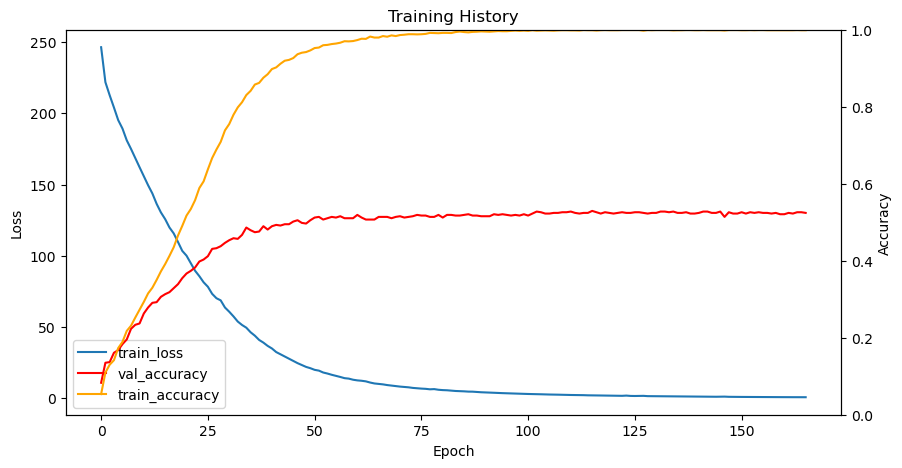

In [21]:
# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

epochs = range(1, 167)

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, train_losses, label='train_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
line2 = ax2.plot(epochs, val_accs, color='red', label='val_accuracy')
line3 = ax2.plot(epochs, train_accs, color='orange', label='train_accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_ylim([0, 1])

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 + line3
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History")
plt.show()